### DEseq2 analysis - python part
## Input with spike-in normalized value
<p style="text-align: right;"> Written by Soomin Son
<p style="text-align: right;"> Last revised: 14. 10. 2020.</p>

### Purpose

- Find differentially expressed miRNAs using DEseq2 library in R
- Preparing for input dataframe for DEseq2 and Making plots with the results from DEseq2

---
### Settings

In [2]:
import sys
sys.path.append('/casa/soomin/miniconda3/lib/python3.7/site-packages/')
sys.path.append('/casa/soomin/miniconda3/envs/py37/lib/python3.7/site-packages/')
sys.path.append('/casa/soomin/miniconda3/envs/py37/lib/python3.8/site-packages')

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib_venn import venn2

from scipy import stats
from scipy.stats import mannwhitneyu
from statannot import add_stat_annotation

import numpy as np
import pybedtools
import seaborn as sns
sns.set(style="ticks", palette="muted")

In [3]:
samples =  'HCT116_delN200_1 HCT116_del10_1 HCT116_delN200_2 HCT116_del10_2 HCT116_delN200_3 HCT116_del10_3'.split()

In [4]:
from matplotlib import font_manager

font_dirs = ['/casa/soomin/font/Helvetica/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

---
### Raw count of miRNAs

In [1487]:
Count_HCT116_sDro1_df = pd.read_csv("../190904_HCT116_AQ_seq/scratch_count/HCT116_sDro1.readcount", sep="\t", header=None)
Count_HCT116_sDro1_df.columns = "chr start end mature pri strand HCT116_sDro1_count".split()

Count_HCT116_FL1_df = pd.read_csv("../190904_HCT116_AQ_seq/scratch_count/HCT116_FL1.readcount", sep="\t", header=None)
Count_HCT116_FL1_df.columns = "chr start end mature pri strand HCT116_FL1_count".split()

Count_HCT116_sDro2_df = pd.read_csv("../190904_HCT116_AQ_seq/scratch_count/HCT116_sDro2.readcount", sep="\t", header=None)
Count_HCT116_sDro2_df.columns = "chr start end mature pri strand HCT116_sDro2_count".split()

Count_HCT116_FL2_df = pd.read_csv("../190904_HCT116_AQ_seq/scratch_count/HCT116_FL2.readcount", sep="\t", header=None)
Count_HCT116_FL2_df.columns = "chr start end mature pri strand HCT116_FL2_count".split()

Count_HCT116_sDro3_df = pd.read_csv("../190904_HCT116_AQ_seq/scratch_count/HCT116_sDro3.readcount", sep="\t", header=None)
Count_HCT116_sDro3_df.columns = "chr start end mature pri strand HCT116_sDro3_count".split()

Count_HCT116_FL3_df = pd.read_csv("../190904_HCT116_AQ_seq/scratch_count/HCT116_FL3.readcount", sep="\t", header=None)
Count_HCT116_FL3_df.columns = "chr start end mature pri strand HCT116_FL3_count".split()

In [1490]:
Count_raw_df = pd.DataFrame(index=Count_HCT116_sDro1_df["mature"].drop_duplicates())
Count_raw_df = Count_raw_df.sort_index()

Count_raw_df = Count_raw_df.join(pd.DataFrame(Count_HCT116_sDro1_df.groupby("mature").apply(lambda x: sum(x["HCT116_sDro1_count"]) / len(x["pri"]))))
Count_raw_df = Count_raw_df.rename(columns = {0:'HCT116_delN200_1'})

Count_raw_df = Count_raw_df.join(pd.DataFrame(Count_HCT116_FL1_df.groupby("mature").apply(lambda x: sum(x["HCT116_FL1_count"]) / len(x["pri"]))))
Count_raw_df = Count_raw_df.rename(columns = {0:'HCT116_del10_1'})

Count_raw_df = Count_raw_df.join(pd.DataFrame(Count_HCT116_sDro2_df.groupby("mature").apply(lambda x: sum(x["HCT116_sDro2_count"]) / len(x["pri"]))))
Count_raw_df = Count_raw_df.rename(columns = {0:'HCT116_delN200_2'})

Count_raw_df = Count_raw_df.join(pd.DataFrame(Count_HCT116_FL2_df.groupby("mature").apply(lambda x: sum(x["HCT116_FL2_count"]) / len(x["pri"]))))
Count_raw_df = Count_raw_df.rename(columns = {0:'HCT116_del10_2'})

Count_raw_df = Count_raw_df.join(pd.DataFrame(Count_HCT116_sDro3_df.groupby("mature").apply(lambda x: sum(x["HCT116_sDro3_count"]) / len(x["pri"]))))
Count_raw_df = Count_raw_df.rename(columns = {0:'HCT116_delN200_3'})

Count_raw_df = Count_raw_df.join(pd.DataFrame(Count_HCT116_FL3_df.groupby("mature").apply(lambda x: sum(x["HCT116_FL3_count"]) / len(x["pri"]))))
Count_raw_df = Count_raw_df.rename(columns = {0:'HCT116_del10_3'})


Count_raw_df = Count_raw_df[Count_raw_df.sum(axis=1) != float(0)]

In [1491]:
Count_raw_df.head()

HCT116_delN200_1  HCT116_del10_1  HCT116_delN200_2  \
mature                                                                
hsa-let-7a-2-3p         14.000000      104.000000         22.000000   
hsa-let-7a-3p          250.500000      555.500000        262.000000   
hsa-let-7a-5p         9974.666667    19066.666667       8972.333333   
hsa-let-7b-3p           62.000000      179.000000         44.000000   
hsa-let-7b-5p         2307.000000     5263.000000       2092.000000   

                 HCT116_del10_2  HCT116_delN200_3  HCT116_del10_3  
mature                                                             
hsa-let-7a-2-3p       66.000000         33.000000       99.000000  
hsa-let-7a-3p        638.500000        247.500000      481.000000  
hsa-let-7a-5p      19655.666667      10230.666667    20878.333333  
hsa-let-7b-3p        194.000000         67.000000      166.000000  
hsa-let-7b-5p       4847.000000       1578.000000     3520.000000

---
### Spike-in fractions 

In [1492]:
SpikeIns_df = pd.read_csv("Results/Count_SpikeIns.txt", sep="\t")
SpikeIns_df = SpikeIns_df.set_index("Spike-In")
print(SpikeIns_df.shape)
SpikeIns_df.head()

(30, 12)


HCT116_sDro1_perc  HCT116_FL1_perc  HCT116_sDro2_perc  \
Spike-In                                                          
spk_1              1.024029         0.907939           1.135994   
spk_2              4.521550         2.185778           1.954967   
spk_3              2.920301         3.277374           3.546171   
spk_4              2.879682         2.203885           2.664201   
spk_5              1.909099         1.865025           1.719233   

          HCT116_FL2_perc  HCT116_sDro3_perc  HCT116_FL3_perc  \
Spike-In                                                        
spk_1            1.047486           1.515344         1.321976   
spk_2            4.261959           1.838701         1.839864   
spk_3            3.314857           3.119452         3.155026   
spk_4            3.245024           2.307887         2.650767   
spk_5            1.754539           2.168400         2.732538   

          HCT116_sDro1_count  HCT116_FL1_count  HCT116_sDro2_count  \
Spike-In                                                             
spk_1                    479               351                 559   
spk_2                   2115               845                 962   
spk_3                   1366              1267                1745   
spk_4                   1347               852                1311   
spk_5                    893               721                 846   

          HCT116_FL2_count  HCT116_sDro3_count  HCT116_FL3_count  
Spike-In                                                          
spk_1                  480                 239               194  
spk_2                 1953                 290               270  
spk_3                 1519                 492               463  
spk_4                 1487                 364               389  
spk_5                  804                 342               401

In [1493]:
all_spkn = list(SpikeIns_df.index)
np.random.seed(3)

norm_spkn = list(np.random.choice(all_spkn, 15, replace=False))
other_spkn = [spkn for spkn in all_spkn if spkn not in norm_spkn]

print(len(norm_spkn), len(other_spkn))
print("norm spike-in: " + ", ".join(norm_spkn))
print("other spike-in: " + ", ".join(other_spkn))

15 15
norm spike-in: spk_16, spk_6, spk_23, spk_27, spk_19, spk_15, spk_14, spk_3, spk_17, spk_2, spk_18, spk_28, spk_8, spk_13, spk_5
other spike-in: spk_1, spk_4, spk_7, spk_9, spk_10, spk_11, spk_12, spk_20, spk_21, spk_22, spk_24, spk_25, spk_26, spk_29, spk_30


In [1494]:
norm_spkn_gmean = \
pd.DataFrame(stats.gmean(SpikeIns_df.loc[norm_spkn].iloc[:,6:]), index=samples, columns=["g_mean"]).T

norm_spkn_gmean.head()

HCT116_delN200_1  HCT116_del10_1  HCT116_delN200_2  HCT116_del10_2  \
g_mean       1137.599321      880.835617       1141.358704     1023.533716   

        HCT116_delN200_3  HCT116_del10_3  
g_mean        431.675412      371.477199

In [1495]:
other_spkn_df = SpikeIns_df.loc[other_spkn].iloc[:,6:]
other_spkn_df.columns = samples
other_spkn_df.head()

HCT116_delN200_1  HCT116_del10_1  HCT116_delN200_2  HCT116_del10_2  \
Spike-In                                                                       
spk_1                  479             351               559             480   
spk_4                 1347             852              1311            1487   
spk_7                 1497            1251              1642            1516   
spk_9                  917             491               933             633   
spk_10                2643            2723              2958            3053   

          HCT116_delN200_3  HCT116_del10_3  
Spike-In                                    
spk_1                  239             194  
spk_4                  364             389  
spk_7                  399             451  
spk_9                  300             358  
spk_10                 966             762

--- 
### Spike-in normalized count of miRNAs

In [1496]:
count_norm_df = pd.DataFrame(index=Count_raw_df.index)
other_spkn_norm_df = pd.DataFrame(index=other_spkn_df.index)

for s in samples:
    count_norm_df[s] = Count_raw_df[s]/norm_spkn_gmean[s][0]
    other_spkn_norm_df[s] = other_spkn_df[s]/norm_spkn_gmean[s][0]
    
count_norm_df.head()

HCT116_delN200_1  HCT116_del10_1  HCT116_delN200_2  \
mature                                                                
hsa-let-7a-2-3p          0.012307        0.118070          0.019275   
hsa-let-7a-3p            0.220201        0.630651          0.229551   
hsa-let-7a-5p            8.768172       21.646112          7.861099   
hsa-let-7b-3p            0.054501        0.203216          0.038551   
hsa-let-7b-5p            2.027955        5.975008          1.832903   

                 HCT116_del10_2  HCT116_delN200_3  HCT116_del10_3  
mature                                                             
hsa-let-7a-2-3p        0.064482          0.076446        0.266504  
hsa-let-7a-3p          0.623819          0.573347        1.294830  
hsa-let-7a-5p         19.203732         23.699906       56.203539  
hsa-let-7b-3p          0.189539          0.155209        0.446865  
hsa-let-7b-5p          4.735555          3.655524        9.475683

In [1497]:
other_spkn_norm_df.head()

HCT116_delN200_1  HCT116_del10_1  HCT116_delN200_2  HCT116_del10_2  \
Spike-In                                                                       
spk_1             0.421062        0.398485          0.489767        0.468964   
spk_4             1.184072        0.967263          1.148631        1.452810   
spk_7             1.315929        1.420242          1.438636        1.481143   
spk_9             0.806083        0.557425          0.817447        0.618446   
spk_10            2.323314        3.091383          2.591648        2.982804   

          HCT116_delN200_3  HCT116_del10_3  
Spike-In                                    
spk_1             0.553657        0.522239  
spk_4             0.843226        1.047171  
spk_7             0.924306        1.214072  
spk_9             0.694967        0.963720  
spk_10            2.237793        2.051270

#### Scaling 

In [1498]:
scale_set1 = round(float(norm_spkn_gmean.iloc[:,0:2].max(axis=1)))
scale_set2 = round(float(norm_spkn_gmean.iloc[:,2:4].max(axis=1)))
scale_set3 = round(float(norm_spkn_gmean.iloc[:,4:6].max(axis=1)))

print(scale_set1, scale_set2, scale_set3)

1138 1141 432


In [1499]:
scaled_count_norm_df = pd.DataFrame(index=count_norm_df.index, columns=count_norm_df.columns)
scaled_other_spkn_norm_df = pd.DataFrame(index=other_spkn_norm_df.index, columns=other_spkn_norm_df.columns)

scaled_count_norm_df.iloc[:, 0:2] = count_norm_df.iloc[:,0:2] * scale_set1
scaled_other_spkn_norm_df.iloc[:,0:2] = other_spkn_norm_df.iloc[:,0:2] * scale_set1

scaled_count_norm_df.iloc[:, 2:4] = count_norm_df.iloc[:,2:4] * scale_set2
scaled_other_spkn_norm_df.iloc[:,2:4] = other_spkn_norm_df.iloc[:,2:4] * scale_set2

scaled_count_norm_df.iloc[:, 4:6] = count_norm_df.iloc[:,4:6] * scale_set3
scaled_other_spkn_norm_df.iloc[:,4:6] = other_spkn_norm_df.iloc[:,4:6] * scale_set3


scaled_count_norm_df.head()

HCT116_delN200_1 HCT116_del10_1 HCT116_delN200_2  \
mature                                                             
hsa-let-7a-2-3p          14.0049        134.363          21.9931   
hsa-let-7a-3p            250.588        717.681          261.918   
hsa-let-7a-5p            9978.18        24633.3          8969.51   
hsa-let-7b-3p            62.0218         231.26          43.9862   
hsa-let-7b-5p            2307.81        6799.56          2091.34   

                HCT116_del10_2 HCT116_delN200_3 HCT116_del10_3  
mature                                                          
hsa-let-7a-2-3p        73.5745          33.0248         115.13  
hsa-let-7a-3p          711.778          247.686        559.367  
hsa-let-7a-5p          21911.5          10238.4        24279.9  
hsa-let-7b-3p          216.264          67.0504        193.045  
hsa-let-7b-5p          5403.27          1579.19        4093.49

In [1500]:
scaled_count_norm_df = scaled_count_norm_df.applymap(round)
scaled_other_spkn_norm_df = scaled_other_spkn_norm_df.applymap(round)

scaled_count_norm_df.head(20)

HCT116_delN200_1  HCT116_del10_1  HCT116_delN200_2  \
mature                                                                
hsa-let-7a-2-3p                14             134                22   
hsa-let-7a-3p                 251             718               262   
hsa-let-7a-5p                9978           24633              8970   
hsa-let-7b-3p                  62             231                44   
hsa-let-7b-5p                2308            6800              2091   
hsa-let-7c-3p                   0               3                 0   
hsa-let-7c-5p                  52             151                34   
hsa-let-7d-3p                  51             605                43   
hsa-let-7d-5p                 559            5380               495   
hsa-let-7e-3p                   6              49                 5   
hsa-let-7e-5p                 531            1912               466   
hsa-let-7f-1-3p                 2              75                 8   
hsa-let-7f-2-3p                24             105                31   
hsa-let-7f-5p                2839           13732              2596   
hsa-let-7g-3p                  22              57                22   
hsa-let-7g-5p                2549            6075              2461   
hsa-let-7i-3p                  43             463                64   
hsa-let-7i-5p                3113           15801              2915   
hsa-miR-1-3p                    0               1                 0   
hsa-miR-100-3p                 32             116                33   

                 HCT116_del10_2  HCT116_delN200_3  HCT116_del10_3  
mature                                                             
hsa-let-7a-2-3p              74                33             115  
hsa-let-7a-3p               712               248             559  
hsa-let-7a-5p             21911             10238           24280  
hsa-let-7b-3p               216                67             193  
hsa-let-7b-5p              5403              1579            4093  
hsa-let-7c-3p                 0                 1               1  
hsa-let-7c-5p               129                66             158  
hsa-let-7d-3p               463                55             497  
hsa-let-7d-5p              4489               781            5931  
hsa-let-7e-3p                46                 9              41  
hsa-let-7e-5p              1603               609            2043  
hsa-let-7f-1-3p              77                11             128  
hsa-let-7f-2-3p              84                31              50  
hsa-let-7f-5p             13085              3510           13043  
hsa-let-7g-3p                97                35              92  
hsa-let-7g-5p              5344              3499            6759  
hsa-let-7i-3p               406                93             427  
hsa-let-7i-5p             13949              3087           14061  
hsa-miR-1-3p                  2                 1               1  
hsa-miR-100-3p               86                65             164

In [1501]:
scaled_other_spkn_norm_df.head(10)

HCT116_delN200_1  HCT116_del10_1  HCT116_delN200_2  HCT116_del10_2  \
Spike-In                                                                       
spk_1                  479             453               559             535   
spk_4                 1347            1101              1311            1658   
spk_7                 1498            1616              1641            1690   
spk_9                  917             634               933             706   
spk_10                2644            3518              2957            3403   
spk_11                1263            1168              1375            1467   
spk_12                4196            3544              2953            4097   
spk_20                2122            2199              2780            2421   
spk_21                1902            1875              1852            1985   
spk_22                1312            1081               918             679   

          HCT116_delN200_3  HCT116_del10_3  
Spike-In                                    
spk_1                  239             226  
spk_4                  364             452  
spk_7                  399             524  
spk_9                  300             416  
spk_10                 967             886  
spk_11                 398             536  
spk_12                1118            1135  
spk_20                 624             807  
spk_21                 642             699  
spk_22                 258             316

#### Check the relationship between raw read count and scaled normalized read count

In [1502]:
count_raw_norm_df = Count_raw_df.join(scaled_count_norm_df, lsuffix='_raw', rsuffix='_norm')
count_raw_norm_df.head(20)

HCT116_delN200_1_raw  HCT116_del10_1_raw  \
mature                                                      
hsa-let-7a-2-3p             14.000000          104.000000   
hsa-let-7a-3p              250.500000          555.500000   
hsa-let-7a-5p             9974.666667        19066.666667   
hsa-let-7b-3p               62.000000          179.000000   
hsa-let-7b-5p             2307.000000         5263.000000   
hsa-let-7c-3p                0.000000            2.000000   
hsa-let-7c-5p               52.000000          117.000000   
hsa-let-7d-3p               51.000000          468.000000   
hsa-let-7d-5p              559.000000         4164.000000   
hsa-let-7e-3p                6.000000           38.000000   
hsa-let-7e-5p              531.000000         1480.000000   
hsa-let-7f-1-3p              2.000000           58.000000   
hsa-let-7f-2-3p             24.000000           81.000000   
hsa-let-7f-5p             2838.000000        10628.500000   
hsa-let-7g-3p               22.000000           44.000000   
hsa-let-7g-5p             2548.000000         4702.000000   
hsa-let-7i-3p               43.000000          358.000000   
hsa-let-7i-5p             3112.000000        12230.000000   
hsa-miR-1-3p                 0.000000            0.500000   
hsa-miR-100-3p              32.000000           90.000000   

                 HCT116_delN200_2_raw  HCT116_del10_2_raw  \
mature                                                      
hsa-let-7a-2-3p             22.000000           66.000000   
hsa-let-7a-3p              262.000000          638.500000   
hsa-let-7a-5p             8972.333333        19655.666667   
hsa-let-7b-3p               44.000000          194.000000   
hsa-let-7b-5p             2092.000000         4847.000000   
hsa-let-7c-3p                0.000000            0.000000   
hsa-let-7c-5p               34.000000          116.000000   
hsa-let-7d-3p               43.000000          415.000000   
hsa-let-7d-5p              495.000000         4027.000000   
hsa-let-7e-3p                5.000000           41.000000   
hsa-let-7e-5p              466.000000         1438.000000   
hsa-let-7f-1-3p              8.000000           69.000000   
hsa-let-7f-2-3p             31.000000           75.000000   
hsa-let-7f-5p             2596.500000        11738.000000   
hsa-let-7g-3p               22.000000           87.000000   
hsa-let-7g-5p             2462.000000         4794.000000   
hsa-let-7i-3p               64.000000          364.000000   
hsa-let-7i-5p             2916.000000        12513.000000   
hsa-miR-1-3p                 0.000000            2.000000   
hsa-miR-100-3p              33.000000           77.000000   

                 HCT116_delN200_3_raw  HCT116_del10_3_raw  \
mature                                                      
hsa-let-7a-2-3p             33.000000           99.000000   
hsa-let-7a-3p              247.500000          481.000000   
hsa-let-7a-5p            10230.666667        20878.333333   
hsa-let-7b-3p               67.000000          166.000000   
hsa-let-7b-5p             1578.000000         3520.000000   
hsa-let-7c-3p                1.000000            1.000000   
hsa-let-7c-5p               66.000000          136.000000   
hsa-let-7d-3p               55.000000          427.000000   
hsa-let-7d-5p              780.000000         5100.000000   
hsa-let-7e-3p                9.000000           35.000000   
hsa-let-7e-5p              609.000000         1757.000000   
hsa-let-7f-1-3p             11.000000          110.000000   
hsa-let-7f-2-3p             31.000000           43.000000   
hsa-let-7f-5p             3507.500000        11215.500000   
hsa-let-7g-3p               35.000000           79.000000   
hsa-let-7g-5p             3496.000000         5812.000000   
hsa-let-7i-3p               93.000000          367.000000   
hsa-let-7i-5p             3085.000000        12091.000000   
hsa-miR-1-3p                 1.000000            1.000000   
hsa-miR-100-3p              65.000000          141

In [1503]:
count_raw_norm_df.max()

HCT116_delN200_1_raw      57793.0
HCT116_del10_1_raw       276002.0
HCT116_delN200_2_raw      61645.0
HCT116_del10_2_raw       320950.0
HCT116_delN200_3_raw      84909.0
HCT116_del10_3_raw       279720.0
HCT116_delN200_1_norm     57813.0
HCT116_del10_1_norm      356582.0
HCT116_delN200_2_norm     61626.0
HCT116_del10_2_norm      357784.0
HCT116_delN200_3_norm     84973.0
HCT116_del10_3_norm      325293.0
dtype: float64

In [1504]:
other_spkn_raw_norm_df = other_spkn_df.join(scaled_other_spkn_norm_df, lsuffix='_raw', rsuffix='_norm')
other_spkn_raw_norm_df.head(10)

HCT116_delN200_1_raw  HCT116_del10_1_raw  HCT116_delN200_2_raw  \
Spike-In                                                                   
spk_1                      479                 351                   559   
spk_4                     1347                 852                  1311   
spk_7                     1497                1251                  1642   
spk_9                      917                 491                   933   
spk_10                    2643                2723                  2958   
spk_11                    1263                 904                  1375   
spk_12                    4195                2743                  2954   
spk_20                    2121                1702                  2781   
spk_21                    1901                1451                  1853   
spk_22                    1312                 837                   918   

          HCT116_del10_2_raw  HCT116_delN200_3_raw  HCT116_del10_3_raw  \
Spike-In                                                                 
spk_1                    480                   239                 194   
spk_4                   1487                   364                 389   
spk_7                   1516                   399                 451   
spk_9                    633                   300                 358   
spk_10                  3053                   966                 762   
spk_11                  1316                   398                 461   
spk_12                  3675                  1117                 976   
spk_20                  2172                   624                 694   
spk_21                  1781                   642                 601   
spk_22                   609                   258                 272   

          HCT116_delN200_1_norm  HCT116_del10_1_norm  HCT116_delN200_2_norm  \
Spike-In                                                                      
spk_1                       479                  453                    559   
spk_4                      1347                 1101                   1311   
spk_7                      1498                 1616                   1641   
spk_9                       917                  634                    933   
spk_10                     2644                 3518                   2957   
spk_11                     1263                 1168                   1375   
spk_12                     4196                 3544                   2953   
spk_20                     2122                 2199                   2780   
spk_21                     1902                 1875                   1852   
spk_22                     1312                 1081                    918   

          HCT116_del10_2_norm  HCT116_delN200_3_norm  HCT116_del10_3_norm  
Spike-In                                                                   
spk_1                     535                    239                  226  
spk_4                    1658                    364                  452  
spk_7                    1690                    399                  524  
spk_9                     706                    300                  416  
spk_10                   3403                    967                  886  
spk_11                   1467                    398                  536  
spk_12                   4097                   1118                 1135  
spk_20                   2421                    624                  807  
spk_21                   1985                    642                  699  
spk_22                    679                    258                  316

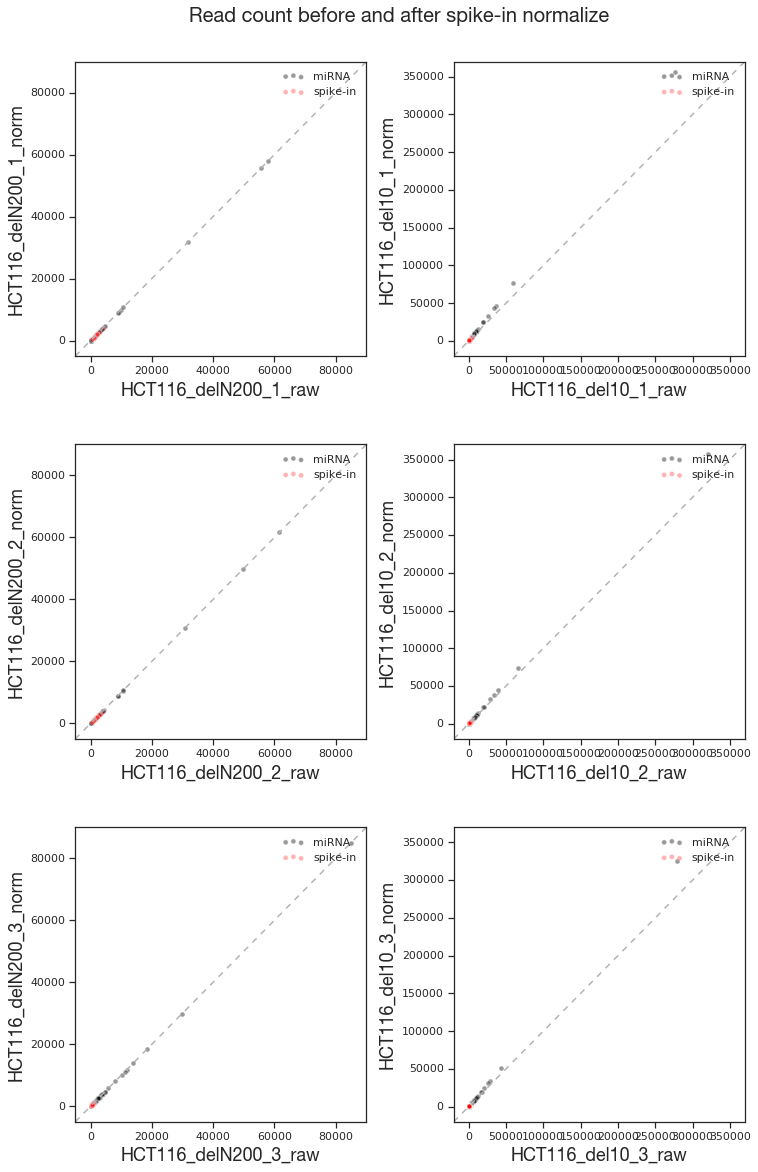

In [1519]:
fig=plt.figure(figsize=(12,19))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(1,7):
    ax = plt.subplot(3,2,i)
    plt.scatter(count_raw_norm_df.iloc[:,i-1], count_raw_norm_df.iloc[:,i+5], c = 'black', s= 25, alpha=0.4, label = "miRNA")
    plt.scatter(other_spkn_raw_norm_df.iloc[:,i-1], other_spkn_raw_norm_df.iloc[:, i+5], c='red', s=25, alpha = 0.3, label = 'spike-in')
    
    if i%2 == 1:
        ax.set_xlim(-5000,90000)
        ax.set_ylim(-5000,90000)
    else:
        ax.set_xlim(-20000,370000)
        ax.set_ylim(-20000,370000)
    
    plt.plot(ax.get_xlim(), ax.get_ylim(), c='0.7', ls='--')
    ax.legend(frameon=False)
    
    ax.set_xlabel(count_raw_norm_df.columns[i-1], fontproperties=helvetica_18)
    ax.set_ylabel(count_raw_norm_df.columns[i+5], fontproperties=helvetica_18)

fig.suptitle("Read count before and after spike-in normalize", fontproperties=helvetica_20, y=0.94)
fig.show()

HCT116_FL1 shows larger counts after spike-in normalization.

---

### Concatenate spike-in and miRNA read count

In [1512]:
norm_count_with_spikeIn = pd.concat([scaled_count_norm_df, scaled_other_spkn_norm_df])
norm_count_with_spikeIn.tail()

HCT116_delN200_1  HCT116_del10_1  HCT116_delN200_2  HCT116_del10_2  \
spk_24              2267            4145              3836            2403   
spk_25               522             721               496             528   
spk_26              1834            1451              2165            1417   
spk_29              2131            5851              2087            2528   
spk_30               976             809              1127            1080   

        HCT116_delN200_3  HCT116_del10_3  
spk_24               939             826  
spk_25               334             359  
spk_26               420             982  
spk_29               666             859  
spk_30               425             658

---

### Make CSV for DEseq2 analysis

In [25]:
### norm counts including spike-ins
#norm_count_with_spikeIn.to_csv("Results/norm_count_w_spikeIn.csv")

### norm counts without spike-ins
#scaled_count_norm_df.to_csv("Results/norm_count_wo_spikeIn.csv")

### Go to 200529_DEseq2_analysis_SpikeInnormalized-R

--- 

### Load DROSHA-dependency information

In [7]:
drosha_dependency = pd.read_table("200326_curated_hg38_mature_miRNA_classification.txt")[["mature miRNA", "curated DROSHA dependency (HCT116)"]]
drosha_dependency[drosha_dependency["mature miRNA"] == "hsa-miR-941"]

mature miRNA curated DROSHA dependency (HCT116)
1705  hsa-miR-941                   DROSHA-dependent
1706  hsa-miR-941                   DROSHA-dependent
1707  hsa-miR-941                   DROSHA-dependent
1708  hsa-miR-941                   DROSHA-dependent
1709  hsa-miR-941                   DROSHA-dependent

In [8]:
print(drosha_dependency.shape)

# Drop duplicates (because of multiple pri-miRNAs)

drosha_dependency = drosha_dependency.drop_duplicates().set_index("mature miRNA")
print(drosha_dependency.shape)

(2813, 2)
(2589, 1)


In [9]:
curated_dependency=drosha_dependency[~drosha_dependency["curated DROSHA dependency (HCT116)"].isna()]
curated_dependency.head()

del drosha_dependency

---
### Check spike-in normalized values

In [241]:
norm_check_df = pd.read_csv("Results/norm_count_w_spikeIn.csv")
norm_check_df.rename(columns={'Unnamed: 0': 'mature'}, inplace=True)
norm_check_df.set_index('mature', inplace=True)
norm_check_df.head()

HCT116_sDro1  HCT116_FL1  HCT116_sDro2  HCT116_FL2  \
mature                                                                
hsa-let-7a-2-3p            14         134            22          74   
hsa-let-7a-3p             251         718           262         712   
hsa-let-7a-5p            9978       24633          8970       21911   
hsa-let-7b-3p              62         231            44         216   
hsa-let-7b-5p            2308        6800          2091        5403   

                 HCT116_sDro3  HCT116_FL3  
mature                                     
hsa-let-7a-2-3p            33         115  
hsa-let-7a-3p             248         559  
hsa-let-7a-5p           10238       24280  
hsa-let-7b-3p              67         193  
hsa-let-7b-5p            1579        4093

In [115]:
norm_check_df = norm_check_df.join(curated_dependency, how="left")
print(norm_check_df.shape)
norm_check_df.head()

(1841, 7)


HCT116_sDro1  HCT116_FL1  HCT116_sDro2  HCT116_FL2  \
mature                                                                
hsa-let-7a-2-3p            14         134            22          74   
hsa-let-7a-3p             251         718           262         712   
hsa-let-7a-5p            9978       24633          8970       21911   
hsa-let-7b-3p              62         231            44         216   
hsa-let-7b-5p            2308        6800          2091        5403   

                 HCT116_sDro3  HCT116_FL3 curated DROSHA dependency (HCT116)  
mature                                                                        
hsa-let-7a-2-3p            33         115                   DROSHA-dependent  
hsa-let-7a-3p             248         559                   DROSHA-dependent  
hsa-let-7a-5p           10238       24280                   DROSHA-dependent  
hsa-let-7b-3p              67         193                   DROSHA-dependent  
hsa-let-7b-5p            1579        4093                   DROSHA-dependent

#### normalized read count cutoff = 20 

In [116]:
norm_check_df = norm_check_df[(norm_check_df.iloc[:,0:6] >= 20).sum(axis=1) >= 3]
print(norm_check_df.shape)
norm_check_df.head()

(404, 7)


HCT116_sDro1  HCT116_FL1  HCT116_sDro2  HCT116_FL2  \
mature                                                                
hsa-let-7a-2-3p            14         134            22          74   
hsa-let-7a-3p             251         718           262         712   
hsa-let-7a-5p            9978       24633          8970       21911   
hsa-let-7b-3p              62         231            44         216   
hsa-let-7b-5p            2308        6800          2091        5403   

                 HCT116_sDro3  HCT116_FL3 curated DROSHA dependency (HCT116)  
mature                                                                        
hsa-let-7a-2-3p            33         115                   DROSHA-dependent  
hsa-let-7a-3p             248         559                   DROSHA-dependent  
hsa-let-7a-5p           10238       24280                   DROSHA-dependent  
hsa-let-7b-3p              67         193                   DROSHA-dependent  
hsa-let-7b-5p            1579        4093                   DROSHA-dependent

In [24]:
norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"].isin(["Capped miRNA"])]

HCT116_sDro1  HCT116_FL1  HCT116_sDro2  HCT116_FL2  \
mature                                                             
hsa-miR-320a         55757       43936         49788       38325   
hsa-miR-320b          2602        2337          2378        2089   
hsa-miR-320c          1209        1086          1019         983   
hsa-miR-320d           603         584           472         584   
hsa-miR-320e            71          99            67          96   
hsa-miR-3615          1547        1464          1528        1340   
hsa-miR-484           4574        3721          4056        3573   
hsa-miR-7706           307         227           303         260   

              HCT116_sDro3  HCT116_FL3 curated DROSHA dependency (HCT116)  
mature                                                                     
hsa-miR-320a         18529       19512                       Capped miRNA  
hsa-miR-320b           864        1053                       Capped miRNA  
hsa-miR-320c           375         559                       Capped miRNA  
hsa-miR-320d           197         298                       Capped miRNA  
hsa-miR-320e            45          65                       Capped miRNA  
hsa-miR-3615           555         601                       Capped miRNA  
hsa-miR-484           2834        3107                       Capped miRNA  
hsa-miR-7706           117         144                       Capped miRNA

---
### Reproducibility

- See the reproducibility between biological replicates.

In [117]:
# rearrange columns
# add pseudocount 

pseudocount = 1
rep_tmp = norm_check_df[["HCT116_sDro1", "HCT116_sDro2", "HCT116_sDro3", "HCT116_FL1", "HCT116_FL2", "HCT116_FL3"]]
rep_tmp = rep_tmp + pseudocount

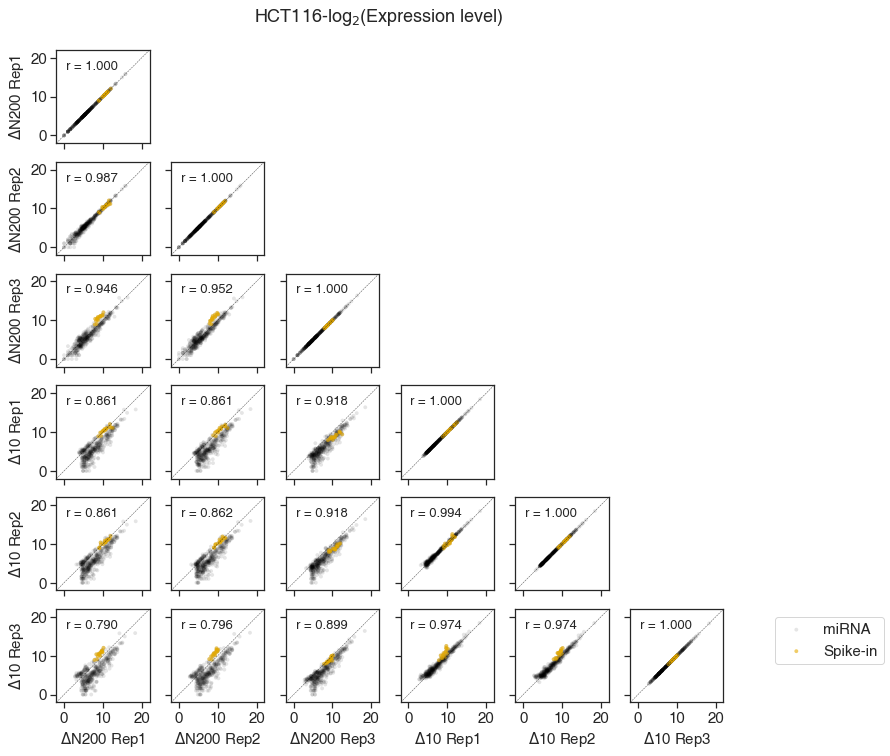

In [145]:
fig, ax=plt.subplots(6,6,figsize=(12,12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.2)


for row in range(0,5):
    for col in range(row+1,6):
        ax[row][col].remove()

for row in range(0,6):
    for col in range(0,row+1):
        ax[row][col].scatter(np.log2(rep_tmp.iloc[:,row]), np.log2(rep_tmp.iloc[:,col]), c='black', s=15, alpha=0.1,\
                   edgecolors="none", label = 'miRNA')
        r = stats.pearsonr(np.log2(rep_tmp.iloc[:,row]), np.log2(rep_tmp.iloc[:,col]))[0]
        ax[row][col].text(0.5,17, 'r = %.3f'%r, fontsize = 13)
        
        ax[row][col].scatter(np.log2(rep_tmp[rep_tmp.index.str.contains('spk')].iloc[:,row]), \
                            np.log2(rep_tmp[rep_tmp.index.str.contains('spk')].iloc[:,col]), c='#e6ab02', s=15, alpha=0.6,\
                             edgecolors='none',label='Spike-in')
        

        
        ax[row][col].set_xlim(-2,22)
        ax[row][col].set_ylim(-2,22)
        ax[row][col].set_xticks([0,10,20])
        ax[row][col].plot(ax[row][col].get_xlim(), ax[row][col].get_ylim(), linewidth=0.5, c='black', alpha=0.7, ls='--')
        ax[row][col].set_aspect('equal', adjustable='box')
        
        for label in (ax[row][col].get_xticklabels() + ax[row][col].get_yticklabels()) :
            label.set_fontsize(15)

ax[0][0].set_ylabel("$\Delta$N200 Rep1", fontsize=15)
ax[1][0].set_ylabel("$\Delta$N200 Rep2", fontsize=15)
ax[2][0].set_ylabel("$\Delta$N200 Rep3", fontsize=15)
ax[3][0].set_ylabel("$\Delta$10 Rep1", fontsize=15)
ax[4][0].set_ylabel("$\Delta$10 Rep2", fontsize=15)
ax[5][0].set_ylabel("$\Delta$10 Rep3", fontsize=15)

ax[5][0].set_xlabel("$\Delta$N200 Rep1", fontsize=15)
ax[5][1].set_xlabel("$\Delta$N200 Rep2", fontsize=15)
ax[5][2].set_xlabel("$\Delta$N200 Rep3", fontsize=15)
ax[5][3].set_xlabel("$\Delta$10 Rep1", fontsize=15)
ax[5][4].set_xlabel("$\Delta$10 Rep2", fontsize=15)
ax[5][5].set_xlabel("$\Delta$10 Rep3", fontsize=15)

ax[5][5].legend(bbox_to_anchor=(2.8,1), loc='upper right', scatterpoints=1, fontsize=15)

#for i in range(0,3):
#    for j in range(0,3):
#        ax[i][j].set_facecolor('#43AA61')
#        ax[i][j].patch.set_alpha(0.15)
#        
#for i in range(3,6):
#    for j in range(3,6):
#        ax[i][j].set_facecolor('#3F73D2')
#        ax[i][j].patch.set_alpha(0.15)

fig.suptitle('HCT116-log$_2$(Expression level)', fontsize=18, y=0.93)
fig.show()

#plt.savefig("Results/Figures/201207-reproducibility-HCT116.pdf", bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log2


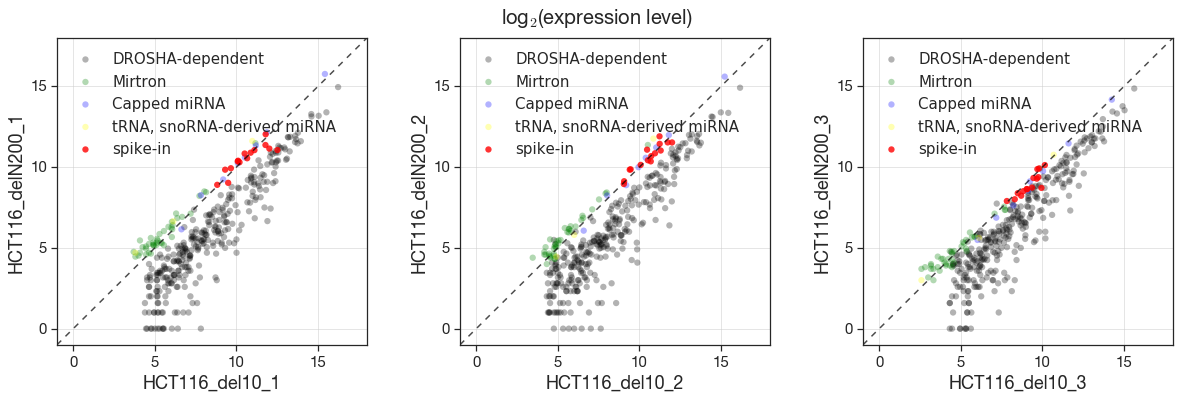

In [1520]:
fig=plt.figure(figsize=(20,5.5))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(1,4):
    ax = plt.subplot(1,3,i)
    
    plt.scatter(np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"] == "DROSHA-dependent"].iloc[:,2*i-1]), \
                np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"] == "DROSHA-dependent"].iloc[:,2*i-2]), \
                c = "black", s=40, alpha=0.3, edgecolors="none", label= "DROSHA-dependent")
    plt.scatter(np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"] == "Mirtron"].iloc[:,2*i-1]), \
                np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"] == "Mirtron"].iloc[:,2*i-2]), \
                c = "green", s=40, alpha=0.3, edgecolors="none", label= "Mirtron")
    plt.scatter(np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"] == "Capped miRNA"].iloc[:,2*i-1]), \
                np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"] == "Capped miRNA"].iloc[:,2*i-2]), \
                c = "blue", s=40, alpha=0.3, edgecolors="none", label= "Capped miRNA")
    plt.scatter(np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"].isin(["tRNA-related miRNA", "SnoRNA-derived miRNA"])].iloc[:,2*i-1]), \
                np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"].isin(["tRNA-related miRNA", "SnoRNA-derived miRNA"])].iloc[:,2*i-2]), \
                c = "yellow", s=40, alpha=0.3, edgecolors="none", label= "tRNA, snoRNA-derived miRNA")
    
    plt.scatter(np.log2(norm_check_df[norm_check_df.index.str.contains('spk')].iloc[:,2*i-1]), \
                np.log2(norm_check_df[norm_check_df.index.str.contains('spk')].iloc[:,2*i-2]), \
                c = 'red', s=40, alpha = 0.8, edgecolors="none", label = 'spike-in')
    
    ax.set_xlim(-1,18)
    ax.set_ylim(-1,18)
    
    plt.plot(ax.get_xlim(), ax.get_ylim(),c='black', alpha=0.7, ls='--')
    ax.legend(frameon=False, fontsize=15, scatterpoints=1, loc='upper left')
    
    ax.set_xlabel(norm_check_df.columns[2*i-1], fontproperties=helvetica_18)
    ax.set_ylabel(norm_check_df.columns[2*i-2], fontproperties=helvetica_18)
    
    ax.grid(axis='y', alpha=0.5)
    ax.grid(axis='x', alpha=0.5)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
        label.set_fontproperties(helvetica_15)

fig.suptitle("log$_2$(expression level)", fontproperties=helvetica_20)

fig.show()
#plt.savefig("Results/200730_HCT116_expression_scatter.pdf", bbox_inches='tight')
#plt.savefig("Results/200730_HCT116_expression_scatter.png", bbox_inches='tight')

For KB's data meeting

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log2


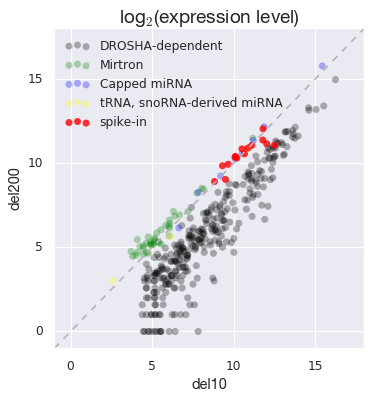

In [443]:
fig, ax=plt.subplots(figsize=(5,5))
fig.subplots_adjust(hspace=0.3, wspace=0.3)


ax.scatter(np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"] == "DROSHA-dependent"].iloc[:,1]), \
            np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"] == "DROSHA-dependent"].iloc[:,0]), \
            c = "black", s=40, alpha=0.3, edgecolors="none", label= "DROSHA-dependent")
ax.scatter(np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"] == "Mirtron"].iloc[:,1]), \
            np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"] == "Mirtron"].iloc[:,0]), \
            c = "green", s=40, alpha=0.3, edgecolors="none", label= "Mirtron")
ax.scatter(np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"] == "Capped miRNA"].iloc[:,1]), \
            np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"] == "Capped miRNA"].iloc[:,0]), \
            c = "blue", s=40, alpha=0.3, edgecolors="none", label= "Capped miRNA")
ax.scatter(np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"].isin(["tRNA-related miRNA", "SnoRNA-derived miRNA"])].iloc[:,2*i-1]), \
            np.log2(norm_check_df[norm_check_df["curated DROSHA dependency (HCT116)"].isin(["tRNA-related miRNA", "SnoRNA-derived miRNA"])].iloc[:,2*i-2]), \
            c = "yellow", s=40, alpha=0.3, edgecolors="none", label= "tRNA, snoRNA-derived miRNA")
    
ax.scatter(np.log2(norm_check_df[norm_check_df.index.str.contains('spk')].iloc[:,1]), \
            np.log2(norm_check_df[norm_check_df.index.str.contains('spk')].iloc[:,0]), \
            c = 'red', s=40, alpha = 0.8, edgecolors="none", label = 'spike-in')
   
    
ax.set_xlim(-1,18)
ax.set_ylim(-1,18)
    
plt.plot(ax.get_xlim(), ax.get_ylim(), c='0.7', ls='--')
ax.legend(frameon=False, loc="upper left")
    
ax.set_xlabel("del10", fontproperties=helvetica, size=13)
ax.set_ylabel("del200", fontproperties=helvetica, size=13)

ax.set_title("log$_2$(expression level)", fontproperties=helvetica, size=17, y=1)
fig.show()

plt.savefig("Results/200713_for_KB.pdf", bbox_inches='tight')

--- 

### Working with DEseq2 results (w_spikeIn and wo_spikeIn both)

In [5]:
w_spikeIn = pd.read_csv("Results/DE_norm_w_spikeIn.csv")
w_spikeIn.rename(columns={'Unnamed: 0': 'mature'}, inplace=True)
w_spikeIn.set_index("mature", inplace=True)

wo_spikeIn = pd.read_csv("Results/DE_norm_wo_spikeIn.csv")
wo_spikeIn.rename(columns={'Unnamed: 0': 'mature'}, inplace=True)
wo_spikeIn.set_index("mature", inplace=True)


print(w_spikeIn.shape)
w_spikeIn.head()

(1841, 5)


baseMean  log2FoldChange      stat    pvalue      padj
mature                                                                     
hsa-let-7a-2-3p     52.394713       -0.901333 -2.165859  0.030322  0.066836
hsa-let-7a-3p      410.786354       -0.089378 -0.436403  0.662545  0.740194
hsa-let-7a-5p    15216.651736        0.009163  0.047385  0.962207  0.982280
hsa-let-7b-3p      113.500150       -0.583679 -2.091957  0.036442  0.076425
hsa-let-7b-5p     3288.216511       -0.136267 -0.518374  0.604197  0.691858

In [6]:
print(wo_spikeIn.shape)
wo_spikeIn.head()

(1826, 5)


baseMean  log2FoldChange      stat    pvalue      padj
mature                                                                     
hsa-let-7a-2-3p     52.001757       -0.872217 -2.165389  0.030358  0.073023
hsa-let-7a-3p      410.195139       -0.057188 -0.272884  0.784942  0.831821
hsa-let-7a-5p    15181.592280        0.042568  0.230652  0.817585  0.862818
hsa-let-7b-3p      112.982374       -0.553329 -2.003815  0.045090  0.098095
hsa-let-7b-5p     3286.085781       -0.102937 -0.402002  0.687683  0.757146

In [10]:
w_spikeIn_info = w_spikeIn.join(curated_dependency, how='left')
w_spikeIn_info.head()

baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                        
hsa-let-7a-2-3p     52.394713       -0.901333 -2.165859  0.030322  0.066836   
hsa-let-7a-3p      410.786354       -0.089378 -0.436403  0.662545  0.740194   
hsa-let-7a-5p    15216.651736        0.009163  0.047385  0.962207  0.982280   
hsa-let-7b-3p      113.500150       -0.583679 -2.091957  0.036442  0.076425   
hsa-let-7b-5p     3288.216511       -0.136267 -0.518374  0.604197  0.691858   

                curated DROSHA dependency (HCT116)  
mature                                              
hsa-let-7a-2-3p                   DROSHA-dependent  
hsa-let-7a-3p                     DROSHA-dependent  
hsa-let-7a-5p                     DROSHA-dependent  
hsa-let-7b-3p                     DROSHA-dependent  
hsa-let-7b-5p                     DROSHA-dependent

In [11]:
wo_spikeIn_info = wo_spikeIn.join(curated_dependency, how='left')
wo_spikeIn_info.head()

baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                        
hsa-let-7a-2-3p     52.001757       -0.872217 -2.165389  0.030358  0.073023   
hsa-let-7a-3p      410.195139       -0.057188 -0.272884  0.784942  0.831821   
hsa-let-7a-5p    15181.592280        0.042568  0.230652  0.817585  0.862818   
hsa-let-7b-3p      112.982374       -0.553329 -2.003815  0.045090  0.098095   
hsa-let-7b-5p     3286.085781       -0.102937 -0.402002  0.687683  0.757146   

                curated DROSHA dependency (HCT116)  
mature                                              
hsa-let-7a-2-3p                   DROSHA-dependent  
hsa-let-7a-3p                     DROSHA-dependent  
hsa-let-7a-5p                     DROSHA-dependent  
hsa-let-7b-3p                     DROSHA-dependent  
hsa-let-7b-5p                     DROSHA-dependent

I will use only w spike in results for downstream analysis.

Set the log2FC cutoff with spike in values.

In [12]:
w_spikeIn_info[(w_spikeIn_info.index.str.contains("spk")) & (w_spikeIn_info["padj"] < 0.05)]["log2FoldChange"]

mature
spk_1     1.334421
spk_9     1.534529
spk_11    1.187306
spk_20    1.265919
spk_21    1.207198
spk_22    1.497589
spk_25    1.043669
spk_26    1.424505
spk_30    1.243582
Name: log2FoldChange, dtype: float64

In [13]:
log2FC_cutoff = \
w_spikeIn_info[(w_spikeIn_info.index.str.contains("spk")) & (w_spikeIn_info["padj"] < 0.05)]["log2FoldChange"].abs().max()

print(log2FC_cutoff)

1.53452924346508


In [14]:
w_spikeIn_sig = \
w_spikeIn_info[(w_spikeIn_info["padj"] < 0.05) & (w_spikeIn_info["log2FoldChange"].abs() > log2FC_cutoff)]

print(w_spikeIn_sig.shape)

(167, 6)


In [143]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.set_xlim(-6,4)
ax.set_ylim(-0.7,30)
ax.plot([log2FC_cutoff, log2FC_cutoff], ax.get_ylim(),c='black', alpha=0.7, ls='--', linewidth=1.2)
ax.plot([-log2FC_cutoff, -log2FC_cutoff], ax.get_ylim(),c='black', alpha=0.7, ls='--', linewidth=1.2)
ax.plot(ax.get_xlim(),[-np.log10(0.05), -np.log10(0.05)],c='black', alpha=0.7, ls='--', linewidth=1.2)

allmiRNA = ax.scatter(w_spikeIn_info["log2FoldChange"], -np.log10(w_spikeIn_info["padj"]), s=50, c='grey', alpha=0.1, edgecolors='none')
DD = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["log2FoldChange"], \
                -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["padj"]),\
                c='tomato', alpha=0.3, s=50, edgecolors='none')
Mirtron = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="Mirtron"]["log2FoldChange"], \
                     -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="Mirtron"]["padj"]),\
                     c='green', alpha=0.3, s=50, edgecolors='none')
Capped = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="Capped miRNA"]["log2FoldChange"], \
                    -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="Capped miRNA"]["padj"]),\
                    c='blue', alpha=0.3, s=50, edgecolors='none')
tRNA_snoRNA = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"].isin(['SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["log2FoldChange"], \
                         -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"].isin(['SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["padj"]),\
                         c='yellow', alpha=0.3, s=50, edgecolors='none')

ax.set_xlabel("log$_2$(delN200/del10)", fontsize=18)
ax.set_ylabel("-log$_1$$_0$(adjusted p-value)", fontsize=18)
ax.legend((DD, Mirtron, Capped, tRNA_snoRNA), ("DROSHA-dependent", "Mirtron", "Capped miRNA", "tRNA, snoRNA-derived miRNA"), \
          frameon=False, bbox_to_anchor=(2,1), loc='upper right', scatterpoints=1, fontsize=15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)
ax.spines['bottom'].set_position(('outward', 4))

ax.set_title("HCT116",fontsize=20)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontsize(15)

fig.show()
#plt.savefig("Results/201014-data-volcano-HCT116.pdf", bbox_inches='tight')
#plt.savefig("Results/201014-data-volcano-HCT116.png", bbox_inches='tight')

del allmiRNA, DD, Mirtron, Capped, tRNA_snoRNA

For figure (combine DROSHA-independent miRNAs)

In [25]:
w_spikeIn_sig[(w_spikeIn_sig['log2FoldChange'] > log2FC_cutoff) & w_spikeIn_sig["curated DROSHA dependency (HCT116)"].isin(['Capped miRNA', "Mirtron", 'SnoRNA-derived miRNA', 'tRNA-related miRNA'])].shape

(42, 6)

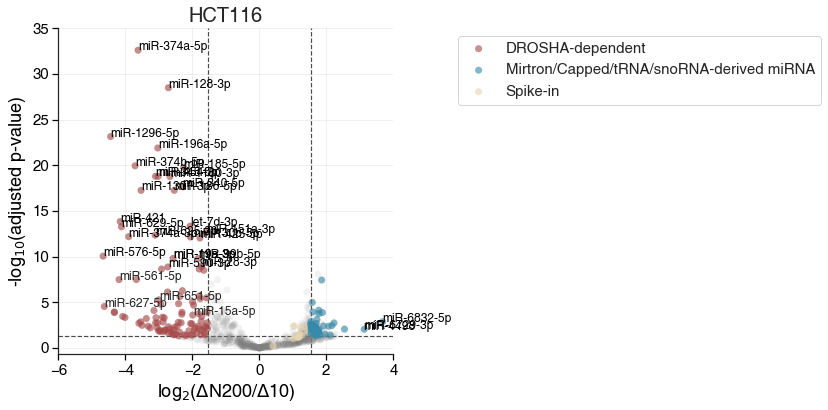

In [50]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.set_xlim(-6,4)
ax.set_ylim(-0.7,35)
ax.plot([log2FC_cutoff, log2FC_cutoff], ax.get_ylim(),c='black', alpha=0.7, ls='--', linewidth=1.2, zorder=1)
ax.plot([-log2FC_cutoff, -log2FC_cutoff], ax.get_ylim(),c='black', alpha=0.7, ls='--', linewidth=1.2, zorder=1)
ax.plot(ax.get_xlim(),[-np.log10(0.05), -np.log10(0.05)],c='black', alpha=0.7, ls='--', linewidth=1.2, zorder=1)

allmiRNA = ax.scatter(w_spikeIn_info["log2FoldChange"], -np.log10(w_spikeIn_info["padj"]), s=50, c='grey', alpha=0.1, edgecolors='none', zorder=2)
spkn = ax.scatter(w_spikeIn_info[w_spikeIn_info.index.str.contains('spk')]["log2FoldChange"], \
                  -np.log10(w_spikeIn_info[w_spikeIn_info.index.str.contains('spk')]["padj"]),\
                  c='#e7d6b1', alpha=0.6, s=50, edgecolors='none', zorder=2)
DD = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["log2FoldChange"], \
                -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["padj"]),\
                c='#a84848', alpha=0.6, s=50, edgecolors='none', zorder=2)
MCSnoT = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"].isin(['Capped miRNA', "Mirtron", 'SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["log2FoldChange"], \
                    -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"].isin(['Capped miRNA', "Mirtron", 'SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["padj"]),\
                    c='#3689a9', alpha=0.6, s=50, edgecolors='none', zorder=2)


ax.set_xlabel("log$_2$($\Delta$N200/$\Delta$10)", fontsize=18, color='black')
ax.set_ylabel("-log$_{10}$(adjusted p-value)", fontsize=18, color='black')
ax.legend((DD, MCSnoT, spkn), ("DROSHA-dependent", "Mirtron/Capped/tRNA/snoRNA-derived miRNA", "Spike-in"), \
          frameon=True, bbox_to_anchor=(2.3,1), loc='upper right', scatterpoints=1, fontsize=15)

ax.text(w_spikeIn_info.loc["hsa-miR-19a-3p", "log2FoldChange"], -np.log10(w_spikeIn_info.loc["hsa-miR-19a-3p", "padj"]), 'miR-19a-3p', fontsize=12)
ax.text(w_spikeIn_info.loc["hsa-miR-15a-5p", "log2FoldChange"], -np.log10(w_spikeIn_info.loc["hsa-miR-15a-5p", "padj"]), 'miR-15a-5p', fontsize=12)
ax.text(w_spikeIn_info.loc["hsa-miR-561-5p", "log2FoldChange"], -np.log10(w_spikeIn_info.loc["hsa-miR-561-5p", "padj"]), 'miR-561-5p', fontsize=12)
ax.text(w_spikeIn_info.loc["hsa-miR-627-5p", "log2FoldChange"], -np.log10(w_spikeIn_info.loc["hsa-miR-627-5p", "padj"]), 'miR-627-5p', fontsize=12)
ax.text(w_spikeIn_info.loc["hsa-miR-651-5p", "log2FoldChange"], -np.log10(w_spikeIn_info.loc["hsa-miR-651-5p", "padj"]), 'miR-651-5p', fontsize=12)

for miRNA in w_spikeIn_info.sort_values(by='padj').iloc[:25,:].index:
    name = ('-').join(miRNA.split('-')[1:])
    ax.text(w_spikeIn_info.loc[miRNA, "log2FoldChange"], -np.log10(w_spikeIn_info.loc[miRNA, "padj"]), name, fontsize=12, color='black')
for miRNA in w_spikeIn_info.sort_values(by='log2FoldChange', ascending=False).iloc[:3,:].index:
    name = ('-').join(miRNA.split('-')[1:])
    ax.text(w_spikeIn_info.loc[miRNA, "log2FoldChange"], -np.log10(w_spikeIn_info.loc[miRNA, "padj"]), name, fontsize=12, color='black')



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, zorder=0)
ax.grid(axis='x', alpha=0.3, zorder=0)
#ax.spines['bottom'].set_position(('outward', 4))

ax.set_title("HCT116",fontsize=20)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontsize(15)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

fig.show()
#plt.savefig("Results/Figures/210603-data-volcano-sf-HCT116.pdf", bbox_inches='tight')

del allmiRNA, DD, MCSnoT

### For RNA2021 presentation or fig 4 f/s version
- log2 (delN200/del10) -> log2 (del10/delN200)

In [40]:
tmp_info = w_spikeIn_info.copy()
tmp_info["log2FoldChange"] = -tmp_info["log2FoldChange"]

tmp_sig = w_spikeIn_sig.copy()
tmp_sig["log2FoldChange"] = -tmp_sig["log2FoldChange"]

In [48]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.set_xlim(-4,6)
ax.set_ylim(-0.7,35)
ax.plot([log2FC_cutoff, log2FC_cutoff], ax.get_ylim(),c='black', alpha=0.7, ls='--', linewidth=1.2, zorder=1)
ax.plot([-log2FC_cutoff, -log2FC_cutoff], ax.get_ylim(),c='black', alpha=0.7, ls='--', linewidth=1.2, zorder=1)
ax.plot(ax.get_xlim(),[-np.log10(0.05), -np.log10(0.05)],c='black', alpha=0.7, ls='--', linewidth=1.2, zorder=1)

allmiRNA = ax.scatter(tmp_info["log2FoldChange"], -np.log10(tmp_info["padj"]), s=50, c='grey', alpha=0.1, edgecolors='none', zorder=2)
spkn = ax.scatter(tmp_info[tmp_info.index.str.contains('spk')]["log2FoldChange"], \
                  -np.log10(tmp_info[tmp_info.index.str.contains('spk')]["padj"]),\
                  c='#e7d6b1', alpha=0.6, s=50, edgecolors='none', zorder=2)
DD = ax.scatter(tmp_sig[tmp_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["log2FoldChange"], \
                -np.log10(tmp_sig[tmp_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["padj"]),\
                c='#a84848', alpha=0.6, s=50, edgecolors='none', zorder=2)
MCSnoT = ax.scatter(tmp_sig[tmp_sig["curated DROSHA dependency (HCT116)"].isin(['Capped miRNA', "Mirtron", 'SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["log2FoldChange"], \
                    -np.log10(tmp_sig[tmp_sig["curated DROSHA dependency (HCT116)"].isin(['Capped miRNA', "Mirtron", 'SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["padj"]),\
                    c='#3689a9', alpha=0.6, s=50, edgecolors='none', zorder=2)


ax.set_xlabel("log$_2$(fDROSHA/sDROSHA)", fontsize=18, color='black')
ax.set_ylabel("-log$_{10}$(adjusted p-value)", fontsize=18, color='black')
ax.legend((DD, MCSnoT, spkn), ("DROSHA-dependent", "Mirtron/Capped/tRNA/snoRNA-derived miRNA", "Spike-in"), \
          frameon=True, bbox_to_anchor=(2.3,1), loc='upper right', scatterpoints=1, fontsize=15)

ax.text(tmp_info.loc["hsa-miR-19a-3p", "log2FoldChange"], -np.log10(tmp_info.loc["hsa-miR-19a-3p", "padj"]), 'miR-19a-3p', fontsize=12, color='black')
ax.text(tmp_info.loc["hsa-miR-15a-5p", "log2FoldChange"], -np.log10(tmp_info.loc["hsa-miR-15a-5p", "padj"]), 'miR-15a-5p', fontsize=12, color='black')
ax.text(tmp_info.loc["hsa-miR-561-5p", "log2FoldChange"], -np.log10(tmp_info.loc["hsa-miR-561-5p", "padj"]), 'miR-561-5p', fontsize=12, color='black')
ax.text(tmp_info.loc["hsa-miR-627-5p", "log2FoldChange"], -np.log10(tmp_info.loc["hsa-miR-627-5p", "padj"]), 'miR-627-5p', fontsize=12, color='black')
ax.text(tmp_info.loc["hsa-miR-651-5p", "log2FoldChange"], -np.log10(tmp_info.loc["hsa-miR-651-5p", "padj"]), 'miR-651-5p', fontsize=12, color='black')

for miRNA in tmp_info.sort_values(by='padj').iloc[:25,:].index:
    name = ('-').join(miRNA.split('-')[1:])
    ax.text(tmp_info.loc[miRNA, "log2FoldChange"], -np.log10(tmp_info.loc[miRNA, "padj"]), name, fontsize=12, color='black')
for miRNA in tmp_info.sort_values(by='log2FoldChange', ascending=True).iloc[:3,:].index:
    name = ('-').join(miRNA.split('-')[1:])
    ax.text(tmp_info.loc[miRNA, "log2FoldChange"], -np.log10(tmp_info.loc[miRNA, "padj"]), name, fontsize=12, color='black')



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, zorder=0)
ax.grid(axis='x', alpha=0.3, zorder=0)
#ax.spines['bottom'].set_position(('outward', 4))

ax.set_title("HCT116",fontsize=20)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontsize(15)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

fig.show()
#plt.savefig("Results/Figures/210503-RNA2021-data-volcano-fs-HCT116.pdf", bbox_inches='tight')

del allmiRNA, DD, MCSnoT

In [293]:
w_spikeIn_info.sort_values(by='log2FoldChange', ascending=False)

baseMean  log2FoldChange       stat        pvalue  \
mature                                                                  
hsa-miR-6832-5p     5.989411        3.684830   3.728610  1.925391e-04   
hsa-miR-6729-3p     4.407400        3.135728   3.037983  2.381672e-03   
hsa-miR-4498        2.997680        3.102251   2.927398  3.418114e-03   
hsa-miR-6855-3p     2.196942        2.665905   2.462530  1.379607e-02   
hsa-miR-1292-3p     5.865130        2.542978   3.042358  2.347327e-03   
hsa-miR-379-5p      1.931417        2.501198   2.301305  2.137442e-02   
hsa-miR-6738-3p     1.667190        2.337790   2.146785  3.181041e-02   
hsa-miR-6785-5p     1.672587        2.303116   2.106658  3.514720e-02   
hsa-miR-6877-3p     2.301925        2.288189   2.158720  3.087188e-02   
hsa-miR-4647        1.683445        2.283964   2.109126  3.493370e-02   
hsa-miR-411-3p      1.683101        2.266908   2.107705  3.505648e-02   
hsa-miR-3199        4.196497        2.258508   2.584785  9.743977e-03   
hsa-miR-6776-3p     2.956328        2.237274   2.280215  2.259497e-02   
hsa-miR-6784-3p    10.849000        2.229370   3.623292  2.908771e-04   
hsa-miR-6751-5p     1.311432        2.224511   1.943526  5.195263e-02   
hsa-miR-8074        1.307540        2.222179   1.941219  5.223170e-02   
hsa-miR-6791-3p     3.555077        2.202465   2.265909  2.345694e-02   
hsa-miR-6751-3p     1.050007        2.197021   1.938396  5.257489e-02   
hsa-miR-487a-3p     1.043312        2.192501   1.933789  5.313904e-02   
hsa-miR-6877-5p    12.509147        2.169760   3.378317  7.293095e-04   
hsa-miR-4640-5p     3.293653        2.128128   2.212480  2.693350e-02   
hsa-miR-4697-3p     3.310924        2.122643   2.249839  2.445919e-02   
hsa-miR-4688        3.310924        2.122643   2.249839  2.445919e-02   
hsa-miR-4701-3p     3.323970        2.119043   2.252891  2.426602e-02   
hsa-miR-6735-3p     5.811831        2.114611   2.461334  1.384213e-02   
hsa-miR-4651        2.036400        2.109380   1.973943  4.838819e-02   
hsa-miR-3912-5p     2.056412        2.090967   1.972295  4.857592e-02   
hsa-miR-6830-3p     2.690532        2.073359   2.060438  3.935665e-02   
hsa-miR-5088-3p    10.430049        2.071181   3.315075  9.161843e-04   
hsa-miR-5087        1.413757        2.049017   1.857839  6.319193e-02   
...                      ...             ...        ...           ...   
hsa-miR-548b-3p     7.984224       -3.050038  -3.178820  1.478761e-03   
hsa-miR-4664-5p    13.182330       -3.087789  -4.018021  5.868905e-05   
hsa-miR-548e-3p    10.978804       -3.099166  -3.619576  2.950862e-04   
hsa-miR-345-5p    261.915588       -3.102178  -9.528779  1.591441e-21   
hsa-miR-625-3p     59.322526       -3.111860  -7.733674  1.044865e-14   
hsa-miR-450b-5p    16.218701       -3.147207  -4.500104  6.792015e-06   
hsa-miR-5582-3p     3.678092       -3.256189  -3.161973  1.567041e-03   
hsa-miR-3619-5p     6.474059       -3.318711  -3.325906  8.813155e-04   
hsa-miR-374b-3p    13.390013       -3.375023  -3.955266  7.644962e-05   
hsa-miR-1915-3p     8.445003       -3.504281  -3.416294  6.347968e-04   
hsa-miR-1301-3p   123.688716       -3.533942  -9.096751  9.307452e-20   
hsa-miR-561-3p     11.682918       -3.545438  -3.712410  2.052954e-04   
hsa-miR-374c-5p     8.232548       -3.597731  -3.592487  3.275369e-04   
hsa-miR-374a-5p  1245.398274       -3.622321 -12.558796  3.557058e-36   
hsa-miR-3065-5p    30.594673       -3.672162  -6.055347  1.401155e-09   
hsa-miR-374b-5p   360.192825       -3.710707  -9.834888  7.965586e-23   
hsa-miR-374a-3p    52.927276       -3.902431  -7.675945  1.642042e-14   
hsa-miR-627-3p      6.597861       -4.012572  -4.033023  5.506378e-05   
hsa-miR-576-3p      7.021355       -4.081748  -4.105407  4.036043e-05   
hsa-miR-629-5p     67.321117       -4.117190  -8.012116  1.127515e-15   
hsa-miR-421        74.551058       -4.156171  -8.190302  2.605718e-16   
hsa-miR-561-5p     55.569379       -4.190293  -6.061096  1.351967e-09   
hsa-m

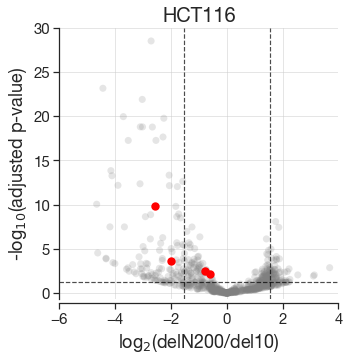

In [335]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.set_xlim(-6,4)
ax.set_ylim(-0.7,30)
ax.plot([log2FC_cutoff, log2FC_cutoff], ax.get_ylim(),c='black', alpha=0.7, ls='--', linewidth=1.2)
ax.plot([-log2FC_cutoff, -log2FC_cutoff], ax.get_ylim(),c='black', alpha=0.7, ls='--', linewidth=1.2)
ax.plot(ax.get_xlim(),[-np.log10(0.05), -np.log10(0.05)],c='black', alpha=0.7, ls='--', linewidth=1.2)

allmiRNA = ax.scatter(w_spikeIn_info["log2FoldChange"], -np.log10(w_spikeIn_info["padj"]), s=50, c='grey', alpha=0.2, edgecolors='none')
ax.scatter(w_spikeIn_info.loc[['hsa-miR-19a-3p', 'hsa-miR-15a-5p', 'hsa-miR-25-3p', 'hsa-miR-221-3p'], "log2FoldChange"], \
          -np.log10(w_spikeIn_info.loc[['hsa-miR-19a-3p', 'hsa-miR-15a-5p', 'hsa-miR-25-3p', 'hsa-miR-221-3p'], "padj"]), \
                    s=70, c='red', edgecolors=['none'])
ax.set_xlabel("log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax.set_ylabel("-log$_1$$_0$(adjusted p-value)", fontproperties=helvetica_18)
# ax.legend((DD, Mirtron, Capped, tRNA_snoRNA), ("DROSHA-dependent", "Mirtron", "Capped miRNA", "tRNA, snoRNA-derived miRNA"), \
#           frameon=False, bbox_to_anchor=(2,1), loc='upper right', scatterpoints=1, fontsize=15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)
ax.spines['bottom'].set_position(('outward', 4))

ax.set_title("HCT116", fontproperties=helvetica_20)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

fig.show()
#plt.savefig("Results/201014-data-target-HCT116.pdf", bbox_inches='tight')

del allmiRNA

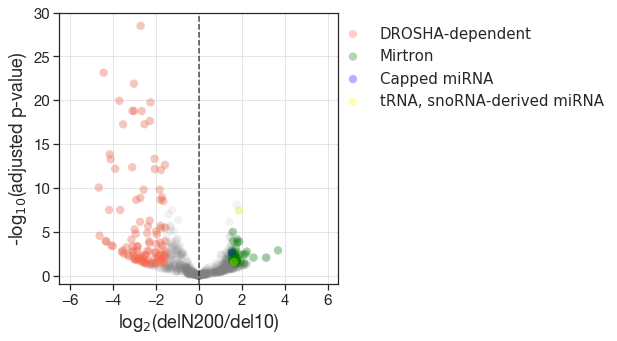

In [403]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

allmiRNA = ax.scatter(w_spikeIn_info["log2FoldChange"], -np.log10(w_spikeIn_info["padj"]), s=70, c='grey', alpha=0.1, edgecolors='none')
DD = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["log2FoldChange"], \
                -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["padj"]),\
                c='tomato', alpha=0.3, s=70, edgecolors='none')
Mirtron = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="Mirtron"]["log2FoldChange"], \
                     -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="Mirtron"]["padj"]),\
                     c='green', alpha=0.3, s=70, edgecolors='none')
Capped = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="Capped miRNA"]["log2FoldChange"], \
                    -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="Capped miRNA"]["padj"]),\
                    c='blue', alpha=0.3, s=70, edgecolors='none')
tRNA_snoRNA = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"].isin(['SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["log2FoldChange"], \
                         -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"].isin(['SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["padj"]),\
                         c='yellow', alpha=0.3, s=70, edgecolors='none')

ax.set_xlim(-6.5,6.5)
ax.set_ylim(-1,30)
ax.plot([0,0], ax.get_ylim(),c='black', alpha=0.7, ls='--')
ax.set_xlabel("log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax.set_ylabel("-log$_1$$_0$(adjusted p-value)", fontproperties=helvetica_18)
ax.legend((DD, Mirtron, Capped, tRNA_snoRNA), ("DROSHA-dependent", "Mirtron", "Capped miRNA", "tRNA, snoRNA-derived miRNA"), \
          frameon=False, bbox_to_anchor=(2,1), loc='upper right', scatterpoints=1, fontsize=15)

ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)


for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

fig.show()
#plt.savefig("Results/200730_HCT116_volcano.png", bbox_inches='tight')
#plt.savefig("Results/200730_HCT116_volcano.pdf", bbox_inches='tight')

del allmiRNA, DD, Mirtron, Capped, tRNA_snoRNA

In [13]:
w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"] == "DROSHA-dependent"].head()

baseMean  log2FoldChange      stat        pvalue  \
mature                                                                 
hsa-let-7d-3p     205.664358       -2.068898 -8.038121  9.122686e-16   
hsa-let-7d-5p    2176.275816       -1.795197 -6.489938  8.587147e-11   
hsa-let-7f-1-3p    35.901097       -2.316358 -4.247800  2.158802e-05   
hsa-miR-1180-3p   187.793940       -2.670234 -9.497589  2.148065e-21   
hsa-miR-1180-5p     6.038618       -2.185386 -2.388105  1.693552e-02   

                         padj curated DROSHA dependency (HCT116)  
mature                                                            
hsa-let-7d-3p    4.782894e-14                   DROSHA-dependent  
hsa-let-7d-5p    2.334432e-09                   DROSHA-dependent  
hsa-let-7f-1-3p  2.057871e-04                   DROSHA-dependent  
hsa-miR-1180-3p  1.751867e-19                   DROSHA-dependent  
hsa-miR-1180-5p  4.361639e-02                   DROSHA-dependent

In [364]:
#w_spikeIn_sig.to_csv("Results/norm_w_spikeIn_sig.csv")
#w_spikeIn_info.to_csv("Results/norm_w_spikeIn_all.csv")

#### MA plot

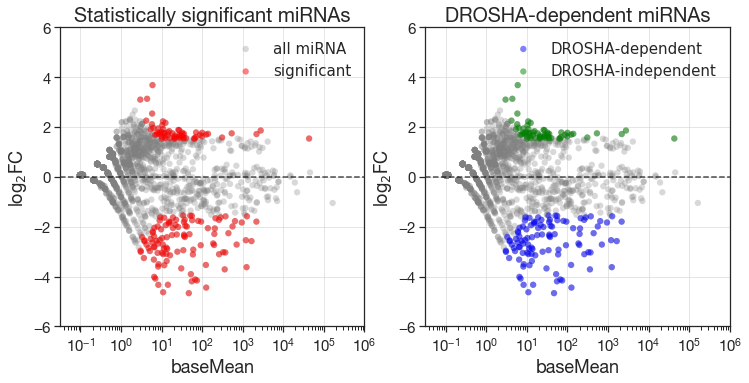

In [404]:
fig, ax = plt.subplots(1,2,figsize=(12,5.5))

# ax[0]

allmiRNA = ax[0].scatter(w_spikeIn_info["baseMean"], w_spikeIn_info["log2FoldChange"], s=40, c="grey", alpha= 0.3, edgecolors='none')
sig = ax[0].scatter(w_spikeIn_sig["baseMean"], w_spikeIn_sig["log2FoldChange"], s=40, c="red", alpha= 0.5, edgecolors='none')
ax[0].set_xscale('log')
ax[0].set_ylim(-6,6)
ax[0].set_xlim(10**-1.5,10**6)
ax[0].plot(ax[0].get_xlim(), [0,0], c='black', alpha=0.7,ls='--')

ax[0].set_xlabel("baseMean", fontproperties=helvetica_18)
ax[0].set_ylabel("log$_2$FC", fontproperties=helvetica_18)
ax[0].legend((allmiRNA, sig), ("all miRNA", "significant"), frameon=False, fontsize=15, scatterpoints=1)
ax[0].set_title("Statistically significant miRNAs", fontproperties=helvetica_20)

ax[0].grid(axis='y', alpha=0.5)
ax[0].grid(axis='x', alpha=0.5)

for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)


# ax[1]

allmiRNA = ax[1].scatter(w_spikeIn_info["baseMean"], w_spikeIn_info["log2FoldChange"], s=40, c="grey", alpha= 0.3, edgecolors='none')
DD = ax[1].scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["baseMean"],\
                   w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["log2FoldChange"],c='blue', s=40, alpha=0.5, edgecolors='none')
DI = ax[1].scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]!="DROSHA-dependent"]["baseMean"],\
                   w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]!="DROSHA-dependent"]["log2FoldChange"],c='green', s=40, alpha=0.5, edgecolors='none')


ax[1].set_xscale('log')
ax[1].set_ylim(-6,6)
ax[1].set_xlim(10**-1.5,10**6)
ax[1].plot(ax[0].get_xlim(), [0,0], c='black', alpha=0.7, ls='--')

ax[1].set_xlabel("baseMean", fontproperties=helvetica_18)
ax[1].set_ylabel("log$_2$FC", fontproperties=helvetica_18)
ax[1].legend((DD, DI), ("DROSHA-dependent","DROSHA-independent"), scatterpoints=1, frameon=False, fontsize=15)
ax[1].set_title("DROSHA-dependent miRNAs", fontproperties=helvetica_20)

ax[1].grid(axis='y', alpha=0.5)
ax[1].grid(axis='x', alpha=0.5)

for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

#fig.suptitle("MA plot \n",fontproperties=helvetica_20)
fig.show()
#plt.savefig("Results/200730_HCT116_MA.png", bbox_inches='tight')

del allmiRNA, sig, DD, DI

For figure (combine DROSHA-independent miRNAs)

In [171]:
pseudocount = 1

fig, ax = plt.subplots(1,1,figsize=(4,4))

ax.set_ylim(-5.5,5.5)
ax.set_xlim(-0.5,6)
ax.plot(ax.get_xlim(), [0,0], c='black', alpha=0.7, linewidth=1.2, ls='--')

allmiRNA = ax.scatter(np.log10(w_spikeIn_info["baseMean"] + pseudocount), w_spikeIn_info["log2FoldChange"],  s=50, c='grey', alpha=0.1, edgecolors='none')
DD = ax.scatter(np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["baseMean"]+ pseudocount),\
                w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["log2FoldChange"],\
                c='#d95f02', alpha=0.6, s=50, edgecolors='none')
MCSnoT = ax.scatter(np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"].isin(['Capped miRNA', "Mirtron", 'SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["baseMean"]+ pseudocount),\
                    w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"].isin(['Capped miRNA', "Mirtron", 'SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["log2FoldChange"],\
                    c='#1b9e77', alpha=0.6, s=50, edgecolors='none')

ax.set_xlabel("log$_1$$_0$baseMean", fontsize=18)
ax.set_ylabel("log$_2$FoldChange", fontsize=18)
ax.legend((DD, MCSnoT), ("DROSHA-dependent","Mirtron/Capped/tRNA/snoRNA-derived miRNA"), scatterpoints=1, fontsize=15,\
         bbox_to_anchor=(2.8,1), loc='upper right')
ax.set_title("HCT116", fontsize=20)

ax.grid(axis='y', alpha=0.3)
ax.grid(axis='x', alpha=0.3)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontsize(15)

fig.show()
#plt.savefig("Results/Figures/201208-HCT116-MAplot.pdf", bbox_inches='tight')

del allmiRNA, DD, MCSnoT

---
### Mature 5p 3p correlation 

Classify 5p 3p and choose major strand

In [15]:
w_spikeIn_info.head()

baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                        
hsa-let-7a-2-3p     52.394713       -0.901333 -2.165859  0.030322  0.066836   
hsa-let-7a-3p      410.786354       -0.089378 -0.436403  0.662545  0.740194   
hsa-let-7a-5p    15216.651736        0.009163  0.047385  0.962207  0.982280   
hsa-let-7b-3p      113.500150       -0.583679 -2.091957  0.036442  0.076425   
hsa-let-7b-5p     3288.216511       -0.136267 -0.518374  0.604197  0.691858   

                curated DROSHA dependency (HCT116)  
mature                                              
hsa-let-7a-2-3p                   DROSHA-dependent  
hsa-let-7a-3p                     DROSHA-dependent  
hsa-let-7a-5p                     DROSHA-dependent  
hsa-let-7b-3p                     DROSHA-dependent  
hsa-let-7b-5p                     DROSHA-dependent

In [16]:
for row in w_spikeIn_info.index:
    ### 5p 3p
    if row[-2:] == "5p":
        w_spikeIn_info.loc[row,"5p3p"] = '5p'
    if row[-2:] == "3p":
        w_spikeIn_info.loc[row,"5p3p"] = '3p'

w_spikeIn_info.head()

baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                        
hsa-let-7a-2-3p     52.394713       -0.901333 -2.165859  0.030322  0.066836   
hsa-let-7a-3p      410.786354       -0.089378 -0.436403  0.662545  0.740194   
hsa-let-7a-5p    15216.651736        0.009163  0.047385  0.962207  0.982280   
hsa-let-7b-3p      113.500150       -0.583679 -2.091957  0.036442  0.076425   
hsa-let-7b-5p     3288.216511       -0.136267 -0.518374  0.604197  0.691858   

                curated DROSHA dependency (HCT116) 5p3p  
mature                                                   
hsa-let-7a-2-3p                   DROSHA-dependent   3p  
hsa-let-7a-3p                     DROSHA-dependent   3p  
hsa-let-7a-5p                     DROSHA-dependent   5p  
hsa-let-7b-3p                     DROSHA-dependent   3p  
hsa-let-7b-5p                     DROSHA-dependent   5p

In [17]:
tmp = w_spikeIn_info[(w_spikeIn_info.index.str[-3:].isin(['-3p', '-5p'])) & (w_spikeIn_info["curated DROSHA dependency (HCT116)"] == "DROSHA-dependent")]
tmp.head()

baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                        
hsa-let-7a-2-3p     52.394713       -0.901333 -2.165859  0.030322  0.066836   
hsa-let-7a-3p      410.786354       -0.089378 -0.436403  0.662545  0.740194   
hsa-let-7a-5p    15216.651736        0.009163  0.047385  0.962207  0.982280   
hsa-let-7b-3p      113.500150       -0.583679 -2.091957  0.036442  0.076425   
hsa-let-7b-5p     3288.216511       -0.136267 -0.518374  0.604197  0.691858   

                curated DROSHA dependency (HCT116) 5p3p  
mature                                                   
hsa-let-7a-2-3p                   DROSHA-dependent   3p  
hsa-let-7a-3p                     DROSHA-dependent   3p  
hsa-let-7a-5p                     DROSHA-dependent   5p  
hsa-let-7b-3p                     DROSHA-dependent   3p  
hsa-let-7b-5p                     DROSHA-dependent   5p

In [18]:
df_5p3p = pd.DataFrame(index=tmp.index.str[:-3])
df_5p3p.reset_index(inplace=True)
df_5p3p.rename(columns={'mature': 'pri-miRNA'}, inplace=True)
df_5p3p.set_index("pri-miRNA", inplace=True)
df_5p3p.head()

Empty DataFrame
Columns: []
Index: [hsa-let-7a-2, hsa-let-7a, hsa-let-7a, hsa-let-7b, hsa-let-7b]

In [19]:
for row in tmp.index:
    if row[-3:] =='-3p':
        df_5p3p.loc[row[:-3],'3p_baseMean'] = tmp.loc[row, 'baseMean']
        df_5p3p.loc[row[:-3],'3p_log2FoldChange'] = tmp.loc[row, 'log2FoldChange']
    elif row[-3:] =='-5p':
        df_5p3p.loc[row[:-3],'5p_baseMean'] = tmp.loc[row, 'baseMean']
        df_5p3p.loc[row[:-3],'5p_log2FoldChange'] = tmp.loc[row, 'log2FoldChange']
        
df_5p3p.head()

3p_baseMean  3p_log2FoldChange   5p_baseMean  5p_log2FoldChange
pri-miRNA                                                                    
hsa-let-7a-2    52.394713          -0.901333           NaN                NaN
hsa-let-7a     410.786354          -0.089378  15216.651736           0.009163
hsa-let-7a     410.786354          -0.089378  15216.651736           0.009163
hsa-let-7b     113.500150          -0.583679   3288.216511          -0.136267
hsa-let-7b     113.500150          -0.583679   3288.216511          -0.136267

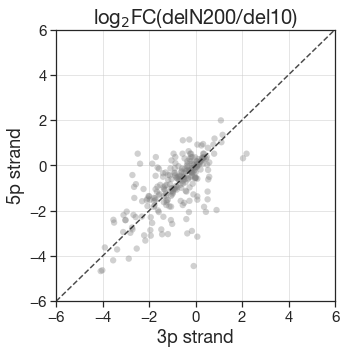

In [20]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.set_ylim(-6,6)
ax.set_xlim(-6,6)
ax.plot(ax.get_xlim(), ax.get_ylim(), c='black', alpha=0.7, ls='--')
ax.scatter(df_5p3p["3p_log2FoldChange"], df_5p3p["5p_log2FoldChange"], s=40, c='grey', alpha=0.2, edgecolors='none')

ax.set_xlabel("3p strand", fontproperties=helvetica_18)
ax.set_ylabel("5p strand", fontproperties=helvetica_18)
ax.set_title("log$_2$FC(delN200/del10)", fontproperties=helvetica_20)

ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

plt.show()

--- 

### See the characteristics of each pri-miRNA

In [300]:
pri_info = pd.read_csv("../../work/190905_sRNA_HCT116_rescue_set_3/190712_pri-info_BK.csv", sep = ',')

pri_info.columns = ["pri-miRNA", "stem length", "loop", "simple loop", "UG", "CNNC", "UGU"]

pri_info["UG"] = np.where(pri_info["UG"] == "-", "NoUG", "UG")
pri_info["UGU"] = np.where(pri_info["UGU"] == "-", "NoUGU", "UGU")
pri_info["CNNC"] = np.where(pri_info["CNNC"] == "-", "NoCNNC", "CNNC")

print(pri_info.shape)
pri_info.head()

(401, 7)


pri-miRNA  stem length  loop  simple loop    UG    CNNC    UGU
0  hsa-let-7a-1           36    27            4  NoUG  NoCNNC  NoUGU
1  hsa-let-7a-2           36    21           21    UG    CNNC  NoUGU
2  hsa-let-7a-3           35    24            3    UG    CNNC  NoUGU
3    hsa-let-7b           34    30            7  NoUG  NoCNNC  NoUGU
4    hsa-let-7c           37    21           21    UG  NoCNNC  NoUGU

In [301]:
mature_info = pd.read_table("200326_curated_hg38_mature_miRNA_classification.txt")
mature_info.head()

mature miRNA   Chr  mature Start  mature End strand       pri miRNA  \
0  hsa-miR-6859-5p  chr1         17409       17431      -  hsa-mir-6859-1   
1  hsa-miR-6859-3p  chr1         17369       17391      -  hsa-mir-6859-1   
2     hsa-miR-1302  chr1         30438       30458      +  hsa-mir-1302-2   
3  hsa-miR-6859-5p  chr1        187931      187953      -  hsa-mir-6859-2   
4  hsa-miR-6859-3p  chr1        187891      187913      -  hsa-mir-6859-2   

   pri Start  pri End DROSHA dependency    Clustered       Locus Exon_Intron  \
0      17369    17436  DROSHA-dependent  independent  intergenic  intergenic   
1      17369    17436  DROSHA-dependent  independent  intergenic  intergenic   
2      30366    30503  DROSHA-dependent  independent  intergenic  intergenic   
3     187891   187958  DROSHA-dependent  independent  intergenic  intergenic   
4     187891   187958  DROSHA-dependent  independent  intergenic  intergenic   

  HostGene Direction curated DROSHA dependency (HCT116)  
0        0         0                                NaN  
1        0         0                                NaN  
2        0         0                                NaN  
3        0         0                                NaN  
4        0         0                                NaN

In [302]:
mature_info = mature_info[["mature miRNA","Chr","pri Start", "pri End", "strand", "pri miRNA","Clustered", "Locus", "Exon_Intron", "HostGene", "Direction"]]
print(mature_info.shape)
mature_info[mature_info["mature miRNA"] == 'hsa-miR-941']

(2813, 11)


mature miRNA    Chr  pri Start   pri End strand      pri miRNA  \
1705  hsa-miR-941  chr20   63919449  63919520      +  hsa-mir-941-1   
1706  hsa-miR-941  chr20   63919505  63919576      +  hsa-mir-941-2   
1707  hsa-miR-941  chr20   63919561  63919632      +  hsa-mir-941-3   
1708  hsa-miR-941  chr20   63919756  63919827      +  hsa-mir-941-4   
1709  hsa-miR-941  chr20   63919868  63919939      +  hsa-mir-941-5   

      Clustered       Locus Exon_Intron HostGene Direction  
1705  clustered  intragenic      exonic   DNAJC5        ++  
1706  clustered  intragenic      exonic   DNAJC5        ++  
1707  clustered  intragenic      exonic   DNAJC5        ++  
1708  clustered  intragenic      exonic   DNAJC5        ++  
1709  clustered  intragenic      exonic   DNAJC5        ++

In [303]:
unique_mature_info = mature_info.drop_duplicates("mature miRNA", keep = False)
unique_mature_info[unique_mature_info["mature miRNA"] == 'hsa-miR-941']

Empty DataFrame
Columns: [mature miRNA, Chr, pri Start, pri End, strand, pri miRNA, Clustered, Locus, Exon_Intron, HostGene, Direction]
Index: []

In [304]:
unique_mature_info.head()

mature miRNA   Chr  pri Start  pri End strand     pri miRNA  \
5  hsa-miR-6723-5p  chr1     632325   632413      -  hsa-mir-6723   
6  hsa-miR-200b-5p  chr1    1167104  1167198      +  hsa-mir-200b   
7  hsa-miR-200b-3p  chr1    1167104  1167198      +  hsa-mir-200b   
8  hsa-miR-200a-5p  chr1    1167863  1167952      +  hsa-mir-200a   
9  hsa-miR-200a-3p  chr1    1167863  1167952      +  hsa-mir-200a   

     Clustered       Locus Exon_Intron HostGene Direction  
5  independent  intergenic  intergenic        0         0  
6    clustered  intergenic  intergenic        0         0  
7    clustered  intergenic  intergenic        0         0  
8    clustered  intergenic  intergenic        0         0  
9    clustered  intergenic  intergenic        0         0

In [305]:
all_info = \
unique_mature_info.set_index("pri miRNA").join(pri_info.set_index("pri-miRNA")).reset_index().rename(columns={'index':'pri-miRNA'}).set_index("mature miRNA")
print(all_info.shape)
all_info.head()

(2421, 16)


pri-miRNA    Chr  pri Start    pri End strand  Clustered  \
mature miRNA                                                                   
hsa-let-7a-2-3p  hsa-let-7a-2  chr11  122146522  122146593      -  clustered   
hsa-let-7b-5p      hsa-let-7b  chr22   46113686   46113768      +  clustered   
hsa-let-7b-3p      hsa-let-7b  chr22   46113686   46113768      +  clustered   
hsa-let-7c-5p      hsa-let-7c  chr21   16539828   16539911      +  clustered   
hsa-let-7c-3p      hsa-let-7c  chr21   16539828   16539911      +  clustered   

                      Locus Exon_Intron HostGene Direction  stem length  loop  \
mature miRNA                                                                    
hsa-let-7a-2-3p  intergenic  intergenic        0         0         36.0  21.0   
hsa-let-7b-5p    intergenic  intergenic        0         0         34.0  30.0   
hsa-let-7b-3p    intergenic  intergenic        0         0         34.0  30.0   
hsa-let-7c-5p    intergenic  intergenic        0         0         37.0  21.0   
hsa-let-7c-3p    intergenic  intergenic        0         0         37.0  21.0   

                 simple loop    UG    CNNC    UGU  
mature miRNA                                       
hsa-let-7a-2-3p         21.0    UG    CNNC  NoUGU  
hsa-let-7b-5p            7.0  NoUG  NoCNNC  NoUGU  
hsa-let-7b-3p            7.0  NoUG  NoCNNC  NoUGU  
hsa-let-7c-5p           21.0    UG  NoCNNC  NoUGU  
hsa-let-7c-3p           21.0    UG  NoCNNC  NoUGU

Merge w_spikeIn_info with all_info dataframe 

In [306]:
feature_all = w_spikeIn_info.join(all_info, how="left")
feature_sig = w_spikeIn_sig.join(all_info, how='left')
print(feature_sig.shape)
feature_sig.head()

(167, 22)


baseMean  log2FoldChange      stat        pvalue  \
mature                                                                 
hsa-let-7d-3p     205.664358       -2.068898 -8.038121  9.122686e-16   
hsa-let-7d-5p    2176.275816       -1.795197 -6.489938  8.587147e-11   
hsa-let-7f-1-3p    35.901097       -2.316358 -4.247800  2.158802e-05   
hsa-miR-1180-3p   187.793940       -2.670234 -9.497589  2.148065e-21   
hsa-miR-1180-5p     6.038618       -2.185386 -2.388105  1.693552e-02   

                         padj curated DROSHA dependency (HCT116)  \
mature                                                             
hsa-let-7d-3p    4.782894e-14                   DROSHA-dependent   
hsa-let-7d-5p    2.334432e-09                   DROSHA-dependent   
hsa-let-7f-1-3p  2.057871e-04                   DROSHA-dependent   
hsa-miR-1180-3p  1.751867e-19                   DROSHA-dependent   
hsa-miR-1180-5p  4.361639e-02                   DROSHA-dependent   

                    pri-miRNA    Chr   pri Start     pri End  ...    \
mature                                                        ...     
hsa-let-7d-3p      hsa-let-7d   chr9  94178834.0  94178920.0  ...     
hsa-let-7d-5p      hsa-let-7d   chr9  94178834.0  94178920.0  ...     
hsa-let-7f-1-3p  hsa-let-7f-1   chr9  94176347.0  94176433.0  ...     
hsa-miR-1180-3p  hsa-mir-1180  chr17  19344506.0  19344574.0  ...     
hsa-miR-1180-5p  hsa-mir-1180  chr17  19344506.0  19344574.0  ...     

                      Locus Exon_Intron HostGene Direction stem length  loop  \
mature                                                                         
hsa-let-7d-3p    intergenic  intergenic        0         0         NaN   NaN   
hsa-let-7d-5p    intergenic  intergenic        0         0         NaN   NaN   
hsa-let-7f-1-3p  intergenic  intergenic        0         0        34.0  30.0   
hsa-miR-1180-3p  intragenic    intronic     B9D1        --        35.0  11.0   
hsa-miR-1180-5p  intragenic    intronic     B9D1        --        35.0  11.0   

                 simple loop    UG  CNNC    UGU  
mature                                           
hsa-let-7d-3p            NaN   NaN   NaN    NaN  
hsa-let-7d-5p            NaN   NaN   NaN    NaN  
hsa-let-7f-1-3p          5.0  NoUG  CNNC    UGU  
hsa-miR-1180-3p         11.0  NoUG  CNNC  NoUGU  
hsa-miR-1180-5p         11.0  NoUG  CNNC  NoUGU  

[5 rows x 22 columns]

In [307]:
feature_all["curated DROSHA dependency (HCT116)"].isna().sum()

790

In [308]:
feature_all["curated DROSHA dependency (HCT116)"].value_counts()

DROSHA-dependent        607
Mirtron                 426
SnoRNA-derived miRNA      9
Capped miRNA              8
tRNA-related miRNA        1
Name: curated DROSHA dependency (HCT116), dtype: int64

In [309]:
del curated_dependency, unique_mature_info ,all_info, w_spikeIn, w_spikeIn_info, w_spikeIn_sig, wo_spikeIn, wo_spikeIn_info

### UG, UGU, CNNC 

Comparing primary motifs among DROSHA-dependent miRNAs

In [310]:
DD = feature_all[feature_all["curated DROSHA dependency (HCT116)"] == "DROSHA-dependent"]
print(DD.shape)
DD.head()

(607, 22)


baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                        
hsa-let-7a-2-3p     52.394713       -0.901333 -2.165859  0.030322  0.066836   
hsa-let-7a-3p      410.786354       -0.089378 -0.436403  0.662545  0.740194   
hsa-let-7a-5p    15216.651736        0.009163  0.047385  0.962207  0.982280   
hsa-let-7b-3p      113.500150       -0.583679 -2.091957  0.036442  0.076425   
hsa-let-7b-5p     3288.216511       -0.136267 -0.518374  0.604197  0.691858   

                curated DROSHA dependency (HCT116)     pri-miRNA    Chr  \
mature                                                                    
hsa-let-7a-2-3p                   DROSHA-dependent  hsa-let-7a-2  chr11   
hsa-let-7a-3p                     DROSHA-dependent           NaN    NaN   
hsa-let-7a-5p                     DROSHA-dependent           NaN    NaN   
hsa-let-7b-3p                     DROSHA-dependent    hsa-let-7b  chr22   
hsa-let-7b-5p                     DROSHA-dependent    hsa-let-7b  chr22   

                   pri Start      pri End  ...         Locus Exon_Intron  \
mature                                     ...                             
hsa-let-7a-2-3p  122146522.0  122146593.0  ...    intergenic  intergenic   
hsa-let-7a-3p            NaN          NaN  ...           NaN         NaN   
hsa-let-7a-5p            NaN          NaN  ...           NaN         NaN   
hsa-let-7b-3p     46113686.0   46113768.0  ...    intergenic  intergenic   
hsa-let-7b-5p     46113686.0   46113768.0  ...    intergenic  intergenic   

                HostGene Direction stem length  loop  simple loop    UG  \
mature                                                                    
hsa-let-7a-2-3p        0         0        36.0  21.0         21.0    UG   
hsa-let-7a-3p        NaN       NaN         NaN   NaN          NaN   NaN   
hsa-let-7a-5p        NaN       NaN         NaN   NaN          NaN   NaN   
hsa-let-7b-3p          0         0        34.0  30.0          7.0  NoUG   
hsa-let-7b-5p          0         0        34.0  30.0          7.0  NoUG   

                   CNNC    UGU  
mature                          
hsa-let-7a-2-3p    CNNC  NoUGU  
hsa-let-7a-3p       NaN    NaN  
hsa-let-7a-5p       NaN    NaN  
hsa-let-7b-3p    NoCNNC  NoUGU  
hsa-let-7b-5p    NoCNNC  NoUGU  

[5 rows x 22 columns]

In [311]:
DI = feature_all[feature_all["curated DROSHA dependency (HCT116)"].isin(["Mirtron","tRNA-related miRNA", "SnoRNA-derived miRNA", "Capped miRNA"])]
print(DI.shape)
DI.head()

(444, 22)


baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                     
hsa-miR-1178-3p   0.525652        1.080482  1.025725  0.305021       NaN   
hsa-miR-1224-3p  15.344812        1.226788  2.194609  0.028192  0.063087   
hsa-miR-1224-5p  71.014052        1.784236  4.301572  0.000017  0.000173   
hsa-miR-1225-3p   1.085852        0.700078  0.628201  0.529873       NaN   
hsa-miR-1225-5p   0.997188        1.048155  0.942176  0.346102       NaN   

                curated DROSHA dependency (HCT116)     pri-miRNA    Chr  \
mature                                                                    
hsa-miR-1178-3p                            Mirtron  hsa-mir-1178  chr12   
hsa-miR-1224-3p                            Mirtron  hsa-mir-1224   chr3   
hsa-miR-1224-5p                            Mirtron  hsa-mir-1224   chr3   
hsa-miR-1225-3p                            Mirtron  hsa-mir-1225  chr16   
hsa-miR-1225-5p                            Mirtron  hsa-mir-1225  chr16   

                   pri Start      pri End ...        Locus Exon_Intron  \
mature                                    ...                            
hsa-miR-1178-3p  119713634.0  119713724.0 ...   intragenic      exonic   
hsa-miR-1224-3p  184241405.0  184241489.0 ...   intragenic    intronic   
hsa-miR-1224-5p  184241405.0  184241489.0 ...   intragenic    intronic   
hsa-miR-1225-3p    2090195.0    2090284.0 ...   intragenic    intronic   
hsa-miR-1225-5p    2090195.0    2090284.0 ...   intragenic    intronic   

                HostGene Direction stem length loop  simple loop   UG  CNNC  \
mature                                                                        
hsa-miR-1178-3p      CIT        --         NaN  NaN          NaN  NaN   NaN   
hsa-miR-1224-3p   VWA5B2        ++         NaN  NaN          NaN  NaN   NaN   
hsa-miR-1224-5p   VWA5B2        ++         NaN  NaN          NaN  NaN   NaN   
hsa-miR-1225-3p     PKD1        --         NaN  NaN          NaN  NaN   NaN   
hsa-miR-1225-5p     PKD1        --         NaN  NaN          NaN  NaN   NaN   

                 UGU  
mature                
hsa-miR-1178-3p  NaN  
hsa-miR-1224-3p  NaN  
hsa-miR-1224-5p  NaN  
hsa-miR-1225-3p  NaN  
hsa-miR-1225-5p  NaN  

[5 rows x 22 columns]

#### Set cut off with baseMean

Take miRNAs with baseMean median

In [313]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].hist(np.log2(DD['baseMean']), bins=20, color='#0504aa',alpha=0.7, rwidth=0.85)
ax[0].grid(axis='y', alpha=0.75)
ax[0].set_xlabel("log$_2$baseMean", fontsize=18)
ax[0].set_ylabel('The number of miRNAs', fontsize=18)
ax[0].set_title('DROSHA-dependent miRNAs \n',fontsize=20)
ax[0].plot((np.log2(10), np.log2(10)), ax[0].get_ylim(), color='grey', alpha=0.7, ls='--')
ax[0].text(10,50,'Median = %.3f'%np.log2(DD['baseMean']).median(), fontsize=15)
ax[0].text(10,46,'Mean = %.3f'%np.log2(DD['baseMean']).mean(), fontsize=15)

for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontsize(15)
    
ax[1].hist(np.log2(DI['baseMean']), bins=20, color='#0504aa',alpha=0.7, rwidth=0.85)
ax[1].grid(axis='y', alpha=0.75)
ax[1].set_xlabel("log$_2$baseMean", fontsize=18)
ax[1].set_ylabel('The number of miRNAs', fontsize=18)
ax[1].set_title('DROSHA-independent miRNAs \n',fontsize=20)
ax[1].plot((np.log2(10), np.log2(10)), ax[1].get_ylim(), color='black', alpha=0.7, ls='--')
ax[1].text(8,65,'Median = %.3f'%np.log2(DI['baseMean']).median(), fontsize=15)
ax[1].text(8,60,'Mean = %.3f'%np.log2(DI['baseMean']).mean(), fontsize=15)

for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontsize(15)
    
fig.show()
#plt.savefig("Results/200730_HCT116_baseMean_dist.png", bbox_inches='tight')

In [328]:
DD_filtered.loc['hsa-miR-627-5p']

baseMean                                       10.9552
log2FoldChange                                 -4.6287
stat                                          -4.73449
pvalue                                     2.19604e-06
padj                                       2.93072e-05
curated DROSHA dependency (HCT116)    DROSHA-dependent
pri-miRNA                                  hsa-mir-627
Chr                                              chr15
pri Start                                  4.21996e+07
pri End                                    4.21997e+07
strand                                               -
Clustered                                  independent
Locus                                       intragenic
Exon_Intron                                   intronic
HostGene                                         VPS39
Direction                                           --
stem length                                        NaN
loop                                               NaN
simple loo

In [332]:
DD_filtered = DD[DD['baseMean'] >= 2**3.7 ]
print(DD.shape)
print(DD_filtered.shape)
DD_filtered.head()

(607, 22)
(308, 22)


baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                        
hsa-let-7a-2-3p     52.394713       -0.901333 -2.165859  0.030322  0.066836   
hsa-let-7a-3p      410.786354       -0.089378 -0.436403  0.662545  0.740194   
hsa-let-7a-5p    15216.651736        0.009163  0.047385  0.962207  0.982280   
hsa-let-7b-3p      113.500150       -0.583679 -2.091957  0.036442  0.076425   
hsa-let-7b-5p     3288.216511       -0.136267 -0.518374  0.604197  0.691858   

                curated DROSHA dependency (HCT116)     pri-miRNA    Chr  \
mature                                                                    
hsa-let-7a-2-3p                   DROSHA-dependent  hsa-let-7a-2  chr11   
hsa-let-7a-3p                     DROSHA-dependent           NaN    NaN   
hsa-let-7a-5p                     DROSHA-dependent           NaN    NaN   
hsa-let-7b-3p                     DROSHA-dependent    hsa-let-7b  chr22   
hsa-let-7b-5p                     DROSHA-dependent    hsa-let-7b  chr22   

                   pri Start      pri End  ...         Locus Exon_Intron  \
mature                                     ...                             
hsa-let-7a-2-3p  122146522.0  122146593.0  ...    intergenic  intergenic   
hsa-let-7a-3p            NaN          NaN  ...           NaN         NaN   
hsa-let-7a-5p            NaN          NaN  ...           NaN         NaN   
hsa-let-7b-3p     46113686.0   46113768.0  ...    intergenic  intergenic   
hsa-let-7b-5p     46113686.0   46113768.0  ...    intergenic  intergenic   

                HostGene Direction stem length  loop  simple loop    UG  \
mature                                                                    
hsa-let-7a-2-3p        0         0        36.0  21.0         21.0    UG   
hsa-let-7a-3p        NaN       NaN         NaN   NaN          NaN   NaN   
hsa-let-7a-5p        NaN       NaN         NaN   NaN          NaN   NaN   
hsa-let-7b-3p          0         0        34.0  30.0          7.0  NoUG   
hsa-let-7b-5p          0         0        34.0  30.0          7.0  NoUG   

                   CNNC    UGU  
mature                          
hsa-let-7a-2-3p    CNNC  NoUGU  
hsa-let-7a-3p       NaN    NaN  
hsa-let-7a-5p       NaN    NaN  
hsa-let-7b-3p    NoCNNC  NoUGU  
hsa-let-7b-5p    NoCNNC  NoUGU  

[5 rows x 22 columns]

In [333]:
DI_filtered = DI[DI['baseMean'] >= 2**3.7 ]
print(DI.shape)
print(DI_filtered.shape)
DI_filtered.head()

(444, 22)
(58, 22)


baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                      
hsa-miR-1224-3p   15.344812        1.226788  2.194609  0.028192  0.063087   
hsa-miR-1224-5p   71.014052        1.784236  4.301572  0.000017  0.000173   
hsa-miR-1226-3p  253.509049        1.496756  4.887056  0.000001  0.000014   
hsa-miR-1226-5p   65.553848        1.534704  3.507918  0.000452  0.002492   
hsa-miR-1227-3p   18.933221        1.290160  2.457916  0.013975  0.037711   

                curated DROSHA dependency (HCT116)     pri-miRNA    Chr  \
mature                                                                    
hsa-miR-1224-3p                            Mirtron  hsa-mir-1224   chr3   
hsa-miR-1224-5p                            Mirtron  hsa-mir-1224   chr3   
hsa-miR-1226-3p                            Mirtron  hsa-mir-1226   chr3   
hsa-miR-1226-5p                            Mirtron  hsa-mir-1226   chr3   
hsa-miR-1227-3p                            Mirtron  hsa-mir-1227  chr19   

                   pri Start      pri End ...        Locus Exon_Intron  \
mature                                    ...                            
hsa-miR-1224-3p  184241405.0  184241489.0 ...   intragenic    intronic   
hsa-miR-1224-5p  184241405.0  184241489.0 ...   intragenic    intronic   
hsa-miR-1226-3p   47849555.0   47849629.0 ...   intragenic    intronic   
hsa-miR-1226-5p   47849555.0   47849629.0 ...   intragenic    intronic   
hsa-miR-1227-3p    2234062.0    2234149.0 ...   intragenic    intronic   

                HostGene Direction stem length loop  simple loop   UG  CNNC  \
mature                                                                        
hsa-miR-1224-3p   VWA5B2        ++         NaN  NaN          NaN  NaN   NaN   
hsa-miR-1224-5p   VWA5B2        ++         NaN  NaN          NaN  NaN   NaN   
hsa-miR-1226-3p    DHX30        ++         NaN  NaN          NaN  NaN   NaN   
hsa-miR-1226-5p    DHX30        ++         NaN  NaN          NaN  NaN   NaN   
hsa-miR-1227-3p  PLEKHJ1        --         NaN  NaN          NaN  NaN   NaN   

                 UGU  
mature                
hsa-miR-1224-3p  NaN  
hsa-miR-1224-5p  NaN  
hsa-miR-1226-3p  NaN  
hsa-miR-1226-5p  NaN  
hsa-miR-1227-3p  NaN  

[5 rows x 22 columns]

In [334]:
### For BK and middle check point
#DD_filtered.to_csv("Results/200914_HCT116_DD_filtered.csv")
#DI_filtered.to_csv("Results/200914_HCT116_DI_filtered.csv")
#DD.to_csv("Results/200914_HCT116_DD.csv")
#DI.to_csv("Results/200914_HCT116_DI.csv")

In [28]:
temp_df = DD_filtered[(DD_filtered["Exon_Intron"] == 'intronic')&(DD_filtered["Clustered"] == 'independent')]
print(set(temp_df.index)-set(II_filtered_len.index))

del temp_df

NameError: name 'II_filtered_len' is not defined

#### UG 

Without baseMean filter

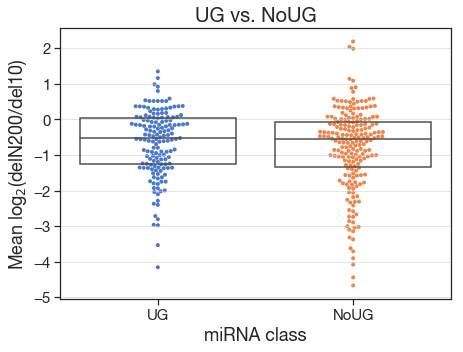

In [35]:
plt.figure(figsize=(7,5))
ax=\
sns.swarmplot(x="UG", y = "log2FoldChange", data=DD, size=4, zorder=0,order=["UG", "NoUG"])
ax=\
sns.boxplot(x='UG', y = "log2FoldChange", data=DD, color='gray', order=['UG','NoUG'], showcaps=False,\
            boxprops={'facecolor':'None'}, showfliers=False,whiskerprops={'linewidth':0})

ax.set_title("UG vs. NoUG", fontproperties=helvetica_20)
ax.set_xlabel("miRNA class", fontproperties=helvetica_18)
ax.set_ylabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5)
    
plt.show()

In [413]:
fig, ax = plt.subplots(1,1, figsize = (6.5,4))

UG = DD[DD["UG"] == "UG"]["log2FoldChange"]
NoUG = DD[DD["UG"] == "NoUG"]["log2FoldChange"]
D_ind = DI["log2FoldChange"]
            
### evaluate the histogram
UG_values , UG_base = np.histogram(UG, bins = len(UG))
NoUG_values , NoUG_base = np.histogram(NoUG, bins = len(NoUG))
D_ind_values, D_ind_base = np.histogram(D_ind, bins = len(D_ind))

### evaluate the cumulative
UG_cumulative = np.cumsum(UG_values) / np.sum(UG_values)
NoUG_cumulative = np.cumsum(NoUG_values) / np.sum(NoUG_values)
D_ind_cumulative = np.cumsum(D_ind_values) / np.sum(D_ind_values)

ax.plot(UG_base[:-1], UG_cumulative, label="UG "+"(n="+str(len(UG))+")")
ax.plot(NoUG_base[:-1], NoUG_cumulative ,label="NoUG "+"(n="+str(len(NoUG))+")")
ax.plot(D_ind_base[:-1], D_ind_cumulative, color="black",alpha=0.7,\
        label="DROSHA-independent "+"(n="+str(len(D_ind))+")")

ax.grid(False)
ax.plot((0,0), (0,1), c="grey", ls='--')
ax.set_xlim(-5,5)
ax.set_ylim(0,1)
ax.set_xlabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax.set_ylabel("Fraction", fontproperties=helvetica_18)
ax.set_title("UG vs. NoUG", fontproperties=helvetica_20)
ax.legend(frameon=False, loc="upper left", fontsize=15)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5)
    
p0 = mannwhitneyu(UG, NoUG, alternative='two-sided')[1]
ax.text(-4,0.5,'p=%.3f'%p0, fontproperties=helvetica_15)
fig.show()

del UG, NoUG, D_ind, UG_values, UG_base, NoUG_values, NoUG_base, D_ind_values, D_ind_base, UG_cumulative, NoUG_cumulative, D_ind_cumulative

With baseMean filter

In [624]:
plt.figure(figsize=(7,5))
ax=\
sns.swarmplot(x="UG", y = "log2FoldChange", data=DD_filtered, size=4, zorder=0,order=["UG", "NoUG"])
ax=\
sns.boxplot(x='UG', y = "log2FoldChange", data=DD_filtered, color='gray', order=['UG','NoUG'], showcaps=False,\
            boxprops={'facecolor':'None'}, showfliers=False,whiskerprops={'linewidth':0})

ax.set_title("UG vs. NoUG", fontproperties=helvetica_20)
ax.set_xlabel("miRNA class", fontproperties=helvetica_18)
ax.set_ylabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5)    

plt.show()

In [486]:
fig, ax = plt.subplots(1,1, figsize = (6.5,4))

UG = DD_filtered[DD_filtered["UG"] == "UG"]["log2FoldChange"]
NoUG = DD_filtered[DD_filtered["UG"] == "NoUG"]["log2FoldChange"]
D_ind = DI_filtered["log2FoldChange"] 

### evaluate the histogram
UG_values , UG_base = np.histogram(UG, bins = len(UG))
NoUG_values , NoUG_base = np.histogram(NoUG, bins = len(NoUG))
D_ind_values, D_ind_base = np.histogram(D_ind, bins = len(D_ind))

### evaluate the cumulative
UG_cumulative = np.cumsum(UG_values) / np.sum(UG_values)
NoUG_cumulative = np.cumsum(NoUG_values) / np.sum(NoUG_values)
D_ind_cumulative = np.cumsum(D_ind_values) / np.sum(D_ind_values)

ax.plot(np.insert(UG_base[:-1],0,UG_base[0]-0.1,axis=0) , np.insert(UG_cumulative,0,0,axis=0), label="UG "+"(n="+str(len(UG))+")", color='darkorange', linewidth=3)
ax.plot(np.insert(NoUG_base[:-1],0,NoUG_base[0]-0.1,axis=0) , np.insert(NoUG_cumulative,0,0,axis=0) ,label="NoUG "+"(n="+str(len(NoUG))+")", color='darkgreen', linewidth=3)
ax.plot(np.insert(D_ind_base[:-1],0,D_ind_base[0]-0.1,axis=0) , np.insert(D_ind_cumulative,0,0,axis=0), color="darkgrey",\
        label="DROSHA-independent "+"(n="+str(len(D_ind))+")", linewidth=3)

ax.grid(False)
#ax.plot((0,0), (0,1), c='black', alpha=0.7, ls='--')
ax.set_xlim(-5,3)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(delN200/del10)", fontsize=18)
ax.set_ylabel("Fraction", fontsize=18)
ax.set_title("UG vs. NoUG", fontsize=20)
ax.legend(frameon=False, loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)
ax.spines['bottom'].set_position(('outward', 4))

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontsize(15)

ax.grid(axis='y', alpha=0.5)
    
p0 = mannwhitneyu(UG, NoUG, alternative='two-sided')[1]
ax.text(-4,0.5,'p=%.3f'%p0, fontsize=15)
fig.show()

#plt.savefig("Results/201014-data-UG-HCT116.pdf", bbox_inches='tight')

del UG, NoUG, D_ind, UG_values, UG_base, NoUG_values, NoUG_base, D_ind_values, D_ind_base, UG_cumulative, NoUG_cumulative, D_ind_cumulative

For figure (w/o DROSHA-independent)

In [256]:
fig, ax = plt.subplots(1,1,figsize=(5,3.5))

UG = DD_filtered[DD_filtered["UG"] == "UG"]['log2FoldChange']
NoUG = DD_filtered[DD_filtered["UG"] == "NoUG"]['log2FoldChange']

### evaluate the histogram
UG_values, UG_base = np.histogram(UG, bins = len(UG))
NoUG_values, NoUG_base = np.histogram(NoUG, bins = len(NoUG))

### evaluate cumulative
UG_cumulative = np.cumsum(UG_values) / np.sum(UG_values)
NoUG_cumulative = np.cumsum(NoUG_values) / np.sum(NoUG_values)

ax.plot(np.insert(UG_base[:-1], 0, UG_base[0]-0.1, axis = 0), \
        np.insert(UG_cumulative,0,0, axis=0), label='UG '+'(n='+str(len(UG))+")", \
        color = '#d95f02', linewidth=2.5)
ax.plot(np.insert(NoUG_base[:-1],0,NoUG_base[0]-0.1, axis=0),\
       np.insert(NoUG_cumulative,0,0,axis=0), label="NoUG " + "(n=" +str(len(NoUG))+")",\
       color='#808080', linewidth=2.5)

ax.set_xlim(-5,1.6)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(delN200/del10)", fontsize=18)
ax.set_ylabel("Cumulative fraction", fontsize=18)
ax.set_title("UG", fontsize=20)
ax.legend(frameon=False, loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
    
p0 = mannwhitneyu(UG, NoUG, alternative = 'two-sided')[1]
ax.text(-4,0.5, 'p = %.3f'%p0, fontsize=15)
fig.show()

plt.savefig("Results/Figures/201214-UG-HCT116.pdf", bbox_inches='tight')
del UG, NoUG, UG_values, UG_base, NoUG_values, NoUG_base, UG_cumulative, NoUG_cumulative

#### UGU

Without baseMean filter

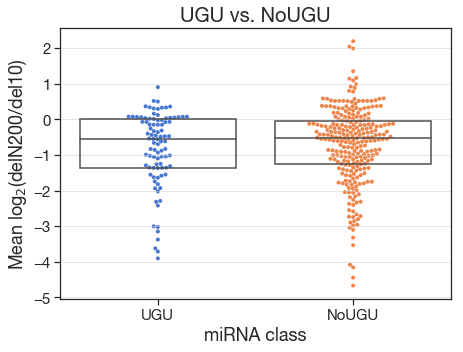

In [626]:
plt.figure(figsize=(7,5))
ax=\
sns.swarmplot(x="UGU", y = "log2FoldChange", data=DD, size=4, zorder=0,order=["UGU", "NoUGU"])
ax=\
sns.boxplot(x='UGU', y = "log2FoldChange", data=DD, color='gray', order=['UGU','NoUGU'], showcaps=False,\
            boxprops={'facecolor':'None'}, showfliers=False,whiskerprops={'linewidth':0})

ax.set_title("UGU vs. NoUGU", fontproperties=helvetica_20)
ax.set_xlabel("miRNA class", fontproperties=helvetica_18)
ax.set_ylabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5) 
    
plt.show()

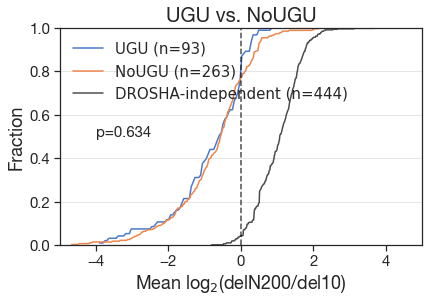

In [415]:
fig, ax = plt.subplots(1,1, figsize = (6.5,4))

UGU = DD[DD["UGU"] == "UGU"]["log2FoldChange"]
NoUGU = DD[DD["UGU"] == "NoUGU"]["log2FoldChange"]
D_ind = DI["log2FoldChange"]
            
### evaluate the histogram
UGU_values , UGU_base = np.histogram(UGU, bins = len(UGU))
NoUGU_values , NoUGU_base = np.histogram(NoUGU, bins = len(NoUGU))
D_ind_values, D_ind_base = np.histogram(D_ind, bins = len(D_ind))

### evaluate the cumulative
UGU_cumulative = np.cumsum(UGU_values) / np.sum(UGU_values)
NoUGU_cumulative = np.cumsum(NoUGU_values) / np.sum(NoUGU_values)
D_ind_cumulative = np.cumsum(D_ind_values) / np.sum(D_ind_values)

ax.plot(UGU_base[:-1], UGU_cumulative, label="UGU "+"(n="+str(len(UGU))+")")
ax.plot(NoUGU_base[:-1], NoUGU_cumulative ,label="NoUGU "+"(n="+str(len(NoUGU))+")")
ax.plot(D_ind_base[:-1], D_ind_cumulative, color="black",alpha=0.7,\
        label="DROSHA-independent "+"(n="+str(len(D_ind))+")")

ax.grid(False)
ax.plot((0,0), (0,1), c='black', alpha=0.7, ls='--')
ax.set_xlim(-5,5)
ax.set_ylim(0,1)
ax.set_xlabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax.set_ylabel("Fraction", fontproperties=helvetica_18)
ax.set_title("UGU vs. NoUGU", fontproperties=helvetica_20)
ax.legend(frameon=False, loc="upper left", fontsize=15)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5) 

p0 = mannwhitneyu(UGU, NoUGU, alternative='two-sided')[1]
ax.text(-4,0.5,'p=%.3f'%p0, fontproperties=helvetica_15)
fig.show()


del UGU, NoUGU, D_ind, UGU_values, UGU_base, NoUGU_values, NoUGU_base, D_ind_values, D_ind_base, UGU_cumulative, NoUGU_cumulative, D_ind_cumulative

With baseMean filter

In [628]:
plt.figure(figsize=(7,5))
ax=\
sns.swarmplot(x="UGU", y = "log2FoldChange", data=DD_filtered, size=4, zorder=0,order=["UGU", "NoUGU"])
ax=\
sns.boxplot(x='UGU', y = "log2FoldChange", data=DD_filtered, color='gray', order=['UGU','NoUGU'], showcaps=False,\
            boxprops={'facecolor':'None'}, showfliers=False,whiskerprops={'linewidth':0})

ax.set_title("UGU vs. NoUGU", fontproperties=helvetica_20)
ax.set_xlabel("miRNA class", fontproperties=helvetica_18)
ax.set_ylabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5)
    
plt.show()

In [435]:
fig, ax = plt.subplots(1,1, figsize = (6.5,4))

UGU = DD_filtered[DD_filtered["UGU"] == "UGU"]["log2FoldChange"]
NoUGU = DD_filtered[DD_filtered["UGU"] == "NoUGU"]["log2FoldChange"]
D_ind = DI_filtered["log2FoldChange"] 

### evaluate the histogram
UGU_values , UGU_base = np.histogram(UGU, bins = len(UGU))
NoUGU_values , NoUGU_base = np.histogram(NoUGU, bins = len(NoUGU))
D_ind_values, D_ind_base = np.histogram(D_ind, bins = len(D_ind))

### evaluate the cumulative
UGU_cumulative = np.cumsum(UGU_values) / np.sum(UGU_values)
NoUGU_cumulative = np.cumsum(NoUGU_values) / np.sum(NoUGU_values)
D_ind_cumulative = np.cumsum(D_ind_values) / np.sum(D_ind_values)

ax.plot(np.insert(UGU_base[:-1],0,UGU_base[0]-0.1,axis=0) , np.insert(UGU_cumulative,0,0,axis=0), label="UGU "+"(n="+str(len(UGU))+")", color='darkorange', linewidth=3)
ax.plot(np.insert(NoUGU_base[:-1],0,NoUGU_base[0]-0.1,axis=0) , np.insert(NoUGU_cumulative,0,0,axis=0) ,label="NoUGU "+"(n="+str(len(NoUGU))+")", color='darkgreen', linewidth=3)
ax.plot(np.insert(D_ind_base[:-1],0,D_ind_base[0]-0.1,axis=0) , np.insert(D_ind_cumulative,0,0,axis=0), color="darkgrey",\
        label="DROSHA-independent "+"(n="+str(len(D_ind))+")", linewidth=3)

ax.grid(False)
#ax.plot((0,0), (0,1), c='black', alpha=0.7, ls='--')
ax.set_xlim(-5,3)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax.set_ylabel("Fraction", fontproperties=helvetica_18)
ax.set_title("UGU vs. NoUGU", fontproperties=helvetica_20)
ax.legend(frameon=False, loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)
ax.spines['bottom'].set_position(('outward', 4))

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5)
    
p0 = mannwhitneyu(UGU, NoUGU, alternative='two-sided')[1]
ax.text(-4,0.5,'p=%.3f'%p0, fontproperties=helvetica_15)
fig.show()

#plt.savefig("Results/201014-data-UGU-HCT116.pdf", bbox_inches='tight')

del UGU, NoUGU, D_ind, UGU_values, UGU_base, NoUGU_values, NoUGU_base, D_ind_values, D_ind_base, UGU_cumulative, NoUGU_cumulative, D_ind_cumulative

For figure

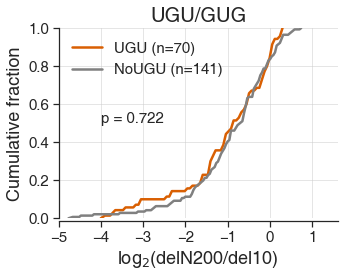

In [255]:
fig, ax = plt.subplots(1,1,figsize=(5,3.5))

UGU = DD_filtered[DD_filtered["UGU"] == "UGU"]['log2FoldChange']
NoUGU = DD_filtered[DD_filtered["UGU"] == "NoUGU"]['log2FoldChange']

### evaluate the histogram
UGU_values, UGU_base = np.histogram(UGU, bins = len(UGU))
NoUGU_values, NoUGU_base = np.histogram(NoUGU, bins = len(NoUGU))

### evaluate cumulative
UGU_cumulative = np.cumsum(UGU_values) / np.sum(UGU_values)
NoUGU_cumulative = np.cumsum(NoUGU_values) / np.sum(NoUGU_values)

ax.plot(np.insert(UGU_base[:-1], 0, UGU_base[0]-0.1, axis = 0), \
        np.insert(UGU_cumulative,0,0, axis=0), label='UGU '+'(n='+str(len(UGU))+")", \
        color = '#d95f02', linewidth=2.5)
ax.plot(np.insert(NoUGU_base[:-1],0,NoUGU_base[0]-0.1, axis=0),\
       np.insert(NoUGU_cumulative,0,0,axis=0), label="NoUGU " + "(n=" +str(len(NoUGU))+")",\
       color='#808080', linewidth=2.5)

ax.set_xlim(-5,1.6)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(delN200/del10)", fontsize=18)
ax.set_ylabel("Cumulative fraction", fontsize=18)
ax.set_title("UGU/GUG", fontsize=20)
ax.legend(frameon=False, loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
    
p0 = mannwhitneyu(UGU, NoUGU, alternative = 'two-sided')[1]
ax.text(-4,0.5, 'p = %.3f'%p0, fontsize=15)
fig.show()

plt.savefig("Results/Figures/201214-UGU-HCT116.pdf", bbox_inches='tight')
del UGU, NoUGU, UGU_values, UGU_base, NoUGU_values, NoUGU_base, UGU_cumulative, NoUGU_cumulative

#### CNNC

Without baseMean filter

In [630]:
plt.figure(figsize=(7,5))
ax=\
sns.swarmplot(x="CNNC", y = "log2FoldChange", data=DD, size=4, zorder=0,order=["CNNC", "NoCNNC"])
ax=\
sns.boxplot(x='CNNC', y = "log2FoldChange", data=DD, color='gray', order=['CNNC','NoCNNC'], showcaps=False,\
            boxprops={'facecolor':'None'}, showfliers=False,whiskerprops={'linewidth':0})

ax.set_title("CNNC vs. NoCNNC", fontproperties=helvetica_20)
ax.set_xlabel("miRNA class", fontproperties=helvetica_18)
ax.set_ylabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5)    

plt.show()

In [418]:
fig, ax = plt.subplots(1,1, figsize = (6.5,4))

CNNC = DD[DD["CNNC"] == "CNNC"]["log2FoldChange"]
NoCNNC = DD[DD["CNNC"] == "NoCNNC"]["log2FoldChange"]
D_ind = DI["log2FoldChange"]
            
### evaluate the histogram
CNNC_values , CNNC_base = np.histogram(CNNC, bins = len(CNNC))
NoCNNC_values , NoCNNC_base = np.histogram(NoCNNC, bins = len(NoCNNC))
D_ind_values, D_ind_base = np.histogram(D_ind, bins = len(D_ind))

### evaluate the cumulative
CNNC_cumulative = np.cumsum(CNNC_values) / np.sum(CNNC_values)
NoCNNC_cumulative = np.cumsum(NoCNNC_values) / np.sum(NoCNNC_values)
D_ind_cumulative = np.cumsum(D_ind_values) / np.sum(D_ind_values)

ax.plot(CNNC_base[:-1], CNNC_cumulative, label="CNNC "+"(n="+str(len(CNNC))+")")
ax.plot(NoCNNC_base[:-1], NoCNNC_cumulative ,label="NoCNNC "+"(n="+str(len(NoCNNC))+")")
ax.plot(D_ind_base[:-1], D_ind_cumulative, color="black",alpha=0.7,\
        label="DROSHA-independent "+"(n="+str(len(D_ind))+")")

ax.grid(False)
ax.plot((0,0), (0,1), c='black', alpha=0.7, ls='--')
ax.set_xlim(-5,5)
ax.set_ylim(0,1)
ax.set_xlabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax.set_ylabel("Fraction", fontproperties=helvetica_18)
ax.set_title("CNNC vs. NoCNNC", fontproperties=helvetica_20)
ax.legend(frameon=False, loc="upper left", fontsize=15)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5)
    
p0 = mannwhitneyu(CNNC, NoCNNC, alternative='two-sided')[1]
ax.text(-4,0.5,'p=%.3f'%p0, fontproperties=helvetica_15)
fig.show()

del CNNC, NoCNNC, D_ind, CNNC_values, CNNC_base, NoCNNC_values, NoCNNC_base, D_ind_values, D_ind_base, CNNC_cumulative, NoCNNC_cumulative, D_ind_cumulative

With baseMean filter

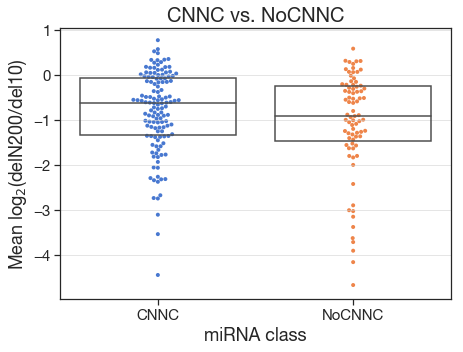

In [632]:
plt.figure(figsize=(7,5))
ax=\
sns.swarmplot(x="CNNC", y = "log2FoldChange", data=DD_filtered, size=4, zorder=0,order=["CNNC", "NoCNNC"])
ax=\
sns.boxplot(x='CNNC', y = "log2FoldChange", data=DD_filtered, color='gray', order=['CNNC','NoCNNC'], showcaps=False,\
            boxprops={'facecolor':'None'}, showfliers=False,whiskerprops={'linewidth':0})

ax.set_title("CNNC vs. NoCNNC", fontproperties=helvetica_20)
ax.set_xlabel("miRNA class", fontproperties=helvetica_18)
ax.set_ylabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5)
    
plt.show()

In [436]:
fig, ax = plt.subplots(1,1, figsize = (6.5,4))

CNNC = DD_filtered[DD_filtered["CNNC"] == "CNNC"]["log2FoldChange"]
NoCNNC = DD_filtered[DD_filtered["CNNC"] == "NoCNNC"]["log2FoldChange"]
D_ind = DI_filtered["log2FoldChange"] 

### evaluate the histogram
CNNC_values , CNNC_base = np.histogram(CNNC, bins = len(CNNC))
NoCNNC_values , NoCNNC_base = np.histogram(NoCNNC, bins = len(NoCNNC))
D_ind_values, D_ind_base = np.histogram(D_ind, bins = len(D_ind))

### evaluate the cumulative
CNNC_cumulative = np.cumsum(CNNC_values) / np.sum(CNNC_values)
NoCNNC_cumulative = np.cumsum(NoCNNC_values) / np.sum(NoCNNC_values)
D_ind_cumulative = np.cumsum(D_ind_values) / np.sum(D_ind_values)

ax.plot(np.insert(CNNC_base[:-1],0,CNNC_base[0]-0.1,axis=0) , np.insert(CNNC_cumulative,0,0,axis=0), label="CNNC "+"(n="+str(len(CNNC))+")", color='darkorange', linewidth=3)
ax.plot(np.insert(NoCNNC_base[:-1],0,NoCNNC_base[0]-0.1,axis=0) , np.insert(NoCNNC_cumulative,0,0,axis=0) ,label="NoCNNC "+"(n="+str(len(NoCNNC))+")", color='darkgreen', linewidth=3)
ax.plot(np.insert(D_ind_base[:-1],0,D_ind_base[0]-0.1,axis=0) , np.insert(D_ind_cumulative,0,0,axis=0), color="darkgrey",\
        label="DROSHA-independent "+"(n="+str(len(D_ind))+")", linewidth=3)

ax.grid(False)
#ax.plot((0,0), (0,1), c='black', alpha=0.7, ls='--')
ax.set_xlim(-5,3)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax.set_ylabel("Fraction", fontproperties=helvetica_18)
ax.set_title("CNNC vs. NoCNNC", fontproperties=helvetica_20)
ax.legend(frameon=False, loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)
ax.spines['bottom'].set_position(('outward', 4))

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5)
    
p0 = mannwhitneyu(CNNC, NoCNNC, alternative='two-sided')[1]
ax.text(-4,0.5,'p=%.3f'%p0, fontproperties=helvetica_15)
fig.show()

#plt.savefig("Results/201014-data-CNNC-HCT116.pdf", bbox_inches='tight')

del CNNC, NoCNNC, D_ind, CNNC_values, CNNC_base, NoCNNC_values, NoCNNC_base, D_ind_values, D_ind_base, CNNC_cumulative, NoCNNC_cumulative, D_ind_cumulative

For figure

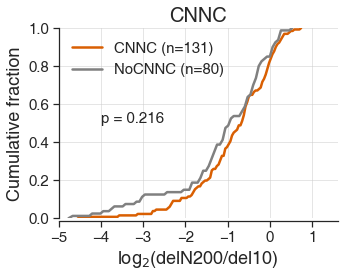

In [254]:
fig, ax = plt.subplots(1,1,figsize=(5,3.5))

CNNC = DD_filtered[DD_filtered["CNNC"] == "CNNC"]['log2FoldChange']
NoCNNC = DD_filtered[DD_filtered["CNNC"] == "NoCNNC"]['log2FoldChange']

### evaluate the histogram
CNNC_values, CNNC_base = np.histogram(CNNC, bins = len(CNNC))
NoCNNC_values, NoCNNC_base = np.histogram(NoCNNC, bins = len(NoCNNC))

### evaluate cumulative
CNNC_cumulative = np.cumsum(CNNC_values) / np.sum(CNNC_values)
NoCNNC_cumulative = np.cumsum(NoCNNC_values) / np.sum(NoCNNC_values)

ax.plot(np.insert(CNNC_base[:-1], 0, CNNC_base[0]-0.1, axis = 0), \
        np.insert(CNNC_cumulative,0,0, axis=0), label='CNNC '+'(n='+str(len(CNNC))+")", \
        color = '#d95f02', linewidth=2.5)
ax.plot(np.insert(NoCNNC_base[:-1],0,NoCNNC_base[0]-0.1, axis=0),\
       np.insert(NoCNNC_cumulative,0,0,axis=0), label="NoCNNC " + "(n=" +str(len(NoCNNC))+")",\
       color='#808080', linewidth=2.5)

ax.set_xlim(-5,1.6)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(delN200/del10)", fontsize=18)
ax.set_ylabel("Cumulative fraction", fontsize=18)
ax.set_title("CNNC", fontsize=20)
ax.legend(frameon=False, loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
    
p0 = mannwhitneyu(CNNC, NoCNNC, alternative = 'two-sided')[1]
ax.text(-4,0.5, 'p = %.3f'%p0, fontsize=15)
fig.show()

plt.savefig("Results/Figures/201214-CNNC-HCT116.pdf", bbox_inches='tight')
del CNNC, NoCNNC, CNNC_values, CNNC_base, NoCNNC_values, NoCNNC_base, CNNC_cumulative, NoCNNC_cumulative

#### mGHG score

Only with baseMean filter

In [242]:
mGHG_df = pd.read_csv('../../work/190905_sRNA_HCT116_rescue_set_3/190712_ghg-score.csv', sep=',')
mGHG_df.columns=['pri-miRNA', 'mGHG score']
mGHG_df.set_index('pri-miRNA', inplace=True)
mGHG_df.dropna(inplace=True)
print(mGHG_df.shape)
mGHG_df.head()

(1060, 1)


mGHG score
pri-miRNA               
hsa-let-7a-1   27.547628
hsa-let-7a-2   43.527528
hsa-let-7a-3   13.121459
hsa-let-7c     23.981603
hsa-let-7d     40.053494

In [243]:
mGHG_DD_filtered = DD_filtered.join(mGHG_df, on='pri-miRNA', how='left').iloc[:,[0,1,2,3,4,5,22]]
mGHG_DD_filtered.dropna(inplace=True)
mGHG_DD_filtered.head()

baseMean  log2FoldChange      stat        pvalue  \
mature                                                                 
hsa-let-7a-2-3p    52.394713       -0.901333 -2.165859  3.032197e-02   
hsa-let-7c-5p      86.709270       -0.235136 -0.698768  4.846967e-01   
hsa-let-7d-3p     205.664358       -2.068898 -8.038121  9.122686e-16   
hsa-let-7d-5p    2176.275816       -1.795197 -6.489938  8.587147e-11   
hsa-let-7e-3p      19.727205       -1.399991 -2.897148  3.765726e-03   

                         padj curated DROSHA dependency (HCT116)  mGHG score  
mature                                                                        
hsa-let-7a-2-3p  6.683580e-02                   DROSHA-dependent   43.527528  
hsa-let-7c-5p    5.822707e-01                   DROSHA-dependent   23.981603  
hsa-let-7d-3p    4.782894e-14                   DROSHA-dependent   40.053494  
hsa-let-7d-5p    2.334432e-09                   DROSHA-dependent   40.053494  
hsa-let-7e-3p    1.279649e-02                   DROSHA-dependent   32.085647

In [244]:
mGHG_DD_filtered["mGHG_group"] = \
pd.qcut(mGHG_DD_filtered["mGHG score"], 3, labels=['Low','Medium','High'])

mGHG_DD_filtered.head()

baseMean  log2FoldChange      stat        pvalue  \
mature                                                                 
hsa-let-7a-2-3p    52.394713       -0.901333 -2.165859  3.032197e-02   
hsa-let-7c-5p      86.709270       -0.235136 -0.698768  4.846967e-01   
hsa-let-7d-3p     205.664358       -2.068898 -8.038121  9.122686e-16   
hsa-let-7d-5p    2176.275816       -1.795197 -6.489938  8.587147e-11   
hsa-let-7e-3p      19.727205       -1.399991 -2.897148  3.765726e-03   

                         padj curated DROSHA dependency (HCT116)  mGHG score  \
mature                                                                         
hsa-let-7a-2-3p  6.683580e-02                   DROSHA-dependent   43.527528   
hsa-let-7c-5p    5.822707e-01                   DROSHA-dependent   23.981603   
hsa-let-7d-3p    4.782894e-14                   DROSHA-dependent   40.053494   
hsa-let-7d-5p    2.334432e-09                   DROSHA-dependent   40.053494   
hsa-let-7e-3p    1.279649e-02                   DROSHA-dependent   32.085647   

                mGHG_group  
mature                      
hsa-let-7a-2-3p     Medium  
hsa-let-7c-5p          Low  
hsa-let-7d-3p       Medium  
hsa-let-7d-5p       Medium  
hsa-let-7e-3p       Medium

In [245]:
fig, ax = plt.subplots(1,1, figsize = (6.5,4))

mGHG_high = mGHG_DD_filtered[mGHG_DD_filtered["mGHG_group"] == "High"]["log2FoldChange"]
mGHG_low = mGHG_DD_filtered[mGHG_DD_filtered["mGHG_group"] == "Low"]["log2FoldChange"]
D_ind = DI_filtered["log2FoldChange"] 

### evaluate the histogram
mGHG_high_values , mGHG_high_base = np.histogram(mGHG_high, bins = len(mGHG_high))
mGHG_low_values , mGHG_low_base = np.histogram(mGHG_low, bins = len(mGHG_low))
D_ind_values, D_ind_base = np.histogram(D_ind, bins = len(D_ind))

### evaluate the cumulative
mGHG_high_cumulative = np.cumsum(mGHG_high_values) / np.sum(mGHG_high_values)
mGHG_low_cumulative = np.cumsum(mGHG_low_values) / np.sum(mGHG_low_values)
D_ind_cumulative = np.cumsum(D_ind_values) / np.sum(D_ind_values)

ax.plot(np.insert(mGHG_high_base[:-1],0,mGHG_high_base[0]-0.1,axis=0), \
        np.insert(mGHG_high_cumulative,0,0,axis=0), label="mGHG_high "+"(n="+str(len(mGHG_high))+")", color='darkorange', linewidth=3)
ax.plot(np.insert(mGHG_low_base[:-1],0,mGHG_low_base[0]-0.1,axis=0), \
        np.insert(mGHG_low_cumulative,0,0,axis=0) ,label="mGHG_low "+"(n="+str(len(mGHG_low))+")", color='darkgreen', linewidth=3)
ax.plot(np.insert(D_ind_base[:-1],0,D_ind_base[0]-0.1,axis=0), np.insert(D_ind_cumulative,0,0,axis=0), \
        color="darkgrey",label="DROSHA-independent "+"(n="+str(len(D_ind))+")", linewidth=3)


ax.set_xlim(-5,3)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(delN200/del10)", fontsize=18)
ax.set_ylabel("Fraction", fontsize=18)
ax.set_title("mGHG score", fontsize=20)
ax.legend(frameon=False, loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)
ax.spines['bottom'].set_position(('outward', 4))

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontsize(15)

ax.grid(axis='y', alpha=0.5)
    
p0 = mannwhitneyu(mGHG_high, mGHG_low, alternative='two-sided')[1]
ax.text(-4,0.5,'p=%.3f'%p0, fontsize=15)
fig.show()

#plt.savefig("Results/201014-data-mGHG-HCT116.pdf", bbox_inches='tight')

# del mGHG_high, mGHG_low, D_ind, mGHG_high_values, mGHG_high_base, mGHG_low_values, mGHG_low_base, D_ind_values, D_ind_base, \
# mGHG_high_cumulative, mGHG_low_cumulative, D_ind_cumulative, mGHG_DD_filtered, mGHG_df

For figure

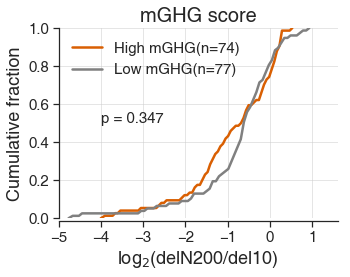

In [253]:
fig, ax = plt.subplots(1,1,figsize=(5,3.5))


mGHG_high = mGHG_DD_filtered[mGHG_DD_filtered["mGHG_group"] == "High"]["log2FoldChange"]
mGHG_low = mGHG_DD_filtered[mGHG_DD_filtered["mGHG_group"] == "Low"]["log2FoldChange"]

### evaluate the histogram
mGHG_high_values, mGHG_high_base = np.histogram(mGHG_high, bins = len(mGHG_high))
mGHG_low_values, mGHG_low_base = np.histogram(mGHG_low, bins = len(mGHG_low))

### evaluate cumulative
mGHG_high_cumulative = np.cumsum(mGHG_high_values) / np.sum(mGHG_high_values)
mGHG_low_cumulative = np.cumsum(mGHG_low_values) / np.sum(mGHG_low_values)

ax.plot(np.insert(mGHG_high_base[:-1], 0, mGHG_high_base[0]-0.1, axis = 0), \
        np.insert(mGHG_high_cumulative,0,0, axis=0), label='High mGHG'+'(n='+str(len(mGHG_high))+")", \
        color = '#d95f02', linewidth=2.5)
ax.plot(np.insert(mGHG_low_base[:-1],0,mGHG_low_base[0]-0.1, axis=0),\
       np.insert(mGHG_low_cumulative,0,0,axis=0), label="Low mGHG" + "(n=" +str(len(mGHG_low))+")",\
       color='#808080', linewidth=2.5)

ax.set_xlim(-5,1.6)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(delN200/del10)", fontsize=18)
ax.set_ylabel("Cumulative fraction", fontsize=18)
ax.set_title("mGHG score", fontsize=20)
ax.legend(frameon=False, loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
    
p0 = mannwhitneyu(mGHG_high, mGHG_low, alternative = 'two-sided')[1]
ax.text(-4,0.5, 'p = %.3f'%p0, fontsize=15)
fig.show()

#plt.savefig("Results/Figures/201214-mGHG-HCT116.pdf", bbox_inches='tight')
del mGHG_high, mGHG_low, mGHG_high_values, mGHG_high_base, mGHG_low_values, mGHG_low_base, mGHG_high_cumulative, mGHG_low_cumulative

### Motif box plots

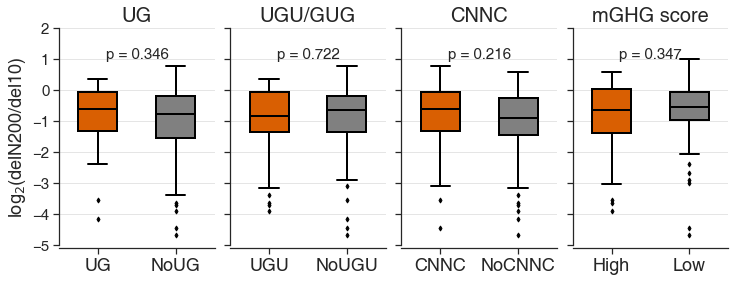

In [682]:
fig, ax = plt.subplots(1,4, figsize = (12,4), sharey=True)
plt.subplots_adjust(hspace = 0.4, wspace = 0.1)

### UG
ax_UG = sns.boxplot(x='UG', y = "log2FoldChange", data=DD_filtered, color='black', order=['UG','NoUG'],\
                    boxprops={'facecolor': 'None'}, showfliers=True, ax=ax[0], width=0.5, fliersize=3.5, linewidth=2)
ax_UG.artists[0].set_facecolor("#d95f02")
ax_UG.artists[1].set_facecolor("#808080")

ax[0].set_ylim(-5,2)
ax[0].set_ylabel("log$_2$(delN200/del10)", fontsize=18)
ax[0].set_xlabel("")
ax[0].set_title("UG", fontsize=20)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].grid(axis='y', alpha=0.5)
ax[0].spines['bottom'].set_position(('outward',3))

for label in ax[0].get_yticklabels():
    label.set_fontsize(15)
for label in ax[0].get_xticklabels():
    label.set_fontsize(18)

p0 = mannwhitneyu(DD_filtered[DD_filtered["UG"] == "UG"]["log2FoldChange"],\
                  DD_filtered[DD_filtered["UG"] == "NoUG"]["log2FoldChange"],alternative = 'two-sided')[1]
ax[0].text(0.1,1, 'p = %.3f'%p0, fontsize=15)

### UGU
ax_UGU = sns.boxplot(x='UGU', y = "log2FoldChange", data=DD_filtered, color='black', order=['UGU','NoUGU'],\
                     boxprops={'facecolor': 'None'}, showfliers=True, ax=ax[1], width=0.5, fliersize=3.5, linewidth=2)
ax_UGU.artists[0].set_facecolor("#d95f02")
ax_UGU.artists[1].set_facecolor("#808080")

ax[1].set_ylim(-5,2)
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_title("UGU/GUG", fontsize=20)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].grid(axis='y', alpha=0.5)
ax[1].spines['bottom'].set_position(('outward',3))

for label in ax[1].get_yticklabels():
    label.set_fontsize(15)
for label in ax[1].get_xticklabels():
    label.set_fontsize(18)

p1 = mannwhitneyu(DD_filtered[DD_filtered["UGU"] == "UGU"]["log2FoldChange"],\
                  DD_filtered[DD_filtered["UGU"] == "NoUGU"]["log2FoldChange"],alternative = 'two-sided')[1]
ax[1].text(0.1,1, 'p = %.3f'%p1, fontsize=15)

### CNNC
ax_CNNC = sns.boxplot(x='CNNC', y = "log2FoldChange", data=DD_filtered, color='black', order=['CNNC','NoCNNC'],\
                     boxprops={'facecolor': 'None'}, showfliers=True, ax=ax[2], width=0.5, fliersize=3.5, linewidth=2)
ax_CNNC.artists[0].set_facecolor("#d95f02")
ax_CNNC.artists[1].set_facecolor("#808080")

ax[2].set_ylim(-5,2)
ax[2].set_xlabel("")
ax[2].set_ylabel("")
ax[2].set_title("CNNC", fontsize=20)

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].grid(axis='y', alpha=0.5)
ax[2].spines['bottom'].set_position(('outward',3))

for label in ax[2].get_yticklabels():
    label.set_fontsize(15)
for label in ax[2].get_xticklabels():
    label.set_fontsize(18)

p2 = mannwhitneyu(DD_filtered[DD_filtered["CNNC"] == "CNNC"]["log2FoldChange"],\
                  DD_filtered[DD_filtered["CNNC"] == "NoCNNC"]["log2FoldChange"],alternative = 'two-sided')[1]
ax[2].text(0.1,1, 'p = %.3f'%p2, fontsize=15)

### mGHG
ax_mGHG = sns.boxplot(x='mGHG_group', y = "log2FoldChange", data=mGHG_DD_filtered, color='black', order=['High','Low'],\
                      boxprops={'facecolor': 'None'}, showfliers=True, ax=ax[3], width=0.5, fliersize=3.5, linewidth=2)
ax_mGHG.artists[0].set_facecolor("#d95f02")
ax_mGHG.artists[1].set_facecolor("#808080")

ax[3].set_ylim(-5,2)
ax[3].set_xlabel("")
ax[3].set_ylabel("")
ax[3].set_title("mGHG score", fontsize=20)

ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[3].grid(axis='y', alpha=0.5)
ax[3].spines['bottom'].set_position(('outward',3))

for label in ax[3].get_yticklabels():
    label.set_fontsize(15)
for label in ax[3].get_xticklabels():
    label.set_fontsize(18)

p3 = mannwhitneyu(mGHG_DD_filtered[mGHG_DD_filtered["mGHG_group"] == "High"]["log2FoldChange"],\
                  mGHG_DD_filtered[mGHG_DD_filtered["mGHG_group"] == "Low"]["log2FoldChange"],alternative = 'two-sided')[1]
ax[3].text(0.1,1, 'p = %.3f'%p3, fontsize=15)

fig.show()
#plt.savefig("Results/Figures/210110-motif-boxplots-HCT116.pdf", bbox_inches='tight')

### Intergenic, intronic 

Intronic and exonic was further filtered with the same strandness.

In [29]:
DD = pd.read_csv('Results/200914_HCT116_DD.csv')
DI = pd.read_csv('Results/200914_HCT116_DI.csv')

DD_filtered = pd.read_csv('Results/200914_HCT116_DD_filtered.csv')
DI_filtered = pd.read_csv('Results/200914_HCT116_DI_filtered.csv')

In [30]:
DD["Direction"].value_counts()

0     222
--    160
++    150
-+     18
+-     10
Name: Direction, dtype: int64

In [31]:
DD_filtered["Direction"].value_counts()

0     117
++     80
--     70
-+      8
+-      4
Name: Direction, dtype: int64

+- and -+ are excluded from below analysis.

In [34]:
SS = DD[~DD["Direction"].isin(["+-", "-+"])]
SS["Direction"].value_counts()

0     222
--    160
++    150
Name: Direction, dtype: int64

In [32]:
SS_filtered = DD_filtered[~DD_filtered["Direction"].isin(["+-", "-+"])]
SS_filtered["Direction"].value_counts()

0     117
++     80
--     70
Name: Direction, dtype: int64

In [35]:
SS["Exon_Intron"].value_counts()

intronic      272
intergenic    222
exonic         38
Name: Exon_Intron, dtype: int64

In [36]:
SS_filtered["Exon_Intron"].value_counts()

intronic      131
intergenic    117
exonic         19
Name: Exon_Intron, dtype: int64

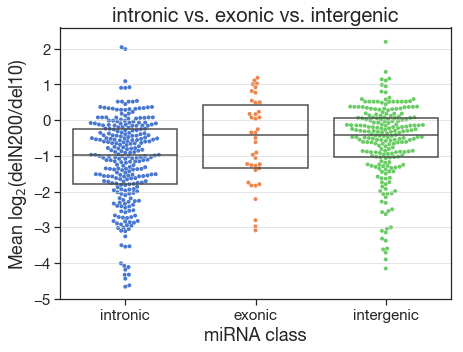

In [43]:
plt.figure(figsize=(7,5))
ax=\
sns.swarmplot(x="Exon_Intron", y = "log2FoldChange", data=SS, size=4, zorder=0,order=["intronic", "exonic", "intergenic"])
ax=\
sns.boxplot(x='Exon_Intron', y = "log2FoldChange", data=SS, color='gray', order=['intronic','exonic', 'intergenic'], showcaps=False,\
            boxprops={'facecolor':'None'}, showfliers=False,whiskerprops={'linewidth':0})

ax.set_title("intronic vs. exonic vs. intergenic", fontproperties=helvetica_20)
ax.set_xlabel("miRNA class", fontproperties=helvetica_18)
ax.set_ylabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
    
ax.grid(axis='y', alpha=0.5)

plt.show()

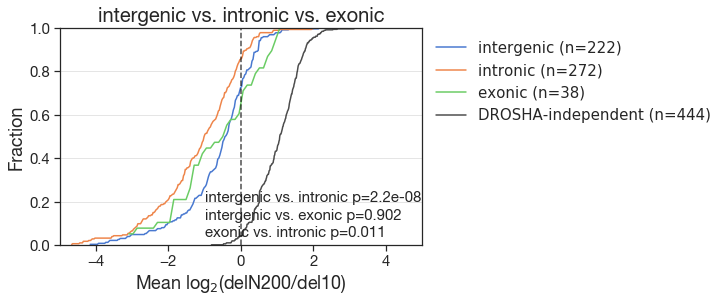

In [422]:
sns.set(style="ticks", palette="muted")

fig, ax = plt.subplots(1,1, figsize = (6.5,4))


inter = SS[SS["Exon_Intron"] == "intergenic"]["log2FoldChange"]
intronic = SS[SS["Exon_Intron"] == "intronic"]["log2FoldChange"]
exonic = SS[SS["Exon_Intron"] == "exonic"]["log2FoldChange"]
D_ind = DI["log2FoldChange"]
            

### evaluate the histogram
inter_values , inter_base = np.histogram(inter, bins = len(inter))
intronic_values , intronic_base = np.histogram(intronic, bins = len(intronic))
exonic_values , exonic_base = np.histogram(exonic, bins = len(exonic))
D_ind_values, D_ind_base = np.histogram(D_ind, bins = len(D_ind))

### evaluate the cumulative
inter_cumulative = np.cumsum(inter_values) / np.sum(inter_values)
intronic_cumulative = np.cumsum(intronic_values) / np.sum(intronic_values)
exonic_cumulative = np.cumsum(exonic_values) / np.sum(exonic_values)
D_ind_cumulative = np.cumsum(D_ind_values) / np.sum(D_ind_values)

ax.plot(inter_base[:-1], inter_cumulative, label="intergenic "+"(n="+str(len(inter))+")")
ax.plot(intronic_base[:-1], intronic_cumulative ,label="intronic "+"(n="+str(len(intronic))+")")
ax.plot(exonic_base[:-1], exonic_cumulative ,label="exonic "+"(n="+str(len(exonic))+")")
ax.plot(D_ind_base[:-1], D_ind_cumulative, color="black",alpha=0.7,\
         label="DROSHA-independent "+"(n="+str(len(D_ind))+")")

ax.grid(False)
ax.plot((0,0), (0,1), c="black", alpha=0.7, ls='--')
ax.set_xlim(-5,5)
ax.set_ylim(0,1)
ax.set_xlabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax.set_ylabel("Fraction",  fontproperties=helvetica_18)
ax.set_title("intergenic vs. intronic vs. exonic",  fontproperties=helvetica_20)
ax.legend(frameon=False, fontsize=15, bbox_to_anchor=(1,0.5), loc='lower left')

p0 = mannwhitneyu(inter, intronic, alternative='two-sided')[1]
p1 = mannwhitneyu(inter, exonic, alternative='two-sided')[1]
p2 = mannwhitneyu(intronic, exonic, alternative='two-sided')[1] 
ax.text(-1,0.2,'intergenic vs. intronic p=%.1e'%p0,  fontproperties=helvetica_15)
ax.text(-1,0.12,'intergenic vs. exonic p=%.3f'%p1,  fontproperties=helvetica_15)
ax.text(-1,0.04,'exonic vs. intronic p=%.3f'%p2,  fontproperties=helvetica_15)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5)
    
plt.show()

del inter, intronic, exonic, D_ind, inter_values, intronic_values, exonic_values, D_ind_values, inter_base, intronic_base, exonic_base, D_ind_base, inter_cumulative, intronic_cumulative, exonic_cumulative, D_ind_cumulative

With baseMean filter

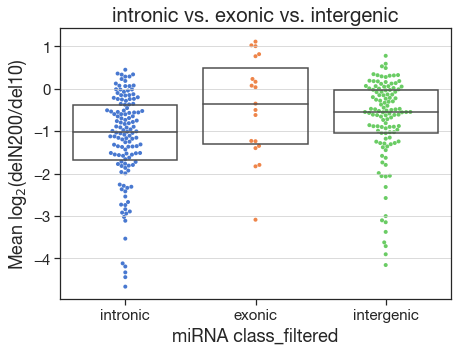

In [642]:
plt.figure(figsize=(7,5))
ax=\
sns.swarmplot(x="Exon_Intron", y = "log2FoldChange", data=SS_filtered, size=4, zorder=0,order=["intronic", "exonic", "intergenic"])
ax=\
sns.boxplot(x='Exon_Intron', y = "log2FoldChange", data=SS_filtered, color='gray', order=['intronic','exonic', 'intergenic'], showcaps=False,\
            boxprops={'facecolor':'None'}, showfliers=False,whiskerprops={'linewidth':0})

ax.set_title("intronic vs. exonic vs. intergenic", fontproperties=helvetica_20)
ax.set_xlabel("miRNA class_filtered", fontproperties=helvetica_18)
ax.set_ylabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
    
ax.grid(axis='y', alpha=0.7)

plt.show()

In [539]:
sns.set(style="ticks", palette="muted")

fig, ax = plt.subplots(1,1, figsize = (6.5,4))


inter = SS_filtered[SS_filtered["Exon_Intron"] == "intergenic"]["log2FoldChange"]
intronic = SS_filtered[SS_filtered["Exon_Intron"] == "intronic"]["log2FoldChange"]
exonic = SS_filtered[SS_filtered["Exon_Intron"] == "exonic"]["log2FoldChange"]
D_ind = DI_filtered["log2FoldChange"]
            

### evaluate the histogram
inter_values , inter_base = np.histogram(inter, bins = len(inter))
intronic_values , intronic_base = np.histogram(intronic, bins = len(intronic))
exonic_values , exonic_base = np.histogram(exonic, bins = len(exonic))
D_ind_values, D_ind_base = np.histogram(D_ind, bins = len(D_ind))

### evaluate the cumulative
inter_cumulative = np.cumsum(inter_values) / np.sum(inter_values)
intronic_cumulative = np.cumsum(intronic_values) / np.sum(intronic_values)
exonic_cumulative = np.cumsum(exonic_values) / np.sum(exonic_values)
D_ind_cumulative = np.cumsum(D_ind_values) / np.sum(D_ind_values)
####np.insert(UGU_base[:-1],0,UGU_base[0]-0.1,axis=0) , np.insert(UGU_cumulative,0,0,axis=0)
ax.plot(np.insert(intronic_base[:-1],0,intronic_base[0]-0.1, axis=0), np.insert(intronic_cumulative,0,0,axis=0), \
        label="intronic "+"(n="+str(len(intronic))+")", color='darkgreen', linewidth=3)
ax.plot(np.insert(exonic_base[:-1],0,exonic_base[0]-0.1, axis=0), np.insert(exonic_cumulative,0,0,axis=0), \
        label="exonic "+"(n="+str(len(exonic))+")", color='saddlebrown', linewidth=3)
ax.plot(np.insert(inter_base[:-1],0,inter_base[0]-0.1, axis=0), np.insert(inter_cumulative,0,0,axis=0), \
        label="intergenic "+"(n="+str(len(inter))+")", color='darkorange', linewidth=3)
ax.plot(np.insert(D_ind_base[:-1],0,D_ind_base[0]-0.1,axis=0) , np.insert(D_ind_cumulative,0,0,axis=0), color="darkgrey",\
        label="DROSHA-independent "+"(n="+str(len(D_ind))+")", linewidth=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)
ax.spines['bottom'].set_position(('outward', 4))

ax.set_xlim(-5,3)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax.set_ylabel("Fraction",  fontproperties=helvetica_18)
ax.set_title("intergenic vs. intronic vs. exonic",  fontproperties=helvetica_20)
ax.legend(frameon=False, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)

p0 = mannwhitneyu(inter, intronic, alternative='two-sided')[1]
p1 = mannwhitneyu(inter, exonic, alternative='two-sided')[1]
p2 = mannwhitneyu(intronic, exonic, alternative='two-sided')[1] 
ax.text(-4.9,0.9,'intergenic vs. intronic p=%.1e'%p0,  fontproperties=helvetica_15)
ax.text(-4.9,0.82,'intergenic vs. exonic p=%.3f'%p1,  fontproperties=helvetica_15)
ax.text(-4.9,0.74,'exonic vs. intronic p=%.3f'%p2,  fontproperties=helvetica_15)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
    

fig.show()

#plt.savefig("Results/201014-data-Genomic-locus-HCT116.pdf", bbox_inches='tight')

del inter, intronic, exonic, D_ind, inter_values, intronic_values, exonic_values, D_ind_values, inter_base, intronic_base, exonic_base, D_ind_base, inter_cumulative, intronic_cumulative, exonic_cumulative, D_ind_cumulative

For figure

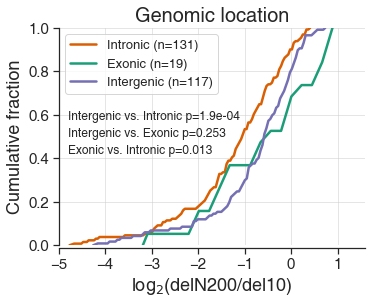

In [694]:
fig, ax = plt.subplots(1,1,figsize=(5.5,4))

inter = SS_filtered_2000[SS_filtered_2000["Exon_Intron"] == "intergenic"]["log2FoldChange"]
intronic = SS_filtered_2000[SS_filtered_2000["Exon_Intron"] == "intronic"]["log2FoldChange"]
exonic = SS_filtered_2000[SS_filtered_2000["Exon_Intron"] == "exonic"]["log2FoldChange"]

inter_values , inter_base = np.histogram(inter, bins = len(inter))
intronic_values , intronic_base = np.histogram(intronic, bins = len(intronic))
exonic_values , exonic_base = np.histogram(exonic, bins = len(exonic))

inter_cumulative = np.cumsum(inter_values) / np.sum(inter_values)
intronic_cumulative = np.cumsum(intronic_values) / np.sum(intronic_values)
exonic_cumulative = np.cumsum(exonic_values) / np.sum(exonic_values)


ax.plot(np.insert(intronic_base[:-1],0,intronic_base[0]-0.1,axis=0),\
        np.insert(intronic_cumulative,0,0,axis=0),label="Intronic "+"(n="+str(len(intronic))+")",\
        color='#d95f02', linewidth=2.5)
ax.plot(np.insert(exonic_base[:-1],0,exonic_base[0]-0.1,axis=0),\
        np.insert(exonic_cumulative,0,0,axis=0),label="Exonic "+"(n="+str(len(exonic))+")",\
        color='#1b9e77', linewidth=2.5)
ax.plot(np.insert(inter_base[:-1],0,inter_base[0]-0.1,axis=0),\
        np.insert(inter_cumulative,0,0,axis=0),label="Intergenic "+"(n="+str(len(inter))+")",\
        color='#7570b3', linewidth=2.5)

ax.set_xlim(-5,1.6)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(delN200/del10)", fontsize=18)
ax.set_ylabel("Cumulative fraction", fontsize=18)
ax.set_title("Genomic location", fontsize=20)
#ax.legend(frameon=True, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)
ax.legend(frameon=True, loc='upper left', fontsize=13)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
    
p0 = mannwhitneyu(inter, intronic, alternative='two-sided')[1]
p1 = mannwhitneyu(inter, exonic, alternative='two-sided')[1]
p2 = mannwhitneyu(intronic, exonic, alternative='two-sided')[1] 
ax.text(-4.8,0.58,'Intergenic vs. Intronic p=%.1e'%p0,  fontsize=12)
ax.text(-4.8,0.50,'Intergenic vs. Exonic p=%.3f'%p1,  fontsize=12)
ax.text(-4.8,0.42,'Exonic vs. Intronic p=%.3f'%p2,  fontsize=12)

fig.show()

#plt.savefig("Results/Figures/210118-genomic-location-cumulative-HCT116.pdf", bbox_inches='tight')

Select target for validation

In [425]:
#SS.to_csv("Results/DROSHA_dependent_strandness_HCT116.csv")

#### Cluster

Without baseMean filter

In [644]:
plt.figure(figsize=(7,5))
ax=\
sns.swarmplot(x="Clustered", y = "log2FoldChange", data=DD, size=4, zorder=0,order=["clustered", "independent"])
ax=\
sns.boxplot(x='Clustered', y = "log2FoldChange", data=DD, color='gray', order=["clustered", "independent"], showcaps=False,\
            boxprops={'facecolor':'None'}, showfliers=False,whiskerprops={'linewidth':0})

ax.set_title("Clustered vs. Independent", fontproperties=helvetica_20)
ax.set_xlabel("miRNA class", fontproperties=helvetica_18)
ax.set_ylabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
    
ax.grid(axis='y', alpha=0.5)

plt.show()

In [424]:
fig, ax = plt.subplots(1,1, figsize = (6.5,4))

clustered = DD[DD["Clustered"] == "clustered"]["log2FoldChange"]
independent = DD[DD["Clustered"] == "independent"]["log2FoldChange"]
D_ind = DI["log2FoldChange"]
            

### evaluate the histogram
clustered_values , clustered_base = np.histogram(clustered, bins = len(clustered))
independent_values , independent_base = np.histogram(independent, bins = len(independent))
D_ind_values, D_ind_base = np.histogram(D_ind, bins = len(D_ind))

### evaluate the cumulative
clustered_cumulative = np.cumsum(clustered_values) / np.sum(clustered_values)
independent_cumulative = np.cumsum(independent_values) / np.sum(independent_values)
D_ind_cumulative = np.cumsum(D_ind_values) / np.sum(D_ind_values)

ax.plot(clustered_base[:-1], clustered_cumulative, label="clustered "+"(n="+str(len(clustered))+")")
ax.plot(independent_base[:-1], independent_cumulative ,label="independent "+"(n="+str(len(independent))+")")
ax.plot(D_ind_base[:-1], D_ind_cumulative, color="black",alpha=0.7,\
        label="DROSHA-independent "+"(n="+str(len(D_ind))+")")

ax.grid(False)
ax.plot((0,0), (0,1), c="black", alpha=0.7, ls='--')
ax.set_xlim(-5,5)
ax.set_ylim(0,1)
ax.set_xlabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax.set_ylabel("Fraction", fontproperties=helvetica_18)
ax.set_title("Clustered vs. Independent", fontproperties=helvetica_20)
ax.legend(frameon=False, loc="upper left", fontsize=15)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5)    
    
p0 = mannwhitneyu(clustered, independent, alternative='two-sided')[1]
ax.text(-4,0.5,'p=%.1e'%p0, fontproperties=helvetica_15)
fig.show()

del clustered, independent, D_ind, clustered_values, clustered_base, independent_values, independent_base, D_ind_values, D_ind_base, \
clustered_cumulative, independent_cumulative, D_ind_cumulative

With baseMean filter

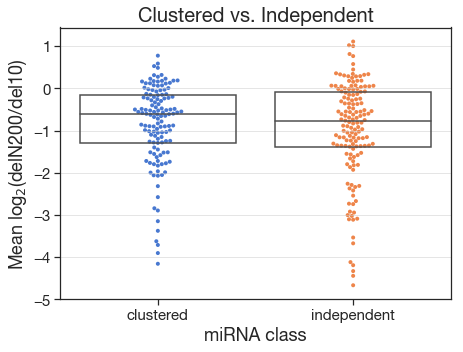

In [646]:
plt.figure(figsize=(7,5))
ax=\
sns.swarmplot(x="Clustered", y = "log2FoldChange", data=DD_filtered, size=4, zorder=0,order=["clustered", "independent"])
ax=\
sns.boxplot(x='Clustered', y = "log2FoldChange", data=DD_filtered, color='gray', order=["clustered", "independent"], showcaps=False,\
            boxprops={'facecolor':'None'}, showfliers=False,whiskerprops={'linewidth':0})

ax.set_title("Clustered vs. Independent", fontproperties=helvetica_20)
ax.set_xlabel("miRNA class", fontproperties=helvetica_18)
ax.set_ylabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
    
ax.grid(axis='y', alpha=0.5)

plt.show()

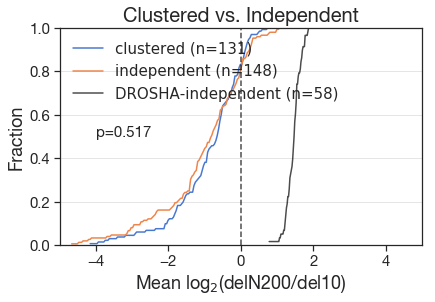

In [425]:
fig, ax = plt.subplots(1,1, figsize = (6.5,4))

clustered = DD_filtered[DD_filtered["Clustered"] == "clustered"]["log2FoldChange"]
independent = DD_filtered[DD_filtered["Clustered"] == "independent"]["log2FoldChange"]
D_ind = DI_filtered["log2FoldChange"]


### evaluate the histogram
clustered_values , clustered_base = np.histogram(clustered, bins = len(clustered))
independent_values , independent_base = np.histogram(independent, bins = len(independent))
D_ind_values, D_ind_base = np.histogram(D_ind, bins = len(D_ind))

### evaluate the cumulative
clustered_cumulative = np.cumsum(clustered_values) / np.sum(clustered_values)
independent_cumulative = np.cumsum(independent_values) / np.sum(independent_values)
D_ind_cumulative = np.cumsum(D_ind_values) / np.sum(D_ind_values)

ax.plot(clustered_base[:-1], clustered_cumulative, label="clustered "+"(n="+str(len(clustered))+")")
ax.plot(independent_base[:-1], independent_cumulative ,label="independent "+"(n="+str(len(independent))+")")
ax.plot(D_ind_base[:-1], D_ind_cumulative, color="black",alpha=0.7,\
        label="DROSHA-independent "+"(n="+str(len(D_ind))+")")

ax.grid(False)
ax.plot((0,0), (0,1), c="black", alpha=0.7, ls='--')
ax.set_xlim(-5,5)
ax.set_ylim(0,1)
ax.set_xlabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax.set_ylabel("Fraction", fontproperties=helvetica_18)
ax.set_title("Clustered vs. Independent", fontproperties=helvetica_20)
ax.legend(frameon=False, loc="upper left", fontsize=15)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5)
    
p0 = mannwhitneyu(clustered, independent, alternative='two-sided')[1]
ax.text(-4,0.5,'p=%.3f'%p0, fontproperties=helvetica_15)
fig.show()
#plt.savefig("Results/200730_HCT116_clustered.pdf", bbox_inches='tight')

del clustered, independent, D_ind, clustered_values, clustered_base, independent_values, independent_base, D_ind_values, D_ind_base, \
clustered_cumulative, independent_cumulative, D_ind_cumulative

#### Cluster & Intron/Exon/Intergenic

In [46]:
pd.crosstab(SS_filtered["Exon_Intron"], SS_filtered["Clustered"])

Clustered    clustered  independent
Exon_Intron                        
exonic               6           13
intergenic          78           39
intronic            41           90

In [1082]:
pd.crosstab(SS["Exon_Intron"], SS["Clustered"])

Clustered    clustered  independent
Exon_Intron                        
exonic              11           27
intergenic         139           83
intronic            57          215

Without baseMean filter

In [426]:
fig, ax = plt.subplots(2,1, figsize = (6.5,9))
plt.subplots_adjust(hspace = 0.4, wspace = 0.3)

inter_indep = SS[(SS["Exon_Intron"] == "intergenic") & (SS["Clustered"] == 'independent')]["log2FoldChange"]
inter_clustered = SS[(SS["Exon_Intron"] == "intergenic") & (SS["Clustered"] == 'clustered')]["log2FoldChange"]
intronic_indep = SS[(SS["Exon_Intron"] == "intronic") & (SS["Clustered"] == 'independent')]["log2FoldChange"]
intronic_clustered = SS[(SS["Exon_Intron"] == "intronic") & (SS["Clustered"] == 'clustered')]["log2FoldChange"]
exonic_indep = SS[(SS["Exon_Intron"] == "exonic") & (SS["Clustered"] == 'independent')]["log2FoldChange"]
exonic_clustered = SS[(SS["Exon_Intron"] == "exonic") & (SS["Clustered"] == 'clustered')]["log2FoldChange"]
D_ind = DI["log2FoldChange"]
            

### evaluate the histogram
inter_indep_values , inter_indep_base = np.histogram(inter_indep, bins = len(inter_indep))
inter_clustered_values , inter_clustered_base = np.histogram(inter_clustered, bins = len(inter_clustered))
intronic_indep_values , intronic_indep_base = np.histogram(intronic_indep, bins = len(intronic_indep))
intronic_clustered_values , intronic_clustered_base = np.histogram(intronic_clustered, bins = len(intronic_clustered))
exonic_indep_values , exonic_indep_base = np.histogram(exonic_indep, bins = len(exonic_indep))
exonic_clustered_values , exonic_clustered_base = np.histogram(exonic_clustered, bins = len(exonic_clustered))
D_ind_values, D_ind_base = np.histogram(D_ind, bins = len(D_ind))

### evaluate the cumulative
inter_indep_cumulative = np.cumsum(inter_indep_values) / np.sum(inter_indep_values)
inter_clustered_cumulative = np.cumsum(inter_clustered_values) / np.sum(inter_clustered_values)
intronic_indep_cumulative = np.cumsum(intronic_indep_values) / np.sum(intronic_indep_values)
intronic_clustered_cumulative = np.cumsum(intronic_clustered_values) / np.sum(intronic_clustered_values)
exonic_indep_cumulative = np.cumsum(exonic_indep_values) / np.sum(exonic_indep_values)
exonic_clustered_cumulative = np.cumsum(exonic_clustered_values) / np.sum(exonic_clustered_values)
D_ind_cumulative = np.cumsum(D_ind_values) / np.sum(D_ind_values)

ax[0].plot(inter_indep_base[:-1], inter_indep_cumulative, label="intergenic&independent "+"(n="+str(len(inter_indep))+")")
ax[1].plot(inter_clustered_base[:-1], inter_clustered_cumulative, label="intergenic&clustered "+"(n="+str(len(inter_clustered))+")")
ax[0].plot(intronic_indep_base[:-1], intronic_indep_cumulative ,label="intronic&independent "+"(n="+str(len(intronic_indep))+")")
ax[1].plot(intronic_clustered_base[:-1], intronic_clustered_cumulative ,label="intronic&clustered "+"(n="+str(len(intronic_clustered))+")")        
ax[0].plot(exonic_indep_base[:-1], exonic_indep_cumulative ,label="exonic&independent "+"(n="+str(len(exonic_indep))+")")
ax[1].plot(exonic_clustered_base[:-1], exonic_clustered_cumulative ,label="exonic&clustered "+"(n="+str(len(exonic_clustered))+")")        
ax[0].plot(D_ind_base[:-1], D_ind_cumulative, color="black",alpha=0.7, label="DROSHA-independent "+"(n="+str(len(D_ind))+")")
ax[1].plot(D_ind_base[:-1], D_ind_cumulative, color="black",alpha=0.7, label="DROSHA-independent "+"(n="+str(len(D_ind))+")")

ax[0].grid(False)
ax[0].plot((0,0), (0,1), c="black", alpha=0.7, ls='--')
ax[0].set_xlim(-5,5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[0].set_ylabel("Fraction",  fontproperties=helvetica_18)
ax[0].set_title("Among independent miRNAs",  fontproperties=helvetica_20)
ax[0].legend(frameon=False,  bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)
                
ax[1].grid(False)
ax[1].plot((0,0), (0,1), c="black", alpha=0.7, ls='--')
ax[1].set_xlim(-5,5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[1].set_ylabel("Fraction",  fontproperties=helvetica_18)
ax[1].set_title("Among clustered miRNAs",  fontproperties=helvetica_20)
ax[1].legend(frameon=False,  bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)

p00 = mannwhitneyu(inter_indep, intronic_indep, alternative='two-sided')[1]
p01 = mannwhitneyu(inter_indep, exonic_indep, alternative='two-sided')[1]
p02 = mannwhitneyu(intronic_indep, exonic_indep, alternative='two-sided')[1] 
ax[0].text(-1,0.2,'intergenic vs. intronic p=%.1e'%p00,  fontproperties=helvetica_15)
ax[0].text(-1,0.12,'intergenic vs. exonic p=%.3f'%p01,  fontproperties=helvetica_15)
ax[0].text(-1,0.04,'exonic vs. intronic p=%.3f'%p02,  fontproperties=helvetica_15)

p10 = mannwhitneyu(inter_clustered, intronic_clustered, alternative='two-sided')[1]
p11 = mannwhitneyu(inter_clustered, exonic_clustered, alternative='two-sided')[1]
p12 = mannwhitneyu(intronic_clustered, exonic_clustered, alternative='two-sided')[1] 
ax[1].text(-1,0.2,'intergenic vs. intronic p=%.3f'%p10,  fontproperties=helvetica_15)
ax[1].text(-1,0.12,'intergenic vs. exonic p=%.3f'%p11,  fontproperties=helvetica_15)
ax[1].text(-1,0.04,'exonic vs. intronic p=%.3f'%p12,  fontproperties=helvetica_15)


for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax[0].grid(axis='y', alpha=0.5)
ax[1].grid(axis='y', alpha=0.5)
    

plt.show()

del inter_indep, inter_clustered, intronic_indep, intronic_clustered, exonic_indep, exonic_clustered, D_ind, \
inter_indep_values , inter_indep_base, inter_clustered_values , inter_clustered_base, intronic_indep_values , intronic_indep_base, \
intronic_clustered_values , intronic_clustered_base, exonic_indep_values , exonic_indep_base, exonic_clustered_values , exonic_clustered_base, \
D_ind_values, D_ind_base, inter_indep_cumulative, inter_clustered_cumulative, intronic_indep_cumulative , intronic_clustered_cumulative, \
exonic_indep_cumulative , exonic_clustered_cumulative, D_ind_cumulative

With baseMean filter

In [427]:
fig, ax = plt.subplots(2,1, figsize = (6.5,9))
plt.subplots_adjust(hspace = 0.4, wspace = 0.3)

inter_indep = SS_filtered[(SS_filtered["Exon_Intron"] == "intergenic") & (SS_filtered["Clustered"] == 'independent')]["log2FoldChange"]
inter_clustered = SS_filtered[(SS_filtered["Exon_Intron"] == "intergenic") & (SS_filtered["Clustered"] == 'clustered')]["log2FoldChange"]
intronic_indep = SS_filtered[(SS_filtered["Exon_Intron"] == "intronic") & (SS_filtered["Clustered"] == 'independent')]["log2FoldChange"]
intronic_clustered = SS_filtered[(SS_filtered["Exon_Intron"] == "intronic") & (SS_filtered["Clustered"] == 'clustered')]["log2FoldChange"]
exonic_indep = SS_filtered[(SS_filtered["Exon_Intron"] == "exonic") & (SS_filtered["Clustered"] == 'independent')]["log2FoldChange"]
exonic_clustered = SS_filtered[(SS_filtered["Exon_Intron"] == "exonic") & (SS_filtered["Clustered"] == 'clustered')]["log2FoldChange"]
D_ind = DI_filtered["log2FoldChange"]
            

### evaluate the histogram
inter_indep_values , inter_indep_base = np.histogram(inter_indep, bins = len(inter_indep))
inter_clustered_values , inter_clustered_base = np.histogram(inter_clustered, bins = len(inter_clustered))
intronic_indep_values , intronic_indep_base = np.histogram(intronic_indep, bins = len(intronic_indep))
intronic_clustered_values , intronic_clustered_base = np.histogram(intronic_clustered, bins = len(intronic_clustered))
exonic_indep_values , exonic_indep_base = np.histogram(exonic_indep, bins = len(exonic_indep))
exonic_clustered_values , exonic_clustered_base = np.histogram(exonic_clustered, bins = len(exonic_clustered))
D_ind_values, D_ind_base = np.histogram(D_ind, bins = len(D_ind))

### evaluate the cumulative
inter_indep_cumulative = np.cumsum(inter_indep_values) / np.sum(inter_indep_values)
inter_clustered_cumulative = np.cumsum(inter_clustered_values) / np.sum(inter_clustered_values)
intronic_indep_cumulative = np.cumsum(intronic_indep_values) / np.sum(intronic_indep_values)
intronic_clustered_cumulative = np.cumsum(intronic_clustered_values) / np.sum(intronic_clustered_values)
exonic_indep_cumulative = np.cumsum(exonic_indep_values) / np.sum(exonic_indep_values)
exonic_clustered_cumulative = np.cumsum(exonic_clustered_values) / np.sum(exonic_clustered_values)
D_ind_cumulative = np.cumsum(D_ind_values) / np.sum(D_ind_values)

ax[0].plot(inter_indep_base[:-1], inter_indep_cumulative, label="intergenic&independent "+"(n="+str(len(inter_indep))+")")
ax[1].plot(inter_clustered_base[:-1], inter_clustered_cumulative, label="intergenic&clustered "+"(n="+str(len(inter_clustered))+")")
ax[0].plot(intronic_indep_base[:-1], intronic_indep_cumulative ,label="intronic&independent "+"(n="+str(len(intronic_indep))+")")
ax[1].plot(intronic_clustered_base[:-1], intronic_clustered_cumulative ,label="intronic&clustered "+"(n="+str(len(intronic_clustered))+")")        
ax[0].plot(exonic_indep_base[:-1], exonic_indep_cumulative ,label="exonic&independent "+"(n="+str(len(exonic_indep))+")")
ax[1].plot(exonic_clustered_base[:-1], exonic_clustered_cumulative ,label="exonic&clustered "+"(n="+str(len(exonic_clustered))+")")        
ax[0].plot(D_ind_base[:-1], D_ind_cumulative, color="black",alpha=0.7, label="DROSHA-independent "+"(n="+str(len(D_ind))+")")
ax[1].plot(D_ind_base[:-1], D_ind_cumulative, color="black",alpha=0.7, label="DROSHA-independent "+"(n="+str(len(D_ind))+")")

ax[0].grid(False)
ax[0].plot((0,0), (0,1), c="black", alpha=0.7, ls='--')
ax[0].set_xlim(-5,5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[0].set_ylabel("Fraction",  fontproperties=helvetica_18)
ax[0].set_title("Among independent miRNAs",  fontproperties=helvetica_20)
ax[0].legend(frameon=False, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)
                
ax[1].grid(False)
ax[1].plot((0,0), (0,1), c="black", alpha=0.7, ls='--')
ax[1].set_xlim(-5,5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[1].set_ylabel("Fraction",  fontproperties=helvetica_18)
ax[1].set_title("Among clustered miRNAs",  fontproperties=helvetica_20)
ax[1].legend(frameon=False, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)

p00 = mannwhitneyu(inter_indep, intronic_indep, alternative='two-sided')[1]
p01 = mannwhitneyu(inter_indep, exonic_indep, alternative='two-sided')[1]
p02 = mannwhitneyu(intronic_indep, exonic_indep, alternative='two-sided')[1] 
ax[0].text(-1,0.2,'intergenic vs. intronic p=%.1e'%p00,  fontproperties=helvetica_15)
ax[0].text(-1,0.12,'intergenic vs. exonic p=%.3f'%p01,  fontproperties=helvetica_15)
ax[0].text(-1,0.04,'exonic vs. intronic p=%.3f'%p02,  fontproperties=helvetica_15)

p10 = mannwhitneyu(inter_clustered, intronic_clustered, alternative='two-sided')[1]
p11 = mannwhitneyu(inter_clustered, exonic_clustered, alternative='two-sided')[1]
p12 = mannwhitneyu(intronic_clustered, exonic_clustered, alternative='two-sided')[1] 
ax[1].text(-1,0.2,'intergenic vs. intronic p=%.3f'%p10,  fontproperties=helvetica_15)
ax[1].text(-1,0.12,'intergenic vs. exonic p=%.3f'%p11,  fontproperties=helvetica_15)
ax[1].text(-1,0.04,'exonic vs. intronic p=%.3f'%p12,  fontproperties=helvetica_15)

for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax[0].grid(axis='y', alpha=0.5)
ax[1].grid(axis='y', alpha=0.5)

fig.show()
#plt.savefig("Results/200730_HCT116_among_independent.pdf", bbox_inches='tight')

del inter_indep, inter_clustered, intronic_indep, intronic_clustered, exonic_indep, exonic_clustered, D_ind, \
inter_indep_values , inter_indep_base, inter_clustered_values , inter_clustered_base, intronic_indep_values , intronic_indep_base, \
intronic_clustered_values , intronic_clustered_base, exonic_indep_values , exonic_indep_base, exonic_clustered_values , exonic_clustered_base, \
D_ind_values, D_ind_base, inter_indep_cumulative, inter_clustered_cumulative, intronic_indep_cumulative , intronic_clustered_cumulative, \
exonic_indep_cumulative , exonic_clustered_cumulative, D_ind_cumulative

--- 
### Among intronics, see the correlation between the length of host introns and log2FC
#### before do deeper analysis about 5'SS, 3'SS, brance point sequence


#### Get the information about the length of host introns from UCSC table browser

- genome: hg38

- group: Genes and Gene Predictions

- track: NCBI RefSeq, table: UCSC RefSeq (refGene)

- 0-based, half open

In [223]:
genome_df = pd.read_table('hg38_RefSeq_Curated_intron.bed')
genome_df.head(20)

chr1  67093604  67096251  NM_001276352.2_intron_0_0_chr1_67093605_r  0  -
0   chr1  67096321  67103237  NM_001276352.2_intron_1_0_chr1_67096322_r  0  -
1   chr1  67103382  67111576  NM_001276352.2_intron_2_0_chr1_67103383_r  0  -
2   chr1  67111644  67115351  NM_001276352.2_intron_3_0_chr1_67111645_r  0  -
3   chr1  67115464  67125751  NM_001276352.2_intron_4_0_chr1_67115465_r  0  -
4   chr1  67125909  67127165  NM_001276352.2_intron_5_0_chr1_67125910_r  0  -
5   chr1  67127257  67131141  NM_001276352.2_intron_6_0_chr1_67127258_r  0  -
6   chr1  67131227  67134929  NM_001276352.2_intron_7_0_chr1_67131228_r  0  -
7   chr1  67093604  67095234  NM_001276351.2_intron_0_0_chr1_67093605_r  0  -
8   chr1  67095421  67096251  NM_001276351.2_intron_1_0_chr1_67095422_r  0  -
9   chr1  67096321  67115351  NM_001276351.2_intron_2_0_chr1_67096322_r  0  -
10  chr1  67115464  67125751  NM_001276351.2_intron_3_0_chr1_67115465_r  0  -
11  chr1  67125909  67127165  NM_001276351.2_intron_4_0_chr1_67125910_r  0  -
12  chr1  67127257  67131141  NM_001276351.2_intron_5_0_chr1_67127258_r  0  -
13  chr1  67131227  67134929  NM_001276351.2_intron_6_0_chr1_67131228_r  0  -
14  chr1  67093604  67096251     NR_075077.2_intron_0_0_chr1_67093605_r  0  -
15  chr1  67096321  67103237     NR_075077.2_intron_1_0_chr1_67096322_r  0  -
16  chr1  67103382  67111576     NR_075077.2_intron_2_0_chr1_67103383_r  0  -
17  chr1  67111644  67113613     NR_075077.2_intron_3_0_chr1_67111645_r  0  -
18  chr1  67113756  67115351     NR_075077.2_intron_4_0_chr1_67113757_r  0  -
19  chr1  67115464  67125751     NR_075077.2_intron_5_0_chr1_67115465_r  0  -

In [224]:
genome_bed = pybedtools.BedTool.from_dataframe(genome_df)

#### Get the coordinates of pri-miRNA start and end for intronic miRNAs
- Original mirbase: 1-based, closed interval( [,] )
- Change the coordinates of pri-miRNA start and end to 0-based and half-open interval.
- Classified them into intronic & independent and intronic & clustered

- pri Start = pri Start - 1
- pri End = pri End 

In [1101]:
# I: intronic, I: independent

II = SS[(SS["Exon_Intron"] == 'intronic') & (SS["Clustered"] == 'independent')].copy()

II["pri Start"] = II['pri Start'] - 1
II["pri End"] = II["pri End"]

print(II.shape)
II.head()

(215, 24)


mature     baseMean  log2FoldChange      stat    pvalue  \
14      hsa-let-7g-3p    47.297341       -0.355310 -0.867338  0.385757   
15      hsa-let-7g-5p  4175.582999        0.184186  0.720868  0.470991   
21     hsa-miR-101-5p     3.763765       -0.071027 -0.082611  0.934161   
22  hsa-miR-103a-2-5p     7.948795       -0.547800 -0.732359  0.463949   
27        hsa-miR-107   769.030249       -0.374998 -1.898608  0.057616   

        padj curated DROSHA dependency (HCT116) 5p3p       pri-miRNA    Chr  \
14  0.479096                   DROSHA-dependent   3p      hsa-let-7g   chr3   
15  0.569534                   DROSHA-dependent   5p      hsa-let-7g   chr3   
21  0.958985                   DROSHA-dependent   5p   hsa-mir-101-1   chr1   
22  0.562874                   DROSHA-dependent   5p  hsa-mir-103a-2  chr20   
27  0.109763                   DROSHA-dependent  NaN     hsa-mir-107  chr10   

    ...         Locus  Exon_Intron      HostGene Direction stem length  loop  \
14  ...    intragenic     intronic         WDR82        --        34.0  33.0   
15  ...    intragenic     intronic         WDR82        --        34.0  33.0   
21  ...    intragenic     intronic  LOC107983962        --        33.0  12.0   
22  ...    intragenic     intronic         PANK2        ++        34.0  12.0   
27  ...    intragenic     intronic         PANK1        --        38.0   5.0   

   simple loop    UG  CNNC    UGU  
14        10.0    UG  CNNC  NoUGU  
15        10.0    UG  CNNC  NoUGU  
21        12.0  NoUG  CNNC    UGU  
22        12.0  NoUG  CNNC  NoUGU  
27         5.0  NoUG  CNNC  NoUGU  

[5 rows x 24 columns]

In [1102]:
IC = SS[(SS["Exon_Intron"] == 'intronic') & (SS["Clustered"] == 'clustered')].copy()

IC["pri Start"] = IC['pri Start'] - 1
IC["pri End"] = IC["pri End"]

print(IC.shape)
IC.head()

(57, 24)


mature     baseMean  log2FoldChange      stat    pvalue  \
12   hsa-let-7f-2-3p    47.599577       -0.160113 -0.430125  0.667105   
25   hsa-miR-106b-3p   360.939551       -0.598471 -2.498198  0.012483   
26   hsa-miR-106b-5p  2614.410084       -0.254236 -1.151013  0.249727   
119   hsa-miR-15b-3p   121.017202       -1.194717 -3.715968  0.000202   
120   hsa-miR-15b-5p  1132.672698       -1.520852 -4.223929  0.000024   

         padj curated DROSHA dependency (HCT116) 5p3p     pri-miRNA   Chr  \
12   0.741902                   DROSHA-dependent   3p  hsa-let-7f-2  chrX   
25   0.034970                   DROSHA-dependent   3p  hsa-mir-106b  chr7   
26   0.344855                   DROSHA-dependent   5p  hsa-mir-106b  chr7   
119  0.001389                   DROSHA-dependent   3p   hsa-mir-15b  chr3   
120  0.000226                   DROSHA-dependent   5p   hsa-mir-15b  chr3   

     ...         Locus  Exon_Intron HostGene Direction stem length  loop  \
12   ...    intragenic     intronic    HUWE1        --        34.0  26.0   
25   ...    intragenic     intronic     MCM7        --        38.0   6.0   
26   ...    intragenic     intronic     MCM7        --        38.0   6.0   
119  ...    intragenic     intronic     SMC4        ++        36.0  12.0   
120  ...    intragenic     intronic     SMC4        ++        36.0  12.0   

    simple loop    UG    CNNC    UGU  
12          3.0    UG    CNNC  NoUGU  
25          6.0  NoUG    CNNC  NoUGU  
26          6.0  NoUG    CNNC  NoUGU  
119        12.0  NoUG  NoCNNC  NoUGU  
120        12.0  NoUG  NoCNNC  NoUGU  

[5 rows x 24 columns]

In [1105]:
II_filtered = SS_filtered[(SS_filtered["Exon_Intron"] == 'intronic') & (SS_filtered["Clustered"] == 'independent')].copy()
II_filtered.set_index("mature", inplace=True)
II_filtered["pri Start"] = II_filtered['pri Start'] - 1
II_filtered["pri End"] = II_filtered["pri End"]

print(II_filtered.shape)
II_filtered.head()

(90, 23)


baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                      
hsa-let-7g-3p     47.297341       -0.355310 -0.867338  0.385757  0.479096   
hsa-let-7g-5p   4175.582999        0.184186  0.720868  0.470991  0.569534   
hsa-miR-107      769.030249       -0.374998 -1.898608  0.057616  0.109763   
hsa-miR-10a-3p   135.829597       -0.150893 -0.379841  0.704063  0.771775   
hsa-miR-10a-5p  4827.332874       -0.455479 -1.544774  0.122401  0.194464   

               curated DROSHA dependency (HCT116) 5p3p    pri-miRNA    Chr  \
mature                                                                       
hsa-let-7g-3p                    DROSHA-dependent   3p   hsa-let-7g   chr3   
hsa-let-7g-5p                    DROSHA-dependent   5p   hsa-let-7g   chr3   
hsa-miR-107                      DROSHA-dependent  NaN  hsa-mir-107  chr10   
hsa-miR-10a-3p                   DROSHA-dependent   3p  hsa-mir-10a  chr17   
hsa-miR-10a-5p                   DROSHA-dependent   5p  hsa-mir-10a  chr17   

                 pri Start  ...         Locus Exon_Intron HostGene Direction  \
mature                      ...                                                
hsa-let-7g-3p   52268277.0  ...    intragenic    intronic    WDR82        --   
hsa-let-7g-5p   52268277.0  ...    intragenic    intronic    WDR82        --   
hsa-miR-107     89592746.0  ...    intragenic    intronic    PANK1        --   
hsa-miR-10a-3p  48579837.0  ...    intragenic    intronic    HOXB3        --   
hsa-miR-10a-5p  48579837.0  ...    intragenic    intronic    HOXB3        --   

               stem length  loop simple loop    UG  CNNC    UGU  
mature                                                           
hsa-let-7g-3p         34.0  33.0        10.0    UG  CNNC  NoUGU  
hsa-let-7g-5p         34.0  33.0        10.0    UG  CNNC  NoUGU  
hsa-miR-107           38.0   5.0         5.0  NoUG  CNNC  NoUGU  
hsa-miR-10a-3p        35.0  16.0        16.0    UG  CNNC    UGU  
hsa-miR-10a-5p        35.0  16.0        16.0    UG  CNNC    UGU  

[5 rows x 23 columns]

In [1106]:
IC_filtered = SS_filtered[(SS_filtered["Exon_Intron"] == 'intronic') & (SS_filtered["Clustered"] == 'clustered')].copy()

IC_filtered["pri Start"] = IC_filtered['pri Start'] - 1
IC_filtered["pri End"] = IC_filtered["pri End"]

print(IC_filtered.shape)
IC_filtered.head()

(41, 24)


mature     baseMean  log2FoldChange      stat    pvalue  \
11  hsa-let-7f-2-3p    47.599577       -0.160113 -0.430125  0.667105   
22  hsa-miR-106b-3p   360.939551       -0.598471 -2.498198  0.012483   
23  hsa-miR-106b-5p  2614.410084       -0.254236 -1.151013  0.249727   
70   hsa-miR-15b-3p   121.017202       -1.194717 -3.715968  0.000202   
71   hsa-miR-15b-5p  1132.672698       -1.520852 -4.223929  0.000024   

        padj curated DROSHA dependency (HCT116) 5p3p     pri-miRNA   Chr  \
11  0.741902                   DROSHA-dependent   3p  hsa-let-7f-2  chrX   
22  0.034970                   DROSHA-dependent   3p  hsa-mir-106b  chr7   
23  0.344855                   DROSHA-dependent   5p  hsa-mir-106b  chr7   
70  0.001389                   DROSHA-dependent   3p   hsa-mir-15b  chr3   
71  0.000226                   DROSHA-dependent   5p   hsa-mir-15b  chr3   

    ...         Locus  Exon_Intron HostGene Direction stem length  loop  \
11  ...    intragenic     intronic    HUWE1        --        34.0  26.0   
22  ...    intragenic     intronic     MCM7        --        38.0   6.0   
23  ...    intragenic     intronic     MCM7        --        38.0   6.0   
70  ...    intragenic     intronic     SMC4        ++        36.0  12.0   
71  ...    intragenic     intronic     SMC4        ++        36.0  12.0   

   simple loop    UG    CNNC    UGU  
11         3.0    UG    CNNC  NoUGU  
22         6.0  NoUG    CNNC  NoUGU  
23         6.0  NoUG    CNNC  NoUGU  
70        12.0  NoUG  NoCNNC  NoUGU  
71        12.0  NoUG  NoCNNC  NoUGU  

[5 rows x 24 columns]

In [1090]:
II.isna().sum()

baseMean                                0
log2FoldChange                          0
stat                                    0
pvalue                                  0
padj                                   69
curated DROSHA dependency (HCT116)      0
pri-miRNA                               0
Chr                                     0
pri Start                               0
pri End                                 0
strand                                  0
Clustered                               0
Locus                                   0
Exon_Intron                             0
HostGene                                0
Direction                               0
stem length                           106
loop                                  106
simple loop                           106
UG                                    106
CNNC                                  106
UGU                                   106
dtype: int64

In [55]:
IC.isna().sum()

baseMean                              0
log2FoldChange                        0
stat                                  0
pvalue                                0
padj                                  7
curated DROSHA dependency (HCT116)    0
5p3p                                  2
pri-miRNA                             0
Chr                                   0
pri Start                             0
pri End                               0
strand                                0
Clustered                             0
Locus                                 0
Exon_Intron                           0
HostGene                              0
Direction                             0
stem length                           9
loop                                  9
simple loop                           9
UG                                    9
CNNC                                  9
UGU                                   9
dtype: int64

In [1107]:
tmp = II.reset_index()[["Chr", "pri Start", "pri End", "mature", "strand"]]
tmp['score'] = 0

tmp= tmp[["Chr", "pri Start", "pri End", "mature", "score", "strand"]]

tmp["pri Start"] = pd.to_numeric(tmp["pri Start"], downcast='integer')
tmp["pri End"] = pd.to_numeric(tmp["pri End"], downcast='integer')

II_bed = pybedtools.BedTool.from_dataframe(tmp)
II_bed.head()

chr3	52268277	52268361	hsa-let-7g-3p	0	-
 chr3	52268277	52268361	hsa-let-7g-5p	0	-
 chr1	65058433	65058508	hsa-miR-101-5p	0	-
 chr20	3917493	3917571	hsa-miR-103a-2-5p	0	+
 chr10	89592746	89592827	hsa-miR-107	0	-
 chr17	48579837	48579947	hsa-miR-10a-3p	0	-
 chr17	48579837	48579947	hsa-miR-10a-5p	0	-
 chr17	19344505	19344574	hsa-miR-1180-3p	0	-
 chr17	19344505	19344574	hsa-miR-1180-5p	0	-
 chr22	45200953	45201019	hsa-miR-1249-3p	0	-
 

In [1108]:
tmp = IC.reset_index()[["Chr", "pri Start", "pri End", "mature", "strand"]]
tmp['score'] = 0

tmp= tmp[["Chr", "pri Start", "pri End", "mature", "score", "strand"]]

tmp["pri Start"] = pd.to_numeric(tmp["pri Start"], downcast='integer')
tmp["pri End"] = pd.to_numeric(tmp["pri End"], downcast='integer')

IC_bed = pybedtools.BedTool.from_dataframe(tmp)
IC_bed.head()

chrX	53557191	53557274	hsa-let-7f-2-3p	0	-
 chr7	100093992	100094074	hsa-miR-106b-3p	0	-
 chr7	100093992	100094074	hsa-miR-106b-5p	0	-
 chr3	160404587	160404685	hsa-miR-15b-3p	0	+
 chr3	160404587	160404685	hsa-miR-15b-5p	0	+
 chr3	160404744	160404825	hsa-miR-16-2-3p	0	+
 chrX	50003502	50003588	hsa-miR-188-3p	0	+
 chrX	50003502	50003588	hsa-miR-188-5p	0	+
 chrX	151958577	151958658	hsa-miR-224-3p	0	-
 chrX	151958577	151958658	hsa-miR-224-5p	0	-
 

In [1109]:
tmp = II_filtered.reset_index()[["Chr", "pri Start", "pri End", "mature", "strand"]]
tmp['score'] = 0

tmp= tmp[["Chr", "pri Start", "pri End", "mature", "score", "strand"]]

tmp["pri Start"] = pd.to_numeric(tmp["pri Start"], downcast='integer')
tmp["pri End"] = pd.to_numeric(tmp["pri End"], downcast='integer')

II_filtered_bed = pybedtools.BedTool.from_dataframe(tmp)
II_filtered_bed.head()

chr3	52268277	52268361	hsa-let-7g-3p	0	-
 chr3	52268277	52268361	hsa-let-7g-5p	0	-
 chr10	89592746	89592827	hsa-miR-107	0	-
 chr17	48579837	48579947	hsa-miR-10a-3p	0	-
 chr17	48579837	48579947	hsa-miR-10a-5p	0	-
 chr17	19344505	19344574	hsa-miR-1180-3p	0	-
 chr22	45200953	45201019	hsa-miR-1249-3p	0	-
 chr9	136670601	136670686	hsa-miR-126-3p	0	+
 chr9	136670601	136670686	hsa-miR-126-5p	0	+
 chrX	118386393	118386471	hsa-miR-1277-3p	0	+
 

In [1110]:
tmp = IC_filtered.reset_index()[["Chr", "pri Start", "pri End", "mature", "strand"]]
tmp['score'] = 0

tmp= tmp[["Chr", "pri Start", "pri End", "mature", "score", "strand"]]

tmp["pri Start"] = pd.to_numeric(tmp["pri Start"], downcast='integer')
tmp["pri End"] = pd.to_numeric(tmp["pri End"], downcast='integer')

IC_filtered_bed = pybedtools.BedTool.from_dataframe(tmp)
IC_filtered_bed.head()

chrX	53557191	53557274	hsa-let-7f-2-3p	0	-
 chr7	100093992	100094074	hsa-miR-106b-3p	0	-
 chr7	100093992	100094074	hsa-miR-106b-5p	0	-
 chr3	160404587	160404685	hsa-miR-15b-3p	0	+
 chr3	160404587	160404685	hsa-miR-15b-5p	0	+
 chr3	160404744	160404825	hsa-miR-16-2-3p	0	+
 chrX	50003502	50003588	hsa-miR-188-5p	0	+
 chrX	151958577	151958658	hsa-miR-224-5p	0	-
 chr9	95085207	95085304	hsa-miR-23b-3p	0	+
 chr9	95086020	95086088	hsa-miR-24-1-5p	0	+
 

Without baseMean filter

In [465]:
# A: intronic miRNA region
# B: intron regions of genomes

II_intersect = pybedtools.BedTool(II_bed).intersect(genome_bed, wa=True, wb=True, f=1)
II_intersect = pybedtools.BedTool.to_dataframe(II_intersect)
print(II_intersect.shape)
II_intersect.head(10)

(1055, 12)


chrom     start       end               name  score strand thickStart  \
0   chr3  52268277  52268361      hsa-let-7g-3p      0      -       chr3   
1   chr3  52268277  52268361      hsa-let-7g-5p      0      -       chr3   
2   chr1  65058433  65058508     hsa-miR-101-5p      0      -       chr1   
3   chr1  65058433  65058508     hsa-miR-101-5p      0      -       chr1   
4   chr1  65058433  65058508     hsa-miR-101-5p      0      -       chr1   
5  chr20   3917493   3917571  hsa-miR-103a-2-5p      0      +      chr20   
6  chr20   3917493   3917571  hsa-miR-103a-2-5p      0      +      chr20   
7  chr20   3917493   3917571  hsa-miR-103a-2-5p      0      +      chr20   
8  chr20   3917493   3917571  hsa-miR-103a-2-5p      0      +      chr20   
9  chr20   3917493   3917571  hsa-miR-103a-2-5p      0      +      chr20   

   thickEnd   itemRgb                                blockCount  blockSizes  \
0  52267018  52270711      NM_025222_intron_6_0_chr3_52267019_r           0   
1  52267018  52270711      NM_025222_intron_6_0_chr3_52267019_r           0   
2  64886341  65067603  NM_001321852_intron_23_0_chr1_64886342_r           0   
3  64957017  65066627  NM_001321853_intron_24_0_chr1_64957018_r           0   
4  64886341  65066627  NM_001321854_intron_23_0_chr1_64886342_r           0   
5   3917050   3918670      NR_136715_intron_4_0_chr20_3917051_f           0   
6   3917050   3918670   NM_001324193_intron_4_0_chr20_3917051_f           0   
7   3917050   3918670   NM_001324191_intron_5_0_chr20_3917051_f           0   
8   3917050   3918670      NM_024960_intron_4_0_chr20_3917051_f           0   
9   3917050   3918670      NM_153640_intron_4_0_chr20_3917051_f           0   

  blockStarts  
0           -  
1           -  
2           -  
3           -  
4           -  
5           +  
6           +  
7           +  
8           +  
9           +

In [466]:
# Change the column names of intersect_df
II_intersect = \
II_intersect.rename(columns={'chrom' : 'miR_chr', 'start' : 'miR_start', 'end' : 'miR_end', 'name' : 'mature', 'strand' : 'miR_strand', \
                             'thickStart' : 'intron_chr', 'thickEnd' : 'intron_start', 'itemRgb' : 'intron_end', 'blockCount' : 'intron', \
                             'blockStarts' : 'intron_strand'}).drop(['score', 'blockSizes'], axis=1)

In [467]:
II_intersect.tail()

miR_chr  miR_start  miR_end         mature miR_strand intron_chr  \
1050    chr4    8005300  8005381  hsa-miR-95-5p          -       chr4   
1051    chr4    8005300  8005381  hsa-miR-95-5p          -       chr4   
1052    chr4    8005300  8005381  hsa-miR-95-5p          -       chr4   
1053    chr4    8005300  8005381  hsa-miR-95-5p          -       chr4   
1054    chr4    8005300  8005381  hsa-miR-95-5p          -       chr4   

      intron_start  intron_end                                  intron  \
1050       7983554     8008058  NM_001130087_intron_2_0_chr4_7983555_r   
1051       7983554     8008058     NM_032432_intron_2_0_chr4_7983555_r   
1052       7992927     8008058  NM_001130086_intron_4_0_chr4_7992928_r   
1053       7992927     8008058  NM_001286688_intron_4_0_chr4_7992928_r   
1054       7992927     8008058  NM_001130084_intron_4_0_chr4_7992928_r   

     intron_strand  
1050             -  
1051             -  
1052             -  
1053             -  
1054             -

In [64]:
II_intersect["intron_len"] = II_intersect["intron_end"] - II_intersect["intron_start"]

In [65]:
II_len=II.join(II_intersect.groupby(['mature'])['intron_len'].median(), how='inner')
print(II_len.shape)
II_len.head()

(215, 24)


baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                         
hsa-let-7g-3p        47.297341       -0.355310 -0.867338  0.385757  0.479096   
hsa-let-7g-5p      4175.582999        0.184186  0.720868  0.470991  0.569534   
hsa-miR-101-5p        3.763765       -0.071027 -0.082611  0.934161  0.958985   
hsa-miR-103a-2-5p     7.948795       -0.547800 -0.732359  0.463949  0.562874   
hsa-miR-107         769.030249       -0.374998 -1.898608  0.057616  0.109763   

                  curated DROSHA dependency (HCT116) 5p3p       pri-miRNA  \
mature                                                                      
hsa-let-7g-3p                       DROSHA-dependent   3p      hsa-let-7g   
hsa-let-7g-5p                       DROSHA-dependent   5p      hsa-let-7g   
hsa-miR-101-5p                      DROSHA-dependent   5p   hsa-mir-101-1   
hsa-miR-103a-2-5p                   DROSHA-dependent   5p  hsa-mir-103a-2   
hsa-miR-107                         DROSHA-dependent  NaN     hsa-mir-107   

                     Chr   pri Start     ...      Exon_Intron      HostGene  \
mature                                   ...                                  
hsa-let-7g-3p       chr3  52268277.0     ...         intronic         WDR82   
hsa-let-7g-5p       chr3  52268277.0     ...         intronic         WDR82   
hsa-miR-101-5p      chr1  65058433.0     ...         intronic  LOC107983962   
hsa-miR-103a-2-5p  chr20   3917493.0     ...         intronic         PANK2   
hsa-miR-107        chr10  89592746.0     ...         intronic         PANK1   

                  Direction stem length  loop simple loop    UG  CNNC    UGU  \
mature                                                                         
hsa-let-7g-3p            --        34.0  33.0        10.0    UG  CNNC  NoUGU   
hsa-let-7g-5p            --        34.0  33.0        10.0    UG  CNNC  NoUGU   
hsa-miR-101-5p           --        33.0  12.0        12.0  NoUG  CNNC    UGU   
hsa-miR-103a-2-5p        ++        34.0  12.0        12.0  NoUG  CNNC  NoUGU   
hsa-miR-107              --        38.0   5.0         5.0  NoUG  CNNC  NoUGU   

                   intron_len  
mature                         
hsa-let-7g-3p          3693.0  
hsa-let-7g-5p          3693.0  
hsa-miR-101-5p       180286.0  
hsa-miR-103a-2-5p      1620.0  
hsa-miR-107            4419.0  

[5 rows x 24 columns]

In [66]:
baseMean_II_len = II_len.sort_values(by='baseMean')["intron_len"]

head_baseMean_II = {}
tail_baseMean_II = {}

for i in range(5,len(baseMean_II_len)+1,5):
    head_baseMean_II[i]=baseMean_II_len.head(i).median()
    tail_baseMean_II[i]=baseMean_II_len.tail(i).median()

In [67]:
log2FC_II_len = II_len.sort_values(by='log2FoldChange')["intron_len"]

head_log2FC_II = {}
tail_log2FC_II = {}

for i in range(5,len(log2FC_II_len)+1,5):
    head_log2FC_II[i]=log2FC_II_len.head(i).median()
    tail_log2FC_II[i]=log2FC_II_len.tail(i).median()

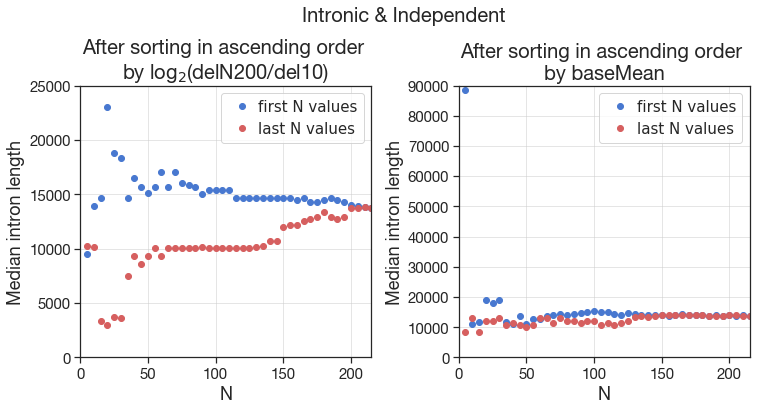

In [68]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.3)

ax[0].plot(head_log2FC_II.keys(), head_log2FC_II.values(), 'bo', label='first N values')
ax[0].plot(tail_log2FC_II.keys(), tail_log2FC_II.values(), 'ro', label='last N values')

ax[0].set_xlim(0,215)
ax[0].set_ylim(0,25000)
ax[0].set_xlabel("N", fontproperties=helvetica_18)
ax[0].set_ylabel("Median intron length",  fontproperties=helvetica_18)
ax[0].set_title("After sorting in ascending order \nby log$_2$(delN200/del10)",  fontproperties=helvetica_20)
ax[0].legend(loc='upper right', fontsize=15, numpoints=1, handletextpad=0.1)
                
ax[1].plot(head_baseMean_II.keys(), head_baseMean_II.values(), 'bo', label='first N values')
ax[1].plot(tail_baseMean_II.keys(), tail_baseMean_II.values(), 'ro', label='last N values')

ax[1].set_xlim(0,215)
ax[1].set_ylim(0,90000)
ax[1].set_xlabel("N", fontproperties=helvetica_18)
ax[1].set_ylabel("Median intron length",  fontproperties=helvetica_18)
ax[1].set_title("After sorting in ascending order \nby baseMean",  fontproperties=helvetica_20)
ax[1].legend(loc='upper right', fontsize=15, numpoints=1, handletextpad=0.1)
    
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax[0].grid(axis='y', alpha=0.5)
ax[0].grid(axis='x', alpha=0.5)

ax[1].grid(axis='y', alpha=0.5)
ax[1].grid(axis='x', alpha=0.5)

plt.suptitle("Intronic & Independent", fontproperties=helvetica_20, y =1.1)

plt.show()


##### Draw box plots
3 groups

In [69]:
II_box=II_len.sort_values(by='log2FoldChange')[["baseMean", "log2FoldChange","intron_len"]]
II_box.head()

baseMean  log2FoldChange  intron_len
mature                                                 
hsa-miR-576-5p    46.952529       -4.665471      9545.0
hsa-miR-627-5p    10.955172       -4.628700      8066.0
hsa-miR-1296-5p  126.130512       -4.441941    115553.0
hsa-miR-548k       8.353730       -4.331244     51965.0
hsa-miR-4326      14.357294       -4.329661      1121.0

In [70]:
II_box["log2FC_group"] = \
pd.qcut(II_box["log2FoldChange"], 3, labels=['Group 1', 'Group 2','Group 3'])

II_box["baseMean_group"] = \
pd.qcut(II_box["baseMean"], 3, labels=['Group 1', 'Group 2','Group 3'])

In [71]:
II_box.head()

baseMean  log2FoldChange  intron_len log2FC_group  \
mature                                                                 
hsa-miR-576-5p    46.952529       -4.665471      9545.0      Group 1   
hsa-miR-627-5p    10.955172       -4.628700      8066.0      Group 1   
hsa-miR-1296-5p  126.130512       -4.441941    115553.0      Group 1   
hsa-miR-548k       8.353730       -4.331244     51965.0      Group 1   
hsa-miR-4326      14.357294       -4.329661      1121.0      Group 1   

                baseMean_group  
mature                          
hsa-miR-576-5p         Group 3  
hsa-miR-627-5p         Group 2  
hsa-miR-1296-5p        Group 3  
hsa-miR-548k           Group 2  
hsa-miR-4326           Group 2

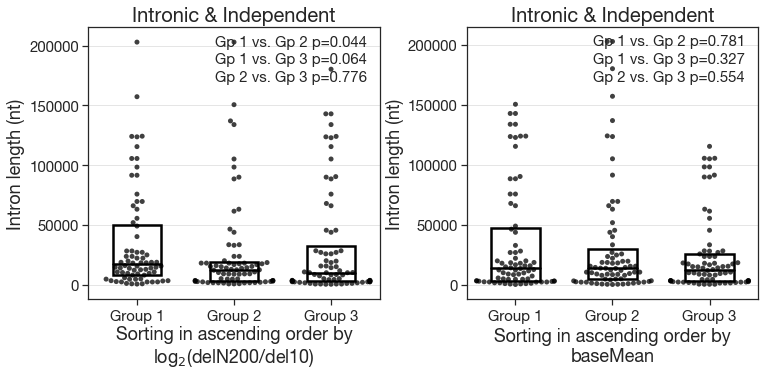

In [72]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.3)

# ax[0]
sns.swarmplot(x="log2FC_group", y = "intron_len", data=II_box, size=5, color='black', alpha=0.75, ax=ax[0])
sns.boxplot(x='log2FC_group', y = "intron_len", data=II_box, width=0.5,showcaps=False, ax=ax[0],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p00 = mannwhitneyu(II_box[II_box["log2FC_group"] == 'Group 1']["intron_len"], 
                   II_box[II_box["log2FC_group"] == 'Group 2']["intron_len"], alternative='two-sided')[1]
p01 = mannwhitneyu(II_box[II_box["log2FC_group"] == 'Group 1']["intron_len"], 
                   II_box[II_box["log2FC_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1]
p02 = mannwhitneyu(II_box[II_box["log2FC_group"] == 'Group 2']["intron_len"], 
                   II_box[II_box["log2FC_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1] 
ax[0].text(0.8,200000,'Gp 1 vs. Gp 2 p=%.3f'%p00,  fontproperties=helvetica_15)
ax[0].text(0.8,185000,'Gp 1 vs. Gp 3 p=%.3f'%p01,  fontproperties=helvetica_15)
ax[0].text(0.8,170000,'Gp 2 vs. Gp 3 p=%.3f'%p02,  fontproperties=helvetica_15)

plt.setp(ax[0].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[0].lines, color='black') # Change box edgecolor

ax[0].set_title("Intronic & Independent", fontproperties=helvetica_20)
ax[0].set_xlabel("Sorting in ascending order by\nlog$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[0].set_ylabel("Intron length (nt)", fontproperties=helvetica_18)
    
ax[0].grid(axis='y', alpha=0.5)

# ax[1]
sns.swarmplot(x="baseMean_group", y = "intron_len", data=II_box, size=5, color='black', alpha=0.75, ax=ax[1])
sns.boxplot(x='baseMean_group', y = "intron_len", data=II_box, color='black', width=0.5,showcaps=False, ax=ax[1],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p10 = mannwhitneyu(II_box[II_box["baseMean_group"] == 'Group 1']["intron_len"], 
                   II_box[II_box["baseMean_group"] == 'Group 2']["intron_len"], alternative='two-sided')[1]
p11 = mannwhitneyu(II_box[II_box["baseMean_group"] == 'Group 1']["intron_len"], 
                   II_box[II_box["baseMean_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1]
p12 = mannwhitneyu(II_box[II_box["baseMean_group"] == 'Group 2']["intron_len"], 
                   II_box[II_box["baseMean_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1] 
ax[1].text(0.8,200000,'Gp 1 vs. Gp 2 p=%.3f'%p10,  fontproperties=helvetica_15)
ax[1].text(0.8,185000,'Gp 1 vs. Gp 3 p=%.3f'%p11,  fontproperties=helvetica_15)
ax[1].text(0.8,170000,'Gp 2 vs. Gp 3 p=%.3f'%p12,  fontproperties=helvetica_15)

plt.setp(ax[1].artists, edgecolor = 'black')                          
plt.setp(ax[1].lines, color='black')

ax[1].set_title("Intronic & Independent", fontproperties=helvetica_20)
ax[1].set_xlabel("Sorting in ascending order by\nbaseMean", fontproperties=helvetica_18)
ax[1].set_ylabel("Intron length (nt)", fontproperties=helvetica_18)
    
ax[1].grid(axis='y', alpha=0.5)


for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)


plt.show()

4 groups

In [73]:
II_box=II_len.sort_values(by='log2FoldChange')[["baseMean", "log2FoldChange","intron_len"]]
II_box.head()

baseMean  log2FoldChange  intron_len
mature                                                 
hsa-miR-576-5p    46.952529       -4.665471      9545.0
hsa-miR-627-5p    10.955172       -4.628700      8066.0
hsa-miR-1296-5p  126.130512       -4.441941    115553.0
hsa-miR-548k       8.353730       -4.331244     51965.0
hsa-miR-4326      14.357294       -4.329661      1121.0

In [74]:
II_box["log2FC_group"] = \
pd.qcut(II_box["log2FoldChange"], 4, labels=['Group 1', 'Group 2', 'Group 3', 'Group 4'])

II_box["baseMean_group"] = \
pd.qcut(II_box["baseMean"], 4, labels=['Group 1', 'Group 2', 'Group 3', 'Group 4'])

In [75]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.3)

# ax[0]
sns.swarmplot(x="log2FC_group", y = "intron_len", data=II_box, size=5, color='black', alpha=0.75, ax=ax[0])
sns.boxplot(x='log2FC_group', y = "intron_len", data=II_box, width=0.5,showcaps=False, ax=ax[0],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p00 = mannwhitneyu(II_box[II_box["log2FC_group"] == 'Group 1']["intron_len"], 
                   II_box[II_box["log2FC_group"] == 'Group 2']["intron_len"], alternative='two-sided')[1]
p01 = mannwhitneyu(II_box[II_box["log2FC_group"] == 'Group 1']["intron_len"], 
                   II_box[II_box["log2FC_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1]
p02 = mannwhitneyu(II_box[II_box["log2FC_group"] == 'Group 1']["intron_len"], 
                   II_box[II_box["log2FC_group"] == 'Group 4']["intron_len"], alternative='two-sided')[1]
p03 = mannwhitneyu(II_box[II_box["log2FC_group"] == 'Group 2']["intron_len"], 
                   II_box[II_box["log2FC_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1]
p04 = mannwhitneyu(II_box[II_box["log2FC_group"] == 'Group 2']["intron_len"], 
                   II_box[II_box["log2FC_group"] == 'Group 4']["intron_len"], alternative='two-sided')[1]
p05 = mannwhitneyu(II_box[II_box["log2FC_group"] == 'Group 3']["intron_len"], 
                   II_box[II_box["log2FC_group"] == 'Group 4']["intron_len"], alternative='two-sided')[1]
ax[0].text(1.3,200000,'Gp 1 vs. Gp 2 p=%.3f'%p00,  fontproperties=helvetica_15)
ax[0].text(1.3,185000,'Gp 1 vs. Gp 3 p=%.3f'%p01,  fontproperties=helvetica_15)
ax[0].text(1.3,170000,'Gp 1 vs. Gp 4 p=%.3f'%p02,  fontproperties=helvetica_15)
ax[0].text(1.3,155000,'Gp 2 vs. Gp 3 p=%.3f'%p03,  fontproperties=helvetica_15)
ax[0].text(1.3,140000,'Gp 2 vs. Gp 4 p=%.3f'%p04,  fontproperties=helvetica_15)
ax[0].text(1.3,125000,'Gp 3 vs. Gp 4 p=%.3f'%p05,  fontproperties=helvetica_15)

plt.setp(ax[0].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[0].lines, color='black') # Change box edgecolor

ax[0].set_title("Intronic & Independent", fontproperties=helvetica_20)
ax[0].set_xlabel("Sorting in ascending order by\nlog$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[0].set_ylabel("Intron length (nt)", fontproperties=helvetica_18)
    
ax[0].grid(axis='y', alpha=0.5)

# ax[1]
sns.swarmplot(x="baseMean_group", y = "intron_len", data=II_box, size=5, color='black', alpha=0.75, ax=ax[1])
sns.boxplot(x='baseMean_group', y = "intron_len", data=II_box, color='black', width=0.5,showcaps=False, ax=ax[1],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p10 = mannwhitneyu(II_box[II_box["baseMean_group"] == 'Group 1']["intron_len"], 
                   II_box[II_box["baseMean_group"] == 'Group 2']["intron_len"], alternative='two-sided')[1]
p11 = mannwhitneyu(II_box[II_box["baseMean_group"] == 'Group 1']["intron_len"], 
                   II_box[II_box["baseMean_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1]
p12 = mannwhitneyu(II_box[II_box["baseMean_group"] == 'Group 1']["intron_len"], 
                   II_box[II_box["baseMean_group"] == 'Group 4']["intron_len"], alternative='two-sided')[1]
p13 = mannwhitneyu(II_box[II_box["baseMean_group"] == 'Group 2']["intron_len"], 
                   II_box[II_box["baseMean_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1]
p14 = mannwhitneyu(II_box[II_box["baseMean_group"] == 'Group 2']["intron_len"], 
                   II_box[II_box["baseMean_group"] == 'Group 4']["intron_len"], alternative='two-sided')[1]
p15 = mannwhitneyu(II_box[II_box["baseMean_group"] == 'Group 3']["intron_len"], 
                   II_box[II_box["baseMean_group"] == 'Group 4']["intron_len"], alternative='two-sided')[1]
ax[1].text(1.3,200000,'Gp 1 vs. Gp 2 p=%.3f'%p10,  fontproperties=helvetica_15)
ax[1].text(1.3,185000,'Gp 1 vs. Gp 3 p=%.3f'%p11,  fontproperties=helvetica_15)
ax[1].text(1.3,170000,'Gp 1 vs. Gp 4 p=%.3f'%p12,  fontproperties=helvetica_15)
ax[1].text(1.3,155000,'Gp 2 vs. Gp 3 p=%.3f'%p13,  fontproperties=helvetica_15)
ax[1].text(1.3,140000,'Gp 2 vs. Gp 4 p=%.3f'%p14,  fontproperties=helvetica_15)
ax[1].text(1.3,125000,'Gp 3 vs. Gp 4 p=%.3f'%p15,  fontproperties=helvetica_15)

plt.setp(ax[1].artists, edgecolor = 'black')                          
plt.setp(ax[1].lines, color='black')

ax[1].set_title("Intronic & Independent", fontproperties=helvetica_20)
ax[1].set_xlabel("Sorting in ascending order by\nbaseMean", fontproperties=helvetica_18)
ax[1].set_ylabel("Intron length (nt)", fontproperties=helvetica_18)
    
ax[1].grid(axis='y', alpha=0.5)


for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)


plt.show()

In [856]:
# A: intronic miRNA region
# B: intron regions of genomes

IC_intersect = pybedtools.BedTool(IC_bed).intersect(genome_bed, wa=True, wb=True, f=1)
IC_intersect = pybedtools.BedTool.to_dataframe(IC_intersect)
print(IC_intersect.shape)
IC_intersect.head()

(162, 12)


chrom      start        end             name  score strand thickStart  \
0  chrX   53557191   53557274  hsa-let-7f-2-3p      0      -       chrX   
1  chr7  100093992  100094074  hsa-miR-106b-3p      0      -       chr7   
2  chr7  100093992  100094074  hsa-miR-106b-3p      0      -       chr7   
3  chr7  100093992  100094074  hsa-miR-106b-3p      0      -       chr7   
4  chr7  100093992  100094074  hsa-miR-106b-5p      0      -       chr7   

    thickEnd    itemRgb                                blockCount  blockSizes  \
0   53554920   53557381     NM_031407_intron_23_0_chrX_53554921_r           0   
1  100093401  100094172  NM_001278595_intron_1_0_chr7_100093402_r           0   
2  100093401  100094172     NM_005916_intron_1_0_chr7_100093402_r           0   
3  100093401  100094172     NM_182776_intron_1_0_chr7_100093402_r           0   
4  100093401  100094172  NM_001278595_intron_1_0_chr7_100093402_r           0   

  blockStarts  
0           -  
1           -  
2           -  
3           -  
4           -

In [857]:
# Change the column names of intersect_df
IC_intersect = \
IC_intersect.rename(columns={'chrom' : 'miR_chr', 'start' : 'miR_start', 'end' : 'miR_end', 'name' : 'mature', 'strand' : 'miR_strand', \
                             'thickStart' : 'intron_chr', 'thickEnd' : 'intron_start', 'itemRgb' : 'intron_end', 'blockCount' : 'intron', \
                             'blockStarts' : 'intron_strand'}).drop(['score', 'blockSizes'], axis=1)

In [858]:
IC_intersect["intron_len"] = IC_intersect["intron_end"] - IC_intersect["intron_start"]

In [859]:
IC_len=IC.join(IC_intersect.groupby(['mature'])['intron_len'].median(), how='inner')
print(IC_len.shape)
IC_len.head(20)

(56, 24)


baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                        
hsa-let-7f-2-3p     47.599577       -0.160113 -0.430125  0.667105  0.741902   
hsa-miR-106b-3p    360.939551       -0.598471 -2.498198  0.012483  0.034970   
hsa-miR-106b-5p   2614.410084       -0.254236 -1.151013  0.249727  0.344855   
hsa-miR-15b-3p     121.017202       -1.194717 -3.715968  0.000202  0.001389   
hsa-miR-15b-5p    1132.672698       -1.520852 -4.223929  0.000024  0.000226   
hsa-miR-16-2-3p    210.204790       -0.042679 -0.172402  0.863121  0.902466   
hsa-miR-188-3p       2.939385        0.537538  0.549969  0.582340  0.676326   
hsa-miR-188-5p      74.163173       -0.201068 -0.548624  0.583263  0.676327   
hsa-miR-224-3p       2.279282       -0.159419 -0.154811  0.876971       NaN   
hsa-miR-224-5p     158.818574       -0.129009 -0.534361  0.593092  0.685558   
hsa-miR-23b-3p     761.534240        0.076817  0.270781  0.786559  0.842824   
hsa-miR-23b-5p       6.684915        0.044085  0.066165  0.947246  0.971060   
hsa-miR-24-1-5p     16.584446       -0.238148 -0.454112  0.649748  0.728114   
hsa-miR-25-3p     4249.705849       -0.783204 -3.427641  0.000609  0.003238   
hsa-miR-25-5p       51.464642       -0.958315 -2.414354  0.015763  0.041029   
hsa-miR-27b-3p    1120.098584        0.062861  0.229091  0.818798  0.869751   
hsa-miR-27b-5p      18.438229       -0.019515 -0.041293  0.967062  0.983135   
hsa-miR-30c-1-3p    16.373048        0.229147  0.431423  0.666161  0.741902   
hsa-miR-30e-3p     250.273191       -1.041345 -3.609320  0.000307  0.001910   
hsa-miR-30e-5p    2240.084020       -1.013596 -4.540505  0.000006  0.000070   

                 curated DROSHA dependency (HCT116) 5p3p      pri-miRNA   Chr  \
mature                                                                          
hsa-let-7f-2-3p                    DROSHA-dependent   3p   hsa-let-7f-2  chrX   
hsa-miR-106b-3p                    DROSHA-dependent   3p   hsa-mir-106b  chr7   
hsa-miR-106b-5p                    DROSHA-dependent   5p   hsa-mir-106b  chr7   
hsa-miR-15b-3p                     DROSHA-dependent   3p    hsa-mir-15b  chr3   
hsa-miR-15b-5p                     DROSHA-dependent   5p    hsa-mir-15b  chr3   
hsa-miR-16-2-3p                    DROSHA-dependent   3p   hsa-mir-16-2  chr3   
hsa-miR-188-3p                     DROSHA-dependent   3p    hsa-mir-188  chrX   
hsa-miR-188-5p                     DROSHA-dependent   5p    hsa-mir-188  chrX   
hsa-miR-224-3p                     DROSHA-dependent   3p    hsa-mir-224  chrX   
hsa-miR-224-5p                     DROSHA-dependent   5p    hsa-mir-224  chrX   
hsa-miR-23b-3p                     DROSHA-dependent   3p    hsa-mir-23b  chr9   
hsa-miR-23b-5p                     DROSHA-dependent   5p    hsa-mir-23b  chr9   
hsa-miR-24-1-5p                    DROSHA-dependent   5p   hsa-mir-24-1  chr9   
hsa-miR-25-3p                      DROSHA-dependent   3p     hsa-mir-25  chr7   
hsa-miR-25-5p                      DROSHA-dependent   5p     hsa-mir-25  chr7   
hsa-miR-27b-3p                     DROSHA-dependent   3p    hsa-mir-27b  chr9   
hsa-miR-27b-5p                     DROSHA-dependent   5p    hsa-mir-27b  chr9   
hsa-miR-30c-1-3p                   DROSHA-dependent   3p  hsa-mir-30c-1  chr1   
hsa-miR-30e-3p                     DROSHA-dependent   3p    hsa-mir-30e  chr1   
hsa-miR-30e-5p                     DROSHA-dependent   5p    hsa-mir-30e  chr1   

                    pri Start     ...      Exon_Intron HostGene Direction  \
mature                            ...                                       
hsa-let-7f-2-3p    53557191.0     ...         intronic    HUWE1        --   
hsa-miR-106b-3p   100093992.0     ...         intronic     MCM7        --   
hsa-miR-106b-5p   100093992.0     ...         intronic     MCM7        --   
hsa-miR-15b-3p    160404587.0     ...         intronic     SMC4        ++   
hsa-miR-15b-5p    160404587.0     ...

In [860]:
baseMean_IC_len = IC_len.sort_values(by='baseMean')["intron_len"]

head_baseMean_IC = {}
tail_baseMean_IC = {}

for i in range(6,len(baseMean_IC_len)+1,5):
    head_baseMean_IC[i]=baseMean_IC_len.head(i).median()
    tail_baseMean_IC[i]=baseMean_IC_len.tail(i).median()

In [861]:
log2FC_IC_len = IC_len.sort_values(by='log2FoldChange')["intron_len"]

head_log2FC_IC = {}
tail_log2FC_IC = {}

for i in range(6,len(log2FC_IC_len)+1,5):
    head_log2FC_IC[i]=log2FC_IC_len.head(i).median()
    tail_log2FC_IC[i]=log2FC_IC_len.tail(i).median()

log2FC_IC_len.head(5)

mature
hsa-miR-449c-5p     25731
hsa-miR-3176        10674
hsa-miR-653-5p       7423
hsa-miR-502-3p     117001
hsa-miR-500a-3p    117001
Name: intron_len, dtype: int64

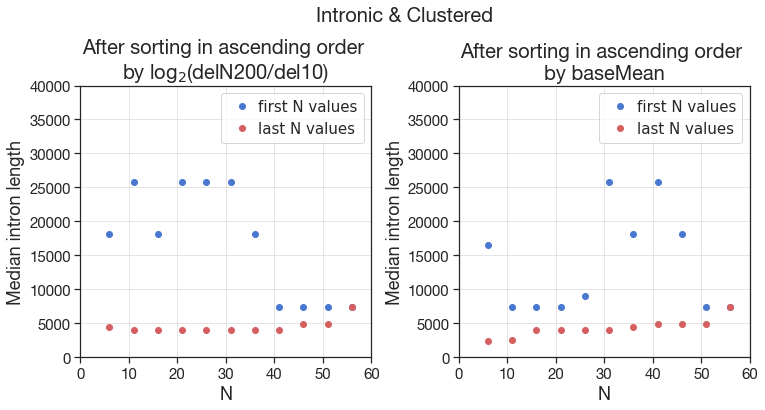

In [862]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.3)

ax[0].plot(head_log2FC_IC.keys(), head_log2FC_IC.values(), 'bo', label='first N values')
ax[0].plot(tail_log2FC_IC.keys(), tail_log2FC_IC.values(), 'ro', label='last N values')

ax[0].set_xlim(0,60)
ax[0].set_ylim(0,40000)
ax[0].set_xlabel("N", fontproperties=helvetica_18)
ax[0].set_ylabel("Median intron length",  fontproperties=helvetica_18)
ax[0].set_title("After sorting in ascending order \nby log$_2$(delN200/del10)",  fontproperties=helvetica_20)
ax[0].legend(loc='upper right', fontsize=15, numpoints=1, handletextpad=0.1)
                
ax[1].plot(head_baseMean_IC.keys(), head_baseMean_IC.values(), 'bo', label='first N values')
ax[1].plot(tail_baseMean_IC.keys(), tail_baseMean_IC.values(), 'ro', label='last N values')

ax[1].set_xlim(0,60)
ax[1].set_ylim(0,40000)
ax[1].set_xlabel("N", fontproperties=helvetica_18)
ax[1].set_ylabel("Median intron length",  fontproperties=helvetica_18)
ax[1].set_title("After sorting in ascending order \nby baseMean",  fontproperties=helvetica_20)
ax[1].legend(loc='upper right', fontsize=15, numpoints=1, handletextpad=0.1)
    
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax[0].grid(axis='y', alpha=0.5)
ax[0].grid(axis='x', alpha=0.5)

ax[1].grid(axis='y', alpha=0.5)
ax[1].grid(axis='x', alpha=0.5)

plt.suptitle("Intronic & Clustered", fontproperties=helvetica_20, y =1.1)

plt.show()

With baseMean filter

In [1111]:
# A: intronic miRNA region
# B: intron regions of genomes

II_filtered_intersect = pybedtools.BedTool(II_filtered_bed).intersect(genome_bed, wa=True, wb=True, f=1)
II_filtered_intersect = pybedtools.BedTool.to_dataframe(II_filtered_intersect)
print(II_filtered_intersect.shape)
II_filtered_intersect.head(10)

(584, 12)


chrom     start       end             name  score strand thickStart  \
0   chr3  52268277  52268361    hsa-let-7g-3p      0      -       chr3   
1   chr3  52268277  52268361    hsa-let-7g-5p      0      -       chr3   
2  chr10  89592746  89592827      hsa-miR-107      0      -      chr10   
3  chr10  89592746  89592827      hsa-miR-107      0      -      chr10   
4  chr10  89592746  89592827      hsa-miR-107      0      -      chr10   
5  chr17  48579837  48579947   hsa-miR-10a-3p      0      -      chr17   
6  chr17  48579837  48579947   hsa-miR-10a-5p      0      -      chr17   
7  chr17  19344505  19344574  hsa-miR-1180-3p      0      -      chr17   
8  chr17  19344505  19344574  hsa-miR-1180-3p      0      -      chr17   
9  chr17  19344505  19344574  hsa-miR-1180-3p      0      -      chr17   

   thickEnd   itemRgb                                blockCount  blockSizes  \
0  52267018  52270711      NM_025222_intron_6_0_chr3_52267019_r           0   
1  52267018  52270711      NM_025222_intron_6_0_chr3_52267019_r           0   
2  89588777  89593196     NM_138316_intron_1_0_chr10_89588778_r           0   
3  89588777  89593196     NM_148977_intron_1_0_chr10_89588778_r           0   
4  89588777  89593196     NM_148978_intron_1_0_chr10_89588778_r           0   
5  48574014  48582291  NM_001330322_intron_3_0_chr17_48574015_r           0   
6  48574014  48582291  NM_001330322_intron_3_0_chr17_48574015_r           0   
7  19343857  19347268  NM_001321215_intron_0_0_chr17_19343858_r           0   
8  19343857  19347268  NM_001321214_intron_1_0_chr17_19343858_r           0   
9  19337748  19347268  NM_001321219_intron_0_0_chr17_19337749_r           0   

  blockStarts  
0           -  
1           -  
2           -  
3           -  
4           -  
5           -  
6           -  
7           -  
8           -  
9           -

In [1112]:
# Change the column names of intersect_filtered_df
II_filtered_intersect = \
II_filtered_intersect.rename(columns={'chrom' : 'miR_chr', 'start' : 'miR_start', 'end' : 'miR_end', 'name' : 'mature', 'strand' : 'miR_strand', \
                                      'thickStart' : 'intron_chr', 'thickEnd' : 'intron_start', 'itemRgb' : 'intron_end', 'blockCount' : 'intron', \
                                      'blockStarts' : 'intron_strand'}).drop(['score', 'blockSizes'], axis=1)

In [1113]:
II_filtered_intersect["intron_len"] = II_filtered_intersect["intron_end"] - II_filtered_intersect["intron_start"]
II_filtered_intersect.head()

miR_chr  miR_start   miR_end         mature miR_strand intron_chr  \
0    chr3   52268277  52268361  hsa-let-7g-3p          -       chr3   
1    chr3   52268277  52268361  hsa-let-7g-5p          -       chr3   
2   chr10   89592746  89592827    hsa-miR-107          -      chr10   
3   chr10   89592746  89592827    hsa-miR-107          -      chr10   
4   chr10   89592746  89592827    hsa-miR-107          -      chr10   

   intron_start  intron_end                                 intron  \
0      52267018    52270711   NM_025222_intron_6_0_chr3_52267019_r   
1      52267018    52270711   NM_025222_intron_6_0_chr3_52267019_r   
2      89588777    89593196  NM_138316_intron_1_0_chr10_89588778_r   
3      89588777    89593196  NM_148977_intron_1_0_chr10_89588778_r   
4      89588777    89593196  NM_148978_intron_1_0_chr10_89588778_r   

  intron_strand  intron_len  
0             -        3693  
1             -        3693  
2             -        4419  
3             -        4419  
4             -        4419

In [1114]:
II_filtered_len=II_filtered.join(II_filtered_intersect.groupby(['mature'])['intron_len'].median(), how='inner')
print(II_filtered_len.shape)
II_filtered_len.head()

(90, 24)


baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                      
hsa-let-7g-3p     47.297341       -0.355310 -0.867338  0.385757  0.479096   
hsa-let-7g-5p   4175.582999        0.184186  0.720868  0.470991  0.569534   
hsa-miR-107      769.030249       -0.374998 -1.898608  0.057616  0.109763   
hsa-miR-10a-3p   135.829597       -0.150893 -0.379841  0.704063  0.771775   
hsa-miR-10a-5p  4827.332874       -0.455479 -1.544774  0.122401  0.194464   

               curated DROSHA dependency (HCT116) 5p3p    pri-miRNA    Chr  \
mature                                                                       
hsa-let-7g-3p                    DROSHA-dependent   3p   hsa-let-7g   chr3   
hsa-let-7g-5p                    DROSHA-dependent   5p   hsa-let-7g   chr3   
hsa-miR-107                      DROSHA-dependent  NaN  hsa-mir-107  chr10   
hsa-miR-10a-3p                   DROSHA-dependent   3p  hsa-mir-10a  chr17   
hsa-miR-10a-5p                   DROSHA-dependent   5p  hsa-mir-10a  chr17   

                 pri Start     ...      Exon_Intron HostGene Direction  \
mature                         ...                                       
hsa-let-7g-3p   52268277.0     ...         intronic    WDR82        --   
hsa-let-7g-5p   52268277.0     ...         intronic    WDR82        --   
hsa-miR-107     89592746.0     ...         intronic    PANK1        --   
hsa-miR-10a-3p  48579837.0     ...         intronic    HOXB3        --   
hsa-miR-10a-5p  48579837.0     ...         intronic    HOXB3        --   

               stem length  loop simple loop    UG  CNNC    UGU  intron_len  
mature                                                                       
hsa-let-7g-3p         34.0  33.0        10.0    UG  CNNC  NoUGU      3693.0  
hsa-let-7g-5p         34.0  33.0        10.0    UG  CNNC  NoUGU      3693.0  
hsa-miR-107           38.0   5.0         5.0  NoUG  CNNC  NoUGU      4419.0  
hsa-miR-10a-3p        35.0  16.0        16.0    UG  CNNC    UGU      8277.0  
hsa-miR-10a-5p        35.0  16.0        16.0    UG  CNNC    UGU      8277.0  

[5 rows x 24 columns]

In [1115]:
baseMean_II_filtered_len = II_filtered_len.sort_values(by='baseMean')["intron_len"]

head_baseMean_II_filtered = {}
tail_baseMean_II_filtered = {}

for i in range(5,len(baseMean_II_filtered_len)+1,5):
    head_baseMean_II_filtered[i]=baseMean_II_filtered_len.head(i).median()
    tail_baseMean_II_filtered[i]=baseMean_II_filtered_len.tail(i).median()

In [1116]:
log2FC_II_filtered_len = II_filtered_len.sort_values(by='log2FoldChange')["intron_len"]

head_log2FC_II_filtered = {}
tail_log2FC_II_filtered = {}

for i in range(5,len(log2FC_II_filtered_len)+1,5):
    head_log2FC_II_filtered[i]=log2FC_II_filtered_len.head(i).median()
    tail_log2FC_II_filtered[i]=log2FC_II_filtered_len.tail(i).median()

In [1117]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.3)

ax[0].plot(head_log2FC_II_filtered.keys(), head_log2FC_II_filtered.values(), 'bo', label='first N values')
ax[0].plot(tail_log2FC_II_filtered.keys(), tail_log2FC_II_filtered.values(), 'ro', label='last N values')

ax[0].set_xlim(0,92)
ax[0].set_ylim(0,25000)
ax[0].set_xlabel("N", fontproperties=helvetica_18)
ax[0].set_ylabel("Median intron length",  fontproperties=helvetica_18)
ax[0].set_title("After sorting in ascending order \nby log$_2$(delN200/del10)",  fontproperties=helvetica_20)
ax[0].legend(loc='lower right', fontsize=15, numpoints=1, handletextpad=0.1)
                
ax[1].plot(head_baseMean_II_filtered.keys(), head_baseMean_II_filtered.values(), 'bo', label='first N values')
ax[1].plot(tail_baseMean_II_filtered.keys(), tail_baseMean_II_filtered.values(), 'ro', label='last N values')

ax[1].set_xlim(0,92)
ax[1].set_ylim(0,16000)
ax[1].set_xlabel("N", fontproperties=helvetica_18)
ax[1].set_ylabel("Median intron length",  fontproperties=helvetica_18)
ax[1].set_title("After sorting in ascending order \nby baseMean", fontproperties=helvetica_20)
ax[1].legend(loc='lower right', fontsize=15, numpoints=1, handletextpad=0.1)
    
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax[0].grid(axis='y', alpha=0.5)
ax[0].grid(axis='x', alpha=0.5)

ax[1].grid(axis='y', alpha=0.5)
ax[1].grid(axis='x', alpha=0.5)

plt.suptitle("Intronic & Independent", fontproperties=helvetica_20, y =1.1)

fig.show()
#plt.savefig("Results/200730_HCT116_intron_length.pdf", bbox_inches='tight')

NameError: name 'helvetica_18' is not defined

In [1120]:
II_filtered_len.sort_values(by='intron_len')

baseMean  log2FoldChange       stat        pvalue  \
mature                                                                  
hsa-miR-499a-5p    19.893650        0.062594   0.128753  8.975529e-01   
hsa-miR-126-3p    696.887445        0.448236   1.483785  1.378661e-01   
hsa-miR-126-5p    336.358082        0.285670   0.944165  3.450853e-01   
hsa-miR-26b-3p     15.241138       -0.016313  -0.031677  9.747294e-01   
hsa-miR-26b-5p   1933.594997        0.358210   1.704308  8.832365e-02   
hsa-miR-152-3p     13.110156       -1.372430  -2.110631  3.480401e-02   
hsa-miR-7-1-3p    111.265242       -0.914741  -2.585156  9.733482e-03   
hsa-miR-4326       14.357294       -4.329661  -4.366806  1.260768e-05   
hsa-miR-335-5p    109.275728       -0.242273  -0.678561  4.974158e-01   
hsa-miR-335-3p     91.033474       -0.243463  -0.496794  6.193344e-01   
hsa-miR-483-5p     35.863032       -0.649233  -1.710579  8.715878e-02   
hsa-miR-483-3p     97.443326       -1.179403  -3.980595  6.874285e-05   
hsa-miR-140-5p    163.082241       -0.513993  -1.427622  1.534008e-01   
hsa-miR-140-3p    475.112360       -0.762946  -3.373144  7.431501e-04   
hsa-miR-186-3p     15.112664       -1.865684  -2.674636  7.481033e-03   
hsa-miR-186-5p   1196.770351       -2.541007  -9.106938  8.473963e-20   
hsa-miR-491-5p     35.982640       -2.370742  -5.274349  1.332278e-07   
hsa-miR-942-5p     16.508010       -1.820943  -3.331142  8.649049e-04   
hsa-miR-33a-5p    307.314238        0.332862   0.556274  5.780234e-01   
hsa-miR-33a-3p     39.384957        0.338265   0.644202  5.194447e-01   
hsa-miR-330-5p    122.675207       -1.082767  -3.389973  6.989963e-04   
hsa-miR-330-3p    232.579749       -1.318831  -5.031983  4.854321e-07   
hsa-miR-1249-3p    14.534823       -0.895510  -1.748658  8.035020e-02   
hsa-miR-455-3p    181.985408       -0.370247  -1.289354  1.972752e-01   
hsa-miR-455-5p     57.558623       -0.012525  -0.025318  9.798010e-01   
hsa-miR-1180-3p   187.793940       -2.670234  -9.497589  2.148065e-21   
hsa-miR-1307-5p   961.478370       -0.796841  -3.368666  7.553279e-04   
hsa-miR-1307-3p  1301.328554       -0.546989  -2.703672  6.857788e-03   
hsa-let-7g-3p      47.297341       -0.355310  -0.867338  3.857570e-01   
hsa-let-7g-5p    4175.582999        0.184186   0.720868  4.709908e-01   
...                      ...             ...        ...           ...   
hsa-miR-339-5p    644.292114       -1.154295  -4.989605  6.050282e-07   
hsa-miR-629-5p     67.321117       -4.117190  -8.012116  1.127515e-15   
hsa-miR-135b-5p    34.023748       -1.158210  -2.245300  2.474890e-02   
hsa-miR-454-3p    329.725759       -3.022067  -9.513387  1.845545e-21   
hsa-miR-454-5p     13.494784       -2.419363  -3.676046  2.368765e-04   
hsa-miR-301a-3p  1260.083880       -0.558693  -1.543274  1.227642e-01   
hsa-miR-301a-5p    85.445273       -0.697884  -2.015341  4.386891e-02   
hsa-miR-342-3p    203.790783        0.288823   0.860880  3.893042e-01   
hsa-miR-340-5p    200.228260       -2.288248  -9.212721  3.179599e-20   
hsa-miR-340-3p     22.061634       -1.929305  -3.190276  1.421370e-03   
hsa-miR-1301-3p   123.688716       -3.533942  -9.096751  9.307452e-20   
hsa-miR-423-3p   2229.316230       -0.358194  -1.540250  1.234993e-01   
hsa-miR-423-5p    923.713247       -0.214314  -0.821229  4.115160e-01   
hsa-miR-139-5p    144.151834       -1.355742  -3.907483  9.326267e-05   
hsa-miR-139-3p     16.035342       -1.362094  -2.132549  3.296173e-02   
hsa-miR-577        18.099831       -2.336641  -3.642747  2.697439e-04   
hsa-miR-3200-3p   106.682987       -0.071027  -0.262811  7.926961e-01   
hsa-miR-551a       60.561960       -2.920220  -6.490679  8.545050e-11   
hsa-miR-326        50.191689       -0.598672  -1.839365  6.586145e-02   
hsa-miR-652-5p     13.282967       -1.166354  -1.984447  4.720601e-02   
hsa-miR-652-3p    213.527160       -1.660447  -6.437020  1.218419e-10   
hsa-miR-378a-3p  1262.429853       -0.830683  -3.210490  1.325091e-03   
hsa-m

##### Draw box plots

3 groups

In [483]:
II_filtered_len_box=II_filtered_len.sort_values(by='log2FoldChange')[["baseMean", "log2FoldChange","intron_len"]]
II_filtered_len_box.head()

baseMean  log2FoldChange  intron_len
mature                                                 
hsa-miR-576-5p    46.952529       -4.665471      9545.0
hsa-miR-1296-5p  126.130512       -4.441941    115553.0
hsa-miR-4326      14.357294       -4.329661      1121.0
hsa-miR-561-5p    55.569379       -4.190293     91596.0
hsa-miR-629-5p    67.321117       -4.117190     18373.0

In [81]:
II_filtered_len_box["log2FC_group"] = \
pd.qcut(II_filtered_len_box["log2FoldChange"], 3, labels=['Group 1', 'Group 2','Group 3'])

II_filtered_len_box["baseMean_group"] = \
pd.qcut(II_filtered_len_box["baseMean"], 3, labels=['Group 1', 'Group 2','Group 3'])

In [82]:
II_filtered_len_box.head()

baseMean  log2FoldChange  intron_len log2FC_group  \
mature                                                                 
hsa-miR-576-5p    46.952529       -4.665471      9545.0      Group 1   
hsa-miR-1296-5p  126.130512       -4.441941    115553.0      Group 1   
hsa-miR-4326      14.357294       -4.329661      1121.0      Group 1   
hsa-miR-561-5p    55.569379       -4.190293     91596.0      Group 1   
hsa-miR-629-5p    67.321117       -4.117190     18373.0      Group 1   

                baseMean_group  
mature                          
hsa-miR-576-5p         Group 1  
hsa-miR-1296-5p        Group 2  
hsa-miR-4326           Group 1  
hsa-miR-561-5p         Group 2  
hsa-miR-629-5p         Group 2

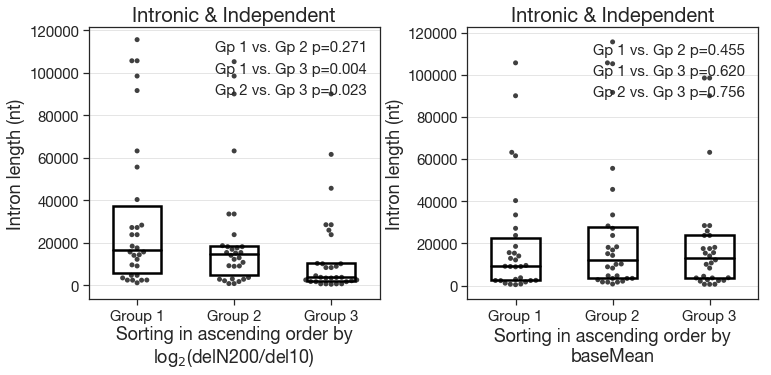

In [83]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.3)

# ax[0]
sns.swarmplot(x="log2FC_group", y = "intron_len", data=II_filtered_len_box, size=5, color='black', alpha=0.75, ax=ax[0])
sns.boxplot(x='log2FC_group', y = "intron_len", data=II_filtered_len_box, width=0.5,showcaps=False, ax=ax[0],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p00 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 1']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 2']["intron_len"], alternative='two-sided')[1]
p01 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 1']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1]
p02 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 2']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1] 
ax[0].text(0.8,110000,'Gp 1 vs. Gp 2 p=%.3f'%p00,  fontproperties=helvetica_15)
ax[0].text(0.8,100000,'Gp 1 vs. Gp 3 p=%.3f'%p01,  fontproperties=helvetica_15)
ax[0].text(0.8,90000,'Gp 2 vs. Gp 3 p=%.3f'%p02,  fontproperties=helvetica_15)

plt.setp(ax[0].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[0].lines, color='black') # Change box edgecolor

ax[0].set_title("Intronic & Independent", fontproperties=helvetica_20)
ax[0].set_xlabel("Sorting in ascending order by\nlog$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[0].set_ylabel("Intron length (nt)", fontproperties=helvetica_18)
    
ax[0].grid(axis='y', alpha=0.5)

# ax[1]
sns.swarmplot(x="baseMean_group", y = "intron_len", data=II_filtered_len_box, size=5, color='black', alpha=0.75, ax=ax[1])
sns.boxplot(x='baseMean_group', y = "intron_len", data=II_filtered_len_box, color='black', width=0.5,showcaps=False, ax=ax[1],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p10 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 1']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 2']["intron_len"], alternative='two-sided')[1]
p11 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 1']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1]
p12 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 2']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1] 
ax[1].text(0.8,110000,'Gp 1 vs. Gp 2 p=%.3f'%p10,  fontproperties=helvetica_15)
ax[1].text(0.8,100000,'Gp 1 vs. Gp 3 p=%.3f'%p11,  fontproperties=helvetica_15)
ax[1].text(0.8,90000,'Gp 2 vs. Gp 3 p=%.3f'%p12,  fontproperties=helvetica_15)

plt.setp(ax[1].artists, edgecolor = 'black')                          
plt.setp(ax[1].lines, color='black')

ax[1].set_title("Intronic & Independent", fontproperties=helvetica_20)
ax[1].set_xlabel("Sorting in ascending order by\nbaseMean", fontproperties=helvetica_18)
ax[1].set_ylabel("Intron length (nt)", fontproperties=helvetica_18)
    
ax[1].grid(axis='y', alpha=0.5)


for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)


plt.show()
# fig.savefig("Results/200824_HCT116_intron_len_gp3_box.pdf", bbox_inches='tight')
# fig.savefig("Results/200824_HCT116_intron_len_gp3_box.png", bbox_inches='tight')

4 groups

In [874]:
II_filtered_len_box=II_filtered_len.sort_values(by='log2FoldChange')[["baseMean", "log2FoldChange","intron_len"]]
II_filtered_len_box.head()

baseMean  log2FoldChange  intron_len
mature                                                 
hsa-miR-576-5p    46.952529       -4.665471      9545.0
hsa-miR-1296-5p  126.130512       -4.441941    115553.0
hsa-miR-4326      14.357294       -4.329661      1121.0
hsa-miR-561-5p    55.569379       -4.190293     91596.0
hsa-miR-629-5p    67.321117       -4.117190     18373.0

In [875]:
II_filtered_len_box["log2FC_group"] = \
pd.qcut(II_filtered_len_box["log2FoldChange"], 4, labels=['Group 1', 'Group 2', 'Group 3', 'Group 4'])

II_filtered_len_box["baseMean_group"] = \
pd.qcut(II_filtered_len_box["baseMean"], 4, labels=['Group 1', 'Group 2', 'Group 3', 'Group 4'])

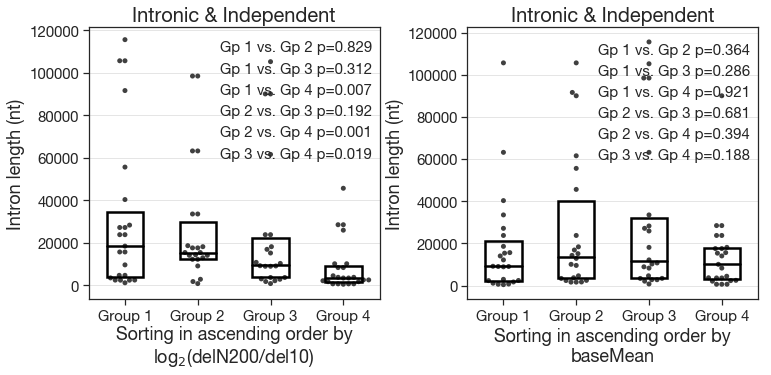

In [876]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.3)

# ax[0]
sns.swarmplot(x="log2FC_group", y = "intron_len", data=II_filtered_len_box, size=5, color='black', alpha=0.75, ax=ax[0])
sns.boxplot(x='log2FC_group', y = "intron_len", data=II_filtered_len_box, width=0.5,showcaps=False, ax=ax[0],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p00 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 1']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 2']["intron_len"], alternative='two-sided')[1]
p01 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 1']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1]
p02 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 1']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 4']["intron_len"], alternative='two-sided')[1]
p03 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 2']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1]
p04 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 2']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 4']["intron_len"], alternative='two-sided')[1]
p05 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 3']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 4']["intron_len"], alternative='two-sided')[1]
ax[0].text(1.3,110000,'Gp 1 vs. Gp 2 p=%.3f'%p00,  fontproperties=helvetica_15)
ax[0].text(1.3,100000,'Gp 1 vs. Gp 3 p=%.3f'%p01,  fontproperties=helvetica_15)
ax[0].text(1.3,90000,'Gp 1 vs. Gp 4 p=%.3f'%p02,  fontproperties=helvetica_15)
ax[0].text(1.3,80000,'Gp 2 vs. Gp 3 p=%.3f'%p03,  fontproperties=helvetica_15)
ax[0].text(1.3,70000,'Gp 2 vs. Gp 4 p=%.3f'%p04,  fontproperties=helvetica_15)
ax[0].text(1.3,60000,'Gp 3 vs. Gp 4 p=%.3f'%p05,  fontproperties=helvetica_15)

plt.setp(ax[0].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[0].lines, color='black') # Change box edgecolor

ax[0].set_title("Intronic & Independent", fontproperties=helvetica_20)
ax[0].set_xlabel("Sorting in ascending order by\nlog$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[0].set_ylabel("Intron length (nt)", fontproperties=helvetica_18)
    
ax[0].grid(axis='y', alpha=0.5)

# ax[1]
sns.swarmplot(x="baseMean_group", y = "intron_len", data=II_filtered_len_box, size=5, color='black', alpha=0.75, ax=ax[1])
sns.boxplot(x='baseMean_group', y = "intron_len", data=II_filtered_len_box, color='black', width=0.5,showcaps=False, ax=ax[1],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p10 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 1']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 2']["intron_len"], alternative='two-sided')[1]
p11 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 1']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1]
p12 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 1']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 4']["intron_len"], alternative='two-sided')[1]
p13 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 2']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 3']["intron_len"], alternative='two-sided')[1]
p14 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 2']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 4']["intron_len"], alternative='two-sided')[1]
p15 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 3']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 4']["intron_len"], alternative='two-sided')[1]
ax[1].text(1.3,110000,'Gp 1 vs. Gp 2 p=%.3f'%p10,  fontproperties=helvetica_15)
ax[1].text(1.3,100000,'Gp 1 vs. Gp 3 p=%.3f'%p11,  fontproperties=helvetica_15)
ax[1].text(1.3,90000,'Gp 1 vs. Gp 4 p=%.3f'%p12,  fontproperties=helvetica_15)
ax[1].text(1.3,80000,'Gp 2 vs. Gp 3 p=%.3f'%p13,  fontproperties=helvetica_15)
ax[1].text(1.3,70000,'Gp 2 vs. Gp 4 p=%.3f'%p14,  fontproperties=helvetica_15)
ax[1].text(1.3,60000,'Gp 3 vs. Gp 4 p=%.3f'%p15,  fontproperties=helvetica_15)

plt.setp(ax[1].artists, edgecolor = 'black')                          
plt.setp(ax[1].lines, color='black')

ax[1].set_title("Intronic & Independent", fontproperties=helvetica_20)
ax[1].set_xlabel("Sorting in ascending order by\nbaseMean", fontproperties=helvetica_18)
ax[1].set_ylabel("Intron length (nt)", fontproperties=helvetica_18)
    
ax[1].grid(axis='y', alpha=0.5)


for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)


plt.show()
# fig.savefig("Results/200824_HCT116_intron_len_gp4_box.pdf", bbox_inches='tight')
# fig.savefig("Results/200824_HCT116_intron_len_gp4_box.png", bbox_inches='tight')

2 groups

In [492]:
II_filtered_len_box=II_filtered_len.sort_values(by='log2FoldChange')[["baseMean", "log2FoldChange","intron_len"]]
II_filtered_len_box.tail()

baseMean  log2FoldChange  intron_len
mature                                                 
hsa-miR-342-3p   203.790783        0.288823     25880.0
hsa-miR-33a-5p   307.314238        0.332862      2471.0
hsa-miR-33a-3p    39.384957        0.338265      2471.0
hsa-miR-26b-5p  1933.594997        0.358210       629.0
hsa-miR-126-3p   696.887445        0.448236       619.0

In [485]:
II_filtered_len_box["log2FC_group"] = \
pd.qcut(II_filtered_len_box["log2FoldChange"], 2, labels=['Group 1', 'Group 2'])

II_filtered_len_box["baseMean_group"] = \
pd.qcut(II_filtered_len_box["baseMean"], 2, labels=['Group 1', 'Group 2'])

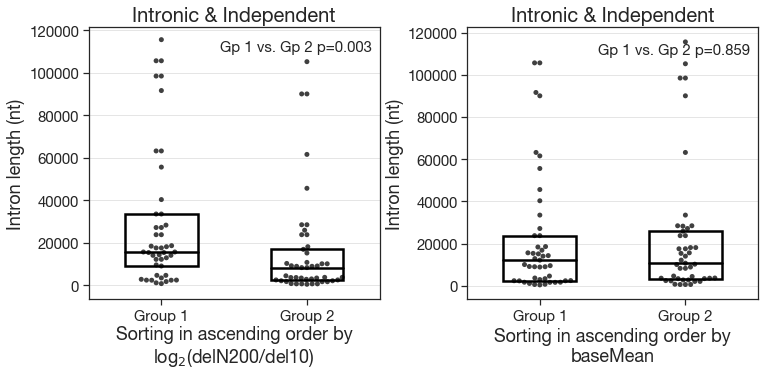

In [86]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.3)

# ax[0]
sns.swarmplot(x="log2FC_group", y = "intron_len", data=II_filtered_len_box, size=5, color='black', alpha=0.75, ax=ax[0])
sns.boxplot(x='log2FC_group', y = "intron_len", data=II_filtered_len_box, width=0.5,showcaps=False, ax=ax[0],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p00 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 1']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'Group 2']["intron_len"], alternative='two-sided')[1]

ax[0].text(0.4,110000,'Gp 1 vs. Gp 2 p=%.3f'%p00,  fontproperties=helvetica_15)


plt.setp(ax[0].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[0].lines, color='black') # Change box edgecolor

ax[0].set_title("Intronic & Independent", fontproperties=helvetica_20)
ax[0].set_xlabel("Sorting in ascending order by\nlog$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[0].set_ylabel("Intron length (nt)", fontproperties=helvetica_18)

ax[0].grid(axis='y', alpha=0.5)

# ax[1]
sns.swarmplot(x="baseMean_group", y = "intron_len", data=II_filtered_len_box, size=5, color='black', alpha=0.75, ax=ax[1])
sns.boxplot(x='baseMean_group', y = "intron_len", data=II_filtered_len_box, color='black', width=0.5,showcaps=False, ax=ax[1],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p10 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 1']["intron_len"], 
                   II_filtered_len_box[II_filtered_len_box["baseMean_group"] == 'Group 2']["intron_len"], alternative='two-sided')[1]

ax[1].text(0.4,110000,'Gp 1 vs. Gp 2 p=%.3f'%p10,  fontproperties=helvetica_15)


plt.setp(ax[1].artists, edgecolor = 'black')                          
plt.setp(ax[1].lines, color='black')

ax[1].set_title("Intronic & Independent", fontproperties=helvetica_20)
ax[1].set_xlabel("Sorting in ascending order by\nbaseMean", fontproperties=helvetica_18)
ax[1].set_ylabel("Intron length (nt)", fontproperties=helvetica_18)
    
ax[1].grid(axis='y', alpha=0.5)


for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)


plt.show()
# fig.savefig("Results/200824_HCT116_intron_len_gp2_box.pdf", bbox_inches='tight')
# fig.savefig("Results/200824_HCT116_intron_len_gp2_box.png", bbox_inches='tight')

For 201023 datameeting

In [493]:
II_filtered_len_box=II_filtered_len.sort_values(by='log2FoldChange')[["baseMean", "log2FoldChange","intron_len"]]

II_filtered_len_box["log2FC_group"] = \
pd.qcut(II_filtered_len_box["log2FoldChange"], 2, labels=['more dependent', 'less dependent'])

In [507]:
fig, ax = plt.subplots(1,1, figsize = (5,5))

sns.swarmplot(x="log2FC_group", y = "intron_len", data=II_filtered_len_box, size=5, color='black', alpha=0.75, ax=ax)
sns.boxplot(x='log2FC_group', y = "intron_len", data=II_filtered_len_box, width=0.5,showcaps=False, ax=ax,\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p0 = mannwhitneyu(II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'more dependent']["intron_len"], \
                  II_filtered_len_box[II_filtered_len_box["log2FC_group"] == 'less dependent']["intron_len"], alternative='two-sided')[1]

ax.text(0.3,40000,'p = %.3f'%p0,  fontproperties=helvetica_15)


plt.setp(ax.artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax.lines, color='black') # Change box edgecolor

ax.set_title("Among Intronic & Stand-alone", fontproperties=helvetica_20)
ax.set_ylabel("Intron length (nt)", fontproperties=helvetica_18)
ax.set_xlabel('')

ax.grid(axis='y', alpha=0.5)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

fig.show()

#plt.savefig("Results/201014-data-intron-len-HCT116.pdf", bbox_inches='tight')

In [880]:
# A: intronic miRNA region
# B: intron regions of genomes

IC_filtered_intersect = pybedtools.BedTool(IC_filtered_bed).intersect(genome_bed, wa=True, wb=True, f=1)
IC_filtered_intersect = pybedtools.BedTool.to_dataframe(IC_filtered_intersect)
print(IC_filtered_intersect.shape)
IC_filtered_intersect.head()

(124, 12)


chrom      start        end             name  score strand thickStart  \
0  chrX   53557191   53557274  hsa-let-7f-2-3p      0      -       chrX   
1  chr7  100093992  100094074  hsa-miR-106b-3p      0      -       chr7   
2  chr7  100093992  100094074  hsa-miR-106b-3p      0      -       chr7   
3  chr7  100093992  100094074  hsa-miR-106b-3p      0      -       chr7   
4  chr7  100093992  100094074  hsa-miR-106b-5p      0      -       chr7   

    thickEnd    itemRgb                                blockCount  blockSizes  \
0   53554920   53557381     NM_031407_intron_23_0_chrX_53554921_r           0   
1  100093401  100094172  NM_001278595_intron_1_0_chr7_100093402_r           0   
2  100093401  100094172     NM_005916_intron_1_0_chr7_100093402_r           0   
3  100093401  100094172     NM_182776_intron_1_0_chr7_100093402_r           0   
4  100093401  100094172  NM_001278595_intron_1_0_chr7_100093402_r           0   

  blockStarts  
0           -  
1           -  
2           -  
3           -  
4           -

In [881]:
# Change the column names of intersect_filtered_df
IC_filtered_intersect = \
IC_filtered_intersect.rename(columns={'chrom' : 'miR_chr', 'start' : 'miR_start', 'end' : 'miR_end', 'name' : 'mature', 'strand' : 'miR_strand', \
                                      'thickStart' : 'intron_chr', 'thickEnd' : 'intron_start', 'itemRgb' : 'intron_end', 'blockCount' : 'intron', \
                                      'blockStarts' : 'intron_strand'}).drop(['score', 'blockSizes'], axis=1)

In [882]:
IC_filtered_intersect["intron_len"] = IC_filtered_intersect["intron_end"] - IC_filtered_intersect["intron_start"]

In [883]:
IC_filtered_len=IC_filtered.join(IC_filtered_intersect.groupby(['mature'])['intron_len'].median(), how='inner')
print(IC_filtered_len.shape)
IC_filtered_len.head()

(41, 24)


baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                       
hsa-let-7f-2-3p    47.599577       -0.160113 -0.430125  0.667105  0.741902   
hsa-miR-106b-3p   360.939551       -0.598471 -2.498198  0.012483  0.034970   
hsa-miR-106b-5p  2614.410084       -0.254236 -1.151013  0.249727  0.344855   
hsa-miR-15b-3p    121.017202       -1.194717 -3.715968  0.000202  0.001389   
hsa-miR-15b-5p   1132.672698       -1.520852 -4.223929  0.000024  0.000226   

                curated DROSHA dependency (HCT116) 5p3p     pri-miRNA   Chr  \
mature                                                                        
hsa-let-7f-2-3p                   DROSHA-dependent   3p  hsa-let-7f-2  chrX   
hsa-miR-106b-3p                   DROSHA-dependent   3p  hsa-mir-106b  chr7   
hsa-miR-106b-5p                   DROSHA-dependent   5p  hsa-mir-106b  chr7   
hsa-miR-15b-3p                    DROSHA-dependent   3p   hsa-mir-15b  chr3   
hsa-miR-15b-5p                    DROSHA-dependent   5p   hsa-mir-15b  chr3   

                   pri Start     ...      Exon_Intron HostGene Direction  \
mature                           ...                                       
hsa-let-7f-2-3p   53557191.0     ...         intronic    HUWE1        --   
hsa-miR-106b-3p  100093992.0     ...         intronic     MCM7        --   
hsa-miR-106b-5p  100093992.0     ...         intronic     MCM7        --   
hsa-miR-15b-3p   160404587.0     ...         intronic     SMC4        ++   
hsa-miR-15b-5p   160404587.0     ...         intronic     SMC4        ++   

                stem length  loop simple loop    UG    CNNC    UGU  intron_len  
mature                                                                          
hsa-let-7f-2-3p        34.0  26.0         3.0    UG    CNNC  NoUGU        2461  
hsa-miR-106b-3p        38.0   6.0         6.0  NoUG    CNNC  NoUGU         771  
hsa-miR-106b-5p        38.0   6.0         6.0  NoUG    CNNC  NoUGU         771  
hsa-miR-15b-3p         36.0  12.0        12.0  NoUG  NoCNNC  NoUGU       30500  
hsa-miR-15b-5p         36.0  12.0        12.0  NoUG  NoCNNC  NoUGU       30500  

[5 rows x 24 columns]

In [884]:
baseMean_IC_filtered_len = IC_filtered_len.sort_values(by='baseMean')["intron_len"]

head_baseMean_IC_filtered = {}
tail_baseMean_IC_filtered = {}

for i in range(2,len(baseMean_IC_filtered_len)+1,5):
    head_baseMean_IC_filtered[i]=baseMean_IC_filtered_len.head(i).median()
    tail_baseMean_IC_filtered[i]=baseMean_IC_filtered_len.tail(i).median()

In [885]:
log2FC_IC_filtered_len = IC_filtered_len.sort_values(by='log2FoldChange')["intron_len"]

head_log2FC_IC_filtered = {}
tail_log2FC_IC_filtered = {}

for i in range(2,len(log2FC_IC_filtered_len)+1,5):
    head_log2FC_IC_filtered[i]=log2FC_IC_filtered_len.head(i).median()
    tail_log2FC_IC_filtered[i]=log2FC_IC_filtered_len.tail(i).median()

In [886]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.3)

ax[0].plot(head_log2FC_IC_filtered.keys(), head_log2FC_IC_filtered.values(), 'bo', label='first N values')
ax[0].plot(tail_log2FC_IC_filtered.keys(), tail_log2FC_IC_filtered.values(), 'ro', label='last N values')

ax[0].set_xlim(0,40)
ax[0].set_ylim(0,35000)
ax[0].set_xlabel("N", fontproperties=helvetica_18)
ax[0].set_ylabel("Median intron length",  fontproperties=helvetica_18)
ax[0].set_title("After sorting in ascending order \nby log$_2$(delN200/del10)",  fontproperties=helvetica_20)
ax[0].legend(loc='upper right', fontsize=15, numpoints=1, handletextpad=0.1)
                
ax[1].plot(head_baseMean_IC_filtered.keys(), head_baseMean_IC_filtered.values(), 'bo', label='first N values')
ax[1].plot(tail_baseMean_IC_filtered.keys(), tail_baseMean_IC_filtered.values(), 'ro', label='last N values')

ax[1].set_xlim(0,40)
ax[1].set_ylim(0,35000)
ax[1].set_xlabel("N", fontproperties=helvetica_18)
ax[1].set_ylabel("Median intron length",  fontproperties=helvetica_18)
ax[1].set_title("After sorting in ascending order \nby baseMean", fontproperties=helvetica_20)
ax[1].legend(loc='upper right', fontsize=15, numpoints=1, handletextpad=0.1)
    
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax[0].grid(axis='y', alpha=0.5)
ax[0].grid(axis='x', alpha=0.5)

ax[1].grid(axis='y', alpha=0.5)
ax[1].grid(axis='x', alpha=0.5)

plt.suptitle("Intronic & Clustered", fontproperties=helvetica_20, y =1.1)

fig.show()
#plt.savefig("Results/200730_HCT116_intron_length.pdf", bbox_inches='tight')

--- 
### Among intronics & independent, see the distance from intron_start to pri_start and from pri_end to intron_end 

- pri_start and pri_end annotaiton from miRBase. Later pri_start and pri_end should be replaced with exact pre_start and pre_end (?)
- intron_start/end : 0-based, half-open
- miR_start/end : 0-based, half-open

In [1075]:
II_filtered_intersect.head()

NameError: name 'II_filtered_intersect' is not defined

In [514]:
### NEED TO THINK ABOUT THE STRANDNESS ### 

# If miRNA is in - strand, 
# dist_5SS = intron_end - miR-end
# dist_3SS = miR_start - intron_start

for i, row in II_filtered_intersect.iterrows():
    if row['miR_strand'] == '+':
        II_filtered_intersect.loc[i,"dist_5SS"] = row["miR_start"] - row["intron_start"]
    elif row['miR_strand'] == '-':
        II_filtered_intersect.loc[i,"dist_5SS"] = row["intron_end"] - row["miR_end"]

for i, row in II_filtered_intersect.iterrows():
    if row['miR_strand'] == '+':
        II_filtered_intersect.loc[i,"dist_3SS"] = row["intron_end"] - row["miR_end"]
    elif row['miR_strand'] == '-':
        II_filtered_intersect.loc[i,"dist_3SS"] = row["miR_start"] - row["intron_start"]
        
### BELOW IS WRONG CODE ###        
# II_filtered_intersect["dist_5SS"] = II_filtered_intersect["miR_start"] - II_filtered_intersect["intron_start"]
# II_filtered_intersect["dist_3SS"] = II_filtered_intersect["intron_end"] - II_filtered_intersect["miR_end"]

II_filtered_intersect.head()

miR_chr  miR_start   miR_end         mature miR_strand intron_chr  \
0    chr3   52268277  52268361  hsa-let-7g-3p          -       chr3   
1    chr3   52268277  52268361  hsa-let-7g-5p          -       chr3   
2   chr10   89592746  89592827    hsa-miR-107          -      chr10   
3   chr10   89592746  89592827    hsa-miR-107          -      chr10   
4   chr10   89592746  89592827    hsa-miR-107          -      chr10   

   intron_start  intron_end                                 intron  \
0      52267018    52270711   NM_025222_intron_6_0_chr3_52267019_r   
1      52267018    52270711   NM_025222_intron_6_0_chr3_52267019_r   
2      89588777    89593196  NM_138316_intron_1_0_chr10_89588778_r   
3      89588777    89593196  NM_148977_intron_1_0_chr10_89588778_r   
4      89588777    89593196  NM_148978_intron_1_0_chr10_89588778_r   

  intron_strand  intron_len  dist_5SS  dist_3SS  
0             -        3693    2350.0    1259.0  
1             -        3693    2350.0    1259.0  
2             -        4419     369.0    3969.0  
3             -        4419     369.0    3969.0  
4             -        4419     369.0    3969.0

In [515]:
II_filtered_5SS=II_filtered.join(II_filtered_intersect.groupby(['mature'])['dist_5SS'].median(), how='inner')
print(II_filtered_5SS.shape)
II_filtered_5SS.head()

(90, 24)


baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                      
hsa-let-7g-3p     47.297341       -0.355310 -0.867338  0.385757  0.479096   
hsa-let-7g-5p   4175.582999        0.184186  0.720868  0.470991  0.569534   
hsa-miR-107      769.030249       -0.374998 -1.898608  0.057616  0.109763   
hsa-miR-10a-3p   135.829597       -0.150893 -0.379841  0.704063  0.771775   
hsa-miR-10a-5p  4827.332874       -0.455479 -1.544774  0.122401  0.194464   

               curated DROSHA dependency (HCT116) 5p3p    pri-miRNA    Chr  \
mature                                                                       
hsa-let-7g-3p                    DROSHA-dependent   3p   hsa-let-7g   chr3   
hsa-let-7g-5p                    DROSHA-dependent   5p   hsa-let-7g   chr3   
hsa-miR-107                      DROSHA-dependent  NaN  hsa-mir-107  chr10   
hsa-miR-10a-3p                   DROSHA-dependent   3p  hsa-mir-10a  chr17   
hsa-miR-10a-5p                   DROSHA-dependent   5p  hsa-mir-10a  chr17   

                 pri Start    ...     Exon_Intron HostGene Direction  \
mature                        ...                                      
hsa-let-7g-3p   52268277.0    ...        intronic    WDR82        --   
hsa-let-7g-5p   52268277.0    ...        intronic    WDR82        --   
hsa-miR-107     89592746.0    ...        intronic    PANK1        --   
hsa-miR-10a-3p  48579837.0    ...        intronic    HOXB3        --   
hsa-miR-10a-5p  48579837.0    ...        intronic    HOXB3        --   

               stem length  loop simple loop    UG  CNNC    UGU  dist_5SS  
mature                                                                     
hsa-let-7g-3p         34.0  33.0        10.0    UG  CNNC  NoUGU    2350.0  
hsa-let-7g-5p         34.0  33.0        10.0    UG  CNNC  NoUGU    2350.0  
hsa-miR-107           38.0   5.0         5.0  NoUG  CNNC  NoUGU     369.0  
hsa-miR-10a-3p        35.0  16.0        16.0    UG  CNNC    UGU    2344.0  
hsa-miR-10a-5p        35.0  16.0        16.0    UG  CNNC    UGU    2344.0  

[5 rows x 24 columns]

In [516]:
II_filtered_3SS=II_filtered.join(II_filtered_intersect.groupby(['mature'])['dist_3SS'].median(), how='inner')
print(II_filtered_3SS.shape)
II_filtered_3SS.head()

(90, 24)


baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                      
hsa-let-7g-3p     47.297341       -0.355310 -0.867338  0.385757  0.479096   
hsa-let-7g-5p   4175.582999        0.184186  0.720868  0.470991  0.569534   
hsa-miR-107      769.030249       -0.374998 -1.898608  0.057616  0.109763   
hsa-miR-10a-3p   135.829597       -0.150893 -0.379841  0.704063  0.771775   
hsa-miR-10a-5p  4827.332874       -0.455479 -1.544774  0.122401  0.194464   

               curated DROSHA dependency (HCT116) 5p3p    pri-miRNA    Chr  \
mature                                                                       
hsa-let-7g-3p                    DROSHA-dependent   3p   hsa-let-7g   chr3   
hsa-let-7g-5p                    DROSHA-dependent   5p   hsa-let-7g   chr3   
hsa-miR-107                      DROSHA-dependent  NaN  hsa-mir-107  chr10   
hsa-miR-10a-3p                   DROSHA-dependent   3p  hsa-mir-10a  chr17   
hsa-miR-10a-5p                   DROSHA-dependent   5p  hsa-mir-10a  chr17   

                 pri Start    ...     Exon_Intron HostGene Direction  \
mature                        ...                                      
hsa-let-7g-3p   52268277.0    ...        intronic    WDR82        --   
hsa-let-7g-5p   52268277.0    ...        intronic    WDR82        --   
hsa-miR-107     89592746.0    ...        intronic    PANK1        --   
hsa-miR-10a-3p  48579837.0    ...        intronic    HOXB3        --   
hsa-miR-10a-5p  48579837.0    ...        intronic    HOXB3        --   

               stem length  loop simple loop    UG  CNNC    UGU  dist_3SS  
mature                                                                     
hsa-let-7g-3p         34.0  33.0        10.0    UG  CNNC  NoUGU    1259.0  
hsa-let-7g-5p         34.0  33.0        10.0    UG  CNNC  NoUGU    1259.0  
hsa-miR-107           38.0   5.0         5.0  NoUG  CNNC  NoUGU    3969.0  
hsa-miR-10a-3p        35.0  16.0        16.0    UG  CNNC    UGU    5823.0  
hsa-miR-10a-5p        35.0  16.0        16.0    UG  CNNC    UGU    5823.0  

[5 rows x 24 columns]

In [517]:
II_filtered_5SS_box=II_filtered_5SS.sort_values(by='log2FoldChange')[["baseMean", "log2FoldChange","dist_5SS"]]
II_filtered_5SS_box.tail()

II_filtered_3SS_box=II_filtered_3SS.sort_values(by='log2FoldChange')[["baseMean", "log2FoldChange","dist_3SS"]]
II_filtered_3SS_box.tail()

baseMean  log2FoldChange  dist_3SS
mature                                               
hsa-miR-342-3p   203.790783        0.288823   13785.0
hsa-miR-33a-5p   307.314238        0.332862    1957.0
hsa-miR-33a-3p    39.384957        0.338265    1957.0
hsa-miR-26b-5p  1933.594997        0.358210     312.0
hsa-miR-126-3p   696.887445        0.448236     263.0

In [92]:
II_filtered_5SS_box["log2FC_group"] = \
pd.qcut(II_filtered_5SS_box["log2FoldChange"], 2, labels=['Group 1', 'Group 2'])

II_filtered_5SS_box["baseMean_group"] = \
pd.qcut(II_filtered_5SS_box["baseMean"], 2, labels=['Group 1', 'Group 2'])



II_filtered_3SS_box["log2FC_group"] = \
pd.qcut(II_filtered_3SS_box["log2FoldChange"], 2, labels=['Group 1', 'Group 2'])

II_filtered_3SS_box["baseMean_group"] = \
pd.qcut(II_filtered_3SS_box["baseMean"], 2, labels=['Group 1', 'Group 2'])

In [94]:
### For BK 
#II_filtered_3SS_box.to_csv('Results/200910_3SS.csv')
#II_filtered_5SS_box.to_csv('Results/200910_5SS.csv')

In [115]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

# ax[0]
sns.swarmplot(x="log2FC_group", y = "dist_5SS", data=II_filtered_5SS_box, size=5, color='black', alpha=0.75, ax=ax[0])
sns.boxplot(x='log2FC_group', y = "dist_5SS", data=II_filtered_5SS_box, width=0.5,showcaps=False, ax=ax[0],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p00 = mannwhitneyu(II_filtered_5SS_box[II_filtered_5SS_box["log2FC_group"] == 'Group 1']["dist_5SS"], 
                   II_filtered_5SS_box[II_filtered_5SS_box["log2FC_group"] == 'Group 2']["dist_5SS"], alternative='two-sided')[1]

ax[0].text(0.3,75000,'Gp 1 vs. Gp 2 p=%.1e'%p00,  fontproperties=helvetica_15)


plt.setp(ax[0].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[0].lines, color='black') # Change box edgecolor

ax[0].set_title("Intronic & Independent", fontproperties=helvetica_20)
ax[0].set_xlabel("Sorting in ascending order by\nlog$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[0].set_ylabel("Distance from \nintron_start to pri_start (nt)", fontproperties=helvetica_18)
    
ax[0].grid(axis='y', alpha=0.5)


# ax[1]
sns.swarmplot(x="baseMean_group", y = "dist_5SS", data=II_filtered_5SS_box, size=5, color='black', alpha=0.75, ax=ax[1])
sns.boxplot(x='baseMean_group', y = "dist_5SS", data=II_filtered_5SS_box, color='black', width=0.5,showcaps=False, ax=ax[1],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p10 = mannwhitneyu(II_filtered_5SS_box[II_filtered_5SS_box["baseMean_group"] == 'Group 1']["dist_5SS"], 
                   II_filtered_5SS_box[II_filtered_5SS_box["baseMean_group"] == 'Group 2']["dist_5SS"], alternative='two-sided')[1]

ax[1].text(0.4,75000,'Gp 1 vs. Gp 2 p=%.3f'%p10,  fontproperties=helvetica_15)


plt.setp(ax[1].artists, edgecolor = 'black')                          
plt.setp(ax[1].lines, color='black')

ax[1].set_title("Intronic & Independent", fontproperties=helvetica_20)
ax[1].set_xlabel("Sorting in ascending order by\nbaseMean", fontproperties=helvetica_18)
ax[1].set_ylabel("Distance from \nintron_start to pri_start (nt)", fontproperties=helvetica_18)
    
ax[1].grid(axis='y', alpha=0.5)


for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)


plt.show()
# fig.savefig("Results/200824_HCT116_dist_5SS_gp2_box.pdf", bbox_inches='tight')
# fig.savefig("Results/200824_HCT116_dist_5SS_gp2_box.png", bbox_inches='tight')

In [116]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

# ax[0]
sns.swarmplot(x="log2FC_group", y = "dist_3SS", data=II_filtered_3SS_box, size=5, color='black', alpha=0.75, ax=ax[0])
sns.boxplot(x='log2FC_group', y = "dist_3SS", data=II_filtered_3SS_box, width=0.5,showcaps=False, ax=ax[0],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p00 = mannwhitneyu(II_filtered_3SS_box[II_filtered_3SS_box["log2FC_group"] == 'Group 1']["dist_3SS"], 
                   II_filtered_3SS_box[II_filtered_3SS_box["log2FC_group"] == 'Group 2']["dist_3SS"], alternative='two-sided')[1]

ax[0].text(0.4,100000,'Gp 1 vs. Gp 2 p=%.3f'%p00,  fontproperties=helvetica_15)


plt.setp(ax[0].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[0].lines, color='black') # Change box edgecolor

ax[0].set_title("Intronic & Independent", fontproperties=helvetica_20)
ax[0].set_xlabel("Sorting in ascending order by\nlog$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[0].set_ylabel("Distance from \npri_end to intron_end (nt)", fontproperties=helvetica_18)
    
ax[0].grid(axis='y', alpha=0.5)

# ax[1]
sns.swarmplot(x="baseMean_group", y = "dist_3SS", data=II_filtered_3SS_box, size=5, color='black', alpha=0.75, ax=ax[1])
sns.boxplot(x='baseMean_group', y = "dist_3SS", data=II_filtered_3SS_box, color='black', width=0.5,showcaps=False, ax=ax[1],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p10 = mannwhitneyu(II_filtered_3SS_box[II_filtered_3SS_box["baseMean_group"] == 'Group 1']["dist_3SS"], 
                   II_filtered_3SS_box[II_filtered_3SS_box["baseMean_group"] == 'Group 2']["dist_3SS"], alternative='two-sided')[1]

ax[1].text(0.4,100000,'Gp 1 vs. Gp 2 p=%.3f'%p10,  fontproperties=helvetica_15)


plt.setp(ax[1].artists, edgecolor = 'black')                          
plt.setp(ax[1].lines, color='black')

ax[1].set_title("Intronic & Independent", fontproperties=helvetica_20)
ax[1].set_xlabel("Sorting in ascending order by\nbaseMean", fontproperties=helvetica_18)
ax[1].set_ylabel("Distance from \npri_end to intron_end (nt)", fontproperties=helvetica_18)
    
ax[1].grid(axis='y', alpha=0.5)


for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)


plt.show()
# fig.savefig("Results/200824_HCT116_dist_3SS_gp2_box.pdf", bbox_inches='tight')
# fig.savefig("Results/200824_HCT116_dist_3SS_gp2_box.png", bbox_inches='tight')

In [430]:
del II, II_bed, II_box, II_len, II_intersect, II_filtered_3SS_box, II_filtered_5SS_box, II_filtered_bed, II_filtered_len_box, \
II_filtered_intersect, genome_bed, genome_df, IC, IC_bed, IC_filtered, IC_filtered_bed, II_filtered_3SS, II_filtered_5SS,\ 
II_filtered_len

NameError: name 'II_filtered_len_box' is not defined

for 201023 data meeting

In [518]:
II_filtered_5SS_box=II_filtered_5SS.sort_values(by='log2FoldChange')[["baseMean", "log2FoldChange","dist_5SS"]]
II_filtered_3SS_box=II_filtered_3SS.sort_values(by='log2FoldChange')[["baseMean", "log2FoldChange","dist_3SS"]]

II_filtered_5SS_box["log2FC_group"] = \
pd.qcut(II_filtered_5SS_box["log2FoldChange"], 2, labels=['more dependent', 'less dependent'])

II_filtered_3SS_box["log2FC_group"] = \
pd.qcut(II_filtered_3SS_box["log2FoldChange"], 2, labels=['more dependent', 'less dependent'])

In [534]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

# ax[0]
sns.swarmplot(x="log2FC_group", y = "dist_5SS", data=II_filtered_5SS_box, size=5, color='black', alpha=0.75, ax=ax[0])
sns.boxplot(x='log2FC_group', y = "dist_5SS", data=II_filtered_5SS_box, width=0.5,showcaps=False, ax=ax[0],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p00 = mannwhitneyu(II_filtered_5SS_box[II_filtered_5SS_box["log2FC_group"] == 'more dependent']["dist_5SS"], 
                   II_filtered_5SS_box[II_filtered_5SS_box["log2FC_group"] == 'less dependent']["dist_5SS"], alternative='two-sided')[1]

ax[0].text(0.3,40000,'p=%.1e'%p00,  fontproperties=helvetica_15)


plt.setp(ax[0].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[0].lines, color='black') # Change box edgecolor

ax[0].set_title("Distance from 5' ss", fontproperties=helvetica_20)
ax[0].set_xlabel("", fontproperties=helvetica_18)
ax[0].set_ylabel("Distance from \nintron_start to pri_start (nt)", fontproperties=helvetica_18)
    
ax[0].grid(axis='y', alpha=0.5)


# ax[1]
sns.swarmplot(x="log2FC_group", y = "dist_3SS", data=II_filtered_3SS_box, size=5, color='black', alpha=0.75, ax=ax[1])
sns.boxplot(x='log2FC_group', y = "dist_3SS", data=II_filtered_3SS_box, width=0.5,showcaps=False, ax=ax[1],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p10 = mannwhitneyu(II_filtered_3SS_box[II_filtered_3SS_box["log2FC_group"] == 'more dependent']["dist_3SS"], 
                   II_filtered_3SS_box[II_filtered_3SS_box["log2FC_group"] == 'less dependent']["dist_3SS"], alternative='two-sided')[1]

ax[1].text(0.4,55000,'p=%.3f'%p10,  fontproperties=helvetica_15)


plt.setp(ax[1].artists, edgecolor = 'black')                          
plt.setp(ax[1].lines, color='black')

ax[1].set_title("Distance from 3' ss", fontproperties=helvetica_20)
ax[1].set_xlabel("", fontproperties=helvetica_18)
ax[1].set_ylabel("Distance from \nintron_start to pri_start (nt)", fontproperties=helvetica_18)
    
ax[1].grid(axis='y', alpha=0.5)

for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

    
fig.show() 
#fig.savefig("Results/201014-data-dist-ss-HCT116.pdf", bbox_inches='tight')

---
### Change cluster length criteria
### With miRBase annotation (pri Start, pri End)

- Our current length criteria for clustered miRNA was 10 kb.
- 10 kb is too long, therefore many miRNAs are classified into clustered miRNAs.
- Recent papers mentioning cluster assistance say that, 2 kb is the upper limit of cluster assistance.
- So, I decided to change cluster length criteria and perform analysis with log2 (delN200/del10).
- Distance between 2 pri-miRNAs is 5' mirbase pri ~ 5' mirbase pri.

In [37]:
cluster_info = mature_info[['pri miRNA', 'Chr', 'strand', 'pri Start', 'pri End', 'Clustered']].set_index('pri miRNA')
cluster_info.drop_duplicates(inplace=True)
print(cluster_info.shape)
cluster_info.head()

(1881, 5)


Chr strand  pri Start  pri End    Clustered
pri miRNA                                                   
hsa-mir-6859-1  chr1      -      17369    17436  independent
hsa-mir-1302-2  chr1      +      30366    30503  independent
hsa-mir-6859-2  chr1      -     187891   187958  independent
hsa-mir-6723    chr1      -     632325   632413  independent
hsa-mir-200b    chr1      +    1167104  1167198    clustered

In [ ]:
#clustered_num = {}

In [38]:
neighbor_dict = {}
threshold = 2000

In [39]:
### Gather miRNAs in the same chromosome and strand (chr_strand)
### And then do iteration

for chromosome in set(cluster_info['Chr']):
    for strand in set(cluster_info['strand']):
        chr_strand = cluster_info[(cluster_info['Chr'] == chromosome) & (cluster_info['strand'] == strand)]
        if strand == '+':
            for pri1, row1 in chr_strand.iterrows():
                for pri2, row2 in chr_strand.iterrows():
                    if (0 < abs(row1['pri Start'] - row2['pri Start'])) & (abs(row1['pri Start'] - row2['pri Start']) < threshold):
                        try:
                            neighbor_dict[pri1][pri2] = abs(row1['pri Start'] - row2['pri Start'])
                        except:
                            neighbor_dict[pri1]={}
                            neighbor_dict[pri1][pri2] = abs(row1['pri Start'] - row2['pri Start'])
        if strand == '-':
            for pri1, row1 in chr_strand.iterrows():
                for pri2, row2 in chr_strand.iterrows():
                    if (0 < abs(row1['pri End'] - row2['pri End'])) & (abs(row1['pri End'] - row2['pri End']) < threshold):
                        try:
                            neighbor_dict[pri1][pri2] = abs(row1['pri End'] - row2['pri End'])
                        except:
                            neighbor_dict[pri1]={}
                            neighbor_dict[pri1][pri2] = abs(row1['pri End'] - row2['pri End'])

In [160]:
clustered_num[threshold] = len(neighbor_dict)

{10000: 352,
 9000: 349,
 8000: 344,
 7000: 341,
 6000: 334,
 5000: 317,
 4000: 303,
 3000: 284,
 2000: 270}

In [198]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.3)

ax.bar(list(clustered_num.keys()), list(clustered_num.values()), width=700, color='grey')
ax.set_xlabel("Length threshold", fontproperties=helvetica_18)
ax.set_ylabel("# of clustered miRNAs", fontproperties=helvetica_18)
ax.set_title("Length threshold and # of clustered miRNAs", fontproperties=helvetica_18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

Do further analysis with 2000 nt threshold

In [40]:
for pri, row in cluster_info.iterrows():
    if pri in neighbor_dict.keys():
        cluster_info.loc[pri, 'Clustered_2000'] = 'clustered'
    else:
        cluster_info.loc[pri, 'Clustered_2000'] = 'independent'

In [41]:
cluster_info.head()

Chr strand  pri Start  pri End    Clustered Clustered_2000
pri miRNA                                                                  
hsa-mir-6859-1  chr1      -      17369    17436  independent    independent
hsa-mir-1302-2  chr1      +      30366    30503  independent    independent
hsa-mir-6859-2  chr1      -     187891   187958  independent    independent
hsa-mir-6723    chr1      -     632325   632413  independent    independent
hsa-mir-200b    chr1      +    1167104  1167198    clustered      clustered

In [61]:
DD_filtered_2000 = DD_filtered.join(cluster_info["Clustered_2000"], on='pri-miRNA', how='left')
DD_filtered_2000[DD_filtered_2000['Clustered'] != DD_filtered_2000["Clustered_2000"]][['Clustered', 'Clustered_2000']].head()

### clustered -> independent : 19
### independent -> clustered : 1

SS_filtered_2000 = DD_filtered_2000[~DD_filtered_2000["Direction"].isin(["+-", "-+"])]

#DD_filtered_2000.to_csv("Results/210129_DD_filtered_2000.csv")
#SS_filtered_2000.to_csv("Results/210129_SS_filtered_2000.csv")

### Analysis for the association between the P-rich dependency and the location within clusters

- Get miRNA clusters, if a hairpin is located under 2000 nt length, it is included in the same cluster.

In [60]:
neighbor_dict

{'hsa-mir-3671': {'hsa-mir-101-1': 666},
 'hsa-mir-101-1': {'hsa-mir-3671': 666},
 'hsa-mir-2682': {'hsa-mir-137': 820},
 'hsa-mir-137': {'hsa-mir-2682': 820},
 'hsa-mir-181b-1': {'hsa-mir-181a-1': 171},
 'hsa-mir-181a-1': {'hsa-mir-181b-1': 171},
 'hsa-mir-29c': {'hsa-mir-29b-2': 584},
 'hsa-mir-29b-2': {'hsa-mir-29c': 584},
 'hsa-mir-215': {'hsa-mir-194-1': 279},
 'hsa-mir-194-1': {'hsa-mir-215': 279},
 'hsa-mir-200b': {'hsa-mir-200a': 759, 'hsa-mir-429': 1901},
 'hsa-mir-200a': {'hsa-mir-200b': 759, 'hsa-mir-429': 1142},
 'hsa-mir-429': {'hsa-mir-200b': 1901, 'hsa-mir-200a': 1142},
 'hsa-mir-4421': {'hsa-mir-6500': 181},
 'hsa-mir-6500': {'hsa-mir-4421': 181},
 'hsa-mir-132': {'hsa-mir-212': 372},
 'hsa-mir-212': {'hsa-mir-132': 372},
 'hsa-mir-6864': {'hsa-mir-6865': 379},
 'hsa-mir-6865': {'hsa-mir-6864': 379},
 'hsa-mir-195': {'hsa-mir-497': 321},
 'hsa-mir-497': {'hsa-mir-195': 321},
 'hsa-mir-6777': {'hsa-mir-33b': 386},
 'hsa-mir-33b': {'hsa-mir-6777': 386},
 'hsa-mir-451a': {

In [62]:
tmp_group = list()
for key_x in neighbor_dict.keys():
    tmp_set = set()
    tmp_set.add(key_x)
    tmp_set= frozenset(tmp_set.union(set(neighbor_dict[key_x].keys())))
    
    tmp_group.append(tmp_set)
     
print(len(tmp_group))

tmp_group = list(set(tmp_group))

print(len(tmp_group))

270
143


cluster_list contains all miRNAs within a single cluster.

In [63]:
tmp_group

[frozenset({'hsa-mir-498', 'hsa-mir-520e'}),
 frozenset({'hsa-mir-374a', 'hsa-mir-545'}),
 frozenset({'hsa-mir-2861', 'hsa-mir-3960'}),
 frozenset({'hsa-mir-331', 'hsa-mir-3685'}),
 frozenset({'hsa-mir-892a', 'hsa-mir-892b'}),
 frozenset({'hsa-mir-424', 'hsa-mir-503'}),
 frozenset({'hsa-mir-4450', 'hsa-mir-548ah'}),
 frozenset({'hsa-mir-362', 'hsa-mir-500b', 'hsa-mir-501'}),
 frozenset({'hsa-mir-195', 'hsa-mir-497'}),
 frozenset({'hsa-mir-502', 'hsa-mir-660'}),
 frozenset({'hsa-mir-517a', 'hsa-mir-524'}),
 frozenset({'hsa-mir-362', 'hsa-mir-500a', 'hsa-mir-501'}),
 frozenset({'hsa-mir-517c', 'hsa-mir-518a-2'}),
 frozenset({'hsa-mir-34b', 'hsa-mir-34c'}),
 frozenset({'hsa-mir-888', 'hsa-mir-892a', 'hsa-mir-892b'}),
 frozenset({'hsa-mir-134',
            'hsa-mir-323b',
            'hsa-mir-382',
            'hsa-mir-485',
            'hsa-mir-668'}),
 frozenset({'hsa-mir-515-2', 'hsa-mir-519c'}),
 frozenset({'hsa-mir-495', 'hsa-mir-543'}),
 frozenset({'hsa-mir-1197',
            'hsa-mi

In [64]:
tmp_group2 = list()

while len(tmp_group) != len(tmp_group2):
    tmp_group2 = list()
    for set1 in tmp_group:
        tmp = list()
        tmp.append(set(set1))
        for set2 in [s for s in tmp_group if s != set1]:
            if set1.intersection(set2) != set():
                tmp.append(set(set2))
        tmp_group2.append(frozenset(set.union(*tmp)))
    tmp_group = list(set(tmp_group2))
    print(len(set(tmp_group2)))
    
cluster_list = list(tmp_group2)

105
95
95


In [65]:
cluster_list

[frozenset({'hsa-mir-498', 'hsa-mir-520e'}),
 frozenset({'hsa-mir-374a', 'hsa-mir-545'}),
 frozenset({'hsa-mir-2861', 'hsa-mir-3960'}),
 frozenset({'hsa-mir-331', 'hsa-mir-3685'}),
 frozenset({'hsa-mir-424', 'hsa-mir-503'}),
 frozenset({'hsa-mir-4450', 'hsa-mir-548ah'}),
 frozenset({'hsa-mir-195', 'hsa-mir-497'}),
 frozenset({'hsa-mir-502', 'hsa-mir-660'}),
 frozenset({'hsa-mir-34b', 'hsa-mir-34c'}),
 frozenset({'hsa-mir-515-2', 'hsa-mir-519c'}),
 frozenset({'hsa-mir-23b', 'hsa-mir-24-1', 'hsa-mir-27b'}),
 frozenset({'hsa-mir-1283-2', 'hsa-mir-516a-1'}),
 frozenset({'hsa-mir-3648-2', 'hsa-mir-3687-2'}),
 frozenset({'hsa-let-7a-1', 'hsa-let-7f-1'}),
 frozenset({'hsa-mir-106b', 'hsa-mir-25', 'hsa-mir-93'}),
 frozenset({'hsa-mir-517c', 'hsa-mir-518a-2', 'hsa-mir-520h'}),
 frozenset({'hsa-mir-506', 'hsa-mir-507'}),
 frozenset({'hsa-mir-338', 'hsa-mir-657'}),
 frozenset({'hsa-mir-517b', 'hsa-mir-520d', 'hsa-mir-520g'}),
 frozenset({'hsa-mir-3689a',
            'hsa-mir-3689b',
            '

In [66]:
cluster_info.head()

Chr strand  pri Start  pri End    Clustered Clustered_2000  \
pri miRNA                                                                     
hsa-mir-6859-1  chr1      -      17369    17436  independent    independent   
hsa-mir-1302-2  chr1      +      30366    30503  independent    independent   
hsa-mir-6859-2  chr1      -     187891   187958  independent    independent   
hsa-mir-6723    chr1      -     632325   632413  independent    independent   
hsa-mir-200b    chr1      +    1167104  1167198    clustered      clustered   

                cluster_order  cluster_id  cluster_len  
pri miRNA                                               
hsa-mir-6859-1             -3          -3           -3  
hsa-mir-1302-2             -3          -3           -3  
hsa-mir-6859-2             -3          -3           -3  
hsa-mir-6723               -3          -3           -3  
hsa-mir-200b                0          84            3

In [67]:
cluster_info["cluster_order"] = -3
cluster_info["cluster_id"] = -3
cluster_info["cluster_len"] = -3


for i in range(len(cluster_list)):
    range_num = list(range(len(cluster_list[i])))
    if cluster_info.loc[cluster_list[i], :].iloc[0,1] == '+':
        cluster_info.loc[cluster_info.loc[cluster_list[i],:].sort_values(by='pri Start').index, "cluster_order"] = range_num
        cluster_info.loc[cluster_info.loc[cluster_list[i],:].sort_values(by='pri Start').index, "cluster_id"] = i
        cluster_info.loc[cluster_info.loc[cluster_list[i],:].sort_values(by='pri Start').index, "cluster_len"] = len(cluster_list[i])
    elif cluster_info.loc[cluster_list[i], :].iloc[0,1] == '-':
        cluster_info.loc[cluster_info.loc[cluster_list[i],:].sort_values(by='pri Start', ascending=False).index, "cluster_order"] = range_num
        cluster_info.loc[cluster_info.loc[cluster_list[i],:].sort_values(by='pri Start', ascending=False).index, "cluster_id"] = i
        cluster_info.loc[cluster_info.loc[cluster_list[i],:].sort_values(by='pri Start', ascending=False).index, "cluster_len"] = len(cluster_list[i]) 
    else:
        print("Strange!")


In [76]:
cluster_info[cluster_info["cluster_id"]==94]

Chr strand  pri Start   pri End  Clustered Clustered_2000  \
pri miRNA                                                                     
hsa-mir-518e    chr19      +   53729838  53729925  clustered      clustered   
hsa-mir-518a-1  chr19      +   53731006  53731090  clustered      clustered   

                cluster_order  cluster_id  cluster_len  
pri miRNA                                               
hsa-mir-518e                0          94            2  
hsa-mir-518a-1              1          94            2

In [77]:
cluster_info[cluster_info["cluster_len"] == 5] 

Chr strand  pri Start    pri End  Clustered Clustered_2000  \
pri miRNA                                                                     
hsa-mir-431    chr14      +  100881007  100881120  clustered      clustered   
hsa-mir-433    chr14      +  100881886  100881978  clustered      clustered   
hsa-mir-127    chr14      +  100882979  100883075  clustered      clustered   
hsa-mir-432    chr14      +  100884483  100884576  clustered      clustered   
hsa-mir-136    chr14      +  100884702  100884783  clustered      clustered   
hsa-mir-525    chr19      +   53697533   53697617  clustered      clustered   
hsa-mir-523    chr19      +   53698385   53698471  clustered      clustered   
hsa-mir-518f   chr19      +   53700015   53700101  clustered      clustered   
hsa-mir-520b   chr19      +   53701227   53701287  clustered      clustered   
hsa-mir-518b   chr19      +   53702737   53702819  clustered      clustered   
hsa-mir-941-1  chr20      +   63919449   63919520  clustered      clustered   
hsa-mir-941-2  chr20      +   63919505   63919576  clustered      clustered   
hsa-mir-941-3  chr20      +   63919561   63919632  clustered      clustered   
hsa-mir-941-4  chr20      +   63919756   63919827  clustered      clustered   
hsa-mir-941-5  chr20      +   63919868   63919939  clustered      clustered   
hsa-mir-367     chr4      -  112647874  112647941  clustered      clustered   
hsa-mir-302d    chr4      -  112648004  112648071  clustered      clustered   
hsa-mir-302a    chr4      -  112648183  112648251  clustered      clustered   
hsa-mir-302c    chr4      -  112648363  112648430  clustered      clustered   
hsa-mir-302b    chr4      -  112648485  112648557  clustered      clustered   
hsa-mir-892c    chrX      -  145992750  145992826  clustered      clustered   
hsa-mir-890     chrX      -  145994275  145994351  clustered      clustered   
hsa-mir-888     chrX      -  145994784  145994860  clustered      clustered   
hsa-mir-892a    chrX      -  145996669  145996743  clustered      clustered   
hsa-mir-892b    chrX      -  145997198  145997274  clustered      clustered   

               cluster_order  cluster_id  cluster_len  
pri miRNA                                              
hsa-mir-431                0          77            5  
hsa-mir-433                1          77            5  
hsa-mir-127                2          77            5  
hsa-mir-432                3          77            5  
hsa-mir-136                4          77            5  
hsa-mir-525                0          89            5  
hsa-mir-523                1          89            5  
hsa-mir-518f               2          89            5  
hsa-mir-520b               3          89            5  
hsa-mir-518b               4          89            5  
hsa-mir-941-1              0          91            5  
hsa-mir-941-2              1          91            5  
hsa-mir-941-3              2          91            5  
hsa-mir-941-4              3          91            5  
hsa-mir-941-5              4          91            5  
hsa-mir-367                4          79            5  
hsa-mir-302d               3          79            5  
hsa-mir-302a               2          79            5  
hsa-mir-302c               1          79            5  
hsa-mir-302b               0          79            5  
hsa-mir-892c               4          87            5  
hsa-mir-890                3          87            5  
hsa-mir-888                2          87            5  
hsa-mir-892a               1          87            5  
hsa-mir-892b               0          87            5

In [78]:
DD_filtered_2000 = DD_filtered.join(cluster_info[["Clustered_2000", "cluster_order", "cluster_id", "cluster_len"]], on='pri-miRNA', how='left')
DD_filtered_2000[DD_filtered_2000['Clustered'] != DD_filtered_2000["Clustered_2000"]][['Clustered', 'Clustered_2000']].head()

### clustered -> independent : 19
### independent -> clustered : 1

SS_filtered_2000 = DD_filtered_2000[~DD_filtered_2000["Direction"].isin(["+-", "-+"])]

In [301]:
#del cluster_info, neighbor_dict
#del DD_filtered, SS_filtered

With this Clustered_2000 information, do the above analysis (only for DD_filtered) again.

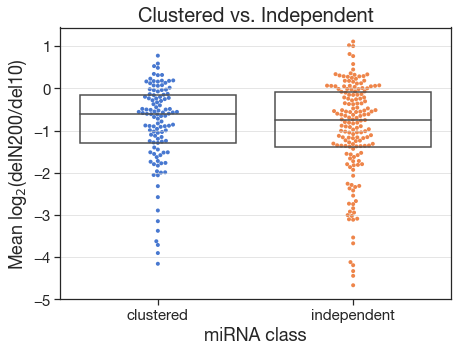

In [231]:
plt.figure(figsize=(7,5))
ax=\
sns.swarmplot(x="Clustered_2000", y = "log2FoldChange", data=DD_filtered_2000, size=4, zorder=0,order=["clustered", "independent"])
ax=\
sns.boxplot(x='Clustered_2000', y = "log2FoldChange", data=DD_filtered_2000, color='gray', order=["clustered", "independent"], showcaps=False,\
            boxprops={'facecolor':'None'}, showfliers=False,whiskerprops={'linewidth':0})

ax.set_title("Clustered vs. Independent", fontproperties=helvetica_20)
ax.set_xlabel("miRNA class", fontproperties=helvetica_18)
ax.set_ylabel("Mean log$_2$(delN200/del10)", fontproperties=helvetica_18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
    
ax.grid(axis='y', alpha=0.5)

plt.show()

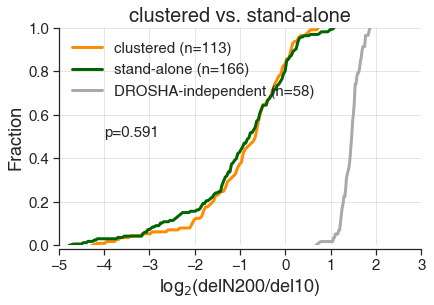

In [53]:
fig, ax = plt.subplots(1,1, figsize = (6.5,4))

clustered = DD_filtered_2000[DD_filtered_2000["Clustered_2000"] == "clustered"]["log2FoldChange"]
independent = DD_filtered_2000[DD_filtered_2000["Clustered_2000"] == "independent"]["log2FoldChange"]
D_ind = DI_filtered["log2FoldChange"] 

### evaluate the histogram
clustered_values , clustered_base = np.histogram(clustered, bins = len(clustered))
independent_values , independent_base = np.histogram(independent, bins = len(independent))
D_ind_values, D_ind_base = np.histogram(D_ind, bins = len(D_ind))

### evaluate the cumulative
clustered_cumulative = np.cumsum(clustered_values) / np.sum(clustered_values)
independent_cumulative = np.cumsum(independent_values) / np.sum(independent_values)
D_ind_cumulative = np.cumsum(D_ind_values) / np.sum(D_ind_values)

ax.plot(np.insert(clustered_base[:-1],0,clustered_base[0]-0.1,axis=0) , np.insert(clustered_cumulative,0,0,axis=0), label="clustered "+"(n="+str(len(clustered))+")", color='darkorange', linewidth=3)
ax.plot(np.insert(independent_base[:-1],0,independent_base[0]-0.1,axis=0) , np.insert(independent_cumulative,0,0,axis=0) ,label="stand-alone "+"(n="+str(len(independent))+")", color='darkgreen', linewidth=3)
ax.plot(np.insert(D_ind_base[:-1],0,D_ind_base[0]-0.1,axis=0) , np.insert(D_ind_cumulative,0,0,axis=0), color="darkgrey",\
        label="DROSHA-independent "+"(n="+str(len(D_ind))+")", linewidth=3)

ax.grid(False)
#ax.plot((0,0), (0,1), c='black', alpha=0.7, ls='--')
ax.set_xlim(-5,3)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(delN200/del10)", fontsize=18)
ax.set_ylabel("Fraction", fontsize=18)
ax.set_title("clustered vs. stand-alone", fontsize=20)
ax.legend(frameon=False, loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)
ax.spines['bottom'].set_position(('outward', 4))

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontsize(15)

ax.grid(axis='y', alpha=0.5)
    
p0 = mannwhitneyu(clustered, independent, alternative='two-sided')[1]
ax.text(-4,0.5,'p=%.3f'%p0, fontsize=15)
fig.show()

#plt.savefig("Results/201014-data-Clustered-HCT116.pdf", bbox_inches='tight')

del clustered, independent, D_ind, clustered_values, clustered_base, independent_values, independent_base, D_ind_values, D_ind_base, clustered_cumulative, independent_cumulative, D_ind_cumulative

For figure

In [54]:
fig, ax = plt.subplots(1,1,figsize=(5.5, 4))

clustered = DD_filtered_2000[DD_filtered_2000["Clustered_2000"] == "clustered"]['log2FoldChange']
independent = DD_filtered_2000[DD_filtered_2000["Clustered_2000"] == "independent"]['log2FoldChange']

### evaluate the histogram
clustered_values, clustered_base = np.histogram(clustered, bins = len(clustered))
independent_values, independent_base = np.histogram(independent, bins = len(independent))

### evaluate cumulative
clustered_cumulative = np.cumsum(clustered_values) / np.sum(clustered_values)
independent_cumulative = np.cumsum(independent_values) / np.sum(independent_values)

ax.plot(np.insert(clustered_base[:-1], 0, clustered_base[0]-0.1, axis = 0), \
        np.insert(clustered_cumulative,0,0, axis=0), label='Clustered '+'(n='+str(len(clustered))+")", \
        color = '#e7298a', linewidth=2.5)
ax.plot(np.insert(independent_base[:-1],0,independent_base[0]-0.1, axis=0),\
       np.insert(independent_cumulative,0,0,axis=0), label="Stand-alone " + "(n=" +str(len(independent))+")",\
       color='#66a61e', linewidth=2.5)

ax.set_xlim(-5,1.6)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(delN200/del10)", fontsize=18)
ax.set_ylabel("Cumulative fraction", fontsize=18)
ax.set_title("Clustered arrangement", fontsize=20)
ax.legend(loc="upper left", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
    
p0 = mannwhitneyu(clustered, independent, alternative = 'two-sided')[1]
ax.text(-4,0.5, 'p = %.3f'%p0, fontsize=15)
fig.show()

#plt.savefig("Results/Figures/210118-clustered-arrangement-HCT116.pdf", bbox_inches='tight')
del clustered, independent, clustered_values, clustered_base, independent_values, independent_base, clustered_cumulative, independent_cumulative

#### P-rich dependency and order within cluster

In [82]:
DD_filtered_2000[DD_filtered_2000["cluster_id"] == 3]

mature    baseMean  log2FoldChange      stat    pvalue      padj  \
187  hsa-miR-331-3p  336.996760       -0.330716 -1.125231  0.260491  0.354075   
188  hsa-miR-331-5p   19.420751       -0.610138 -1.315169  0.188453  0.273369   

    curated DROSHA dependency (HCT116) 5p3p    pri-miRNA    Chr     ...       \
187                   DROSHA-dependent   3p  hsa-mir-331  chr12     ...        
188                   DROSHA-dependent   5p  hsa-mir-331  chr12     ...        

     stem length  loop simple loop  UG  CNNC    UGU Clustered_2000  \
187         33.0  11.0        11.0  UG  CNNC  NoUGU      clustered   
188         33.0  11.0        11.0  UG  CNNC  NoUGU      clustered   

    cluster_order  cluster_id  cluster_len  
187           0.0         3.0          2.0  
188           0.0         3.0          2.0  

[2 rows x 28 columns]

In [83]:
DD_filtered_2000["cluster_rel_order"] = DD_filtered_2000["cluster_order"] / (DD_filtered_2000["cluster_len"]-1)
DD_filtered_2000.loc[DD_filtered_2000[DD_filtered_2000["Clustered_2000"] == 'independent'].index, "cluster_rel_order"] = -3

In [84]:
DD_filtered_2000["cluster_len"].value_counts()

-3.0    166
 2.0     66
 3.0     27
 6.0     11
 4.0      9
Name: cluster_len, dtype: int64

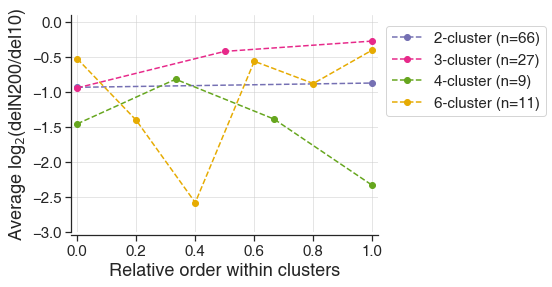

In [85]:
fig, ax = plt.subplots(1,1,figsize=(5.5, 4))


ax.plot(DD_filtered_2000[DD_filtered_2000["cluster_len"] == 2].groupby("cluster_rel_order").mean()["log2FoldChange"],\
        marker='o', linestyle='dashed', c='#7570b3', \
        label='2-cluster (n='+str(len(DD_filtered_2000[DD_filtered_2000["cluster_len"] == 2]))+')')

ax.plot(DD_filtered_2000[DD_filtered_2000["cluster_len"] == 3].groupby("cluster_rel_order").mean()["log2FoldChange"],\
        marker='o', linestyle='dashed', c='#e7298a', \
        label='3-cluster (n='+str(len(DD_filtered_2000[DD_filtered_2000["cluster_len"] == 3]))+')')

ax.plot(DD_filtered_2000[DD_filtered_2000["cluster_len"] == 4].groupby("cluster_rel_order").mean()["log2FoldChange"],\
        marker='o', linestyle='dashed', c='#66a61e', \
        label='4-cluster (n='+str(len(DD_filtered_2000[DD_filtered_2000["cluster_len"] == 4]))+')')

ax.plot(DD_filtered_2000[DD_filtered_2000["cluster_len"] == 6].groupby("cluster_rel_order").mean()["log2FoldChange"],\
        marker='o', linestyle='dashed', c='#e6ab02', \
        label='6-cluster (n='+str(len(DD_filtered_2000[DD_filtered_2000["cluster_len"] == 6]))+')')

ax.set_ylim(-3,0.1)
ax.set_xlim(-0.02,1.02)
ax.set_xlabel("Relative order within clusters", fontsize=18)
ax.set_ylabel("Average log$_2$(delN200/del10)", fontsize=18)
ax.set_title("", fontsize=20)
ax.legend(bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)

In [86]:
DD_filtered_2000.head()

mature      baseMean  log2FoldChange      stat    pvalue  \
0  hsa-let-7a-2-3p     52.394713       -0.901333 -2.165859  0.030322   
1    hsa-let-7a-3p    410.786354       -0.089378 -0.436403  0.662545   
2    hsa-let-7a-5p  15216.651736        0.009163  0.047385  0.962207   
3    hsa-let-7b-3p    113.500150       -0.583679 -2.091957  0.036442   
4    hsa-let-7b-5p   3288.216511       -0.136267 -0.518374  0.604197   

       padj curated DROSHA dependency (HCT116) 5p3p     pri-miRNA    Chr  \
0  0.066836                   DROSHA-dependent   3p  hsa-let-7a-2  chr11   
1  0.740194                   DROSHA-dependent   3p           NaN    NaN   
2  0.982280                   DROSHA-dependent   5p           NaN    NaN   
3  0.076425                   DROSHA-dependent   3p    hsa-let-7b  chr22   
4  0.691858                   DROSHA-dependent   5p    hsa-let-7b  chr22   

         ...          loop  simple loop    UG    CNNC    UGU Clustered_2000  \
0        ...          21.0         21.0    UG    CNNC  NoUGU    independent   
1        ...           NaN          NaN   NaN     NaN    NaN            NaN   
2        ...           NaN          NaN   NaN     NaN    NaN            NaN   
3        ...          30.0          7.0  NoUG  NoCNNC  NoUGU      clustered   
4        ...          30.0          7.0  NoUG  NoCNNC  NoUGU      clustered   

  cluster_order cluster_id  cluster_len  cluster_rel_order  
0          -3.0       -3.0         -3.0               -3.0  
1           NaN        NaN          NaN                NaN  
2           NaN        NaN          NaN                NaN  
3           2.0       86.0          3.0                1.0  
4           2.0       86.0          3.0                1.0  

[5 rows x 29 columns]

In [97]:
DD_filtered_2000["cluster_rel_label"] = -3
DD_filtered_2000.loc[DD_filtered_2000[DD_filtered_2000["cluster_rel_order"] == 0].index, "cluster_rel_label"] = "First"
DD_filtered_2000.loc[DD_filtered_2000[DD_filtered_2000["cluster_rel_order"] == 1].index, "cluster_rel_label"] = "Last"
DD_filtered_2000.loc[DD_filtered_2000[(DD_filtered_2000["cluster_rel_order"] !=0) & (DD_filtered_2000["cluster_rel_order"] !=1) & (~DD_filtered_2000["cluster_rel_order"].isna())].index, "cluster_rel_label"] = "Middle"
DD_filtered_2000.loc[DD_filtered_2000[DD_filtered_2000["Clustered_2000"] == 'independent'].index, "cluster_rel_label"] = "Stand-alone"

DD_filtered_2000.head(10)

mature      baseMean  log2FoldChange      stat        pvalue  \
0  hsa-let-7a-2-3p     52.394713       -0.901333 -2.165859  3.032197e-02   
1    hsa-let-7a-3p    410.786354       -0.089378 -0.436403  6.625446e-01   
2    hsa-let-7a-5p  15216.651736        0.009163  0.047385  9.622066e-01   
3    hsa-let-7b-3p    113.500150       -0.583679 -2.091957  3.644239e-02   
4    hsa-let-7b-5p   3288.216511       -0.136267 -0.518374  6.041975e-01   
5    hsa-let-7c-5p     86.709270       -0.235136 -0.698768  4.846967e-01   
6    hsa-let-7d-3p    205.664358       -2.068898 -8.038121  9.122686e-16   
7    hsa-let-7d-5p   2176.275816       -1.795197 -6.489938  8.587147e-11   
8    hsa-let-7e-3p     19.727205       -1.399991 -2.897148  3.765726e-03   
9    hsa-let-7e-5p   1016.258392       -0.500436 -2.088872  3.671925e-02   

           padj curated DROSHA dependency (HCT116) 5p3p     pri-miRNA    Chr  \
0  6.683580e-02                   DROSHA-dependent   3p  hsa-let-7a-2  chr11   
1  7.401945e-01                   DROSHA-dependent   3p           NaN    NaN   
2  9.822804e-01                   DROSHA-dependent   5p           NaN    NaN   
3  7.642490e-02                   DROSHA-dependent   3p    hsa-let-7b  chr22   
4  6.918580e-01                   DROSHA-dependent   5p    hsa-let-7b  chr22   
5  5.822707e-01                   DROSHA-dependent   5p    hsa-let-7c  chr21   
6  4.782894e-14                   DROSHA-dependent   3p    hsa-let-7d   chr9   
7  2.334432e-09                   DROSHA-dependent   5p    hsa-let-7d   chr9   
8  1.279649e-02                   DROSHA-dependent   3p    hsa-let-7e  chr19   
9  7.678613e-02                   DROSHA-dependent   5p    hsa-let-7e  chr19   

         ...          simple loop    UG    CNNC    UGU Clustered_2000  \
0        ...                 21.0    UG    CNNC  NoUGU    independent   
1        ...                  NaN   NaN     NaN    NaN            NaN   
2        ...                  NaN   NaN     NaN    NaN            NaN   
3        ...                  7.0  NoUG  NoCNNC  NoUGU      clustered   
4        ...                  7.0  NoUG  NoCNNC  NoUGU      clustered   
5        ...                 21.0    UG  NoCNNC  NoUGU      clustered   
6        ...                  NaN   NaN     NaN    NaN    independent   
7        ...                  NaN   NaN     NaN    NaN    independent   
8        ...                 18.0  NoUG  NoCNNC  NoUGU      clustered   
9        ...                 18.0  NoUG  NoCNNC  NoUGU      clustered   

  cluster_order cluster_id cluster_len  cluster_rel_order  cluster_rel_label  
0          -3.0       -3.0        -3.0               -3.0        Stand-alone  
1           NaN        NaN         NaN                NaN                 -3  
2           NaN        NaN         NaN                NaN                 -3  
3           2.0       86.0         3.0                1.0               Last  
4           2.0       86.0         3.0                1.0               Last  
5           1.0       75.0         2.0                1.0               Last  
6          -3.0       -3.0        -3.0               -3.0        Stand-alone  
7          -3.0       -3.0        -3.0               -3.0        Stand-alone  
8           1.0       64.0         3.0                0.5             Middle  
9           1.0       64.0         3.0                0.5             Middle  

[10 rows x 30 columns]

In [98]:
DD_filtered_2000["Clustered_2000"].value_counts()

independent    166
clustered      113
Name: Clustered_2000, dtype: int64

In [99]:
DD_filtered_2000["cluster_rel_label"].value_counts()

Stand-alone    166
First           47
Last            45
-3              29
Middle          21
Name: cluster_rel_label, dtype: int64

In [150]:
fig, ax = plt.subplots(1,1,figsize=(5.5, 4))

ax = sns.boxplot(x='cluster_rel_label', y = "log2FoldChange", data=DD_filtered_2000, color='black', \
                 order=['Stand-alone', 'First','Middle','Last'], boxprops={'facecolor': 'None'}, \
                 ax=ax, width=0.5, showfliers = False, linewidth=2)
ax.artists[0].set_facecolor("#e7298a")
ax.artists[1].set_facecolor("#66a61e")
ax.artists[2].set_facecolor("#66a61e")
ax.artists[3].set_facecolor("#66a61e")



ax.set_ylim(-3.5,4)
ax.set_ylabel("log$_2$(delN200/del10)", fontsize=18)
ax.set_xlabel("Relative order in a cluster", fontsize=18)
#ax[0].set_title("UG", fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in ax.get_yticklabels():
    label.set_fontsize(15)
for label in ax.get_xticklabels():
    label.set_fontsize(18)
    
add_stat_annotation(ax, data=DD_filtered_2000, x='cluster_rel_label', y ='log2FoldChange', \
                   box_pairs=[("First", "Middle"), ("Middle", "Last"), ("First", "Last")], order=['Stand-alone', 'First','Middle','Last'], \
                    test='Mann-Whitney', comparisons_correction=None, text_format='star', loc='inside', fontsize=15, \
                   line_offset_to_box=0.025, line_offset=0.0001, line_height=0.025, text_offset=0.5)
            
# line_offset_to_box=0.2, line_offset=0.1, line_height=0.05, text_offset=8
#p0 = mannwhitneyu(DD_filtered_2000[C_filtered_2000["cluster_rel_label"] == "First"]["log2FoldChange"],\
#                  C_filtered_2000[C_filtered_2000["cluster_rel_label"] == "Middle"]["log2FoldChange"],alternative = 'two-sided')[1]
#p1 = mannwhitneyu(C_filtered_2000[C_filtered_2000["cluster_rel_label"] == "First"]["log2FoldChange"],\
#                  C_filtered_2000[C_filtered_2000["cluster_rel_label"] == "Last"]["log2FoldChange"],alternative = 'two-sided')[1]
#p2 = mannwhitneyu(C_filtered_2000[C_filtered_2000["cluster_rel_label"] == "Middle"]["log2FoldChange"],\
#                  C_filtered_2000[C_filtered_2000["cluster_rel_label"] == "Last"]["log2FoldChange"],alternative = 'two-sided')[1]

#ax.text(0.25,-3.2,'First vs. Middle p=%.3f'%p0,  fontsize=15)
#ax.text(0.25,-3.5,'First vs. Last p=%.3f'%p1,  fontsize=15)
#ax.text(0.25,-3.8,'Middle vs. Last p=%.3f'%p2,  fontsize=15)

fig.show()

#plt.savefig("Results/Figures/210225-cluster-all-HCT116.pdf", bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

First v.s. Middle: Mann-Whitney-Wilcoxon test two-sided, P_val=9.049e-01 U_stat=5.030e+02
Middle v.s. Last: Mann-Whitney-Wilcoxon test two-sided, P_val=6.009e-01 U_stat=4.340e+02
First v.s. Last: Mann-Whitney-Wilcoxon test two-sided, P_val=7.048e-01 U_stat=1.008e+03


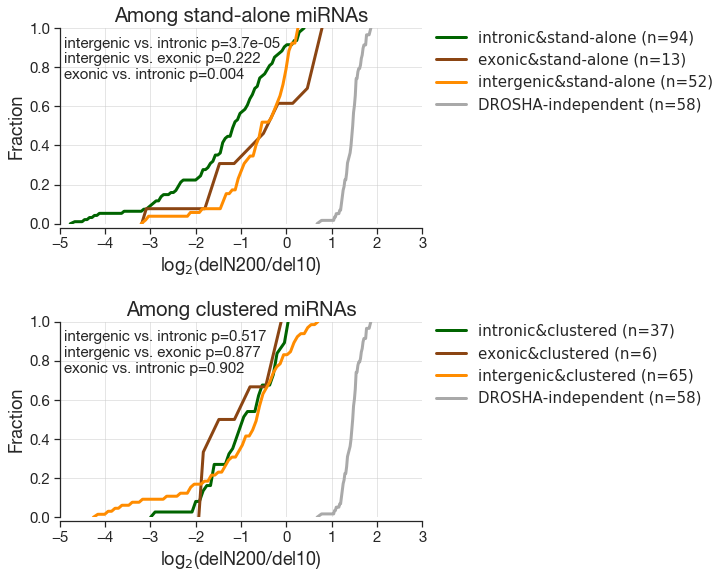

In [540]:
fig, ax = plt.subplots(2,1, figsize = (6.5,9))
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

inter_indep = SS_filtered_2000[(SS_filtered_2000["Exon_Intron"] == "intergenic") & (SS_filtered_2000["Clustered_2000"] == 'independent')]["log2FoldChange"]
inter_clustered = SS_filtered_2000[(SS_filtered_2000["Exon_Intron"] == "intergenic") & (SS_filtered_2000["Clustered_2000"] == 'clustered')]["log2FoldChange"]
intronic_indep = SS_filtered_2000[(SS_filtered_2000["Exon_Intron"] == "intronic") & (SS_filtered_2000["Clustered_2000"] == 'independent')]["log2FoldChange"]
intronic_clustered = SS_filtered_2000[(SS_filtered_2000["Exon_Intron"] == "intronic") & (SS_filtered_2000["Clustered_2000"] == 'clustered')]["log2FoldChange"]
exonic_indep = SS_filtered_2000[(SS_filtered_2000["Exon_Intron"] == "exonic") & (SS_filtered_2000["Clustered_2000"] == 'independent')]["log2FoldChange"]
exonic_clustered = SS_filtered_2000[(SS_filtered_2000["Exon_Intron"] == "exonic") & (SS_filtered_2000["Clustered_2000"] == 'clustered')]["log2FoldChange"]
D_ind = DI_filtered["log2FoldChange"]
            
### evaluate the histogram
inter_indep_values , inter_indep_base = np.histogram(inter_indep, bins = len(inter_indep))
inter_clustered_values , inter_clustered_base = np.histogram(inter_clustered, bins = len(inter_clustered))
intronic_indep_values , intronic_indep_base = np.histogram(intronic_indep, bins = len(intronic_indep))
intronic_clustered_values , intronic_clustered_base = np.histogram(intronic_clustered, bins = len(intronic_clustered))
exonic_indep_values , exonic_indep_base = np.histogram(exonic_indep, bins = len(exonic_indep))
exonic_clustered_values , exonic_clustered_base = np.histogram(exonic_clustered, bins = len(exonic_clustered))
D_ind_values, D_ind_base = np.histogram(D_ind, bins = len(D_ind))

### evaluate the cumulative
inter_indep_cumulative = np.cumsum(inter_indep_values) / np.sum(inter_indep_values)
inter_clustered_cumulative = np.cumsum(inter_clustered_values) / np.sum(inter_clustered_values)
intronic_indep_cumulative = np.cumsum(intronic_indep_values) / np.sum(intronic_indep_values)
intronic_clustered_cumulative = np.cumsum(intronic_clustered_values) / np.sum(intronic_clustered_values)
exonic_indep_cumulative = np.cumsum(exonic_indep_values) / np.sum(exonic_indep_values)
exonic_clustered_cumulative = np.cumsum(exonic_clustered_values) / np.sum(exonic_clustered_values)
D_ind_cumulative = np.cumsum(D_ind_values) / np.sum(D_ind_values)

ax[0].plot(np.insert(intronic_indep_base[:-1],0,intronic_indep_base[0]-0.1,axis=0),\
           np.insert(intronic_indep_cumulative,0,0,axis=0),label="intronic&stand-alone "+"(n="+str(len(intronic_indep))+")",\
          color='darkgreen', linewidth=3)
ax[1].plot(np.insert(intronic_clustered_base[:-1],0,intronic_clustered_base[0]-0.1,axis=0),\
           np.insert(intronic_clustered_cumulative,0,0,axis=0),label="intronic&clustered "+"(n="+str(len(intronic_clustered))+")",\
          color='darkgreen', linewidth=3)

ax[0].plot(np.insert(exonic_indep_base[:-1],0,exonic_indep_base[0]-0.1,axis=0),\
           np.insert(exonic_indep_cumulative,0,0,axis=0),label="exonic&stand-alone "+"(n="+str(len(exonic_indep))+")",\
          color='saddlebrown', linewidth=3)
ax[1].plot(np.insert(exonic_clustered_base[:-1],0,exonic_clustered_base[0]-0.1,axis=0),\
           np.insert(exonic_clustered_cumulative,0,0,axis=0),label="exonic&clustered "+"(n="+str(len(exonic_clustered))+")",\
          color='saddlebrown', linewidth=3)

ax[0].plot(np.insert(inter_indep_base[:-1],0,inter_indep_base[0]-0.1,axis=0),\
           np.insert(inter_indep_cumulative,0,0,axis=0),label="intergenic&stand-alone "+"(n="+str(len(inter_indep))+")",\
          color='darkorange', linewidth=3)
ax[1].plot(np.insert(inter_clustered_base[:-1],0,inter_clustered_base[0]-0.1,axis=0),\
           np.insert(inter_clustered_cumulative,0,0,axis=0),label="intergenic&clustered "+"(n="+str(len(inter_clustered))+")",\
          color='darkorange', linewidth=3)

ax[0].plot(np.insert(D_ind_base[:-1],0,D_ind_base[0]-0.1,axis=0) , np.insert(D_ind_cumulative,0,0,axis=0), color="darkgrey",\
           label="DROSHA-independent "+"(n="+str(len(D_ind))+")", linewidth=3)    
ax[1].plot(np.insert(D_ind_base[:-1],0,D_ind_base[0]-0.1,axis=0) , np.insert(D_ind_cumulative,0,0,axis=0), color="darkgrey",\
           label="DROSHA-independent "+"(n="+str(len(D_ind))+")", linewidth=3)    

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].grid(axis='y', alpha=0.5)
ax[0].grid(axis='x', alpha=0.5)
ax[0].spines['bottom'].set_position(('outward', 4))

ax[0].set_xlim(-5,3)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[0].set_ylabel("Fraction",  fontproperties=helvetica_18)
ax[0].set_title("Among stand-alone miRNAs",  fontproperties=helvetica_20)
ax[0].legend(frameon=False, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)
        
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].grid(axis='y', alpha=0.5)
ax[1].grid(axis='x', alpha=0.5)
ax[1].spines['bottom'].set_position(('outward', 4))
    
ax[1].set_xlim(-5,3)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[1].set_ylabel("Fraction",  fontproperties=helvetica_18)
ax[1].set_title("Among clustered miRNAs",  fontproperties=helvetica_20)
ax[1].legend(frameon=False, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)

p00 = mannwhitneyu(inter_indep, intronic_indep, alternative='two-sided')[1]
p01 = mannwhitneyu(inter_indep, exonic_indep, alternative='two-sided')[1]
p02 = mannwhitneyu(intronic_indep, exonic_indep, alternative='two-sided')[1] 
ax[0].text(-4.9,0.9,'intergenic vs. intronic p=%.1e'%p00,  fontproperties=helvetica_15)
ax[0].text(-4.9,0.82,'intergenic vs. exonic p=%.3f'%p01,  fontproperties=helvetica_15)
ax[0].text(-4.9,0.74,'exonic vs. intronic p=%.3f'%p02,  fontproperties=helvetica_15)

p10 = mannwhitneyu(inter_clustered, intronic_clustered, alternative='two-sided')[1]
p11 = mannwhitneyu(inter_clustered, exonic_clustered, alternative='two-sided')[1]
p12 = mannwhitneyu(intronic_clustered, exonic_clustered, alternative='two-sided')[1] 
ax[1].text(-4.9,0.9,'intergenic vs. intronic p=%.3f'%p10,  fontproperties=helvetica_15)
ax[1].text(-4.9,0.82,'intergenic vs. exonic p=%.3f'%p11,  fontproperties=helvetica_15)
ax[1].text(-4.9,0.74,'exonic vs. intronic p=%.3f'%p12,  fontproperties=helvetica_15)

for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

fig.show()

#plt.savefig("Results/201014-data-Genomic-locus-Clustered-HCT116.pdf", bbox_inches='tight')

del inter_indep, inter_clustered, intronic_indep, intronic_clustered, exonic_indep, exonic_clustered, D_ind, \
inter_indep_values , inter_indep_base, inter_clustered_values , inter_clustered_base, intronic_indep_values , intronic_indep_base, \
intronic_clustered_values , intronic_clustered_base, exonic_indep_values , exonic_indep_base, exonic_clustered_values , exonic_clustered_base, \
D_ind_values, D_ind_base, inter_indep_cumulative, inter_clustered_cumulative, intronic_indep_cumulative , intronic_clustered_cumulative, \
exonic_indep_cumulative , exonic_clustered_cumulative, D_ind_cumulative

For figure

In [291]:
fig, ax = plt.subplots(1,1,figsize=(5.5,4))

inter_indep = SS_filtered_2000[(SS_filtered_2000["Exon_Intron"] == "intergenic") & (SS_filtered_2000["Clustered_2000"] == 'independent')]["log2FoldChange"]
intronic_indep = SS_filtered_2000[(SS_filtered_2000["Exon_Intron"] == "intronic") & (SS_filtered_2000["Clustered_2000"] == 'independent')]["log2FoldChange"]
exonic_indep = SS_filtered_2000[(SS_filtered_2000["Exon_Intron"] == "exonic") & (SS_filtered_2000["Clustered_2000"] == 'independent')]["log2FoldChange"]

inter_indep_values , inter_indep_base = np.histogram(inter_indep, bins = len(inter_indep))
intronic_indep_values , intronic_indep_base = np.histogram(intronic_indep, bins = len(intronic_indep))
exonic_indep_values , exonic_indep_base = np.histogram(exonic_indep, bins = len(exonic_indep))

inter_indep_cumulative = np.cumsum(inter_indep_values) / np.sum(inter_indep_values)
intronic_indep_cumulative = np.cumsum(intronic_indep_values) / np.sum(intronic_indep_values)
exonic_indep_cumulative = np.cumsum(exonic_indep_values) / np.sum(exonic_indep_values)


ax.plot(np.insert(intronic_indep_base[:-1],0,intronic_indep_base[0]-0.1,axis=0),\
        np.insert(intronic_indep_cumulative,0,0,axis=0),label="Intronic "+"(n="+str(len(intronic_indep))+")",\
        color='#d95f02', linewidth=2.5)
ax.plot(np.insert(exonic_indep_base[:-1],0,exonic_indep_base[0]-0.1,axis=0),\
        np.insert(exonic_indep_cumulative,0,0,axis=0),label="Exonic "+"(n="+str(len(exonic_indep))+")",\
        color='#1b9e77', linewidth=2.5)
ax.plot(np.insert(inter_indep_base[:-1],0,inter_indep_base[0]-0.1,axis=0),\
        np.insert(inter_indep_cumulative,0,0,axis=0),label="Intergenic "+"(n="+str(len(inter_indep))+")",\
        color='#7570b3', linewidth=2.5)

ax.set_xlim(-5,1.6)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(delN200/del10)", fontsize=18)
ax.set_ylabel("Cumulative fraction", fontsize=18)
ax.set_title("Stand-alone miRNAs", fontsize=20)
#ax.legend(frameon=True, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)
ax.legend(frameon=True, loc='upper left', fontsize=13)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
    
p0 = mannwhitneyu(inter_indep, intronic_indep, alternative='two-sided')[1]
p1 = mannwhitneyu(inter_indep, exonic_indep, alternative='two-sided')[1]
p2 = mannwhitneyu(intronic_indep, exonic_indep, alternative='two-sided')[1] 
ax.text(-4.8,0.58,'Intergenic vs. Intronic p=%.1e'%p0,  fontsize=12)
ax.text(-4.8,0.50,'Intergenic vs. Exonic p=%.3f'%p1,  fontsize=12)
ax.text(-4.8,0.42,'Exonic vs. Intronic p=%.3f'%p2,  fontsize=12)

fig.show()

plt.savefig("Results/Figures/201214-Standalone-HCT116.pdf", bbox_inches='tight')

In [292]:
fig, ax = plt.subplots(1,1,figsize=(5.5,4))

inter_clustered = SS_filtered_2000[(SS_filtered_2000["Exon_Intron"] == "intergenic") & (SS_filtered_2000["Clustered_2000"] == 'clustered')]["log2FoldChange"]
intronic_clustered = SS_filtered_2000[(SS_filtered_2000["Exon_Intron"] == "intronic") & (SS_filtered_2000["Clustered_2000"] == 'clustered')]["log2FoldChange"]
exonic_clustered = SS_filtered_2000[(SS_filtered_2000["Exon_Intron"] == "exonic") & (SS_filtered_2000["Clustered_2000"] == 'clustered')]["log2FoldChange"]

inter_clustered_values , inter_clustered_base = np.histogram(inter_clustered, bins = len(inter_clustered))
intronic_clustered_values , intronic_clustered_base = np.histogram(intronic_clustered, bins = len(intronic_clustered))
exonic_clustered_values , exonic_clustered_base = np.histogram(exonic_clustered, bins = len(exonic_clustered))

inter_clustered_cumulative = np.cumsum(inter_clustered_values) / np.sum(inter_clustered_values)
intronic_clustered_cumulative = np.cumsum(intronic_clustered_values) / np.sum(intronic_clustered_values)
exonic_clustered_cumulative = np.cumsum(exonic_clustered_values) / np.sum(exonic_clustered_values)


ax.plot(np.insert(intronic_clustered_base[:-1],0,intronic_clustered_base[0]-0.1,axis=0),\
        np.insert(intronic_clustered_cumulative,0,0,axis=0),label="Intronic "+"(n="+str(len(intronic_clustered))+")",\
        color='#d95f02', linewidth=2.5)
ax.plot(np.insert(exonic_clustered_base[:-1],0,exonic_clustered_base[0]-0.1,axis=0),\
        np.insert(exonic_clustered_cumulative,0,0,axis=0),label="Exonic "+"(n="+str(len(exonic_clustered))+")",\
        color='#1b9e77', linewidth=2.5)
ax.plot(np.insert(inter_clustered_base[:-1],0,inter_clustered_base[0]-0.1,axis=0),\
        np.insert(inter_clustered_cumulative,0,0,axis=0),label="Intergenic "+"(n="+str(len(inter_clustered))+")",\
        color='#7570b3', linewidth=2.5)

ax.set_xlim(-5,1.6)
ax.set_ylim(0,1)
ax.set_xlabel("log$_2$(delN200/del10)", fontsize=18)
ax.set_ylabel("Cumulative fraction", fontsize=18)
ax.set_title("Clustered miRNAs", fontsize=20)
#ax.legend(frameon=True, bbox_to_anchor=(1,0.5), loc='lower left', fontsize=15)
ax.legend(frameon=True, loc='upper left', fontsize=13)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
    
p0 = mannwhitneyu(inter_clustered, intronic_clustered, alternative='two-sided')[1]
p1 = mannwhitneyu(inter_clustered, exonic_clustered, alternative='two-sided')[1]
p2 = mannwhitneyu(intronic_clustered, exonic_clustered, alternative='two-sided')[1] 
ax.text(-4.8,0.58,'Intergenic vs. Intronic p=%.3f'%p0,  fontsize=12)
ax.text(-4.8,0.50,'Intergenic vs. Exonic p=%.3f'%p1,  fontsize=12)
ax.text(-4.8,0.42,'Exonic vs. Intronic p=%.3f'%p2,  fontsize=12)

fig.show()

plt.savefig("Results/Figures/201214-Clustered-HCT116.pdf", bbox_inches='tight')

See the distribution of intronic & independent.

- Some intronic miRNAs have small N-term. dependency. Why?

In [455]:
fig, ax = plt.subplots(1,1, figsize = (6.5,4))

sns.distplot(SS_filtered_2000[(SS_filtered_2000["Exon_Intron"]=="intergenic")&(SS_filtered_2000["Clustered_2000"]=="independent")]["log2FoldChange"], \
             hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label="intergenic & stand-alone", color='darkorange')
sns.distplot(SS_filtered_2000[(SS_filtered_2000["Exon_Intron"]=="intronic") & (SS_filtered_2000["Clustered_2000"]=="independent")]["log2FoldChange"], \
             hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label="intronic & stand-alone", color='darkgreen')

ax.set_xlabel("log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax.set_ylabel("Fraction", fontproperties=helvetica_18)
ax.legend(frameon=False, loc="upper left", fontsize=15)

ax.set_ylim(0,0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)
ax.spines['bottom'].set_position(('outward', 4))

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)

fig.show()
#plt.savefig("Results/201016-data-why-some-intronic-HCT116.pdf", bbox_inches='tight')

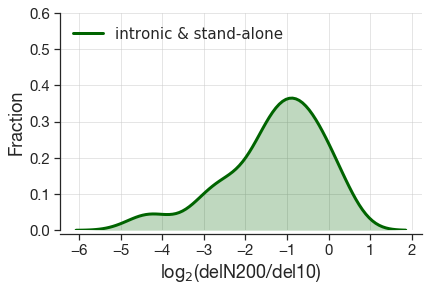

In [456]:
fig, ax = plt.subplots(1,1, figsize = (6.5,4))

sns.distplot(SS_filtered_2000[(SS_filtered_2000["Exon_Intron"]=="intronic") & (SS_filtered_2000["Clustered_2000"]=="independent")]["log2FoldChange"], \
             hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label="intronic & stand-alone", color='darkgreen')

ax.set_xlabel("log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax.set_ylabel("Fraction", fontproperties=helvetica_18)
ax.legend(frameon=False, loc="upper left", fontsize=15)

ax.set_ylim(0,0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)
ax.spines['bottom'].set_position(('outward', 4))

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)

fig.show()
#plt.savefig("Results/201016-data-why-some-intronic-onlyintron-HCT116.pdf", bbox_inches='tight')

---
### Using intron coordinates, redefine miRNAs into exonic and intronic

#### Get the coordinates of pri-miRNA start and end for intronic miRNAs
- Original mirbase: 1-based, closed interval( [,] )
- Change the coordinates of pri-miRNA start and end to 0-based and half-open interval.
- Classified them into intronic & independent and intronic & clustered

- pri Start = pri Start - 1
- pri End = pri End 

In [156]:
DD_filtered_2000["pri Start"] = DD_filtered_2000['pri Start'] - 1
DD_filtered_2000["pri End"] = DD_filtered_2000["pri End"]

In [225]:
tmp = DD_filtered_2000.reset_index()[["Chr", "pri Start", "pri End", "mature", "strand"]]
tmp['score'] = 0

tmp = tmp[['Chr', 'pri Start', 'pri End', 'mature', 'score', 'strand']]

tmp.dropna(inplace=True)
tmp["pri Start"] = pd.to_numeric(tmp["pri Start"], downcast='integer')
tmp["pri End"] = pd.to_numeric(tmp["pri End"], downcast='integer')

DD_filtered_2000_bed = pybedtools.BedTool.from_dataframe(tmp)
DD_filtered_2000_bed.head()

chr11	122146521	122146593	hsa-let-7a-2-3p	0	-
 chr22	46113685	46113768	hsa-let-7b-3p	0	+
 chr22	46113685	46113768	hsa-let-7b-5p	0	+
 chr21	16539827	16539911	hsa-let-7c-5p	0	+
 chr9	94178833	94178920	hsa-let-7d-3p	0	+
 chr9	94178833	94178920	hsa-let-7d-5p	0	+
 chr19	51692785	51692864	hsa-let-7e-3p	0	+
 chr19	51692785	51692864	hsa-let-7e-5p	0	+
 chr9	94176346	94176433	hsa-let-7f-1-3p	0	+
 chrX	53557191	53557274	hsa-let-7f-2-3p	0	-
 

In [226]:
# A: intronic miRNA region
# B: intron regions of genomes

DD_filtered_2000_intersect = pybedtools.BedTool(DD_filtered_2000_bed).intersect(genome_bed, wa=True, wb=True, f=1)
DD_filtered_2000_intersect = pybedtools.BedTool.to_dataframe(DD_filtered_2000_intersect)
print(DD_filtered_2000_intersect.shape)
tmp2 = DD_filtered_2000_intersect.drop_duplicates(subset='name', keep='first').set_index('name').index

(1169, 12)


In [233]:
tmp4 = set(DD_filtered_2000.set_index("mature").index) - set(tmp2)
tmp4 = list(tmp4)
tmp5 = DD_filtered_2000.set_index('mature').loc[tmp4,:]
tmp5.dropna(inplace=True)
tmp5.shape

(62, 29)

In [228]:


tmp3 = DD_filtered_2000.set_index('mature').loc[tmp2,:]
tmp3.shape

tmp3['Exon_Intron'].value_counts()

intronic      142
intergenic     48
exonic          8
Name: Exon_Intron, dtype: int64

In [218]:
tmp3[tmp3["Exon_Intron"] == 'exonic']

baseMean  log2FoldChange      stat        pvalue  \
name                                                                   
hsa-let-7e-3p      19.727205       -1.399991 -2.897148  3.765726e-03   
hsa-let-7e-5p    1016.258392       -0.500436 -2.088872  3.671925e-02   
hsa-miR-125a-3p    33.895904        0.230493  0.568736  5.695353e-01   
hsa-miR-125a-5p  1143.189952        0.164734  0.699308  4.843599e-01   
hsa-miR-4664-5p    13.182330       -3.087789 -4.018021  5.868905e-05   
hsa-miR-642a-5p    27.950215       -1.236981 -2.808005  4.984942e-03   
hsa-miR-99b-3p     94.634426       -1.795472 -5.307373  1.112164e-07   
hsa-miR-99b-5p    947.857727       -1.829807 -6.905237  5.011984e-12   

                         padj curated DROSHA dependency (HCT116) 5p3p  \
name                                                                    
hsa-let-7e-3p    1.279649e-02                   DROSHA-dependent   3p   
hsa-let-7e-5p    7.678613e-02                   DROSHA-dependent   5p   
hsa-miR-125a-3p  6.667287e-01                   DROSHA-dependent   3p   
hsa-miR-125a-5p  5.822707e-01                   DROSHA-dependent   5p   
hsa-miR-4664-5p  4.895200e-04                   DROSHA-dependent   5p   
hsa-miR-642a-5p  1.604802e-02                   DROSHA-dependent   5p   
hsa-miR-99b-3p   2.056602e-06                   DROSHA-dependent   3p   
hsa-miR-99b-5p   1.599476e-10                   DROSHA-dependent   5p   

                    pri-miRNA    Chr    pri Start        ...          \
name                                                     ...           
hsa-let-7e-3p      hsa-let-7e  chr19   51692785.0        ...           
hsa-let-7e-5p      hsa-let-7e  chr19   51692785.0        ...           
hsa-miR-125a-3p  hsa-mir-125a  chr19   51693253.0        ...           
hsa-miR-125a-5p  hsa-mir-125a  chr19   51693253.0        ...           
hsa-miR-4664-5p  hsa-mir-4664   chr8  143733082.0        ...           
hsa-miR-642a-5p  hsa-mir-642a  chr19   45674927.0        ...           
hsa-miR-99b-3p    hsa-mir-99b  chr19   51692611.0        ...           
hsa-miR-99b-5p    hsa-mir-99b  chr19   51692611.0        ...           

                 simple loop    UG    CNNC    UGU Clustered_2000  \
name                                                               
hsa-let-7e-3p           18.0  NoUG  NoCNNC  NoUGU      clustered   
hsa-let-7e-5p           18.0  NoUG  NoCNNC  NoUGU      clustered   
hsa-miR-125a-3p         12.0    UG    CNNC  NoUGU      clustered   
hsa-miR-125a-5p         12.0    UG    CNNC  NoUGU      clustered   
hsa-miR-4664-5p          NaN   NaN     NaN    NaN    independent   
hsa-miR-642a-5p          8.0    UG  NoCNNC  NoUGU    independent   
hsa-miR-99b-3p           4.0  NoUG  NoCNNC  NoUGU      clustered   
hsa-miR-99b-5p           4.0  NoUG  NoCNNC  NoUGU      clustered   

                cluster_order cluster_id  cluster_len  cluster_rel_order  \
name                                                                       
hsa-let-7e-3p             1.0       64.0          3.0                0.5   
hsa-let-7e-5p             1.0       64.0          3.0                0.5   
hsa-miR-125a-3p           2.0       64.0          3.0                1.0   
hsa-miR-125a-5p           2.0       64.0          3.0                1.0   
hsa-miR-4664-5p          -3.0       -3.0         -3.0               -3.0   
hsa-miR-642a-5p          -3.0       -3.0         -3.0               -3.0   
hsa-miR-99b-3p            0.0       64.0          3.0                0.0   
hsa-miR-99b-5p            0.0       64.0          3.0                0.0   

                 cluster_rel_label  
name                                
hsa-let-7e-3p               Middle  
hsa-let-7e-5p               Middle  
hsa-miR-125a-3p               Last  
hsa-miR-125a-5p               Last  
hsa-miR-4664-5p        Stand-alone  
hsa-miR-642a-5p        Stand-alone  
hsa-miR-99b-3p               First  
hsa-miR-99b-5p               First  

[8 rows x 29 columns]

In [229]:
tmp5["Exon_Intron"].value_counts()

intergenic    58
exonic         4
Name: Exon_Intron, dtype: int64

In [230]:
tmp3["log2FoldChange"].mean()

-1.1361505803412955

In [231]:
DD_filtered_2000[DD_filtered_2000["Exon_Intron"] == 'intronic']["log2FoldChange"].mean()

-1.1315547858926596

In [232]:
mannwhitneyu(tmp5["log2FoldChange"], tmp3['log2FoldChange'], \
                  alternative='two-sided')[1]

9.056853102767627e-06

--- 
### Among entire miRNAs (Only with SS_filtered_2000), see the distance from TSS (Transcription Start Site)

- pri_start and pri_end annotation from miRBase. Later pri_start and pri_end should be replaced with the exact pre_start and pre_end(?)
- miR_start/end in SS_filtered_2000 : 1-based, closed

- TSS informations from two different database (miRTrans and Transmir v2.0)

#### Start with miRTrans data

##### Information about miRTrans data

- Cell line: HCT116 (for HCT116 sRNA-seq)
- File name: 200902_mirTrans_HCT116.xlsx
- It also contains Host gene location, but not precise. 
- 1-based, closed interval


In [61]:
miRTrans = pd.read_excel('../200902_from_other_db/200902_mirTrans_HCT116.xlsx')[["miRNA", "TSS"]]
miRTrans = miRTrans.rename(columns = {'miRNA':'pri-miRNA'})

miRTrans[["Chr", "TSS", "strand"]] = miRTrans["TSS"].str.split(':', expand=True)
miRTrans["TSS"] = miRTrans["TSS"].astype(int)

print(miRTrans.shape)
miRTrans.head()

(717, 4)


pri-miRNA       TSS    Chr strand
0   hsa-let-7f-2  53683184   chrX      -
1     hsa-let-7g  52277884   chr3      -
2     hsa-let-7i  62603441  chr12      +
3  hsa-mir-101-1  65066438   chr1      -
4  hsa-mir-101-2   4793574   chr9      +

##### Information about SS_filtered_2000

- 1-based, closed interval
- baseMean filtered
- Because SS_filtered has so many kinds of information, I only chose information related to genomic coordinates - > SS_filtered_sub

In [62]:
SS_filtered_2000.columns

Index(['mature', 'baseMean', 'log2FoldChange', 'stat', 'pvalue', 'padj',
       'curated DROSHA dependency (HCT116)', '5p3p', 'pri-miRNA', 'Chr',
       'pri Start', 'pri End', 'strand', 'Clustered', 'Locus', 'Exon_Intron',
       'HostGene', 'Direction', 'stem length', 'loop', 'simple loop', 'UG',
       'CNNC', 'UGU', 'Clustered_2000'],
      dtype='object')

In [66]:
SS_filtered_sub = SS_filtered_2000[['mature', 'baseMean', 'log2FoldChange', 'padj', 'curated DROSHA dependency (HCT116)', 'pri-miRNA', 'Chr', 'pri Start', \
                                    'pri End', 'strand', 'Clustered_2000', 'Exon_Intron']]
SS_filtered_sub.head()

mature      baseMean  log2FoldChange      padj  \
0  hsa-let-7a-2-3p     52.394713       -0.901333  0.066836   
1    hsa-let-7a-3p    410.786354       -0.089378  0.740194   
2    hsa-let-7a-5p  15216.651736        0.009163  0.982280   
3    hsa-let-7b-3p    113.500150       -0.583679  0.076425   
4    hsa-let-7b-5p   3288.216511       -0.136267  0.691858   

  curated DROSHA dependency (HCT116)     pri-miRNA    Chr    pri Start  \
0                   DROSHA-dependent  hsa-let-7a-2  chr11  122146522.0   
1                   DROSHA-dependent           NaN    NaN          NaN   
2                   DROSHA-dependent           NaN    NaN          NaN   
3                   DROSHA-dependent    hsa-let-7b  chr22   46113686.0   
4                   DROSHA-dependent    hsa-let-7b  chr22   46113686.0   

       pri End strand Clustered_2000 Exon_Intron  
0  122146593.0      -    independent  intergenic  
1          NaN    NaN            NaN         NaN  
2          NaN    NaN            NaN         NaN  
3   46113768.0      +      clustered  intergenic  
4   46113768.0      +      clustered  intergenic

In [67]:
TSS_miRTrans = SS_filtered_sub.join(miRTrans.set_index('pri-miRNA'), on = 'pri-miRNA', lsuffix='_l', rsuffix='_r', how='inner')
print(SS_filtered_sub.shape, TSS_miRTrans.shape)

for i, row in TSS_miRTrans.iterrows():
    if row["strand_l"] == '+':
        TSS_miRTrans.loc[i,"dist_TSS"] = row["pri Start"] - row["TSS"]
    elif row["strand_l"] == '-':
        TSS_miRTrans.loc[i,'dist_TSS'] = row["TSS"] - row["pri End"]
        
TSS_miRTrans.head()

(296, 12) (138, 15)


mature     baseMean  log2FoldChange          padj  \
11  hsa-let-7f-2-3p    47.599577       -0.160113  7.419016e-01   
13    hsa-let-7g-3p    47.297341       -0.355310  4.790958e-01   
14    hsa-let-7g-5p  4175.582999        0.184186  5.695342e-01   
15    hsa-let-7i-3p   190.666275       -1.379293  1.670613e-04   
16    hsa-let-7i-5p  7062.527984       -0.966925  4.476996e-07   

   curated DROSHA dependency (HCT116)     pri-miRNA  Chr_l   pri Start  \
11                   DROSHA-dependent  hsa-let-7f-2   chrX  53557192.0   
13                   DROSHA-dependent    hsa-let-7g   chr3  52268278.0   
14                   DROSHA-dependent    hsa-let-7g   chr3  52268278.0   
15                   DROSHA-dependent    hsa-let-7i  chr12  62603686.0   
16                   DROSHA-dependent    hsa-let-7i  chr12  62603686.0   

       pri End strand_l Clustered_2000 Exon_Intron       TSS  Chr_r strand_r  \
11  53557274.0        -      clustered    intronic  53683184   chrX        -   
13  52268361.0        -    independent    intronic  52277884   chr3        -   
14  52268361.0        -    independent    intronic  52277884   chr3        -   
15  62603769.0        +    independent  intergenic  62603441  chr12        +   
16  62603769.0        +    independent  intergenic  62603441  chr12        +   

    dist_TSS  
11  125910.0  
13    9523.0  
14    9523.0  
15     245.0  
16     245.0

In [68]:
TSS_miRTrans_box = TSS_miRTrans.sort_values(by='log2FoldChange')[["baseMean", "log2FoldChange","Clustered_2000","Exon_Intron","dist_TSS"]]

In [71]:
pd.crosstab(TSS_miRTrans_box["Clustered_2000"], TSS_miRTrans_box["Exon_Intron"])

Exon_Intron     exonic  intergenic  intronic
Clustered_2000                              
clustered            0          23        23
independent          8          30        54

In [73]:
TSS_miRTrans_box_inter_indep = TSS_miRTrans_box[(TSS_miRTrans_box["Exon_Intron"] == 'intergenic') & (TSS_miRTrans_box["Clustered_2000"] == 'independent')]
TSS_miRTrans_box_inter_clustered = TSS_miRTrans_box[(TSS_miRTrans_box["Exon_Intron"] == 'intergenic') & (TSS_miRTrans_box["Clustered_2000"] == 'clustered')]
TSS_miRTrans_box_intronic_indep = TSS_miRTrans_box[(TSS_miRTrans_box["Exon_Intron"] == 'intronic') & (TSS_miRTrans_box["Clustered_2000"] == 'independent')]
TSS_miRTrans_box_intronic_clustered = TSS_miRTrans_box[(TSS_miRTrans_box["Exon_Intron"] == 'intronic') & (TSS_miRTrans_box["Clustered_2000"] == 'clustered')]

print(TSS_miRTrans_box_inter_indep.shape, TSS_miRTrans_box_inter_clustered.shape, TSS_miRTrans_box_intronic_indep.shape, TSS_miRTrans_box_intronic_clustered.shape)

(30, 5) (23, 5) (54, 5) (23, 5)


In [78]:
TSS_miRTrans_box_inter_indep.loc[:,'log2FC_group'] = \
pd.qcut(TSS_miRTrans_box_inter_indep['log2FoldChange'], 2, labels=['Group 1', 'Group 2'])
TSS_miRTrans_box_inter_indep.loc[:,'baseMean_group'] = \
pd.qcut(TSS_miRTrans_box_inter_indep['baseMean'], 2, labels=['Group 1', 'Group 2'])

TSS_miRTrans_box_inter_clustered.loc[:,'log2FC_group'] = \
pd.qcut(TSS_miRTrans_box_inter_clustered['log2FoldChange'], 2, labels=['Group 1', 'Group 2'])
TSS_miRTrans_box_inter_clustered.loc[:,'baseMean_group'] = \
pd.qcut(TSS_miRTrans_box_inter_clustered['baseMean'], 2, labels=['Group 1', 'Group 2'])

TSS_miRTrans_box_intronic_indep.loc[:,'log2FC_group'] = \
pd.qcut(TSS_miRTrans_box_intronic_indep['log2FoldChange'], 2, labels=['Group 1', 'Group 2'])
TSS_miRTrans_box_intronic_indep.loc[:,'baseMean_group'] = \
pd.qcut(TSS_miRTrans_box_intronic_indep['baseMean'], 2, labels=['Group 1', 'Group 2'])

TSS_miRTrans_box_intronic_clustered.loc[:,'log2FC_group'] = \
pd.qcut(TSS_miRTrans_box_intronic_clustered['log2FoldChange'], 2, labels=['Group 1', 'Group 2'])
TSS_miRTrans_box_intronic_clustered.loc[:,'baseMean_group'] = \
pd.qcut(TSS_miRTrans_box_intronic_clustered['baseMean'], 2, labels=['Group 1', 'Group 2'])

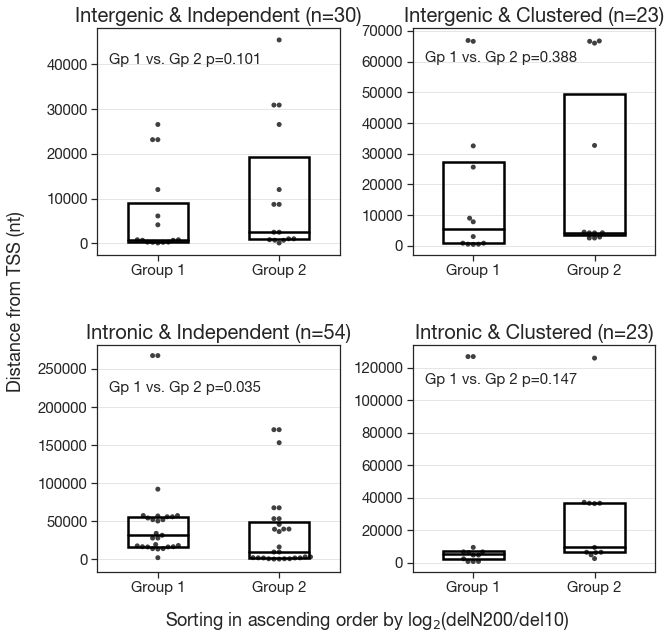

In [314]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
plt.subplots_adjust(hspace = 0.4, wspace = 0.3)

# ax[0,0]
sns.swarmplot(x="log2FC_group", y = "dist_TSS", data=TSS_miRTrans_box_inter_indep, size=5, color='black', alpha=0.75, ax=ax[0,0])
sns.boxplot(x='log2FC_group', y = "dist_TSS", data=TSS_miRTrans_box_inter_indep, width=0.5,showcaps=False, ax=ax[0,0],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p0 = mannwhitneyu(TSS_miRTrans_box_inter_indep[TSS_miRTrans_box_inter_indep["log2FC_group"] == 'Group 1']["dist_TSS"], \
                  TSS_miRTrans_box_inter_indep[TSS_miRTrans_box_inter_indep["log2FC_group"] == 'Group 2']["dist_TSS"], \
                  alternative='two-sided')[1]

ax[0,0].text(-0.4,40000,'Gp 1 vs. Gp 2 p=%.3f'%p0,  fontproperties=helvetica_15)

plt.setp(ax[0,0].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[0,0].lines, color='black') # Change box edgecolor

ax[0,0].set_title("Intergenic & Independent (n="+str(len(TSS_miRTrans_box_inter_indep))+")", fontproperties=helvetica_20)
ax[0,0].set_xlabel("", fontproperties=helvetica_18)
ax[0,0].set_ylabel("", fontproperties=helvetica_18)

ax[0,0].grid(axis='y', alpha=0.5)

# ax[0,1]
sns.swarmplot(x="log2FC_group", y = "dist_TSS", data=TSS_miRTrans_box_inter_clustered, size=5, color='black', alpha=0.75, ax=ax[0,1])
sns.boxplot(x='log2FC_group', y = "dist_TSS", data=TSS_miRTrans_box_inter_clustered, width=0.5,showcaps=False, ax=ax[0,1],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p1 = mannwhitneyu(TSS_miRTrans_box_inter_clustered[TSS_miRTrans_box_inter_clustered["log2FC_group"] == 'Group 1']["dist_TSS"], \
                  TSS_miRTrans_box_inter_clustered[TSS_miRTrans_box_inter_clustered["log2FC_group"] == 'Group 2']["dist_TSS"], \
                  alternative='two-sided')[1]

ax[0,1].text(-0.4,60000,'Gp 1 vs. Gp 2 p=%.3f'%p1,  fontproperties=helvetica_15)

plt.setp(ax[0,1].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[0,1].lines, color='black') # Change box edgecolor

ax[0,1].set_title("Intergenic & Clustered (n="+str(len(TSS_miRTrans_box_inter_clustered))+")", fontproperties=helvetica_20)
ax[0,1].set_xlabel("", fontproperties=helvetica_18)
ax[0,1].set_ylabel("", fontproperties=helvetica_18)

ax[0,1].grid(axis='y', alpha=0.5)


# ax[1,0]
sns.swarmplot(x="log2FC_group", y = "dist_TSS", data=TSS_miRTrans_box_intronic_indep, size=5, color='black', alpha=0.75, ax=ax[1,0])
sns.boxplot(x='log2FC_group', y = "dist_TSS", data=TSS_miRTrans_box_intronic_indep, width=0.5,showcaps=False, ax=ax[1,0],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p2 = mannwhitneyu(TSS_miRTrans_box_intronic_indep[TSS_miRTrans_box_intronic_indep["log2FC_group"] == 'Group 1']["dist_TSS"], \
                  TSS_miRTrans_box_intronic_indep[TSS_miRTrans_box_intronic_indep["log2FC_group"] == 'Group 2']["dist_TSS"], \
                  alternative='two-sided')[1]

ax[1,0].text(-0.4,220000,'Gp 1 vs. Gp 2 p=%.3f'%p2,  fontproperties=helvetica_15)

plt.setp(ax[1,0].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[1,0].lines, color='black') # Change box edgecolor

ax[1,0].set_title("Intronic & Independent (n="+str(len(TSS_miRTrans_box_intronic_indep))+")", fontproperties=helvetica_20)
ax[1,0].set_xlabel("", fontproperties=helvetica_18)
ax[1,0].set_ylabel("", fontproperties=helvetica_18)

ax[1,0].grid(axis='y', alpha=0.5)

# ax[1,1]
sns.swarmplot(x="log2FC_group", y = "dist_TSS", data=TSS_miRTrans_box_intronic_clustered, size=5, color='black', alpha=0.75, ax=ax[1,1])
sns.boxplot(x='log2FC_group', y = "dist_TSS", data=TSS_miRTrans_box_intronic_clustered, width=0.5,showcaps=False, ax=ax[1,1],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p3 = mannwhitneyu(TSS_miRTrans_box_intronic_clustered[TSS_miRTrans_box_intronic_clustered["log2FC_group"] == 'Group 1']["dist_TSS"], \
                  TSS_miRTrans_box_intronic_clustered[TSS_miRTrans_box_intronic_clustered["log2FC_group"] == 'Group 2']["dist_TSS"], \
                  alternative='two-sided')[1]

ax[1,1].text(-0.4,110000,'Gp 1 vs. Gp 2 p=%.3f'%p3,  fontproperties=helvetica_15)

plt.setp(ax[1,1].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[1,1].lines, color='black') # Change box edgecolor

ax[1,1].set_title("Intronic & Clustered (n="+str(len(TSS_miRTrans_box_inter_clustered))+")", fontproperties=helvetica_20)
ax[1,1].set_xlabel("", fontproperties=helvetica_18)
ax[1,1].set_ylabel("", fontproperties=helvetica_18)

ax[1,1].grid(axis='y', alpha=0.5)


fig.text(0.5, 0.05, 'Sorting in ascending order by log$_2$(delN200/del10)', ha='center', fontproperties=helvetica_18)
fig.text(0, 0.5, 'Distance from TSS (nt)', va='center', rotation='vertical', fontproperties=helvetica_18)


for x in range(2):
    for y in range(2):
        for label in ax[x,y].get_xticklabels():
            label.set_fontproperties(helvetica_15)
        for label in ax[x,y].get_yticklabels():
            label.set_fontproperties(helvetica_15)


plt.show()
# fig.savefig("Results/200923_miRTrans_TSS_gp2_box.pdf", bbox_inches='tight')
# fig.savefig("Results/200923_miRTrans_TSS_gp2_box.png", bbox_inches='tight')

In [ ]:
# del TSS_miRTrans, TSS_miRTrans_box, TSS_miRTrans_box_inter_clustered, TSS_miRTrans_box_inter_indep, TSS_miRTrans_box_intronic_clustered, \
# TSS_miRTrans_box_intronic_indep

#### Data from Transmir

##### Information about Transmir data

- Download tab -> download all evidence level TF-miRNA regulation data based on different species
- Among all data, use ONLY level2 (with experimental evidence)
- File name: 200902_TransmiR_v2_hsa.tsv
- (Maybe) 1-based, closed interval


In [113]:
Transmir = pd.read_table('../200902_from_other_db/200902_TransmiR_v2_hsa.tsv', header=None)
Transmir.rename(columns = {1:'pri-miRNA', 2:'chr:TSS', 6:'Evidence', 7:'Tissue', 8:'Species'}, inplace=True)
print(Transmir.shape)


# Select only level 2 information

Transmir = Transmir[Transmir["Evidence"] == 'level 2'][["pri-miRNA", "chr:TSS", "Tissue"]]

Transmir[["Chr", "TSS"]] = Transmir["chr:TSS"].str.split(':', expand=True)
Transmir["TSS"] = Transmir["TSS"].astype(int)

Transmir.drop(columns=["chr:TSS"], inplace=True)

Transmir.head()

(1206053, 9)


pri-miRNA Tissue    Chr        TSS
41      hsa-mir-4485  Blood  chr11   10509186
46   hsa-mir-548aa-2  Blood  chr17   67377307
65      hsa-mir-6502  Blood  chr12   66189291
66      hsa-mir-6502  Blood  chr12   66189291
136     hsa-mir-1307  Blood  chr10  103396453

TSSs are from different tissues, but they all have the same value. So, I just selected median to make them into 1 row for 1 pri-miRNA.

In [119]:
Transmir_median = pd.DataFrame(Transmir.groupby(['pri-miRNA'])["TSS"].median())
Transmir_median.head()

TSS
pri-miRNA              
hsa-let-7a-1   94166258
hsa-let-7a-2  122180632
hsa-let-7a-3   46085992
hsa-let-7b     46085992
hsa-let-7c     16419402

In [120]:
TSS_Transmir = SS_filtered_sub.join(Transmir_median, on = 'pri-miRNA', how='inner')
print(SS_filtered_sub.shape, TSS_Transmir.shape)

for i, row in TSS_Transmir.iterrows():
    if row["strand"] == '+':
        TSS_Transmir.loc[i,"dist_TSS"] = row["pri Start"] - row["TSS"]
    elif row["strand"] == '-':
        TSS_Transmir.loc[i,'dist_TSS'] = row["TSS"] - row["pri End"]
        
TSS_Transmir.head()

(296, 12) (251, 13)


mature     baseMean  log2FoldChange          padj  \
0  hsa-let-7a-2-3p    52.394713       -0.901333  6.683580e-02   
3    hsa-let-7b-3p   113.500150       -0.583679  7.642490e-02   
4    hsa-let-7b-5p  3288.216511       -0.136267  6.918580e-01   
5    hsa-let-7c-5p    86.709270       -0.235136  5.822707e-01   
6    hsa-let-7d-3p   205.664358       -2.068898  4.782894e-14   

  curated DROSHA dependency (HCT116)     pri-miRNA    Chr    pri Start  \
0                   DROSHA-dependent  hsa-let-7a-2  chr11  122146522.0   
3                   DROSHA-dependent    hsa-let-7b  chr22   46113686.0   
4                   DROSHA-dependent    hsa-let-7b  chr22   46113686.0   
5                   DROSHA-dependent    hsa-let-7c  chr21   16539828.0   
6                   DROSHA-dependent    hsa-let-7d   chr9   94178834.0   

       pri End strand Clustered_2000 Exon_Intron        TSS  dist_TSS  
0  122146593.0      -    independent  intergenic  122180632   34039.0  
3   46113768.0      +      clustered  intergenic   46085992   27694.0  
4   46113768.0      +      clustered  intergenic   46085992   27694.0  
5   16539911.0      +      clustered  intergenic   16419402  120426.0  
6   94178920.0      +    independent  intergenic   94166258   12576.0

In [121]:
TSS_Transmir_box = TSS_Transmir.sort_values(by='log2FoldChange')[["baseMean", "log2FoldChange","Clustered_2000","Exon_Intron","dist_TSS"]]

In [124]:
pd.crosstab(TSS_Transmir_box["Clustered_2000"], TSS_Transmir_box["Exon_Intron"])

Exon_Intron     exonic  intergenic  intronic
Clustered_2000                              
clustered            6          61        33
independent         13          47        91

In [125]:
TSS_Transmir_box_inter_indep = TSS_Transmir_box[(TSS_Transmir_box["Exon_Intron"] == 'intergenic') & (TSS_Transmir_box["Clustered_2000"] == 'independent')]
TSS_Transmir_box_inter_clustered = TSS_Transmir_box[(TSS_Transmir_box["Exon_Intron"] == 'intergenic') & (TSS_Transmir_box["Clustered_2000"] == 'clustered')]
TSS_Transmir_box_intronic_indep = TSS_Transmir_box[(TSS_Transmir_box["Exon_Intron"] == 'intronic') & (TSS_Transmir_box["Clustered_2000"] == 'independent')]
TSS_Transmir_box_intronic_clustered = TSS_Transmir_box[(TSS_Transmir_box["Exon_Intron"] == 'intronic') & (TSS_Transmir_box["Clustered_2000"] == 'clustered')]

print(TSS_Transmir_box_inter_indep.shape, TSS_Transmir_box_inter_clustered.shape, TSS_Transmir_box_intronic_indep.shape, TSS_Transmir_box_intronic_clustered.shape)

(47, 5) (61, 5) (91, 5) (33, 5)


In [127]:
TSS_Transmir_box_inter_indep.loc[:,'log2FC_group'] = \
pd.qcut(TSS_Transmir_box_inter_indep['log2FoldChange'], 2, labels=['Group 1', 'Group 2'])
TSS_Transmir_box_inter_indep.loc[:,'baseMean_group'] = \
pd.qcut(TSS_Transmir_box_inter_indep['baseMean'], 2, labels=['Group 1', 'Group 2'])

TSS_Transmir_box_inter_clustered.loc[:,'log2FC_group'] = \
pd.qcut(TSS_Transmir_box_inter_clustered['log2FoldChange'], 2, labels=['Group 1', 'Group 2'])
TSS_Transmir_box_inter_clustered.loc[:,'baseMean_group'] = \
pd.qcut(TSS_Transmir_box_inter_clustered['baseMean'], 2, labels=['Group 1', 'Group 2'])

TSS_Transmir_box_intronic_indep.loc[:,'log2FC_group'] = \
pd.qcut(TSS_Transmir_box_intronic_indep['log2FoldChange'], 2, labels=['Group 1', 'Group 2'])
TSS_Transmir_box_intronic_indep.loc[:,'baseMean_group'] = \
pd.qcut(TSS_Transmir_box_intronic_indep['baseMean'], 2, labels=['Group 1', 'Group 2'])

TSS_Transmir_box_intronic_clustered.loc[:,'log2FC_group'] = \
pd.qcut(TSS_Transmir_box_intronic_clustered['log2FoldChange'], 2, labels=['Group 1', 'Group 2'])
TSS_Transmir_box_intronic_clustered.loc[:,'baseMean_group'] = \
pd.qcut(TSS_Transmir_box_intronic_clustered['baseMean'], 2, labels=['Group 1', 'Group 2'])

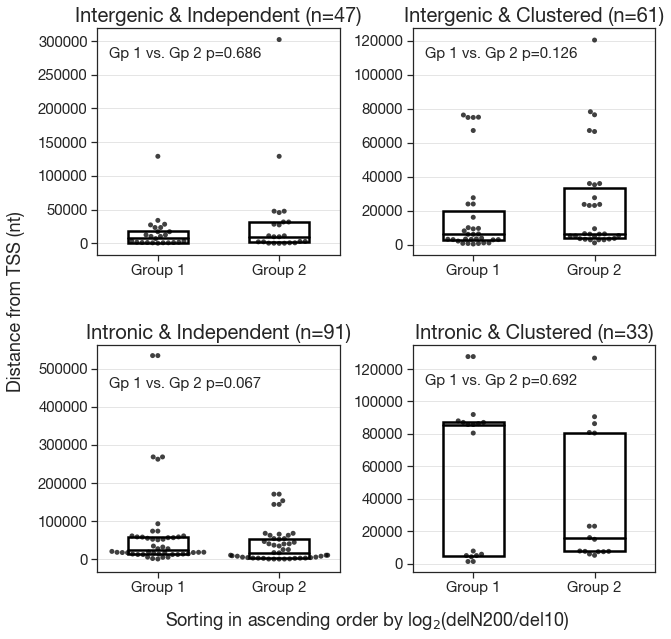

In [315]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
plt.subplots_adjust(hspace = 0.4, wspace = 0.3)

# ax[0,0]
sns.swarmplot(x="log2FC_group", y = "dist_TSS", data=TSS_Transmir_box_inter_indep, size=5, color='black', alpha=0.75, ax=ax[0,0])
sns.boxplot(x='log2FC_group', y = "dist_TSS", data=TSS_Transmir_box_inter_indep, width=0.5,showcaps=False, ax=ax[0,0],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p0 = mannwhitneyu(TSS_Transmir_box_inter_indep[TSS_Transmir_box_inter_indep["log2FC_group"] == 'Group 1']["dist_TSS"], \
                  TSS_Transmir_box_inter_indep[TSS_Transmir_box_inter_indep["log2FC_group"] == 'Group 2']["dist_TSS"], \
                  alternative='two-sided')[1]

ax[0,0].text(-0.4,275000,'Gp 1 vs. Gp 2 p=%.3f'%p0,  fontproperties=helvetica_15)

plt.setp(ax[0,0].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[0,0].lines, color='black') # Change box edgecolor

ax[0,0].set_title("Intergenic & Independent (n="+str(len(TSS_Transmir_box_inter_indep))+")", fontproperties=helvetica_20)
ax[0,0].set_xlabel("", fontproperties=helvetica_18)
ax[0,0].set_ylabel("", fontproperties=helvetica_18)

ax[0,0].grid(axis='y', alpha=0.5)

# ax[0,1]
sns.swarmplot(x="log2FC_group", y = "dist_TSS", data=TSS_Transmir_box_inter_clustered, size=5, color='black', alpha=0.75, ax=ax[0,1])
sns.boxplot(x='log2FC_group', y = "dist_TSS", data=TSS_Transmir_box_inter_clustered, width=0.5,showcaps=False, ax=ax[0,1],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p1 = mannwhitneyu(TSS_Transmir_box_inter_clustered[TSS_Transmir_box_inter_clustered["log2FC_group"] == 'Group 1']["dist_TSS"], \
                  TSS_Transmir_box_inter_clustered[TSS_Transmir_box_inter_clustered["log2FC_group"] == 'Group 2']["dist_TSS"], \
                  alternative='two-sided')[1]

ax[0,1].text(-0.4,110000,'Gp 1 vs. Gp 2 p=%.3f'%p1,  fontproperties=helvetica_15)

plt.setp(ax[0,1].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[0,1].lines, color='black') # Change box edgecolor

ax[0,1].set_title("Intergenic & Clustered (n="+str(len(TSS_Transmir_box_inter_clustered))+")", fontproperties=helvetica_20)
ax[0,1].set_xlabel("", fontproperties=helvetica_18)
ax[0,1].set_ylabel("", fontproperties=helvetica_18)

ax[0,1].grid(axis='y', alpha=0.5)


# ax[1,0]
sns.swarmplot(x="log2FC_group", y = "dist_TSS", data=TSS_Transmir_box_intronic_indep, size=5, color='black', alpha=0.75, ax=ax[1,0])
sns.boxplot(x='log2FC_group', y = "dist_TSS", data=TSS_Transmir_box_intronic_indep, width=0.5,showcaps=False, ax=ax[1,0],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p2 = mannwhitneyu(TSS_Transmir_box_intronic_indep[TSS_Transmir_box_intronic_indep["log2FC_group"] == 'Group 1']["dist_TSS"], \
                  TSS_Transmir_box_intronic_indep[TSS_Transmir_box_intronic_indep["log2FC_group"] == 'Group 2']["dist_TSS"], \
                  alternative='two-sided')[1]

ax[1,0].text(-0.4,450000,'Gp 1 vs. Gp 2 p=%.3f'%p2,  fontproperties=helvetica_15)

plt.setp(ax[1,0].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[1,0].lines, color='black') # Change box edgecolor

ax[1,0].set_title("Intronic & Independent (n="+str(len(TSS_Transmir_box_intronic_indep))+")", fontproperties=helvetica_20)
ax[1,0].set_xlabel("", fontproperties=helvetica_18)
ax[1,0].set_ylabel("", fontproperties=helvetica_18)

ax[1,0].grid(axis='y', alpha=0.5)

# ax[1,1]
sns.swarmplot(x="log2FC_group", y = "dist_TSS", data=TSS_Transmir_box_intronic_clustered, size=5, color='black', alpha=0.75, ax=ax[1,1])
sns.boxplot(x='log2FC_group', y = "dist_TSS", data=TSS_Transmir_box_intronic_clustered, width=0.5,showcaps=False, ax=ax[1,1],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p3 = mannwhitneyu(TSS_Transmir_box_intronic_clustered[TSS_Transmir_box_intronic_clustered["log2FC_group"] == 'Group 1']["dist_TSS"], \
                  TSS_Transmir_box_intronic_clustered[TSS_Transmir_box_intronic_clustered["log2FC_group"] == 'Group 2']["dist_TSS"], \
                  alternative='two-sided')[1]

ax[1,1].text(-0.4,110000,'Gp 1 vs. Gp 2 p=%.3f'%p3,  fontproperties=helvetica_15)

plt.setp(ax[1,1].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[1,1].lines, color='black') # Change box edgecolor

ax[1,1].set_title("Intronic & Clustered (n="+str(len(TSS_Transmir_box_intronic_clustered))+")", fontproperties=helvetica_20)
ax[1,1].set_xlabel("", fontproperties=helvetica_18)
ax[1,1].set_ylabel("", fontproperties=helvetica_18)

ax[1,1].grid(axis='y', alpha=0.5)



fig.text(0.5, 0.05, 'Sorting in ascending order by log$_2$(delN200/del10)', ha='center', fontproperties=helvetica_18)
fig.text(0, 0.5, 'Distance from TSS (nt)', va='center', rotation='vertical', fontproperties=helvetica_18)


for x in range(2):
    for y in range(2):
        for label in ax[x,y].get_xticklabels():
            label.set_fontproperties(helvetica_15)
        for label in ax[x,y].get_yticklabels():
            label.set_fontproperties(helvetica_15)


plt.show()
# fig.savefig("Results/200923_Transmir_TSS_gp2_box.pdf", bbox_inches='tight')
# fig.savefig("Results/200923_Transmir_TSS_gp2_box.png", bbox_inches='tight')

In [457]:
# del TSS_Transmir, TSS_Transmir_box, TSS_Transmir_box_inter_clustered, TSS_Transmir_box_inter_indep, TSS_Transmir_box_intronic_clustered, \
# TSS_Transmir_box_intronic_indep

--- 
### Relationship between processing efficiency and N-term dependency among intronic miRNAs

- processing efficiency information is from 기준&승찬's previous value. It will be good if this old value is changed to the new value.
- Join with SS_filtered_2000

In [541]:
processing_efficiency = pd.read_csv('../../work/190905_sRNA_HCT116_rescue_set_3/190712_processing-efficiency.csv')
processing_efficiency.rename(columns={"Unnamed: 0": 'pri-miRNA'}, inplace=True)
processing_efficiency.set_index('pri-miRNA', inplace=True)
processing_efficiency.head()

processing efficiency
pri-miRNA                          
hsa-let-7a-1               0.989094
hsa-let-7a-2               0.943417
hsa-let-7a-3               0.218110
hsa-let-7b                 0.421281
hsa-let-7c                 0.668082

In [542]:
SS_filtered_2000.head()

mature      baseMean  log2FoldChange      stat    pvalue  \
0  hsa-let-7a-2-3p     52.394713       -0.901333 -2.165859  0.030322   
1    hsa-let-7a-3p    410.786354       -0.089378 -0.436403  0.662545   
2    hsa-let-7a-5p  15216.651736        0.009163  0.047385  0.962207   
3    hsa-let-7b-3p    113.500150       -0.583679 -2.091957  0.036442   
4    hsa-let-7b-5p   3288.216511       -0.136267 -0.518374  0.604197   

       padj curated DROSHA dependency (HCT116) 5p3p     pri-miRNA    Chr  \
0  0.066836                   DROSHA-dependent   3p  hsa-let-7a-2  chr11   
1  0.740194                   DROSHA-dependent   3p           NaN    NaN   
2  0.982280                   DROSHA-dependent   5p           NaN    NaN   
3  0.076425                   DROSHA-dependent   3p    hsa-let-7b  chr22   
4  0.691858                   DROSHA-dependent   5p    hsa-let-7b  chr22   

        ...        Exon_Intron  HostGene Direction stem length  loop  \
0       ...         intergenic         0         0        36.0  21.0   
1       ...                NaN       NaN       NaN         NaN   NaN   
2       ...                NaN       NaN       NaN         NaN   NaN   
3       ...         intergenic         0         0        34.0  30.0   
4       ...         intergenic         0         0        34.0  30.0   

  simple loop    UG    CNNC    UGU  Clustered_2000  
0        21.0    UG    CNNC  NoUGU     independent  
1         NaN   NaN     NaN    NaN             NaN  
2         NaN   NaN     NaN    NaN             NaN  
3         7.0  NoUG  NoCNNC  NoUGU       clustered  
4         7.0  NoUG  NoCNNC  NoUGU       clustered  

[5 rows x 25 columns]

In [543]:
SS_pe = SS_filtered_2000.join(processing_efficiency, on='pri-miRNA', how='left')
SS_pe.head()

mature      baseMean  log2FoldChange      stat    pvalue  \
0  hsa-let-7a-2-3p     52.394713       -0.901333 -2.165859  0.030322   
1    hsa-let-7a-3p    410.786354       -0.089378 -0.436403  0.662545   
2    hsa-let-7a-5p  15216.651736        0.009163  0.047385  0.962207   
3    hsa-let-7b-3p    113.500150       -0.583679 -2.091957  0.036442   
4    hsa-let-7b-5p   3288.216511       -0.136267 -0.518374  0.604197   

       padj curated DROSHA dependency (HCT116) 5p3p     pri-miRNA    Chr  \
0  0.066836                   DROSHA-dependent   3p  hsa-let-7a-2  chr11   
1  0.740194                   DROSHA-dependent   3p           NaN    NaN   
2  0.982280                   DROSHA-dependent   5p           NaN    NaN   
3  0.076425                   DROSHA-dependent   3p    hsa-let-7b  chr22   
4  0.691858                   DROSHA-dependent   5p    hsa-let-7b  chr22   

           ...            HostGene  Direction stem length  loop simple loop  \
0          ...                   0          0        36.0  21.0        21.0   
1          ...                 NaN        NaN         NaN   NaN         NaN   
2          ...                 NaN        NaN         NaN   NaN         NaN   
3          ...                   0          0        34.0  30.0         7.0   
4          ...                   0          0        34.0  30.0         7.0   

     UG    CNNC    UGU  Clustered_2000  processing efficiency  
0    UG    CNNC  NoUGU     independent               0.943417  
1   NaN     NaN    NaN             NaN                    NaN  
2   NaN     NaN    NaN             NaN                    NaN  
3  NoUG  NoCNNC  NoUGU       clustered               0.421281  
4  NoUG  NoCNNC  NoUGU       clustered               0.421281  

[5 rows x 26 columns]

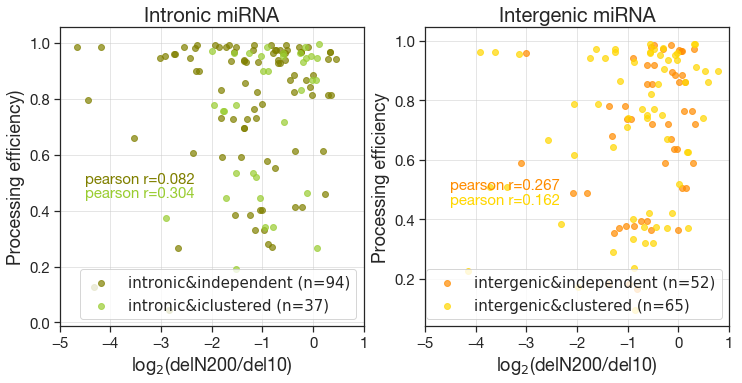

In [545]:
fig, ax = plt.subplots(1,2,figsize=(12,5.5))

ax[0].scatter(SS_pe[(SS_pe["Exon_Intron"] == 'intronic')&(SS_pe["Clustered_2000"] == 'independent')]["log2FoldChange"], \
              SS_pe[(SS_pe["Exon_Intron"] == 'intronic')&(SS_pe["Clustered_2000"] == 'independent')]["processing efficiency"], \
              c='olive', label='intronic&independent'+' (n='+str(len(SS_pe[(SS_pe["Exon_Intron"] == 'intronic')&(SS_pe["Clustered_2000"] == 'independent')]))+')', alpha=0.7)
ax[0].scatter(SS_pe[(SS_pe["Exon_Intron"] == 'intronic')&(SS_pe["Clustered_2000"] == 'clustered')]["log2FoldChange"], \
              SS_pe[(SS_pe["Exon_Intron"] == 'intronic')&(SS_pe["Clustered_2000"] == 'clustered')]["processing efficiency"],\
              c='yellowgreen', label='intronic&iclustered'+' (n='+str(len(SS_pe[(SS_pe["Exon_Intron"] == 'intronic')&(SS_pe["Clustered_2000"] == 'clustered')]))+')',alpha=0.7)

ax[0].set_title("Intronic miRNA", fontproperties=helvetica_20)
ax[0].set_xlabel("log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[0].set_ylabel("Processing efficiency)", fontproperties=helvetica_18)
ax[0].grid(axis='y', alpha=0.5)
ax[0].grid(axis='x', alpha=0.5)
ax[0].set_xlim(-5,1)
ax[0].legend(frameon=True, fontsize=15, scatterpoints=1, loc='lower right')

### calculate pearson correlation between log2FC and processing efficiency
tmp = SS_pe[(~SS_pe["log2FoldChange"].isna())&(~SS_pe["processing efficiency"].isna())]
r00 = stats.pearsonr(tmp[(tmp["Exon_Intron"] == 'intronic')&(tmp["Clustered_2000"] == 'independent')]["log2FoldChange"], \
                    tmp[(tmp["Exon_Intron"] == 'intronic')&(tmp["Clustered_2000"] == 'independent')]["processing efficiency"])[0]
r01 = stats.pearsonr(tmp[(tmp["Exon_Intron"] == 'intronic')&(tmp["Clustered_2000"] == 'clustered')]["log2FoldChange"], \
                    tmp[(tmp["Exon_Intron"] == 'intronic')&(tmp["Clustered_2000"] == 'clustered')]["processing efficiency"])[0]
ax[0].text(-4.5,0.5,'pearson r=%.3f'%r00,  fontproperties=helvetica_15, color='olive')
ax[0].text(-4.5,0.45,'pearson r=%.3f'%r01,  fontproperties=helvetica_15, color='yellowgreen')

ax[1].scatter(SS_pe[(SS_pe["Exon_Intron"] == 'intergenic')&(SS_pe["Clustered_2000"] == 'independent')]["log2FoldChange"], \
              SS_pe[(SS_pe["Exon_Intron"] == 'intergenic')&(SS_pe["Clustered_2000"] == 'independent')]["processing efficiency"], \
              c='darkorange', label='intergenic&independent'+' (n='+str(len(SS_pe[(SS_pe["Exon_Intron"] == 'intergenic')&(SS_pe["Clustered_2000"] == 'independent')]))+')',alpha=0.7)
ax[1].scatter(SS_pe[(SS_pe["Exon_Intron"] == 'intergenic')&(SS_pe["Clustered_2000"] == 'clustered')]["log2FoldChange"], \
              SS_pe[(SS_pe["Exon_Intron"] == 'intergenic')&(SS_pe["Clustered_2000"] == 'clustered')]["processing efficiency"], \
              c='gold', label='intergenic&clustered'+' (n='+str(len(SS_pe[(SS_pe["Exon_Intron"] == 'intergenic')&(SS_pe["Clustered_2000"] == 'clustered')]))+')',alpha=0.7)

ax[1].set_title("Intergenic miRNA", fontproperties=helvetica_20)
ax[1].set_xlabel("log$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[1].set_ylabel("Processing efficiency", fontproperties=helvetica_18)
ax[1].grid(axis='y', alpha=0.5)
ax[1].grid(axis='x', alpha=0.5)
ax[1].set_xlim(-5,1)
ax[1].legend(frameon=True, fontsize=15, scatterpoints=1, loc='lower right')

### calculate pearson correlation between log2FC and processing efficiency
r10 = stats.pearsonr(tmp[(tmp["Exon_Intron"] == 'intergenic')&(tmp["Clustered_2000"] == 'independent')]["log2FoldChange"], \
                    tmp[(tmp["Exon_Intron"] == 'intergenic')&(tmp["Clustered_2000"] == 'independent')]["processing efficiency"])[0]
r11 = stats.pearsonr(tmp[(tmp["Exon_Intron"] == 'intergenic')&(tmp["Clustered_2000"] == 'clustered')]["log2FoldChange"], \
                    tmp[(tmp["Exon_Intron"] == 'intergenic')&(tmp["Clustered_2000"] == 'clustered')]["processing efficiency"])[0]
ax[1].text(-4.5,0.5,'pearson r=%.3f'%r10,  fontproperties=helvetica_15, color='darkorange')
ax[1].text(-4.5,0.45,'pearson r=%.3f'%r11,  fontproperties=helvetica_15, color='gold')

for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)

del tmp

In [54]:
SS_pe_intronic_indep_box = SS_pe[(SS_pe['Clustered_2000'] == "independent") & (SS_pe['Exon_Intron'] == "intronic")].sort_values(by='log2FoldChange')[["baseMean", "log2FoldChange","processing efficiency"]]
SS_pe_inter_indep_box = SS_pe[(SS_pe['Clustered_2000'] == "independent") & (SS_pe['Exon_Intron'] == "intergenic")].sort_values(by='log2FoldChange')[["baseMean", "log2FoldChange","processing efficiency"]]
print(SS_pe_inter_indep_box.shape, SS_pe_intronic_indep_box.shape)

(52, 3) (94, 3)


In [55]:
pd.crosstab(SS_filtered_2000["Exon_Intron"], SS_filtered_2000["Clustered_2000"])

Clustered_2000  clustered  independent
Exon_Intron                           
exonic                  6           13
intergenic             65           52
intronic               37           94

In [56]:
SS_pe_intronic_indep_box["log2FC_group"] = \
pd.qcut(SS_pe_intronic_indep_box["log2FoldChange"], 2, labels=['Group 1', 'Group 2'])
SS_pe_intronic_indep_box["baseMean_group"] = \
pd.qcut(SS_pe_intronic_indep_box["baseMean"], 2, labels=['Group 1', 'Group 2'])

SS_pe_inter_indep_box["log2FC_group"] = \
pd.qcut(SS_pe_inter_indep_box["log2FoldChange"], 2, labels=['Group 1', 'Group 2'])
SS_pe_inter_indep_box["baseMean_group"] = \
pd.qcut(SS_pe_inter_indep_box["baseMean"], 2, labels=['Group 1', 'Group 2'])

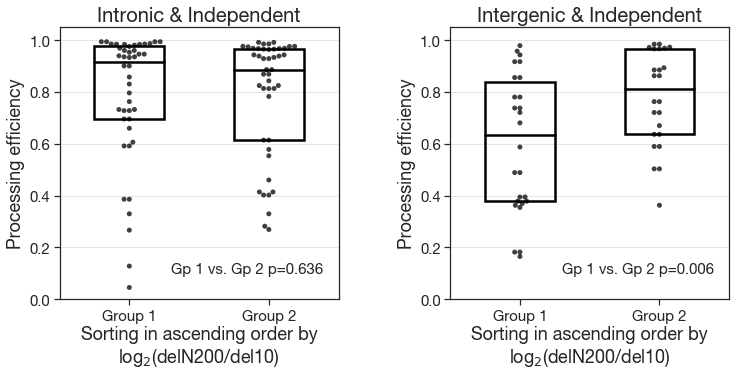

In [57]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

# ax[0]
sns.swarmplot(x="log2FC_group", y = "processing efficiency", data=SS_pe_intronic_indep_box, size=5, color='black', alpha=0.75, ax=ax[0])
sns.boxplot(x='log2FC_group', y = "processing efficiency", data=SS_pe_intronic_indep_box, width=0.5,showcaps=False, ax=ax[0],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p00 = mannwhitneyu(SS_pe_intronic_indep_box[SS_pe_intronic_indep_box["log2FC_group"] == 'Group 1']["processing efficiency"], 
                   SS_pe_intronic_indep_box[SS_pe_intronic_indep_box["log2FC_group"] == 'Group 2']["processing efficiency"], alternative='two-sided')[1]

ax[0].text(0.3,0.1,'Gp 1 vs. Gp 2 p=%.3f'%p00,  fontproperties=helvetica_15)


plt.setp(ax[0].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[0].lines, color='black') # Change box edgecolor

ax[0].set_title("Intronic & Independent", fontproperties=helvetica_20)
ax[0].set_xlabel("Sorting in ascending order by\nlog$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[0].set_ylabel("Processing efficiency", fontproperties=helvetica_18)
ax[0].set_ylim(0,1.05)
    
ax[0].grid(axis='y', alpha=0.5)


# ax[1]
sns.swarmplot(x="log2FC_group", y = "processing efficiency", data=SS_pe_inter_indep_box, size=5, color='black', alpha=0.75, ax=ax[1])
sns.boxplot(x='log2FC_group', y = "processing efficiency", data=SS_pe_inter_indep_box, width=0.5,showcaps=False, ax=ax[1],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p10 = mannwhitneyu(SS_pe_inter_indep_box[SS_pe_inter_indep_box["log2FC_group"] == 'Group 1']["processing efficiency"], 
                   SS_pe_inter_indep_box[SS_pe_inter_indep_box["log2FC_group"] == 'Group 2']["processing efficiency"], alternative='two-sided')[1]

ax[1].text(0.3,0.1,'Gp 1 vs. Gp 2 p=%.3f'%p10,  fontproperties=helvetica_15)


plt.setp(ax[1].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[1].lines, color='black') # Change box edgecolor

ax[1].set_title("Intergenic & Independent", fontproperties=helvetica_20)
ax[1].set_xlabel("Sorting in ascending order by\nlog$_2$(delN200/del10)", fontproperties=helvetica_18)
ax[1].set_ylabel("Processing efficiency", fontproperties=helvetica_18)
ax[1].set_ylim(0,1.05)
    
ax[1].grid(axis='y', alpha=0.5)



for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontproperties(helvetica_15)


plt.show() 

Cleavage efficiency and homogeneity new version (201214, KJ, SC's final version)

In [469]:
KJ_SC = pd.read_csv('from_KJ_SC/201214_KJ_SC_IVP_Microprocessor_only.csv').iloc[:,[0,1,2]]
KJ_SC.set_index('Pri-miRNA', inplace=True)
KJ_SC.head()

Cleavage Efficiency  Cleavage Homogeneity
Pri-miRNA                                              
hsa-let-7a-1             5.547485              0.882549
hsa-let-7a-2             4.725219              0.787974
hsa-let-7a-3             3.003643              0.499679
hsa-let-7b               4.454751              0.767644
hsa-let-7c               0.000000              0.119761

In [470]:
KJ_SC_joined=\
DD_filtered_2000.join(\
                      KJ_SC, on='pri-miRNA', how='left').loc[DD_filtered_2000.join(KJ_SC, on='pri-miRNA', how='left').loc[:,["Cleavage Efficiency", "Cleavage Homogeneity"]].dropna().index,:]

print(KJ_SC_joined.shape)
KJ_SC_joined.head()

(273, 25)


baseMean  log2FoldChange      stat        pvalue  \
mature                                                                 
hsa-let-7a-2-3p    52.394713       -0.901333 -2.165859  3.032197e-02   
hsa-let-7b-3p     113.500150       -0.583679 -2.091957  3.644239e-02   
hsa-let-7b-5p    3288.216511       -0.136267 -0.518374  6.041975e-01   
hsa-let-7c-5p      86.709270       -0.235136 -0.698768  4.846967e-01   
hsa-let-7d-3p     205.664358       -2.068898 -8.038121  9.122686e-16   

                         padj curated DROSHA dependency (HCT116)  \
mature                                                             
hsa-let-7a-2-3p  6.683580e-02                   DROSHA-dependent   
hsa-let-7b-3p    7.642490e-02                   DROSHA-dependent   
hsa-let-7b-5p    6.918580e-01                   DROSHA-dependent   
hsa-let-7c-5p    5.822707e-01                   DROSHA-dependent   
hsa-let-7d-3p    4.782894e-14                   DROSHA-dependent   

                    pri-miRNA    Chr    pri Start      pri End  \
mature                                                           
hsa-let-7a-2-3p  hsa-let-7a-2  chr11  122146522.0  122146593.0   
hsa-let-7b-3p      hsa-let-7b  chr22   46113686.0   46113768.0   
hsa-let-7b-5p      hsa-let-7b  chr22   46113686.0   46113768.0   
hsa-let-7c-5p      hsa-let-7c  chr21   16539828.0   16539911.0   
hsa-let-7d-3p      hsa-let-7d   chr9   94178834.0   94178920.0   

                        ...          Direction stem length  loop simple loop  \
mature                  ...                                                    
hsa-let-7a-2-3p         ...                  0        36.0  21.0        21.0   
hsa-let-7b-3p           ...                  0        34.0  30.0         7.0   
hsa-let-7b-5p           ...                  0        34.0  30.0         7.0   
hsa-let-7c-5p           ...                  0        37.0  21.0        21.0   
hsa-let-7d-3p           ...                  0         NaN   NaN         NaN   

                   UG    CNNC    UGU  Clustered_2000  Cleavage Efficiency  \
mature                                                                      
hsa-let-7a-2-3p    UG    CNNC  NoUGU     independent             4.725219   
hsa-let-7b-3p    NoUG  NoCNNC  NoUGU       clustered             4.454751   
hsa-let-7b-5p    NoUG  NoCNNC  NoUGU       clustered             4.454751   
hsa-let-7c-5p      UG  NoCNNC  NoUGU       clustered             0.000000   
hsa-let-7d-3p     NaN     NaN    NaN     independent             4.089958   

                Cleavage Homogeneity  
mature                                
hsa-let-7a-2-3p             0.787974  
hsa-let-7b-3p               0.767644  
hsa-let-7b-5p               0.767644  
hsa-let-7c-5p               0.119761  
hsa-let-7d-3p               0.492728  

[5 rows x 25 columns]

In [488]:
KJ_SC_joined["sig"] = \
np.where(((KJ_SC_joined['padj'] < 0.05) & (np.abs(KJ_SC_joined["log2FoldChange"]) > log2FC_cutoff)), "More dependent", 'Less dependent')

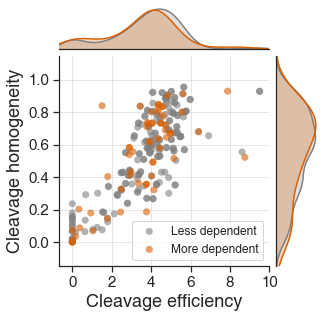

In [490]:
# start with a square Figure
fig = plt.figure(figsize=(4.5, 4.5))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(5, 1), height_ratios=(1, 5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histx.get_yticklabels(), visible=False)
ax_histx.tick_params(axis='both', which='both', length=0)

ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
plt.setp(ax_histy.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
ax_histy.tick_params(axis='both', which='both', length=0)

ax.scatter(KJ_SC_joined[KJ_SC_joined['sig'] == 'Less dependent']["Cleavage Efficiency"], \
           KJ_SC_joined[KJ_SC_joined['sig'] == 'Less dependent']["Cleavage Homogeneity"], \
           c='#808080', alpha=0.6, s=50, edgecolors='none', label='Less dependent')
ax.scatter(KJ_SC_joined[KJ_SC_joined['sig'] == 'More dependent']["Cleavage Efficiency"], \
           KJ_SC_joined[KJ_SC_joined['sig'] == 'More dependent']["Cleavage Homogeneity"], \
           c='#d95f02', alpha=0.6, s=50, edgecolors='none', label='More dependent')
ax.set_xlim(-0.7,10)
ax.set_ylim(-0.15,1.15)

sns.kdeplot(KJ_SC_joined[KJ_SC_joined['sig'] == 'Less dependent']["Cleavage Efficiency"], ax=ax_histx, \
            color='#808080', shade=True, legend=False)
sns.kdeplot(KJ_SC_joined[KJ_SC_joined['sig'] == 'More dependent']["Cleavage Efficiency"], ax=ax_histx, \
            color='#d95f02', shade=True, legend=False)

sns.kdeplot(KJ_SC_joined[KJ_SC_joined['sig'] == 'Less dependent']["Cleavage Homogeneity"], ax=ax_histy, \
            color='#808080',shade=True, legend=False, vertical=True)
sns.kdeplot(KJ_SC_joined[KJ_SC_joined['sig'] == 'More dependent']["Cleavage Homogeneity"], ax=ax_histy, \
            color='#d95f02', shade=True, legend=False, vertical=True)

ax_histx.set_xlabel('')
ax_histy.set_ylabel('')

ax_histx.spines['top'].set_visible(False)
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['left'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)
ax_histy.spines['right'].set_visible(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)
ax.set_xlabel("Cleavage efficiency", fontsize=18)
ax.set_ylabel("Cleavage homogeneity", fontsize=18)
ax.legend(loc="lower right", fontsize=12)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)

fig.show()
#plt.savefig("Results/Figures/201214-KJSC-HCT116.pdf", bbox_inches='tight')

#### SC provided delN data
- 201123_test__DROSHA_processing_result_deln.csv : 390 deleted DROSHA + 285 deleted DGCR8 recombinant
- 201123_s3__DROSHA_processing_result.csv : full-length DROSHA + full-length DGCR8

In [494]:
deln_KJSC = pd.read_csv('from_KJ_SC/201123_test__DROSHA_processing_result_deln.csv').iloc[:,[0,1,2]]
full_KJSC = pd.read_csv('from_KJ_SC/201123_s3__DROSHA_processing_result.csv').iloc[:,[0,1,2]]

deln_KJSC.set_index('Pri-miRNA', inplace=True)
full_KJSC.set_index('Pri-miRNA', inplace=True)

deln_KJSC.head()

Cleavage Efficiency  Cleavage Homogeneity
Pri-miRNA                                              
hsa-let-7a-1             6.144972              0.872833
hsa-let-7a-2             4.469654              0.676222
hsa-let-7a-3             1.077700              0.383883
hsa-let-7b               3.626026              0.655877
hsa-let-7c               0.000000              0.024062

In [511]:
pseudonum = 0.01

data_KJSC = deln_KJSC.join(full_KJSC, how='inner', lsuffix='_deln', rsuffix='_full')
data_KJSC["log2CE(deln/full)"] = np.log2((data_KJSC["Cleavage Efficiency_deln"] + pseudonum) / (data_KJSC["Cleavage Efficiency_full"] + pseudonum))
data_KJSC["log2CH(deln/full)"] = np.log2((data_KJSC["Cleavage Homogeneity_deln"] + pseudonum) / (data_KJSC["Cleavage Homogeneity_full"] + pseudonum))

data_KJSC.head()

Cleavage Efficiency_deln  Cleavage Homogeneity_deln  \
Pri-miRNA                                                           
hsa-let-7a-1                  6.144972                   0.872833   
hsa-let-7a-2                  4.469654                   0.676222   
hsa-let-7a-3                  1.077700                   0.383883   
hsa-let-7b                    3.626026                   0.655877   
hsa-let-7c                    0.000000                   0.024062   

              Cleavage Efficiency_full  Cleavage Homogeneity_full  \
Pri-miRNA                                                           
hsa-let-7a-1                  5.547485                   0.882549   
hsa-let-7a-2                  4.725219                   0.787974   
hsa-let-7a-3                  3.003643                   0.499679   
hsa-let-7b                    4.454751                   0.767644   
hsa-let-7c                    0.000000                   0.119761   

              log2CE(deln/full)  log2CH(deln/full)  
Pri-miRNA                                           
hsa-let-7a-1           0.147320          -0.015791  
hsa-let-7a-2          -0.080044          -0.217666  
hsa-let-7a-3          -1.470228          -0.371822  
hsa-let-7b            -0.296217          -0.223855  
hsa-let-7c             0.000000          -1.929615

In [517]:
KJSC_joined = DD_filtered_2000.join(data_KJSC, on='pri-miRNA', how='left')
KJSC_joined = KJSC_joined.loc[KJSC_joined.loc[:, ["log2CE(deln/full)", "log2CH(deln/full)"]].dropna().index, :]

print(KJSC_joined.shape)
KJSC_joined.head()

(265, 29)


baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                       
hsa-let-7a-2-3p    52.394713       -0.901333 -2.165859  0.030322  0.066836   
hsa-let-7b-3p     113.500150       -0.583679 -2.091957  0.036442  0.076425   
hsa-let-7b-5p    3288.216511       -0.136267 -0.518374  0.604197  0.691858   
hsa-let-7c-5p      86.709270       -0.235136 -0.698768  0.484697  0.582271   
hsa-let-7e-3p      19.727205       -1.399991 -2.897148  0.003766  0.012796   

                curated DROSHA dependency (HCT116)     pri-miRNA    Chr  \
mature                                                                    
hsa-let-7a-2-3p                   DROSHA-dependent  hsa-let-7a-2  chr11   
hsa-let-7b-3p                     DROSHA-dependent    hsa-let-7b  chr22   
hsa-let-7b-5p                     DROSHA-dependent    hsa-let-7b  chr22   
hsa-let-7c-5p                     DROSHA-dependent    hsa-let-7c  chr21   
hsa-let-7e-3p                     DROSHA-dependent    hsa-let-7e  chr19   

                   pri Start      pri End        ...           UG    CNNC  \
mature                                           ...                        
hsa-let-7a-2-3p  122146522.0  122146593.0        ...           UG    CNNC   
hsa-let-7b-3p     46113686.0   46113768.0        ...         NoUG  NoCNNC   
hsa-let-7b-5p     46113686.0   46113768.0        ...         NoUG  NoCNNC   
hsa-let-7c-5p     16539828.0   16539911.0        ...           UG  NoCNNC   
hsa-let-7e-3p     51692786.0   51692864.0        ...         NoUG  NoCNNC   

                   UGU Clustered_2000 Cleavage Efficiency_deln  \
mature                                                           
hsa-let-7a-2-3p  NoUGU    independent                 4.469654   
hsa-let-7b-3p    NoUGU      clustered                 3.626026   
hsa-let-7b-5p    NoUGU      clustered                 3.626026   
hsa-let-7c-5p    NoUGU      clustered                 0.000000   
hsa-let-7e-3p    NoUGU      clustered                 5.532501   

                Cleavage Homogeneity_deln  Cleavage Efficiency_full  \
mature                                                                
hsa-let-7a-2-3p                  0.676222                  4.725219   
hsa-let-7b-3p                    0.655877                  4.454751   
hsa-let-7b-5p                    0.655877                  4.454751   
hsa-let-7c-5p                    0.024062                  0.000000   
hsa-let-7e-3p                    0.615707                  5.503824   

                 Cleavage Homogeneity_full  log2CE(deln/full)  \
mature                                                          
hsa-let-7a-2-3p                   0.787974          -0.080044   
hsa-let-7b-3p                     0.767644          -0.296217   
hsa-let-7b-5p                     0.767644          -0.296217   
hsa-let-7c-5p                     0.119761           0.000000   
hsa-let-7e-3p                     0.651432           0.007484   

                log2CH(deln/full)  
mature                             
hsa-let-7a-2-3p         -0.217666  
hsa-let-7b-3p           -0.223855  
hsa-let-7b-5p           -0.223855  
hsa-let-7c-5p           -1.929615  
hsa-let-7e-3p           -0.080105  

[5 rows x 29 columns]

In [548]:
KJSC_joined["sig"] = \
np.where(((KJSC_joined['padj'] < 0.05) & (np.abs(KJSC_joined["log2FoldChange"]) > log2FC_cutoff)), "More dependent", 'Less dependent')

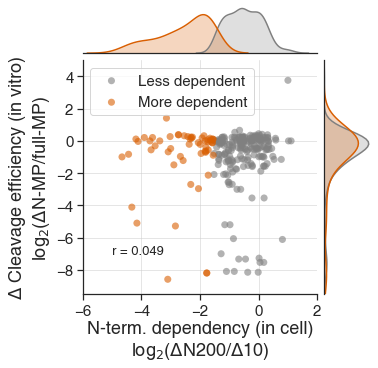

In [549]:
# start with a square Figure
fig = plt.figure(figsize=(5, 5))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(5, 1), height_ratios=(1, 5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histx.get_yticklabels(), visible=False)
ax_histx.tick_params(axis='both', which='both', length=0)

ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
plt.setp(ax_histy.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
ax_histy.tick_params(axis='both', which='both', length=0)

ax.scatter(KJSC_joined[KJSC_joined['sig'] == 'Less dependent']["log2FoldChange"], \
           KJSC_joined[KJSC_joined['sig'] == 'Less dependent']["log2CE(deln/full)"], \
           c='#808080', alpha=0.6, s=50, edgecolors='none', label='Less dependent')
ax.scatter(KJSC_joined[KJSC_joined['sig'] == 'More dependent']["log2FoldChange"], \
           KJSC_joined[KJSC_joined['sig'] == 'More dependent']["log2CE(deln/full)"], \
           c='#d95f02', alpha=0.6, s=50, edgecolors='none', label='More dependent')
ax.set_xlim(-6,2)
ax.set_ylim(-9.5,5)

r = stats.pearsonr(KJSC_joined["log2FoldChange"], KJSC_joined["log2CE(deln/full)"])[0]
ax.text(-5,-7, 'r = %.3f'%r, fontsize = 13)

sns.kdeplot(KJSC_joined[KJSC_joined['sig'] == 'Less dependent']["log2FoldChange"], ax=ax_histx, \
            color='#808080', shade=True, legend=False)
sns.kdeplot(KJSC_joined[KJSC_joined['sig'] == 'More dependent']["log2FoldChange"], ax=ax_histx, \
            color='#d95f02', shade=True, legend=False)

sns.kdeplot(KJSC_joined[KJSC_joined['sig'] == 'Less dependent']["log2CE(deln/full)"], ax=ax_histy, \
            color='#808080',shade=True, legend=False, vertical=True)
sns.kdeplot(KJSC_joined[KJSC_joined['sig'] == 'More dependent']["log2CE(deln/full)"], ax=ax_histy, \
            color='#d95f02', shade=True, legend=False, vertical=True)

ax_histx.set_xlabel('')
ax_histy.set_ylabel('')

ax_histx.spines['top'].set_visible(False)
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['left'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)
ax_histy.spines['right'].set_visible(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)
ax.set_xlabel("N-term. dependency (in cell)\nlog$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax.set_ylabel("$\Delta$ Cleavage efficiency (in vitro)\nlog$_2$($\Delta$N-MP/full-MP)", fontsize=18)
ax.legend(loc="upper left", fontsize=15)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)

fig.show()
#plt.savefig("Results/Figures/201214-KJSC-HCT116.pdf", bbox_inches='tight')

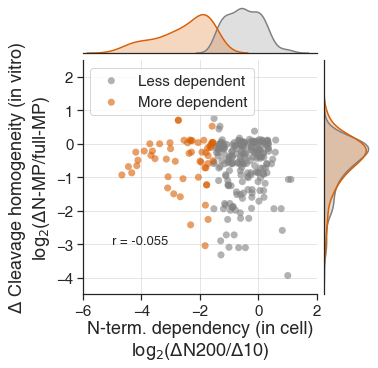

In [553]:
# start with a square Figure
fig = plt.figure(figsize=(5, 5))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(5, 1), height_ratios=(1, 5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histx.get_yticklabels(), visible=False)
ax_histx.tick_params(axis='both', which='both', length=0)

ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
plt.setp(ax_histy.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
ax_histy.tick_params(axis='both', which='both', length=0)

ax.scatter(KJSC_joined[KJSC_joined['sig'] == 'Less dependent']["log2FoldChange"], \
           KJSC_joined[KJSC_joined['sig'] == 'Less dependent']["log2CH(deln/full)"], \
           c='#808080', alpha=0.6, s=50, edgecolors='none', label='Less dependent')
ax.scatter(KJSC_joined[KJSC_joined['sig'] == 'More dependent']["log2FoldChange"], \
           KJSC_joined[KJSC_joined['sig'] == 'More dependent']["log2CH(deln/full)"], \
           c='#d95f02', alpha=0.6, s=50, edgecolors='none', label='More dependent')
ax.set_xlim(-6,2)
ax.set_ylim(-4.5,2.5)

r = stats.pearsonr(KJSC_joined["log2FoldChange"], KJSC_joined["log2CH(deln/full)"])[0]
ax.text(-5,-3, 'r = %.3f'%r, fontsize = 13)

sns.kdeplot(KJSC_joined[KJSC_joined['sig'] == 'Less dependent']["log2FoldChange"], ax=ax_histx, \
            color='#808080', shade=True, legend=False)
sns.kdeplot(KJSC_joined[KJSC_joined['sig'] == 'More dependent']["log2FoldChange"], ax=ax_histx, \
            color='#d95f02', shade=True, legend=False)

sns.kdeplot(KJSC_joined[KJSC_joined['sig'] == 'Less dependent']["log2CH(deln/full)"], ax=ax_histy, \
            color='#808080',shade=True, legend=False, vertical=True)
sns.kdeplot(KJSC_joined[KJSC_joined['sig'] == 'More dependent']["log2CH(deln/full)"], ax=ax_histy, \
            color='#d95f02', shade=True, legend=False, vertical=True)

ax_histx.set_xlabel('')
ax_histy.set_ylabel('')

ax_histx.spines['top'].set_visible(False)
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['left'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)
ax_histy.spines['right'].set_visible(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)
ax.set_xlabel("N-term. dependency (in cell)\nlog$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax.set_ylabel("$\Delta$ Cleavage homogeneity (in vitro)\nlog$_2$($\Delta$N-MP/full-MP)", fontsize=18)
ax.legend(loc="upper left", fontsize=15)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)

fig.show()
#plt.savefig("Results/Figures/201214-KJSC-HCT116.pdf", bbox_inches='tight')

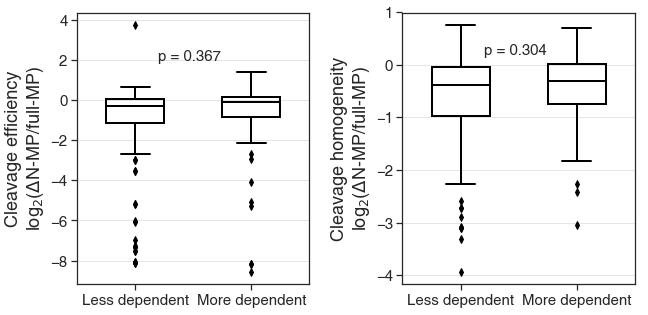

In [532]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

### ax[0]
sns.boxplot(x='sig', y = "log2CE(deln/full)", data=KJSC_joined, width=0.5,showcaps=True, ax=ax[0],\
            showfliers=True, boxprops={'facecolor':'None'}, linewidth=2, color='black')

p0 = mannwhitneyu(KJSC_joined[KJSC_joined["sig"] == 'More dependent']["log2CE(deln/full)"], 
                  KJSC_joined[KJSC_joined["sig"] == 'Less dependent']["log2CE(deln/full)"], alternative='two-sided')[1]

ax[0].text(0.2,2,'p = %.3f'%p0,  fontsize=15)

ax[0].set_xlabel("")
ax[0].set_ylabel("Cleavage efficiency\nlog$_2$($\Delta$N-MP/full-MP)", fontsize=18)

    
ax[0].grid(axis='y', alpha=0.5)

for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(15)

    
### ax[1]
sns.boxplot(x='sig', y = "log2CH(deln/full)", data=KJSC_joined, width=0.5,showcaps=True, ax=ax[1],\
            showfliers=True, boxprops={'facecolor':'None'}, linewidth=2, color='black')

p1 = mannwhitneyu(KJSC_joined[KJSC_joined["sig"] == 'More dependent']["log2CH(deln/full)"], 
                  KJSC_joined[KJSC_joined["sig"] == 'Less dependent']["log2CH(deln/full)"], alternative='two-sided')[1]

ax[1].text(0.2,0.2,'p = %.3f'%p1,  fontsize=15)

ax[1].set_xlabel("")
ax[1].set_ylabel("Cleavage homogeneity\nlog$_2$($\Delta$N-MP/full-MP)", fontsize=18)

    
ax[1].grid(axis='y', alpha=0.5)

for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(15)

In [625]:
fig, ax = plt.subplots(1,2, figsize = (10.5,4.5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

ax[0].set_xlim(-5,2)
ax[0].set_ylim(-9,4)

sns.regplot(x="log2FoldChange", y="log2CE(deln/full)", data=KJSC_joined, ax = ax[0], truncate=False, \
            color='#808080', scatter_kws={'alpha':0.6, 's':50, 'edgecolors':"none"})

r0 = stats.pearsonr(KJSC_joined["log2FoldChange"], KJSC_joined["log2CE(deln/full)"])[0]
ax[0].text(-4,-4, 'r = %.3f'%r0, fontsize = 15)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].grid(axis='y', alpha=0.5)
ax[0].grid(axis='x', alpha=0.5)
ax[0].set_xlabel("N-term. dependency (in cell)\nlog$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax[0].set_ylabel("$\Delta$ Cleavage efficiency (in vitro)\nlog$_2$($\Delta$N-MP/full-MP)", fontsize=18)


for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(15)
    
ax[1].set_xlim(-5,2)
ax[1].set_ylim(-4.5,1)
    
sns.regplot(x="log2FoldChange", y="log2CH(deln/full)", data=KJSC_joined, ax = ax[1], truncate=False, \
            color='#808080', scatter_kws={'alpha':0.6, 's':50, 'edgecolors':"none"})

r1 = stats.pearsonr(KJSC_joined["log2FoldChange"], KJSC_joined["log2CH(deln/full)"])[0]
ax[1].text(-4,-2, 'r = %.3f'%r1, fontsize = 15)

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].grid(axis='y', alpha=0.5)
ax[1].grid(axis='x', alpha=0.5)
ax[1].set_xlabel("N-term. dependency (in cell)\nlog$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax[1].set_ylabel("$\Delta$ Cleavage homogeneity (in vitro)\nlog$_2$($\Delta$N-MP/full-MP)", fontsize=18)


for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(15)
    
fig.show()
#plt.savefig("Results/Figures/201231-KJSC-delnandfl-HCT116.pdf", bbox_inches='tight')

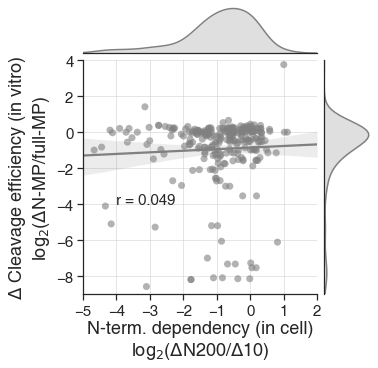

In [616]:
fig = plt.figure(figsize=(5, 5))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(5, 1), height_ratios=(1, 5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histx.get_yticklabels(), visible=False)
ax_histx.tick_params(axis='both', which='both', length=0)

ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
plt.setp(ax_histy.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
ax_histy.tick_params(axis='both', which='both', length=0)

ax.set_xlim(-5,2)
ax.set_ylim(-9,4)

sns.regplot(x="log2FoldChange", y="log2CE(deln/full)", data=KJSC_joined, ax = ax, truncate=False, \
            color='#808080', scatter_kws={'alpha':0.6, 's':50, 'edgecolors':"none"})

r = stats.pearsonr(KJSC_joined["log2FoldChange"], KJSC_joined["log2CE(deln/full)"])[0]
ax.text(-4,-4, 'r = %.3f'%r, fontsize = 15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.grid(axis='x', alpha=0.5)
ax.set_xlabel("N-term. dependency (in cell)\nlog$_2$($\Delta$N200/$\Delta$10)", fontsize=18)
ax.set_ylabel("$\Delta$ Cleavage efficiency (in vitro)\nlog$_2$($\Delta$N-MP/full-MP)", fontsize=18)

sns.kdeplot(KJSC_joined["log2FoldChange"], ax=ax_histx,color='#808080', shade=True, legend=False)
sns.kdeplot(KJSC_joined["log2CE(deln/full)"], ax=ax_histy, color='#808080',shade=True, legend=False, vertical=True)

ax_histx.set_xlabel('')
ax_histy.set_ylabel('')

ax_histx.spines['top'].set_visible(False)
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['left'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)
ax_histy.spines['right'].set_visible(False)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)

fig.show()

#plt.savefig("Results/Figures/201214-KJSC-HCT116.pdf", bbox_inches='tight')#plt.savefig("Results/Figures/201231-KJSC-delnandfl-HCT116.pdf", bbox_inches='tight')

--- 
### Among intragenic (intronic & exonics), see the correlation between 5' end of 5' UTR (or 3' end of 3' UTR) and gene length and log2FC


#### For intronic & exonic miRNAs in SS_filtered_2000, get the host gene information from UCSC table browser

In [204]:
### Extract intronic and exonic miRNAs
intragenic = SS_filtered_2000[SS_filtered_2000['Exon_Intron'].isin(['intronic', 'exonic'])].set_index("mature")

For hsa-miR-766: HostGene is annotated as 43714 (I think it is an error in original annotation file). 

- Instead of 43714, put SEPTIN6 for searching. In the near future, it is better to modify the original annotation file (200326_curated_hg38_mature_miRNA_classification)

- USMG5 --> ATP5MD
- C9orf3 --> AOPEP

In [205]:
intragenic.loc["hsa-miR-766-3p", "HostGene"] = "SEPTIN6"
intragenic.loc["hsa-miR-1307-5p", "HostGene"] = "ATP5MD"
intragenic.loc["hsa-miR-1307-3p", "HostGene"] = "ATP5MD"
intragenic.loc["hsa-miR-23b-3p", "HostGene"] = "AOPEP"
intragenic.loc["hsa-miR-24-1-5p", "HostGene"] = "AOPEP"
intragenic.loc["hsa-miR-27b-3p", "HostGene"] = "AOPEP"
intragenic.loc["hsa-miR-27b-5p", "HostGene"] = "AOPEP"

#intragenic["HostGene"].drop_duplicates().to_csv("Results/200922_intronic_exonic_host_gene_symbol.csv")

In [142]:
SS_filtered_2000[SS_filtered_2000["mature"] == 'hsa-miR-766-3p']

mature   baseMean  log2FoldChange      stat    pvalue     padj  \
287  hsa-miR-766-3p  13.845748       -1.004623 -1.755654  0.079148  0.13965   

    curated DROSHA dependency (HCT116) 5p3p    pri-miRNA   Chr  \
287                   DROSHA-dependent   3p  hsa-mir-766  chrX   

          ...        Exon_Intron  HostGene Direction stem length loop  \
287       ...           intronic     43714        --        34.0  9.0   

    simple loop  UG    CNNC    UGU  Clustered_2000  
287         9.0  UG  NoCNNC  NoUGU     independent  

[1 rows x 25 columns]

- genome: hg38
- group: Genes and Gene Predictions
- track: NCBI Refseq, table: UCSC RefSeq(refGene)
- file name: 200922_host_gene_from_refGene
- 0-based, half open

In [206]:
host_gene = pd.read_table('200922_host_gene_from_refGene')
host_gene["gene_len"] = host_gene["txEnd"]-host_gene["txStart"]
host_gene.head()

#name chrom strand    txStart      txEnd   cdsStart     cdsEnd  \
0  NM_001001552  chr1      -  205381378  205422056  205381734  205420536   
1  NM_001142587  chr1      +   40691703   40771603   40738843   40770828   
2  NM_001142588  chr1      +   40691703   40771603   40738843   40770828   
3  NM_001142589  chr1      +   40691703   40771603   40738843   40770828   
4  NM_001142590  chr1      +   40692007   40771603   40738843   40770828   

   exonCount                                         exonStarts  \
0          4           205381378,205419229,205420454,205421989,   
1         10  40691703,40738835,40747533,40749572,40753150,4...   
2         11  40691703,40738835,40747533,40749572,40753150,4...   
3          9  40691703,40738835,40747533,40753150,40758120,4...   
4         15  40692007,40695605,40712397,40721605,40723207,4...   

                                            exonEnds  name2  gene_len  
0           205381856,205419352,205420574,205422056,  LEMD1     40678  
1  40691867,40738948,40747605,40749686,40753246,4...   NFYC     79900  
2  40691867,40738948,40747605,40749686,40753246,4...   NFYC     79900  
3  40691867,40738948,40747605,40753246,40758294,4...   NFYC     79900  
4  40692200,40695745,40712469,40721704,40723274,4...   NFYC     79596

In [207]:
host_gene = host_gene.groupby(["name2"])[["txStart", "txEnd","gene_len"]].median()
host_gene.head()

txStart        txEnd  gene_len
name2                                      
ABLIM2     7965326.0    8158813.0  193487.0
AOPEP     94726698.0   95087218.0  327570.0
ARFGAP1   63272812.0   63289790.0   16978.0
ARRB1     75260121.0   75351661.0   91540.0
ATP11C   139726347.0  139933053.0  206706.0

In [335]:
intragenic_tx=intragenic.drop(columns=["5p3p", "stem length", "loop", "simple loop", \
                                       "UG", "CNNC", "UGU", "Clustered"]).join(host_gene, on='HostGene', how='left')
intragenic_tx.head()

baseMean  log2FoldChange      stat    pvalue      padj  \
mature                                                                       
hsa-let-7e-3p      19.727205       -1.399991 -2.897148  0.003766  0.012796   
hsa-let-7e-5p    1016.258392       -0.500436 -2.088872  0.036719  0.076786   
hsa-let-7f-2-3p    47.599577       -0.160113 -0.430125  0.667105  0.741902   
hsa-let-7g-3p      47.297341       -0.355310 -0.867338  0.385757  0.479096   
hsa-let-7g-5p    4175.582999        0.184186  0.720868  0.470991  0.569534   

                curated DROSHA dependency (HCT116)     pri-miRNA    Chr  \
mature                                                                    
hsa-let-7e-3p                     DROSHA-dependent    hsa-let-7e  chr19   
hsa-let-7e-5p                     DROSHA-dependent    hsa-let-7e  chr19   
hsa-let-7f-2-3p                   DROSHA-dependent  hsa-let-7f-2   chrX   
hsa-let-7g-3p                     DROSHA-dependent    hsa-let-7g   chr3   
hsa-let-7g-5p                     DROSHA-dependent    hsa-let-7g   chr3   

                  pri Start     pri End strand       Locus Exon_Intron  \
mature                                                                   
hsa-let-7e-3p    51692786.0  51692864.0      +  intragenic      exonic   
hsa-let-7e-5p    51692786.0  51692864.0      +  intragenic      exonic   
hsa-let-7f-2-3p  53557192.0  53557274.0      -  intragenic    intronic   
hsa-let-7g-3p    52268278.0  52268361.0      -  intragenic    intronic   
hsa-let-7g-5p    52268278.0  52268361.0      -  intragenic    intronic   

                HostGene Direction Clustered_2000     txStart       txEnd  \
mature                                                                      
hsa-let-7e-3p     SPACA6        ++      clustered  51693329.0  51705190.0   
hsa-let-7e-5p     SPACA6        ++      clustered  51693329.0  51705190.0   
hsa-let-7f-2-3p    HUWE1        --      clustered  53532095.0  53686719.0   
hsa-let-7g-3p      WDR82        --    independent  52254433.0  52278649.0   
hsa-let-7g-5p      WDR82        --    independent  52254433.0  52278649.0   

                 gene_len  
mature                     
hsa-let-7e-3p     11861.0  
hsa-let-7e-5p     11861.0  
hsa-let-7f-2-3p  154624.0  
hsa-let-7g-3p     24216.0  
hsa-let-7g-5p     24216.0

In [217]:
pd.crosstab(intragenic_tx["Exon_Intron"], intragenic_tx["Clustered_2000"])

Clustered_2000  clustered  independent
Exon_Intron                           
exonic                  6           13
intronic               37           94

In [327]:
intragenic_tx_intronic_indep=\
intragenic_tx[(intragenic_tx["Exon_Intron"]=='intronic')\
              & (intragenic_tx["Clustered_2000"]=='independent')][["baseMean", "log2FoldChange","strand","pri Start","pri End","HostGene","txStart", "txEnd", "gene_len"]]
intragenic_tx_intronic_clustered=\
intragenic_tx[(intragenic_tx["Exon_Intron"]=='intronic') & \
              (intragenic_tx["Clustered_2000"]=='clustered')][["baseMean", "log2FoldChange","strand","pri Start","pri End","HostGene","txStart", "txEnd", "gene_len", ]]
print(intragenic_tx_intronic_indep.shape,intragenic_tx_intronic_clustered.shape)

(94, 9) (37, 9)


In [328]:
intragenic_tx_intronic_indep.loc[:,"log2FC_group"] = \
pd.qcut(intragenic_tx_intronic_indep["log2FoldChange"], 2, labels=['Group 1', 'Group 2'])

intragenic_tx_intronic_clustered.loc[:,"log2FC_group"] = \
pd.qcut(intragenic_tx_intronic_clustered["log2FoldChange"], 2, labels=['Group 1', 'Group 2'])

In [329]:
intragenic_tx_intronic_indep.tail()

baseMean  log2FoldChange strand    pri Start      pri End  \
mature                                                                        
hsa-miR-744-3p   15.205405       -1.796639      +   12081899.0   12081996.0   
hsa-miR-744-5p  651.813209       -1.432399      +   12081899.0   12081996.0   
hsa-miR-766-3p   13.845748       -1.004623      -  119646738.0  119646848.0   
hsa-miR-942-5p   16.508010       -1.820943      +  117094643.0  117094728.0   
hsa-miR-95-3p    78.788472       -0.734241      -    8005301.0    8005381.0   

               HostGene      txStart        txEnd  gene_len log2FC_group  
mature                                                                    
hsa-miR-744-3p   MAP2K4   12020876.0   12143826.0  122950.0      Group 1  
hsa-miR-744-5p   MAP2K4   12020876.0   12143826.0  122950.0      Group 1  
hsa-miR-766-3p  SEPTIN6  119616334.5  119693168.0   76833.5      Group 2  
hsa-miR-942-5p     TTF2  117060325.0  117107453.0   47128.0      Group 1  
hsa-miR-95-3p    ABLIM2    7965326.0    8158813.0  193487.0      Group 2

In [330]:
for i, row in intragenic_tx_intronic_indep.iterrows():
    if row["strand"] == '+':
        intragenic_tx_intronic_indep.loc[i,"dist_txStart"] = row["pri Start"] - row["txStart"]
        intragenic_tx_intronic_indep.loc[i,"dist_txEnd"] = row["txEnd"] - row["pri End"] 
    elif row["strand"] == '-':
        intragenic_tx_intronic_indep.loc[i,"dist_txStart"] = row["txEnd"] - row["pri End"]
        intragenic_tx_intronic_indep.loc[i,"dist_txEnd"] = row["pri Start"] - row["txStart"]
        
for i, row in intragenic_tx_intronic_clustered.iterrows():
    if row["strand"] == '+':
        intragenic_tx_intronic_clustered.loc[i,"dist_txStart"] = row["pri Start"] - row["txStart"]
        intragenic_tx_intronic_clustered.loc[i,"dist_txEnd"] = row["txEnd"] - row["pri End"] 
    elif row["strand"] == '-':
        intragenic_tx_intronic_clustered.loc[i,"dist_txStart"] = row["txEnd"] - row["pri End"]
        intragenic_tx_intronic_clustered.loc[i,"dist_txEnd"] = row["pri Start"] - row["txStart"]

In [338]:
fig, ax = plt.subplots(1,3, figsize = (18,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

# ax[0]
sns.swarmplot(x="log2FC_group", y = "gene_len", data=intragenic_tx_intronic_indep, size=5, color='black', alpha=0.75, ax=ax[0])
sns.boxplot(x='log2FC_group', y = "gene_len", data=intragenic_tx_intronic_indep, width=0.5,showcaps=False, ax=ax[0],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p0 = mannwhitneyu(intragenic_tx_intronic_indep[intragenic_tx_intronic_indep["log2FC_group"] == 'Group 1']["gene_len"], 
                   intragenic_tx_intronic_indep[intragenic_tx_intronic_indep["log2FC_group"] == 'Group 2']["gene_len"], alternative='two-sided')[1]

ax[0].text(0.3,630000,'Gp 1 vs. Gp 2 p=%.3f'%p0,  fontproperties=helvetica_15)


plt.setp(ax[0].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[0].lines, color='black') # Change box edgecolor

ax[0].set_title("Gene length", fontproperties=helvetica_18)
ax[0].set_ylabel("Host gene length (nt)", fontproperties=helvetica_18)
ax[0].set_xlabel('')    
ax[0].grid(axis='y', alpha=0.5)


# ax[1]
sns.swarmplot(x="log2FC_group", y = "dist_txStart", data=intragenic_tx_intronic_indep, size=5, color='black', alpha=0.75, ax=ax[1])
sns.boxplot(x='log2FC_group', y = "dist_txStart", data=intragenic_tx_intronic_indep, width=0.5,showcaps=False, ax=ax[1],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p1 = mannwhitneyu(intragenic_tx_intronic_indep[intragenic_tx_intronic_indep["log2FC_group"] == 'Group 1']["dist_txStart"], 
                   intragenic_tx_intronic_indep[intragenic_tx_intronic_indep["log2FC_group"] == 'Group 2']["dist_txStart"], alternative='two-sided')[1]

ax[1].text(0.3,450000,'Gp 1 vs. Gp 2 p=%.3f'%p1,  fontproperties=helvetica_15)


plt.setp(ax[1].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[1].lines, color='black') # Change box edgecolor

ax[1].set_title("5' end of 5' UTR", fontproperties=helvetica_18)
ax[1].set_ylabel("Distance from 5' end of 5' UTR (nt)", fontproperties=helvetica_18)
ax[1].set_xlabel('')    
ax[1].grid(axis='y', alpha=0.5)


# ax[2]
sns.swarmplot(x="log2FC_group", y = "dist_txEnd", data=intragenic_tx_intronic_indep, size=5, color='black', alpha=0.75, ax=ax[2])
sns.boxplot(x='log2FC_group', y = "dist_txEnd", data=intragenic_tx_intronic_indep, width=0.5,showcaps=False, ax=ax[2],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p2 = mannwhitneyu(intragenic_tx_intronic_indep[intragenic_tx_intronic_indep["log2FC_group"] == 'Group 1']["dist_txEnd"], 
                   intragenic_tx_intronic_indep[intragenic_tx_intronic_indep["log2FC_group"] == 'Group 2']["dist_txEnd"], alternative='two-sided')[1]

ax[2].text(0.3,250000,'Gp 1 vs. Gp 2 p=%.3f'%p2,  fontproperties=helvetica_15)


plt.setp(ax[2].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[2].lines, color='black') # Change box edgecolor

ax[2].set_title("3' end of 3' UTR", fontproperties=helvetica_18)
ax[2].set_ylabel("Distance from 3' end of 3' UTR (nt)", fontproperties=helvetica_18)
ax[2].set_xlabel('')  
ax[2].grid(axis='y', alpha=0.5)


for i in range(3):
    for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()) :
        label.set_fontproperties(helvetica_15)

fig.text(0.5, 0, 'Sorting in ascending order by log$_2$(delN200/del10)', ha='center', fontproperties=helvetica_18)
fig.suptitle("Intronic & Independent (n="+str(len(intragenic_tx_intronic_indep))+")", fontproperties=helvetica_20, y=1.02)

fig.show()
fig.savefig("Results/200923_intronic_indep_box_gene_length_UTR.pdf", bbox_inches='tight')
fig.savefig("Results/200923_intronic_indep_box_gene_length_UTR.png", bbox_inches='tight')

In [339]:
fig, ax = plt.subplots(1,3, figsize = (18,5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

# ax[0]
sns.swarmplot(x="log2FC_group", y = "gene_len", data=intragenic_tx_intronic_clustered, size=5, color='black', alpha=0.75, ax=ax[0])
sns.boxplot(x='log2FC_group', y = "gene_len", data=intragenic_tx_intronic_clustered, width=0.5,showcaps=False, ax=ax[0],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p0 = mannwhitneyu(intragenic_tx_intronic_clustered[intragenic_tx_intronic_clustered["log2FC_group"] == 'Group 1']["gene_len"], 
                   intragenic_tx_intronic_clustered[intragenic_tx_intronic_clustered["log2FC_group"] == 'Group 2']["gene_len"], alternative='two-sided')[1]

ax[0].text(0.3,270000,'Gp 1 vs. Gp 2 p=%.3f'%p0,  fontproperties=helvetica_15)


plt.setp(ax[0].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[0].lines, color='black') # Change box edgecolor

ax[0].set_title("Gene length", fontproperties=helvetica_18)
ax[0].set_ylabel("Host gene length (nt)", fontproperties=helvetica_18)
ax[0].set_xlabel('')    
ax[0].grid(axis='y', alpha=0.5)


# ax[1]
sns.swarmplot(x="log2FC_group", y = "dist_txStart", data=intragenic_tx_intronic_clustered, size=5, color='black', alpha=0.75, ax=ax[1])
sns.boxplot(x='log2FC_group', y = "dist_txStart", data=intragenic_tx_intronic_clustered, width=0.5,showcaps=False, ax=ax[1],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p1 = mannwhitneyu(intragenic_tx_intronic_clustered[intragenic_tx_intronic_clustered["log2FC_group"] == 'Group 1']["dist_txStart"], 
                   intragenic_tx_intronic_clustered[intragenic_tx_intronic_clustered["log2FC_group"] == 'Group 2']["dist_txStart"], alternative='two-sided')[1]

ax[1].text(0.3,300000,'Gp 1 vs. Gp 2 p=%.3f'%p1,  fontproperties=helvetica_15)


plt.setp(ax[1].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[1].lines, color='black') # Change box edgecolor

ax[1].set_title("5' end of 5' UTR", fontproperties=helvetica_18)
ax[1].set_ylabel("Distance from 5' end of 5' UTR (nt)", fontproperties=helvetica_18)
ax[1].set_xlabel('')    
ax[1].grid(axis='y', alpha=0.5)


# ax[2]
sns.swarmplot(x="log2FC_group", y = "dist_txEnd", data=intragenic_tx_intronic_clustered, size=5, color='black', alpha=0.75, ax=ax[2])
sns.boxplot(x='log2FC_group', y = "dist_txEnd", data=intragenic_tx_intronic_clustered, width=0.5,showcaps=False, ax=ax[2],\
            showfliers=False,whiskerprops={'linewidth':0}, boxprops={'facecolor':'None'}, linewidth=2.5)

p2 = mannwhitneyu(intragenic_tx_intronic_clustered[intragenic_tx_intronic_clustered["log2FC_group"] == 'Group 1']["dist_txEnd"], 
                   intragenic_tx_intronic_clustered[intragenic_tx_intronic_clustered["log2FC_group"] == 'Group 2']["dist_txEnd"], alternative='two-sided')[1]

ax[2].text(0.3,80000,'Gp 1 vs. Gp 2 p=%.3f'%p2,  fontproperties=helvetica_15)


plt.setp(ax[2].artists, edgecolor = 'black') # Change box edgecolor
plt.setp(ax[2].lines, color='black') # Change box edgecolor

ax[2].set_title("3' end of 3' UTR", fontproperties=helvetica_18)
ax[2].set_ylabel("Distance from 3' end of 3' UTR (nt)", fontproperties=helvetica_18)
ax[2].set_xlabel('')  
ax[2].grid(axis='y', alpha=0.5)


for i in range(3):
    for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()) :
        label.set_fontproperties(helvetica_15)

fig.text(0.5, 0, 'Sorting in ascending order by log$_2$(delN200/del10)', ha='center', fontproperties=helvetica_18)
fig.suptitle("Intronic & Clustered (n="+str(len(intragenic_tx_intronic_clustered))+")", fontproperties=helvetica_20, y=1.02)
fig.show()

fig.savefig("Results/200923_intronic_clustered_box_gene_length_UTR.pdf", bbox_inches='tight')
fig.savefig("Results/200923_intronic_clustered_box_gene_length_UTR.png", bbox_inches='tight')

In [337]:
intragenic_tx[intragenic_tx["Exon_Intron"] == 'exonic']

baseMean  log2FoldChange      stat        pvalue  \
mature                                                                 
hsa-let-7e-3p      19.727205       -1.399991 -2.897148  3.765726e-03   
hsa-let-7e-5p    1016.258392       -0.500436 -2.088872  3.671925e-02   
hsa-miR-10b-5p    470.274636        0.035422  0.151311  8.797305e-01   
hsa-miR-125a-3p    33.895904        0.230493  0.568736  5.695353e-01   
hsa-miR-125a-5p  1143.189952        0.164734  0.699308  4.843599e-01   
hsa-miR-1287-5p    34.126761       -1.348097 -3.401787  6.694689e-04   
hsa-miR-2110       81.573429        1.003598  3.291637  9.960597e-04   
hsa-miR-3614-3p    31.751794        1.111034  2.447975  1.436616e-02   
hsa-miR-3614-5p    30.108477        1.023190  2.299578  2.147216e-02   
hsa-miR-4664-5p    13.182330       -3.087789 -4.018021  5.868905e-05   
hsa-miR-4707-5p    20.100321       -0.619930 -1.369309  1.709027e-01   
hsa-miR-4787-3p    34.546026        0.766256  1.814204  6.964628e-02   
hsa-miR-5001-3p    22.775198        0.815313  1.951246  5.102781e-02   
hsa-miR-642a-5p    27.950215       -1.236981 -2.808005  4.984942e-03   
hsa-miR-671-3p     51.296617       -0.350392 -0.960448  3.368297e-01   
hsa-miR-671-5p    578.233235        0.072894  0.294388  7.684612e-01   
hsa-miR-935        13.055160       -1.229811 -1.860031  6.288117e-02   
hsa-miR-99b-3p     94.634426       -1.795472 -5.307373  1.112164e-07   
hsa-miR-99b-5p    947.857727       -1.829807 -6.905237  5.011984e-12   

                         padj curated DROSHA dependency (HCT116)  \
mature                                                             
hsa-let-7e-3p    1.279649e-02                   DROSHA-dependent   
hsa-let-7e-5p    7.678613e-02                   DROSHA-dependent   
hsa-miR-10b-5p   9.120370e-01                   DROSHA-dependent   
hsa-miR-125a-3p  6.667287e-01                   DROSHA-dependent   
hsa-miR-125a-5p  5.822707e-01                   DROSHA-dependent   
hsa-miR-1287-5p  3.485037e-03                   DROSHA-dependent   
hsa-miR-2110     4.541042e-03                   DROSHA-dependent   
hsa-miR-3614-3p  3.834460e-02                   DROSHA-dependent   
hsa-miR-3614-5p  5.253522e-02                   DROSHA-dependent   
hsa-miR-4664-5p  4.895200e-04                   DROSHA-dependent   
hsa-miR-4707-5p  2.523996e-01                   DROSHA-dependent   
hsa-miR-4787-3p  1.274822e-01                   DROSHA-dependent   
hsa-miR-5001-3p  1.009553e-01                   DROSHA-dependent   
hsa-miR-642a-5p  1.604802e-02                   DROSHA-dependent   
hsa-miR-671-3p   4.322255e-01                   DROSHA-dependent   
hsa-miR-671-5p   8.282680e-01                   DROSHA-dependent   
hsa-miR-935      1.174422e-01                   DROSHA-dependent   
hsa-miR-99b-3p   2.056602e-06                   DROSHA-dependent   
hsa-miR-99b-5p   1.599476e-10                   DROSHA-dependent   

                    pri-miRNA    Chr    pri Start      pri End strand  \
mature                                                                  
hsa-let-7e-3p      hsa-let-7e  chr19   51692786.0   51692864.0      +   
hsa-let-7e-5p      hsa-let-7e  chr19   51692786.0   51692864.0      +   
hsa-miR-10b-5p    hsa-mir-10b   chr2  176150303.0  176150412.0      +   
hsa-miR-125a-3p  hsa-mir-125a  chr19   51693254.0   51693339.0      +   
hsa-miR-125a-5p  hsa-mir-125a  chr19   51693254.0   51693339.0      +   
hsa-miR-1287-5p  hsa-mir-1287  chr10   98395218.0   98395307.0      -   
hsa-miR-2110     hsa-mir-2110  chr10  114174105.0  114174179.0      -   
hsa-miR-3614-3p  hsa-mir-3614  chr17   56891270.0   56891355.0      -   
hsa-miR-3614-5p  hsa-mir-3614  chr17   56891270.0   56891355.0      -   
hsa-miR-4664-5p  hsa-mir-4664   chr8  143733083.0  143733153.0      -   
hsa-miR-4707-5p  hsa-mir-4707  chr14   22956950.0   22957029.0      -   
hsa-miR-4787-3p  hsa-mir-4787   chr3   50675080.0   50675163.0      +   
hsa-miR-5001-3p  hsa-mir-5001   chr2  232550474.0  23255

In [ ]:
### currently existing variables check
%whos